In [3]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = '/home/lun/project-basileus/seq-gan/'
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])
    
from sgtlstm.utils import load_fixed_length_sequence_from_pickle, create_dataset
from sgtlstm.utils import create_dataset
from sgtlstm.SeqGan import build_G, build_D
from sgtlstm.pretrain import pretrain_generator, pretrain_discriminator, create_self_regression_data_batch
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD

## Load data 

In [5]:
pos_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v5/positive_long_sequences.pickle'
neg_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v5/negative_long_sequences.pickle'

pos_event_type_seqs, pos_timestamp_seqs = load_fixed_length_sequence_from_pickle(pos_data_path, to_timedelta=True, end_token=0)
neg_event_type_seqs, neg_timestamp_seqs = load_fixed_length_sequence_from_pickle(neg_data_path, to_timedelta=True, end_token=0)

## Global Variables 

In [6]:
BATCH_SIZE = 64
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 5
HIDDEN_DIM = 32

END_TOKEN = 0
MAX_TIME = 1024

## G and D

In [7]:
# generator = build_G(
#     batch_size=BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM)

# discriminator = build_D(
#     T = T,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM,
# )

## Pretrain G

In [13]:
pretrain_G_et = pos_event_type_seqs
pretrain_G_ts = pos_timestamp_seqs
pretrain_G_labels = np.ones((pos_event_type_seqs.shape[0], 1))

pretrain_G_features = (pretrain_G_et, pretrain_G_ts)
N_pretrain_G = pretrain_G_et.shape[0]

In [18]:
WEIGHT_GAUSSIAN_LOSS = 1e-2
OPTIMIZER = Adam(lr=1e-3)

EPOCHS = 2
_TOTAL_STEPS = int(EPOCHS * N_pretrain_G / BATCH_SIZE)


pretrain_G_dataset = create_dataset(pretrain_G_features,
                                  pretrain_G_labels,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_pretrain_G)

pretrain_gen_ce_loss_history = []
pretrain_gen_gaussian_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [19]:
_TOTAL_STEPS

3125

In [21]:
step = 0

for feature_sample, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    gen_ce_loss, gen_gaussian_loss =  pretrain_generator(feature_sample, 
                                                         pretrained_generator,
                                                         verbose=True, 
                                                         weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS, 
                                                         optimizer=OPTIMIZER)
        
    pretrain_gen_ce_loss_history.append(gen_ce_loss.numpy())
    pretrain_gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1


1it [00:00,  1.36it/s]

ce_loss:25.027755550800975, gaussian_loss:117.49780704307955
Training Step: 2


2it [00:01,  1.49it/s]

ce_loss:24.903006935505456, gaussian_loss:110.57674538767915
Training Step: 3


3it [00:01,  1.48it/s]

ce_loss:25.016909861346356, gaussian_loss:121.02741292162558
Training Step: 4


4it [00:02,  1.57it/s]

ce_loss:24.86362902345356, gaussian_loss:109.98303707808444
Training Step: 5


5it [00:03,  1.66it/s]

ce_loss:24.94216365459913, gaussian_loss:115.5490279967587
Training Step: 6


6it [00:03,  1.73it/s]

ce_loss:25.086876815180844, gaussian_loss:111.74390291756121
Training Step: 7


7it [00:04,  1.77it/s]

ce_loss:25.033156503114505, gaussian_loss:110.74139665804053
Training Step: 8


8it [00:04,  1.70it/s]

ce_loss:25.11319903548536, gaussian_loss:111.80426659365153
Training Step: 9


9it [00:05,  1.73it/s]

ce_loss:25.064280182959646, gaussian_loss:106.44762392866961
Training Step: 10


10it [00:05,  1.79it/s]

ce_loss:24.939357188903756, gaussian_loss:120.2939690878118
Training Step: 11


11it [00:06,  1.83it/s]

ce_loss:25.00208561371906, gaussian_loss:119.96815146283812
Training Step: 12


12it [00:06,  1.71it/s]

ce_loss:25.057862624797796, gaussian_loss:114.47901743809311
Training Step: 13


13it [00:07,  1.77it/s]

ce_loss:24.86312401902944, gaussian_loss:129.7372283009858
Training Step: 14


14it [00:08,  1.80it/s]

ce_loss:25.020699170547918, gaussian_loss:120.65305788675053
Training Step: 15


15it [00:08,  1.83it/s]

ce_loss:25.059151090160874, gaussian_loss:116.99899451066624
Training Step: 16


16it [00:09,  1.85it/s]

ce_loss:25.011713756144147, gaussian_loss:108.52698578123912
Training Step: 17


17it [00:09,  1.74it/s]

ce_loss:25.084349744040363, gaussian_loss:117.35772461071909
Training Step: 18


18it [00:10,  1.78it/s]

ce_loss:25.127605201599277, gaussian_loss:121.19430556078669
Training Step: 19


19it [00:10,  1.82it/s]

ce_loss:25.126696108893675, gaussian_loss:107.96499979647822
Training Step: 20


20it [00:11,  1.83it/s]

ce_loss:25.010566838306506, gaussian_loss:128.39566239488153
Training Step: 21


21it [00:11,  1.85it/s]

ce_loss:25.016811668946247, gaussian_loss:108.95628562715814
Training Step: 22


22it [00:12,  1.74it/s]

ce_loss:24.946643072852645, gaussian_loss:105.08219364448716
Training Step: 23


23it [00:13,  1.71it/s]

ce_loss:24.864047594758972, gaussian_loss:108.79198718133713
Training Step: 24


24it [00:13,  1.76it/s]

ce_loss:24.961179934967397, gaussian_loss:115.07931528029623
Training Step: 25


25it [00:14,  1.80it/s]

ce_loss:25.063589293991875, gaussian_loss:107.31849963948284
Training Step: 26


26it [00:14,  1.83it/s]

ce_loss:25.220461721392617, gaussian_loss:105.16797554527403
Training Step: 27


27it [00:15,  1.72it/s]

ce_loss:25.129628318784864, gaussian_loss:113.28756737953401
Training Step: 28


28it [00:15,  1.76it/s]

ce_loss:25.06415779871051, gaussian_loss:115.3325069658373
Training Step: 29


29it [00:16,  1.80it/s]

ce_loss:25.105269100262454, gaussian_loss:118.71626257363349
Training Step: 30


30it [00:16,  1.81it/s]

ce_loss:25.108167871199825, gaussian_loss:111.10874400443429
Training Step: 31


31it [00:17,  1.84it/s]

ce_loss:25.031568986862297, gaussian_loss:114.52461929007715
Training Step: 32


32it [00:18,  1.61it/s]

ce_loss:25.06940764224868, gaussian_loss:116.16776606259882
Training Step: 33


33it [00:18,  1.62it/s]

ce_loss:24.888672728440753, gaussian_loss:116.00761512300741
Training Step: 34


34it [00:19,  1.68it/s]

ce_loss:24.89972366309869, gaussian_loss:111.10761734290581
Training Step: 35


35it [00:19,  1.73it/s]

ce_loss:24.914233638863596, gaussian_loss:117.52135419987363
Training Step: 36


36it [00:20,  1.64it/s]

ce_loss:24.908861991876826, gaussian_loss:110.39049569079182
Training Step: 37


37it [00:21,  1.70it/s]

ce_loss:25.183147583981643, gaussian_loss:106.27931683152994
Training Step: 38


38it [00:21,  1.70it/s]

ce_loss:24.811151895058654, gaussian_loss:113.59933180109691
Training Step: 39


39it [00:22,  1.72it/s]

ce_loss:24.818726918333596, gaussian_loss:109.30375044328976
Training Step: 40


40it [00:22,  1.77it/s]

ce_loss:24.927661119061398, gaussian_loss:109.47743976324671
Training Step: 41


41it [00:23,  1.67it/s]

ce_loss:25.102463851054765, gaussian_loss:115.03634396829784
Training Step: 42


42it [00:24,  1.68it/s]

ce_loss:25.11955899739892, gaussian_loss:111.82370923115634
Training Step: 43


43it [00:24,  1.73it/s]

ce_loss:24.974226423846286, gaussian_loss:109.46718655376716
Training Step: 44


44it [00:25,  1.78it/s]

ce_loss:24.818699005635253, gaussian_loss:119.16758819771091
Training Step: 45


45it [00:25,  1.81it/s]

ce_loss:24.840496024576243, gaussian_loss:113.77494000596808
Training Step: 46


46it [00:26,  1.72it/s]

ce_loss:24.86831488827297, gaussian_loss:117.34611747156512
Training Step: 47


47it [00:26,  1.77it/s]

ce_loss:25.005496252497778, gaussian_loss:112.87546969516657
Training Step: 48


48it [00:27,  1.78it/s]

ce_loss:25.03721795382966, gaussian_loss:110.32436688416237
Training Step: 49


49it [00:27,  1.82it/s]

ce_loss:25.064249724800582, gaussian_loss:105.34233846582947
Training Step: 50


50it [00:28,  1.71it/s]

ce_loss:25.02331299040341, gaussian_loss:113.7530170741017
Training Step: 51


51it [00:29,  1.76it/s]

ce_loss:25.01098995504077, gaussian_loss:111.29218717504976
Training Step: 52


52it [00:29,  1.81it/s]

ce_loss:24.962322453787614, gaussian_loss:112.26564275793348
Training Step: 53


53it [00:30,  1.83it/s]

ce_loss:24.914809951144672, gaussian_loss:114.92479127170526
Training Step: 54


54it [00:30,  1.85it/s]

ce_loss:25.03942212348588, gaussian_loss:107.89743971060248
Training Step: 55


55it [00:31,  1.72it/s]

ce_loss:25.052730671630254, gaussian_loss:114.1978131529566
Training Step: 56


56it [00:31,  1.77it/s]

ce_loss:24.807216309709226, gaussian_loss:102.07023951179116
Training Step: 57


57it [00:32,  1.82it/s]

ce_loss:25.093202650242482, gaussian_loss:112.23519928114918
Training Step: 58


58it [00:33,  1.84it/s]

ce_loss:25.131912344659987, gaussian_loss:105.52650254677431
Training Step: 59


59it [00:33,  1.86it/s]

ce_loss:24.928759533435883, gaussian_loss:119.23559449537613
Training Step: 60


60it [00:34,  1.74it/s]

ce_loss:24.894101724724813, gaussian_loss:116.81952045720166
Training Step: 61


61it [00:34,  1.79it/s]

ce_loss:24.993552990357628, gaussian_loss:115.26704876769286
Training Step: 62


62it [00:35,  1.82it/s]

ce_loss:24.854731458731163, gaussian_loss:110.5781467649771
Training Step: 63


63it [00:35,  1.84it/s]

ce_loss:25.03076478419281, gaussian_loss:109.75245623323879
Training Step: 64


64it [00:36,  1.73it/s]

ce_loss:25.125938645998986, gaussian_loss:120.37472061936123
Training Step: 65


65it [00:36,  1.78it/s]

ce_loss:25.018496582269016, gaussian_loss:116.04137169113795
Training Step: 66


66it [00:37,  1.82it/s]

ce_loss:24.876534146794327, gaussian_loss:109.11011097653201
Training Step: 67


67it [00:38,  1.84it/s]

ce_loss:24.98718280290224, gaussian_loss:105.5847777367257
Training Step: 68


68it [00:38,  1.87it/s]

ce_loss:24.934991140432174, gaussian_loss:106.03893364657719
Training Step: 69


69it [00:39,  1.75it/s]

ce_loss:24.8631745291649, gaussian_loss:107.44561585021998
Training Step: 70


70it [00:39,  1.80it/s]

ce_loss:25.08309143327864, gaussian_loss:108.55817076398974
Training Step: 71


71it [00:40,  1.82it/s]

ce_loss:24.954247122655186, gaussian_loss:111.79325112524776
Training Step: 72


72it [00:40,  1.83it/s]

ce_loss:25.03547283082603, gaussian_loss:108.45891180135801
Training Step: 73


73it [00:41,  1.84it/s]

ce_loss:25.137424421592712, gaussian_loss:106.40752699913354
Training Step: 74


74it [00:41,  1.72it/s]

ce_loss:24.842724877502135, gaussian_loss:108.16023115228842
Training Step: 75


75it [00:42,  1.78it/s]

ce_loss:24.93062045962712, gaussian_loss:111.43196586392185
Training Step: 76


76it [00:43,  1.82it/s]

ce_loss:24.809483589538775, gaussian_loss:106.71705942676454
Training Step: 77


77it [00:43,  1.84it/s]

ce_loss:25.216595562406624, gaussian_loss:110.4579917323984
Training Step: 78


78it [00:44,  1.86it/s]

ce_loss:25.00304369118658, gaussian_loss:117.23913668121291
Training Step: 79


79it [00:44,  1.74it/s]

ce_loss:24.96304169920112, gaussian_loss:112.6115537594795
Training Step: 80


80it [00:45,  1.78it/s]

ce_loss:25.068767911520222, gaussian_loss:112.55359444484318
Training Step: 81


81it [00:45,  1.82it/s]

ce_loss:25.048963722683332, gaussian_loss:118.43472195292277
Training Step: 82


82it [00:46,  1.84it/s]

ce_loss:24.81519940484897, gaussian_loss:113.97530057210794
Training Step: 83


83it [00:46,  1.86it/s]

ce_loss:24.892299573120926, gaussian_loss:117.58501265042105
Training Step: 84


84it [00:47,  1.75it/s]

ce_loss:25.226604280095692, gaussian_loss:111.10556368643569
Training Step: 85


85it [00:48,  1.77it/s]

ce_loss:25.214530649784717, gaussian_loss:118.82218722348266
Training Step: 86


86it [00:48,  1.81it/s]

ce_loss:25.06665348261852, gaussian_loss:114.12102662423293
Training Step: 87


87it [00:49,  1.80it/s]

ce_loss:24.972010639612037, gaussian_loss:121.59737873197899
Training Step: 88


88it [00:49,  1.71it/s]

ce_loss:24.877909504968134, gaussian_loss:107.92282178414229
Training Step: 89


89it [00:50,  1.73it/s]

ce_loss:25.214042375351056, gaussian_loss:106.059644378901
Training Step: 90


90it [00:50,  1.77it/s]

ce_loss:25.09062706801696, gaussian_loss:113.82788900552997
Training Step: 91


91it [00:51,  1.80it/s]

ce_loss:25.15253885295763, gaussian_loss:112.04967013548321
Training Step: 92


92it [00:52,  1.74it/s]

ce_loss:24.985760308243584, gaussian_loss:112.80593553387341
Training Step: 93


93it [00:52,  1.66it/s]

ce_loss:24.957550472132425, gaussian_loss:113.12054994641278
Training Step: 94


94it [00:53,  1.71it/s]

ce_loss:24.836141048671134, gaussian_loss:114.51870229573834
Training Step: 95


95it [00:53,  1.76it/s]

ce_loss:25.060824805369236, gaussian_loss:114.93577245540445
Training Step: 96


96it [00:54,  1.80it/s]

ce_loss:25.104962585214903, gaussian_loss:109.41655742629132
Training Step: 97


97it [00:54,  1.75it/s]

ce_loss:24.907743275923217, gaussian_loss:111.83616139037271
Training Step: 98


98it [00:55,  1.60it/s]

ce_loss:24.972163485694544, gaussian_loss:119.7964712650871
Training Step: 99


99it [00:56,  1.68it/s]

ce_loss:25.00005901057989, gaussian_loss:109.56899312355104
Training Step: 100


100it [00:56,  1.74it/s]

ce_loss:25.241638328628177, gaussian_loss:106.82406075411232
Training Step: 101


101it [00:57,  1.78it/s]

ce_loss:24.981655436956096, gaussian_loss:119.68455409616661
Training Step: 102


102it [00:57,  1.69it/s]

ce_loss:25.21920863744407, gaussian_loss:124.11508497391743
Training Step: 103


103it [00:58,  1.76it/s]

ce_loss:25.023229609603362, gaussian_loss:107.76052780956428
Training Step: 104


104it [00:58,  1.80it/s]

ce_loss:25.00251835205242, gaussian_loss:115.97689779112179
Training Step: 105


105it [00:59,  1.83it/s]

ce_loss:25.16107070453863, gaussian_loss:117.03534006023912
Training Step: 106


106it [00:59,  1.85it/s]

ce_loss:25.069093760078246, gaussian_loss:115.93304337204987
Training Step: 107


107it [01:00,  1.73it/s]

ce_loss:25.07534630709774, gaussian_loss:110.26801598526801
Training Step: 108


108it [01:01,  1.78it/s]

ce_loss:25.12576643134748, gaussian_loss:107.25376570337666
Training Step: 109


109it [01:01,  1.82it/s]

ce_loss:25.188926960771102, gaussian_loss:123.48736558495736
Training Step: 110


110it [01:02,  1.84it/s]

ce_loss:24.801741992919826, gaussian_loss:107.41826535565164
Training Step: 111


111it [01:02,  1.85it/s]

ce_loss:24.895024209633164, gaussian_loss:111.49255960619443
Training Step: 112


112it [01:03,  1.73it/s]

ce_loss:25.02566749065017, gaussian_loss:113.31904174294793
Training Step: 113


113it [01:03,  1.78it/s]

ce_loss:24.893384277611887, gaussian_loss:111.93415451934885
Training Step: 114


114it [01:04,  1.82it/s]

ce_loss:25.01789331468912, gaussian_loss:119.20510715659145
Training Step: 115


115it [01:04,  1.84it/s]

ce_loss:24.958955964652613, gaussian_loss:127.4053795992117
Training Step: 116


116it [01:05,  1.73it/s]

ce_loss:25.03871481218686, gaussian_loss:122.56219151879358
Training Step: 117


117it [01:06,  1.78it/s]

ce_loss:24.912476944538, gaussian_loss:117.8454179472368
Training Step: 118


118it [01:06,  1.82it/s]

ce_loss:25.037463021795944, gaussian_loss:125.79989562957186
Training Step: 119


119it [01:07,  1.84it/s]

ce_loss:25.065730276234966, gaussian_loss:107.29553209661215
Training Step: 120


120it [01:07,  1.86it/s]

ce_loss:24.89870683394149, gaussian_loss:119.98742478189577
Training Step: 121


121it [01:08,  1.74it/s]

ce_loss:25.03478243575373, gaussian_loss:109.22733685500378
Training Step: 122


122it [01:08,  1.78it/s]

ce_loss:25.1857370137914, gaussian_loss:113.85211595912276
Training Step: 123


123it [01:09,  1.82it/s]

ce_loss:24.982008393922257, gaussian_loss:115.98007547083883
Training Step: 124


124it [01:09,  1.84it/s]

ce_loss:24.96209337970118, gaussian_loss:107.96132785474371
Training Step: 125


125it [01:10,  1.86it/s]

ce_loss:25.044665043807335, gaussian_loss:114.78529578698654
Training Step: 126


126it [01:11,  1.72it/s]

ce_loss:24.915792909544727, gaussian_loss:113.53397445180234
Training Step: 127


127it [01:11,  1.77it/s]

ce_loss:24.900200617298964, gaussian_loss:109.81166046042546
Training Step: 128


128it [01:12,  1.81it/s]

ce_loss:24.818596646423988, gaussian_loss:119.4238449779352
Training Step: 129


129it [01:12,  1.83it/s]

ce_loss:24.817590500231432, gaussian_loss:105.14608801485657
Training Step: 130


130it [01:13,  1.85it/s]

ce_loss:24.853040387149875, gaussian_loss:110.91347357869586
Training Step: 131


131it [01:13,  1.73it/s]

ce_loss:25.0336008654181, gaussian_loss:115.77330231094912
Training Step: 132


132it [01:14,  1.78it/s]

ce_loss:24.80768567847769, gaussian_loss:121.0304216038003
Training Step: 133


133it [01:15,  1.74it/s]

ce_loss:24.901217195862568, gaussian_loss:112.53534867195627
Training Step: 134


134it [01:15,  1.76it/s]

ce_loss:25.060509386112898, gaussian_loss:119.3094013702055
Training Step: 135


135it [01:16,  1.80it/s]

ce_loss:24.99770476869059, gaussian_loss:103.65524153400628
Training Step: 136


136it [01:16,  1.71it/s]

ce_loss:24.964311531736215, gaussian_loss:111.63766336903142
Training Step: 137


137it [01:17,  1.76it/s]

ce_loss:25.003075495118196, gaussian_loss:105.21375382282186
Training Step: 138


138it [01:17,  1.79it/s]

ce_loss:25.001063487631072, gaussian_loss:109.64876233678592
Training Step: 139


139it [01:18,  1.82it/s]

ce_loss:24.953208019242272, gaussian_loss:118.06231023334885
Training Step: 140


140it [01:19,  1.71it/s]

ce_loss:24.856393872506036, gaussian_loss:119.79578014067414
Training Step: 141


141it [01:19,  1.75it/s]

ce_loss:25.04692390497585, gaussian_loss:116.82832595634666
Training Step: 142


142it [01:20,  1.79it/s]

ce_loss:24.972308776107344, gaussian_loss:109.5154812379468
Training Step: 143


143it [01:20,  1.82it/s]

ce_loss:24.893725852778374, gaussian_loss:108.65348167816273
Training Step: 144


144it [01:21,  1.84it/s]

ce_loss:24.92311281415319, gaussian_loss:115.43395677855216
Training Step: 145


145it [01:21,  1.73it/s]

ce_loss:24.918749225720976, gaussian_loss:114.04124675426408
Training Step: 146


146it [01:22,  1.78it/s]

ce_loss:24.881746439155464, gaussian_loss:120.1940801181559
Training Step: 147


147it [01:22,  1.79it/s]

ce_loss:24.968033236316067, gaussian_loss:111.23396107341331
Training Step: 148


148it [01:23,  1.82it/s]

ce_loss:24.896694271312366, gaussian_loss:111.41632941070526
Training Step: 149


149it [01:24,  1.85it/s]

ce_loss:25.059957202577582, gaussian_loss:112.15413509630962
Training Step: 150


150it [01:24,  1.74it/s]

ce_loss:25.112506403316925, gaussian_loss:113.50908148489607
Training Step: 151


151it [01:25,  1.77it/s]

ce_loss:24.98215031897154, gaussian_loss:106.6883139373394
Training Step: 152


152it [01:25,  1.81it/s]

ce_loss:25.05637601970965, gaussian_loss:107.30173675189423
Training Step: 153


153it [01:26,  1.79it/s]

ce_loss:24.99695044058459, gaussian_loss:114.01793571771009
Training Step: 154


154it [01:26,  1.69it/s]

ce_loss:24.883657942766334, gaussian_loss:118.49361814098157
Training Step: 155


155it [01:27,  1.75it/s]

ce_loss:25.000367507442835, gaussian_loss:115.17372079364142
Training Step: 156


156it [01:28,  1.79it/s]

ce_loss:25.100678427918144, gaussian_loss:113.99982425901885
Training Step: 157


157it [01:28,  1.82it/s]

ce_loss:24.900007093453816, gaussian_loss:125.34816328118265
Training Step: 158


158it [01:29,  1.77it/s]

ce_loss:24.917300843062243, gaussian_loss:119.05328449126847
Training Step: 159


159it [01:29,  1.68it/s]

ce_loss:25.097664633823605, gaussian_loss:108.22704434901696
Training Step: 160


160it [01:30,  1.74it/s]

ce_loss:24.752586811940706, gaussian_loss:110.5145911429914
Training Step: 161


161it [01:30,  1.78it/s]

ce_loss:25.15973159335654, gaussian_loss:123.49836405133543
Training Step: 162


162it [01:31,  1.81it/s]

ce_loss:24.94724994100704, gaussian_loss:109.2050733977786
Training Step: 163


163it [01:32,  1.75it/s]

ce_loss:25.111331218756852, gaussian_loss:112.6402052349461
Training Step: 164


164it [01:32,  1.65it/s]

ce_loss:24.97517700470089, gaussian_loss:114.77105168431207
Training Step: 165


165it [01:33,  1.66it/s]

ce_loss:24.881335181607543, gaussian_loss:106.58709564974596
Training Step: 166


166it [01:33,  1.72it/s]

ce_loss:24.82483670231231, gaussian_loss:116.34366871544779
Training Step: 167


167it [01:34,  1.77it/s]

ce_loss:24.99729173410097, gaussian_loss:116.36478303695834
Training Step: 168


168it [01:35,  1.67it/s]

ce_loss:24.844625670393167, gaussian_loss:108.55010907531657
Training Step: 169


169it [01:35,  1.74it/s]

ce_loss:24.881443795412196, gaussian_loss:104.4321836938424
Training Step: 170


170it [01:36,  1.77it/s]

ce_loss:24.82429754278826, gaussian_loss:112.80173123728139
Training Step: 171


171it [01:36,  1.81it/s]

ce_loss:25.08588035455076, gaussian_loss:108.09350935075099
Training Step: 172


172it [01:37,  1.82it/s]

ce_loss:25.16743057320693, gaussian_loss:110.84514712117081
Training Step: 173


173it [01:37,  1.71it/s]

ce_loss:24.92399619420553, gaussian_loss:119.35472001627805
Training Step: 174


174it [01:38,  1.76it/s]

ce_loss:25.023241225300552, gaussian_loss:104.19786408238562
Training Step: 175


175it [01:38,  1.80it/s]

ce_loss:25.01289208720545, gaussian_loss:106.57938521938397
Training Step: 176


176it [01:39,  1.83it/s]

ce_loss:25.039801327348716, gaussian_loss:123.95562698145528
Training Step: 177


177it [01:39,  1.85it/s]

ce_loss:24.99153332858443, gaussian_loss:101.57735872308812
Training Step: 178


178it [01:40,  1.74it/s]

ce_loss:25.04594136716968, gaussian_loss:110.40968512699631
Training Step: 179


179it [01:41,  1.78it/s]

ce_loss:24.874100575558458, gaussian_loss:114.7353292844738
Training Step: 180


180it [01:41,  1.81it/s]

ce_loss:24.99249646137912, gaussian_loss:109.92997166264483
Training Step: 181


181it [01:42,  1.84it/s]

ce_loss:25.328580561056206, gaussian_loss:110.41696601078378
Training Step: 182


182it [01:42,  1.87it/s]

ce_loss:25.157533862170368, gaussian_loss:106.72224349752113
Training Step: 183


183it [01:43,  1.65it/s]

ce_loss:24.93415006555593, gaussian_loss:116.18520186399637
Training Step: 184


184it [01:44,  1.65it/s]

ce_loss:25.07387479533117, gaussian_loss:112.66078063957019
Training Step: 185


185it [01:44,  1.70it/s]

ce_loss:24.983917717755325, gaussian_loss:103.39702490461843
Training Step: 186


186it [01:45,  1.75it/s]

ce_loss:25.058556479981043, gaussian_loss:113.45891849386754
Training Step: 187


187it [01:45,  1.79it/s]

ce_loss:25.16976536319512, gaussian_loss:109.72313275026168
Training Step: 188


188it [01:46,  1.67it/s]

ce_loss:24.9581744436262, gaussian_loss:116.60154136563796
Training Step: 189


189it [01:46,  1.66it/s]

ce_loss:24.848771979966482, gaussian_loss:105.72735921612336
Training Step: 190


190it [01:47,  1.70it/s]

ce_loss:25.092327453822, gaussian_loss:108.51417075993837
Training Step: 191


191it [01:48,  1.75it/s]

ce_loss:25.108922420736707, gaussian_loss:107.48012722266748
Training Step: 192


192it [01:48,  1.66it/s]

ce_loss:25.035116929261658, gaussian_loss:110.13022932388368
Training Step: 193


193it [01:49,  1.72it/s]

ce_loss:24.8783299694537, gaussian_loss:118.36262159981753
Training Step: 194


194it [01:49,  1.75it/s]

ce_loss:25.039600540295396, gaussian_loss:108.53063596126393
Training Step: 195


195it [01:50,  1.75it/s]

ce_loss:24.861520157077816, gaussian_loss:108.4960244355331
Training Step: 196


196it [01:51,  1.70it/s]

ce_loss:24.918000099896517, gaussian_loss:106.35753446588359
Training Step: 197


197it [01:51,  1.55it/s]

ce_loss:24.9494602765959, gaussian_loss:111.27076892478946
Training Step: 198


198it [01:52,  1.60it/s]

ce_loss:25.066241603006542, gaussian_loss:116.01800867682033
Training Step: 199


199it [01:52,  1.68it/s]

ce_loss:24.9389451990122, gaussian_loss:111.64605143743783
Training Step: 200


200it [01:53,  1.74it/s]

ce_loss:24.941431851215405, gaussian_loss:112.6792173572409
Training Step: 201


201it [01:53,  1.79it/s]

ce_loss:24.842754932607818, gaussian_loss:112.2059586174464
Training Step: 202


202it [01:54,  1.70it/s]

ce_loss:24.97791648887557, gaussian_loss:106.85438296011684
Training Step: 203


203it [01:55,  1.74it/s]

ce_loss:24.948975114497657, gaussian_loss:108.36184863215703
Training Step: 204


204it [01:55,  1.78it/s]

ce_loss:24.832952679637216, gaussian_loss:104.57223258400371
Training Step: 205


205it [01:56,  1.79it/s]

ce_loss:24.960056243875933, gaussian_loss:120.74124687877341
Training Step: 206


206it [01:56,  1.69it/s]

ce_loss:25.127803306767493, gaussian_loss:110.07421480596707
Training Step: 207


207it [01:57,  1.74it/s]

ce_loss:25.05612536547203, gaussian_loss:103.46091262919518
Training Step: 208


208it [01:57,  1.79it/s]

ce_loss:24.850509766535325, gaussian_loss:116.68365589868851
Training Step: 209


209it [01:58,  1.82it/s]

ce_loss:24.953061684182522, gaussian_loss:106.82915389926502
Training Step: 210


210it [01:59,  1.83it/s]

ce_loss:24.987093347870633, gaussian_loss:105.09832310114359
Training Step: 211


211it [01:59,  1.73it/s]

ce_loss:25.00784458730277, gaussian_loss:107.21600786069372
Training Step: 212


212it [02:00,  1.77it/s]

ce_loss:24.869312320334263, gaussian_loss:124.10086091502538
Training Step: 213


213it [02:00,  1.79it/s]

ce_loss:25.164541555497834, gaussian_loss:120.72279830257017
Training Step: 214


214it [02:01,  1.81it/s]

ce_loss:24.66166044419754, gaussian_loss:112.87715309789348
Training Step: 215


215it [02:01,  1.83it/s]

ce_loss:24.921956823595124, gaussian_loss:108.10190155941251
Training Step: 216


216it [02:02,  1.72it/s]

ce_loss:24.891401718108003, gaussian_loss:107.64998408755135
Training Step: 217


217it [02:03,  1.76it/s]

ce_loss:24.923534531576582, gaussian_loss:114.66513643266408
Training Step: 218


218it [02:03,  1.80it/s]

ce_loss:24.873999850023257, gaussian_loss:111.02624931720666
Training Step: 219


219it [02:04,  1.81it/s]

ce_loss:25.064684304905185, gaussian_loss:102.11680600218747
Training Step: 220


220it [02:04,  1.84it/s]

ce_loss:24.772066790380354, gaussian_loss:115.44298289869121
Training Step: 221


221it [02:05,  1.63it/s]

ce_loss:25.000134857428115, gaussian_loss:105.90118135349064
Training Step: 222


222it [02:05,  1.63it/s]

ce_loss:24.901749990003985, gaussian_loss:109.4553201672544
Training Step: 223


223it [02:06,  1.69it/s]

ce_loss:24.908008028233887, gaussian_loss:104.01076579480961
Training Step: 224


224it [02:07,  1.74it/s]

ce_loss:25.16000048464842, gaussian_loss:103.85004690227152
Training Step: 225


225it [02:07,  1.78it/s]

ce_loss:24.960579567438636, gaussian_loss:109.2836804135266
Training Step: 226


226it [02:08,  1.69it/s]

ce_loss:24.897724796677316, gaussian_loss:114.17630313586375
Training Step: 227


227it [02:08,  1.74it/s]

ce_loss:25.04211228961228, gaussian_loss:110.70382488843237
Training Step: 228


228it [02:09,  1.78it/s]

ce_loss:24.83828226699627, gaussian_loss:113.27861288757222
Training Step: 229


229it [02:09,  1.81it/s]

ce_loss:24.834028488109393, gaussian_loss:116.81447919598368
Training Step: 230


230it [02:10,  1.83it/s]

ce_loss:24.956539333716197, gaussian_loss:106.8592081023663
Training Step: 231


231it [02:11,  1.72it/s]

ce_loss:24.98245229768962, gaussian_loss:114.6298763292287
Training Step: 232


232it [02:11,  1.77it/s]

ce_loss:24.89296845877734, gaussian_loss:109.28885549968106
Training Step: 233


233it [02:12,  1.80it/s]

ce_loss:24.900266332232647, gaussian_loss:109.85874836319577
Training Step: 234


234it [02:12,  1.83it/s]

ce_loss:24.906161102446525, gaussian_loss:120.8487472735809
Training Step: 235


235it [02:13,  1.83it/s]

ce_loss:24.87239571513564, gaussian_loss:109.28762338289837
Training Step: 236


236it [02:13,  1.72it/s]

ce_loss:24.77180083032, gaussian_loss:112.63698498936478
Training Step: 237


237it [02:14,  1.77it/s]

ce_loss:25.050906211728943, gaussian_loss:114.075336965012
Training Step: 238


238it [02:14,  1.79it/s]

ce_loss:24.917332844726744, gaussian_loss:110.62931385190738
Training Step: 239


239it [02:15,  1.79it/s]

ce_loss:25.15211953177944, gaussian_loss:107.73054284651343
Training Step: 240


240it [02:16,  1.67it/s]

ce_loss:24.853077360850396, gaussian_loss:107.88729629980425
Training Step: 241


241it [02:16,  1.72it/s]

ce_loss:24.96617053517678, gaussian_loss:114.75156324670793
Training Step: 242


242it [02:17,  1.77it/s]

ce_loss:24.842973948994764, gaussian_loss:113.7622718237345
Training Step: 243


243it [02:17,  1.80it/s]

ce_loss:24.800455646212008, gaussian_loss:99.76222894642245
Training Step: 244


244it [02:18,  1.82it/s]

ce_loss:24.9914079903972, gaussian_loss:108.68169846537478
Training Step: 245


245it [02:19,  1.56it/s]

ce_loss:24.925853826142962, gaussian_loss:110.21585185996095
Training Step: 246


246it [02:19,  1.65it/s]

ce_loss:24.873130842439462, gaussian_loss:108.02973553771493
Training Step: 247


247it [02:20,  1.71it/s]

ce_loss:24.888357021273578, gaussian_loss:119.09576357429435
Training Step: 248


248it [02:20,  1.76it/s]

ce_loss:25.044680253444373, gaussian_loss:107.75481476309463
Training Step: 249


249it [02:21,  1.77it/s]

ce_loss:24.92987058921563, gaussian_loss:112.19661104941912
Training Step: 250


250it [02:22,  1.65it/s]

ce_loss:25.014182616128288, gaussian_loss:110.6730353512971
Training Step: 251


251it [02:22,  1.72it/s]

ce_loss:24.986029191829473, gaussian_loss:121.69180604010555
Training Step: 252


252it [02:23,  1.77it/s]

ce_loss:25.04786605254373, gaussian_loss:104.75029931624412
Training Step: 253


253it [02:23,  1.79it/s]

ce_loss:24.872145444528453, gaussian_loss:110.8141139585694
Training Step: 254


254it [02:24,  1.76it/s]

ce_loss:25.052299376483273, gaussian_loss:119.0642898149106
Training Step: 255


255it [02:24,  1.68it/s]

ce_loss:24.979220000395607, gaussian_loss:117.75339073026694
Training Step: 256


256it [02:25,  1.74it/s]

ce_loss:24.891354963669585, gaussian_loss:114.79758961998269
Training Step: 257


257it [02:25,  1.78it/s]

ce_loss:24.90865114762558, gaussian_loss:108.35879555669473
Training Step: 258


258it [02:26,  1.81it/s]

ce_loss:25.053874548981103, gaussian_loss:105.26217301309208
Training Step: 259


259it [02:26,  1.83it/s]

ce_loss:25.044340204779765, gaussian_loss:114.70998447102912
Training Step: 260


260it [02:27,  1.73it/s]

ce_loss:24.88908457135048, gaussian_loss:112.77536621622563
Training Step: 261


261it [02:28,  1.78it/s]

ce_loss:24.940019708730418, gaussian_loss:112.31499303048004
Training Step: 262


262it [02:28,  1.81it/s]

ce_loss:24.832164174407325, gaussian_loss:108.62260556548729
Training Step: 263


263it [02:29,  1.84it/s]

ce_loss:24.974495514237525, gaussian_loss:114.36524857894608
Training Step: 264


264it [02:29,  1.86it/s]

ce_loss:24.980425200487996, gaussian_loss:100.43553543927737
Training Step: 265


265it [02:30,  1.74it/s]

ce_loss:24.889654548008995, gaussian_loss:110.15568523409775
Training Step: 266


266it [02:30,  1.78it/s]

ce_loss:24.817943040703152, gaussian_loss:116.1948411237594
Training Step: 267


267it [02:31,  1.81it/s]

ce_loss:25.031774284122086, gaussian_loss:107.58272357351531
Training Step: 268


268it [02:32,  1.83it/s]

ce_loss:24.897066238461015, gaussian_loss:101.73786481050959
Training Step: 269


269it [02:32,  1.84it/s]

ce_loss:24.950382988250876, gaussian_loss:99.4795860240867
Training Step: 270


270it [02:33,  1.73it/s]

ce_loss:24.846474081919155, gaussian_loss:117.50603331703228
Training Step: 271


271it [02:33,  1.77it/s]

ce_loss:24.90341445639487, gaussian_loss:114.45639314425097
Training Step: 272


272it [02:34,  1.81it/s]

ce_loss:24.940954240518906, gaussian_loss:108.47513432930245
Training Step: 273


273it [02:34,  1.84it/s]

ce_loss:24.935285730624358, gaussian_loss:100.10721877277992
Training Step: 274


274it [02:35,  1.72it/s]

ce_loss:24.79728953825044, gaussian_loss:103.10874335214729
Training Step: 275


275it [02:35,  1.77it/s]

ce_loss:25.233760959173736, gaussian_loss:114.86240148092723
Training Step: 276


276it [02:36,  1.81it/s]

ce_loss:24.834501431462108, gaussian_loss:112.57767868142109
Training Step: 277


277it [02:37,  1.82it/s]

ce_loss:24.90693243792868, gaussian_loss:111.3256958019229
Training Step: 278


278it [02:37,  1.85it/s]

ce_loss:25.01401293676559, gaussian_loss:120.44056539788338
Training Step: 279


279it [02:38,  1.73it/s]

ce_loss:24.879238404669195, gaussian_loss:102.89621396708984
Training Step: 280


280it [02:38,  1.77it/s]

ce_loss:24.91419572894271, gaussian_loss:110.23798287772317
Training Step: 281


281it [02:39,  1.81it/s]

ce_loss:25.04928222424655, gaussian_loss:105.57564961580817
Training Step: 282


282it [02:39,  1.84it/s]

ce_loss:24.93457807561594, gaussian_loss:105.43996864327059
Training Step: 283


283it [02:40,  1.86it/s]

ce_loss:25.083681340671323, gaussian_loss:113.85310800856799
Training Step: 284


284it [02:40,  1.74it/s]

ce_loss:25.03653394808748, gaussian_loss:109.14559271807893
Training Step: 285


285it [02:41,  1.79it/s]

ce_loss:24.94329922706541, gaussian_loss:108.13445413306924
Training Step: 286


286it [02:42,  1.82it/s]

ce_loss:24.893031752076467, gaussian_loss:116.34000245495918
Training Step: 287


287it [02:42,  1.84it/s]

ce_loss:24.820669734750908, gaussian_loss:121.17657677003442
Training Step: 288


288it [02:43,  1.85it/s]

ce_loss:24.98454487982744, gaussian_loss:114.78965490246382
Training Step: 289


289it [02:43,  1.73it/s]

ce_loss:24.86046346056616, gaussian_loss:103.22105952686499
Training Step: 290


290it [02:44,  1.78it/s]

ce_loss:24.966478704009603, gaussian_loss:120.62829364296178
Training Step: 291


291it [02:44,  1.80it/s]

ce_loss:24.848161452026154, gaussian_loss:115.06814981566262
Training Step: 292


292it [02:45,  1.82it/s]

ce_loss:24.974863237661808, gaussian_loss:116.80520485367572
Training Step: 293


293it [02:45,  1.83it/s]

ce_loss:24.880609277469354, gaussian_loss:101.48704554394834
Training Step: 294


294it [02:46,  1.73it/s]

ce_loss:24.854691541744614, gaussian_loss:114.41058338681712
Training Step: 295


295it [02:47,  1.77it/s]

ce_loss:24.851333322538235, gaussian_loss:102.14317992994539
Training Step: 296


296it [02:47,  1.81it/s]

ce_loss:24.895891689247435, gaussian_loss:99.4778158874717
Training Step: 297


297it [02:48,  1.83it/s]

ce_loss:25.03860167459671, gaussian_loss:111.55190777983431
Training Step: 298


298it [02:48,  1.85it/s]

ce_loss:25.014551328127325, gaussian_loss:121.83211510868294
Training Step: 299


299it [02:49,  1.72it/s]

ce_loss:24.946138839424716, gaussian_loss:109.35219022130596
Training Step: 300


300it [02:49,  1.75it/s]

ce_loss:24.848145134673956, gaussian_loss:104.59131492989556
Training Step: 301


301it [02:50,  1.79it/s]

ce_loss:25.086773568737446, gaussian_loss:107.29241437510315
Training Step: 302


302it [02:50,  1.80it/s]

ce_loss:25.05395643406863, gaussian_loss:113.70034013937936
Training Step: 303


303it [02:51,  1.83it/s]

ce_loss:25.16303434610907, gaussian_loss:104.67181516073788
Training Step: 304


304it [02:52,  1.72it/s]

ce_loss:24.7547045185094, gaussian_loss:102.53182818794588
Training Step: 305


305it [02:52,  1.75it/s]

ce_loss:25.014294972968727, gaussian_loss:114.828673470368
Training Step: 306


306it [02:53,  1.78it/s]

ce_loss:24.9936114849989, gaussian_loss:106.0787797174095
Training Step: 307


307it [02:53,  1.82it/s]

ce_loss:24.978446147318603, gaussian_loss:102.68462188991705
Training Step: 308


308it [02:54,  1.71it/s]

ce_loss:24.74716425073055, gaussian_loss:108.86483681118283
Training Step: 309


309it [02:54,  1.74it/s]

ce_loss:24.962777205850955, gaussian_loss:119.98955185159694
Training Step: 310


310it [02:55,  1.79it/s]

ce_loss:24.927324870658488, gaussian_loss:118.25954569018717
Training Step: 311


311it [02:56,  1.81it/s]

ce_loss:24.845528036468316, gaussian_loss:107.06943861814187
Training Step: 312


312it [02:56,  1.84it/s]

ce_loss:24.943789162191525, gaussian_loss:119.69888809255492
Training Step: 313


313it [02:57,  1.72it/s]

ce_loss:24.879950979898126, gaussian_loss:107.93388989728808
Training Step: 314


314it [02:57,  1.77it/s]

ce_loss:24.940404072512578, gaussian_loss:110.13647923348758
Training Step: 315


315it [02:58,  1.80it/s]

ce_loss:24.77922604531401, gaussian_loss:100.09865084998903
Training Step: 316


316it [02:58,  1.83it/s]

ce_loss:24.831243234449556, gaussian_loss:111.89305620577831
Training Step: 317


317it [02:59,  1.85it/s]

ce_loss:24.96464806412316, gaussian_loss:106.62052219413945
Training Step: 318


318it [03:00,  1.73it/s]

ce_loss:24.95596796639647, gaussian_loss:114.11529949627443
Training Step: 319


319it [03:00,  1.78it/s]

ce_loss:24.832169123425754, gaussian_loss:96.50716315015606
Training Step: 320


320it [03:01,  1.81it/s]

ce_loss:24.841771224458803, gaussian_loss:104.49137403320384
Training Step: 321


321it [03:01,  1.84it/s]

ce_loss:25.05731288977869, gaussian_loss:110.58676534537528
Training Step: 322


322it [03:02,  1.85it/s]

ce_loss:25.1055885828478, gaussian_loss:102.88361154819418
Training Step: 323


323it [03:02,  1.73it/s]

ce_loss:24.7818842530886, gaussian_loss:107.47788096943215
Training Step: 324


324it [03:03,  1.78it/s]

ce_loss:24.911738140782866, gaussian_loss:118.43424013037227
Training Step: 325


325it [03:03,  1.73it/s]

ce_loss:25.071397876485513, gaussian_loss:113.55825916148495
Training Step: 326


326it [03:04,  1.74it/s]

ce_loss:25.130555899226483, gaussian_loss:100.19594954403226
Training Step: 327


327it [03:05,  1.70it/s]

ce_loss:24.888990045968214, gaussian_loss:104.98642283663438
Training Step: 328


328it [03:05,  1.63it/s]

ce_loss:25.056001582403077, gaussian_loss:114.57047890220554
Training Step: 329


329it [03:06,  1.70it/s]

ce_loss:24.95514304702411, gaussian_loss:105.41830894374345
Training Step: 330


330it [03:06,  1.76it/s]

ce_loss:25.051911478085362, gaussian_loss:109.60333257449258
Training Step: 331


331it [03:07,  1.80it/s]

ce_loss:24.951173261631578, gaussian_loss:105.18277361207791
Training Step: 332


332it [03:07,  1.83it/s]

ce_loss:25.021725645831715, gaussian_loss:108.0050949245527
Training Step: 333


333it [03:08,  1.73it/s]

ce_loss:24.92057185724522, gaussian_loss:103.84241696963105
Training Step: 334


334it [03:09,  1.78it/s]

ce_loss:24.882637820354855, gaussian_loss:111.07871730016572
Training Step: 335


335it [03:09,  1.81it/s]

ce_loss:24.802641245478988, gaussian_loss:109.3752474158689
Training Step: 336


336it [03:10,  1.83it/s]

ce_loss:24.811334351432016, gaussian_loss:116.2979875897659
Training Step: 337


337it [03:10,  1.86it/s]

ce_loss:24.99112907529427, gaussian_loss:104.80661123000968
Training Step: 338


338it [03:11,  1.75it/s]

ce_loss:24.82465548487321, gaussian_loss:113.74356852260837
Training Step: 339


339it [03:11,  1.78it/s]

ce_loss:25.009285073645977, gaussian_loss:105.23892354944226
Training Step: 340


340it [03:12,  1.81it/s]

ce_loss:25.019633054617017, gaussian_loss:112.18666637363523
Training Step: 341


341it [03:12,  1.82it/s]

ce_loss:24.860007983021966, gaussian_loss:108.12164044761586
Training Step: 342


342it [03:13,  1.72it/s]

ce_loss:25.043125136491277, gaussian_loss:114.59815063036385
Training Step: 343


343it [03:14,  1.77it/s]

ce_loss:24.81374256247689, gaussian_loss:106.53336128458143
Training Step: 344


344it [03:14,  1.81it/s]

ce_loss:25.020525497114363, gaussian_loss:109.30406571632987
Training Step: 345


345it [03:15,  1.75it/s]

ce_loss:24.9434201432262, gaussian_loss:115.17267417537016
Training Step: 346


346it [03:15,  1.78it/s]

ce_loss:24.834209287244477, gaussian_loss:118.61416550539886
Training Step: 347


347it [03:16,  1.68it/s]

ce_loss:24.72709974399908, gaussian_loss:101.35848482484995
Training Step: 348


348it [03:16,  1.73it/s]

ce_loss:24.77930344087604, gaussian_loss:108.84434740329925
Training Step: 349


349it [03:17,  1.78it/s]

ce_loss:24.967473111433417, gaussian_loss:114.9779326188885
Training Step: 350


350it [03:18,  1.81it/s]

ce_loss:25.03763848371578, gaussian_loss:111.98057373835508
Training Step: 351


351it [03:18,  1.83it/s]

ce_loss:25.070952518329833, gaussian_loss:113.87141180207962
Training Step: 352


352it [03:19,  1.72it/s]

ce_loss:25.088516714345083, gaussian_loss:114.19915685280536
Training Step: 353


353it [03:19,  1.74it/s]

ce_loss:25.04097399695302, gaussian_loss:107.62808388222199
Training Step: 354


354it [03:20,  1.78it/s]

ce_loss:25.04208669841191, gaussian_loss:109.06563016762226
Training Step: 355


355it [03:20,  1.81it/s]

ce_loss:25.033719642112015, gaussian_loss:99.53508396677191
Training Step: 356


356it [03:21,  1.84it/s]

ce_loss:25.193064310507804, gaussian_loss:119.12613500352941
Training Step: 357


357it [03:22,  1.73it/s]

ce_loss:25.053084887965838, gaussian_loss:104.02652183053603
Training Step: 358


358it [03:22,  1.78it/s]

ce_loss:24.956287948707136, gaussian_loss:107.19558865752754
Training Step: 359


359it [03:23,  1.78it/s]

ce_loss:24.90846713429793, gaussian_loss:106.99833492443952
Training Step: 360


360it [03:23,  1.82it/s]

ce_loss:24.911123634667835, gaussian_loss:111.06642911143662
Training Step: 361


361it [03:24,  1.83it/s]

ce_loss:25.103718496876848, gaussian_loss:115.21328119593535
Training Step: 362


362it [03:24,  1.73it/s]

ce_loss:25.057013425366364, gaussian_loss:104.44378640282886
Training Step: 363


363it [03:25,  1.73it/s]

ce_loss:24.913475279437115, gaussian_loss:108.47941773121747
Training Step: 364


364it [03:25,  1.76it/s]

ce_loss:24.828597562424793, gaussian_loss:113.12572653685012
Training Step: 365


365it [03:26,  1.80it/s]

ce_loss:25.054732785338054, gaussian_loss:113.15522428705657
Training Step: 366


366it [03:27,  1.75it/s]

ce_loss:24.918712348249464, gaussian_loss:117.29023929700698
Training Step: 367


367it [03:27,  1.65it/s]

ce_loss:24.763776423171997, gaussian_loss:112.06212270639011
Training Step: 368


368it [03:28,  1.69it/s]

ce_loss:24.863920882147358, gaussian_loss:105.5039661081606
Training Step: 369


369it [03:28,  1.73it/s]

ce_loss:25.076825587938117, gaussian_loss:102.82209525707921
Training Step: 370


370it [03:29,  1.78it/s]

ce_loss:25.192864776808477, gaussian_loss:108.02455586576782
Training Step: 371


371it [03:29,  1.78it/s]

ce_loss:24.932129901735273, gaussian_loss:107.51536809175185
Training Step: 372


372it [03:30,  1.62it/s]

ce_loss:24.913895602186294, gaussian_loss:101.06113530683625
Training Step: 373


373it [03:31,  1.68it/s]

ce_loss:24.93685894687323, gaussian_loss:111.295707887797
Training Step: 374


374it [03:31,  1.72it/s]

ce_loss:24.971640546762373, gaussian_loss:107.76097092323803
Training Step: 375


375it [03:32,  1.77it/s]

ce_loss:24.78378791199336, gaussian_loss:103.90611363050849
Training Step: 376


376it [03:33,  1.66it/s]

ce_loss:24.877765322530863, gaussian_loss:107.28013058920047
Training Step: 377


377it [03:33,  1.72it/s]

ce_loss:24.93079061211769, gaussian_loss:105.1902105591139
Training Step: 378


378it [03:34,  1.78it/s]

ce_loss:24.948247050630084, gaussian_loss:109.41395269421928
Training Step: 379


379it [03:34,  1.81it/s]

ce_loss:25.053531697276938, gaussian_loss:112.63066062452401
Training Step: 380


380it [03:35,  1.81it/s]

ce_loss:24.93807804013767, gaussian_loss:103.57326272071492
Training Step: 381


381it [03:35,  1.71it/s]

ce_loss:24.94089419424194, gaussian_loss:111.57860246817906
Training Step: 382


382it [03:36,  1.75it/s]

ce_loss:24.913244186770452, gaussian_loss:103.05634414056914
Training Step: 383


383it [03:36,  1.77it/s]

ce_loss:24.93403865474869, gaussian_loss:102.64744956986289
Training Step: 384


384it [03:37,  1.81it/s]

ce_loss:24.849255873537913, gaussian_loss:106.91154272820228
Training Step: 385


385it [03:37,  1.82it/s]

ce_loss:25.04771968835248, gaussian_loss:106.585576664292
Training Step: 386


386it [03:38,  1.71it/s]

ce_loss:24.913580248534757, gaussian_loss:106.39389406388091
Training Step: 387


387it [03:39,  1.75it/s]

ce_loss:24.8631889827453, gaussian_loss:104.39181650076475
Training Step: 388


388it [03:39,  1.78it/s]

ce_loss:24.94947453712186, gaussian_loss:113.98507327270502
Training Step: 389


389it [03:40,  1.81it/s]

ce_loss:25.047229153453937, gaussian_loss:114.45963599258982
Training Step: 390


390it [03:40,  1.77it/s]

ce_loss:24.729995287992704, gaussian_loss:118.79370148127833
Training Step: 391


391it [03:41,  1.55it/s]

ce_loss:25.0254576206408, gaussian_loss:100.9586677373096
Training Step: 392


392it [03:42,  1.63it/s]

ce_loss:24.991521259555245, gaussian_loss:111.91797098437937
Training Step: 393


393it [03:42,  1.69it/s]

ce_loss:24.880337155992336, gaussian_loss:114.04667778418018
Training Step: 394


394it [03:43,  1.74it/s]

ce_loss:25.05784174289003, gaussian_loss:111.32461694166787
Training Step: 395


395it [03:43,  1.79it/s]

ce_loss:24.95109811727579, gaussian_loss:111.44408812558105
Training Step: 396


396it [03:44,  1.66it/s]

ce_loss:24.833031678367615, gaussian_loss:112.36240504807962
Training Step: 397


397it [03:45,  1.72it/s]

ce_loss:24.857867757673155, gaussian_loss:116.29687166832933
Training Step: 398


398it [03:45,  1.78it/s]

ce_loss:25.088881171791673, gaussian_loss:106.17998798300692
Training Step: 399


399it [03:46,  1.81it/s]

ce_loss:24.867778972415977, gaussian_loss:116.029860754629
Training Step: 400


400it [03:46,  1.84it/s]

ce_loss:25.113379676181268, gaussian_loss:103.3349824591586
Training Step: 401


401it [03:47,  1.72it/s]

ce_loss:24.956036262498554, gaussian_loss:107.47479004771151
Training Step: 402


402it [03:47,  1.77it/s]

ce_loss:25.018056412874245, gaussian_loss:115.19200970596043
Training Step: 403


403it [03:48,  1.81it/s]

ce_loss:24.711944364302216, gaussian_loss:109.39267929114823
Training Step: 404


404it [03:48,  1.83it/s]

ce_loss:24.980824465584377, gaussian_loss:105.89436548504867
Training Step: 405


405it [03:49,  1.85it/s]

ce_loss:24.806838660733526, gaussian_loss:107.91848029493345
Training Step: 406


406it [03:50,  1.73it/s]

ce_loss:24.898884567508254, gaussian_loss:111.72376836019814
Training Step: 407


407it [03:50,  1.79it/s]

ce_loss:24.85445237688066, gaussian_loss:109.70175180061513
Training Step: 408


408it [03:51,  1.82it/s]

ce_loss:25.111602149815102, gaussian_loss:105.71817125773921
Training Step: 409


409it [03:51,  1.83it/s]

ce_loss:24.801649844064922, gaussian_loss:102.24056827717689
Training Step: 410


410it [03:52,  1.72it/s]

ce_loss:24.730227926838133, gaussian_loss:99.5055657731906
Training Step: 411


411it [03:52,  1.77it/s]

ce_loss:25.022069816170976, gaussian_loss:106.57304204656216
Training Step: 412


412it [03:53,  1.81it/s]

ce_loss:24.98378270286788, gaussian_loss:109.48833963165428
Training Step: 413


413it [03:53,  1.84it/s]

ce_loss:25.01382797506801, gaussian_loss:104.16527153037175
Training Step: 414


414it [03:54,  1.86it/s]

ce_loss:24.95898090220391, gaussian_loss:103.38475841615264
Training Step: 415


415it [03:55,  1.73it/s]

ce_loss:24.904636007528744, gaussian_loss:110.68584766884834
Training Step: 416


416it [03:55,  1.78it/s]

ce_loss:24.88467063590461, gaussian_loss:105.83505504298375
Training Step: 417


417it [03:56,  1.82it/s]

ce_loss:24.957548557272467, gaussian_loss:117.56581355534328
Training Step: 418


418it [03:56,  1.85it/s]

ce_loss:24.86176898760385, gaussian_loss:109.74678826252665
Training Step: 419


419it [03:57,  1.86it/s]

ce_loss:24.880889606932858, gaussian_loss:112.28586914087485
Training Step: 420


420it [03:57,  1.74it/s]

ce_loss:24.827233344748187, gaussian_loss:111.6567410582424
Training Step: 421


421it [03:58,  1.78it/s]

ce_loss:24.905369720761612, gaussian_loss:108.44650500237015
Training Step: 422


422it [03:58,  1.81it/s]

ce_loss:24.98493074164137, gaussian_loss:109.93272818522951
Training Step: 423


423it [03:59,  1.84it/s]

ce_loss:24.864213882787734, gaussian_loss:107.31090204719492
Training Step: 424


424it [03:59,  1.86it/s]

ce_loss:25.01432113674127, gaussian_loss:114.53466788320598
Training Step: 425


425it [04:00,  1.74it/s]

ce_loss:24.91315164562151, gaussian_loss:101.93237724469905
Training Step: 426


426it [04:01,  1.78it/s]

ce_loss:25.00059927530443, gaussian_loss:102.33739405288746
Training Step: 427


427it [04:01,  1.82it/s]

ce_loss:24.875686629710934, gaussian_loss:117.39107703882104
Training Step: 428


428it [04:02,  1.83it/s]

ce_loss:24.973866474191443, gaussian_loss:111.2104464278208
Training Step: 429


429it [04:02,  1.85it/s]

ce_loss:24.893565323203653, gaussian_loss:110.13123094142657
Training Step: 430


430it [04:03,  1.74it/s]

ce_loss:24.964368850178662, gaussian_loss:104.15897405944156
Training Step: 431


431it [04:03,  1.77it/s]

ce_loss:24.803348440450254, gaussian_loss:112.71318772264891
Training Step: 432


432it [04:04,  1.81it/s]

ce_loss:25.0252324397742, gaussian_loss:112.62258418816108
Training Step: 433


433it [04:04,  1.82it/s]

ce_loss:24.764613607462536, gaussian_loss:109.96613461148485
Training Step: 434


434it [04:05,  1.84it/s]

ce_loss:24.82168426187443, gaussian_loss:108.270829403421
Training Step: 435


435it [04:06,  1.72it/s]

ce_loss:24.911215900983745, gaussian_loss:104.82256968765375
Training Step: 436


436it [04:06,  1.74it/s]

ce_loss:24.80438621587409, gaussian_loss:110.51418135702244
Training Step: 437


437it [04:07,  1.71it/s]

ce_loss:24.87820984764155, gaussian_loss:105.04561903627292
Training Step: 438


438it [04:07,  1.74it/s]

ce_loss:25.03909964072905, gaussian_loss:104.92641647754488
Training Step: 439


439it [04:08,  1.77it/s]

ce_loss:24.884487075573148, gaussian_loss:106.98208478493159
Training Step: 440


440it [04:09,  1.67it/s]

ce_loss:24.89895664517521, gaussian_loss:105.89431600643773
Training Step: 441


441it [04:09,  1.73it/s]

ce_loss:24.751479687123744, gaussian_loss:113.77868832626044
Training Step: 442


442it [04:10,  1.77it/s]

ce_loss:24.861723575218576, gaussian_loss:107.58070278862954
Training Step: 443


443it [04:10,  1.80it/s]

ce_loss:24.868151852750334, gaussian_loss:107.5818321722364
Training Step: 444


444it [04:11,  1.68it/s]

ce_loss:24.835828187325102, gaussian_loss:117.51433829164222
Training Step: 445


445it [04:11,  1.73it/s]

ce_loss:25.207239541038238, gaussian_loss:107.55720720459983
Training Step: 446


446it [04:12,  1.77it/s]

ce_loss:24.957940344254645, gaussian_loss:101.66041006764996
Training Step: 447


447it [04:13,  1.78it/s]

ce_loss:24.948026583002118, gaussian_loss:115.94249541799132
Training Step: 448


448it [04:13,  1.78it/s]

ce_loss:24.873576496150385, gaussian_loss:114.74898769085283
Training Step: 449


449it [04:14,  1.68it/s]

ce_loss:24.903326952465957, gaussian_loss:107.91075540805666
Training Step: 450


450it [04:14,  1.71it/s]

ce_loss:24.95061586702877, gaussian_loss:102.59247230319406
Training Step: 451


451it [04:15,  1.76it/s]

ce_loss:24.83887890538532, gaussian_loss:109.77105995293215
Training Step: 452


452it [04:15,  1.79it/s]

ce_loss:24.99676586216141, gaussian_loss:116.3444438736185
Training Step: 453


453it [04:16,  1.77it/s]

ce_loss:25.022681031832605, gaussian_loss:111.1538060664692
Training Step: 454


454it [04:17,  1.68it/s]

ce_loss:24.820819528506473, gaussian_loss:104.89912195551307
Training Step: 455


455it [04:17,  1.74it/s]

ce_loss:24.8867086335264, gaussian_loss:111.05588143049096
Training Step: 456


456it [04:18,  1.78it/s]

ce_loss:25.013469889567197, gaussian_loss:105.0018967822827
Training Step: 457


457it [04:18,  1.82it/s]

ce_loss:24.934437962308532, gaussian_loss:109.45692235181572
Training Step: 458


458it [04:19,  1.84it/s]

ce_loss:24.86642796331831, gaussian_loss:110.73661887750387
Training Step: 459


459it [04:19,  1.73it/s]

ce_loss:24.895171261352434, gaussian_loss:111.27307827941519
Training Step: 460


460it [04:20,  1.78it/s]

ce_loss:24.85371798313534, gaussian_loss:108.00277369630322
Training Step: 461


461it [04:20,  1.81it/s]

ce_loss:24.84706910715481, gaussian_loss:105.68669779227076
Training Step: 462


462it [04:21,  1.84it/s]

ce_loss:25.063113929979835, gaussian_loss:107.00928831624809
Training Step: 463


463it [04:21,  1.85it/s]

ce_loss:24.940299905698893, gaussian_loss:106.05211159834772
Training Step: 464


464it [04:22,  1.73it/s]

ce_loss:24.998181807260654, gaussian_loss:100.09641650687513
Training Step: 465


465it [04:23,  1.77it/s]

ce_loss:24.937308188683005, gaussian_loss:104.2105916386395
Training Step: 466


466it [04:23,  1.81it/s]

ce_loss:24.875774732428077, gaussian_loss:101.11393493349198
Training Step: 467


467it [04:24,  1.84it/s]

ce_loss:24.856898564394477, gaussian_loss:111.26540153789213
Training Step: 468


468it [04:24,  1.86it/s]

ce_loss:24.890709340671457, gaussian_loss:103.78081042903594
Training Step: 469


469it [04:25,  1.74it/s]

ce_loss:24.851351126198516, gaussian_loss:107.51027089025837
Training Step: 470


470it [04:25,  1.78it/s]

ce_loss:24.842684933603117, gaussian_loss:111.56384455497914
Training Step: 471


471it [04:26,  1.81it/s]

ce_loss:24.912245511784906, gaussian_loss:100.45244069993521
Training Step: 472


472it [04:27,  1.84it/s]

ce_loss:24.85576833350396, gaussian_loss:106.32107987319291
Training Step: 473


473it [04:27,  1.86it/s]

ce_loss:24.927734574750723, gaussian_loss:102.68937684733284
Training Step: 474


474it [04:28,  1.75it/s]

ce_loss:24.83499652995671, gaussian_loss:109.25830517265697
Training Step: 475


475it [04:28,  1.77it/s]

ce_loss:24.885013326320177, gaussian_loss:107.37484806473228
Training Step: 476


476it [04:29,  1.81it/s]

ce_loss:24.87957481854165, gaussian_loss:105.47118607264798
Training Step: 477


477it [04:29,  1.83it/s]

ce_loss:24.857849781536267, gaussian_loss:107.40131303326037
Training Step: 478


478it [04:30,  1.72it/s]

ce_loss:24.954230904729755, gaussian_loss:110.32135403166808
Training Step: 479


479it [04:30,  1.76it/s]

ce_loss:24.785142407579052, gaussian_loss:101.78138335857871
Training Step: 480


480it [04:31,  1.80it/s]

ce_loss:24.826495279760355, gaussian_loss:100.73677315008345
Training Step: 481


481it [04:32,  1.83it/s]

ce_loss:24.92442826455016, gaussian_loss:107.26806945562443
Training Step: 482


482it [04:32,  1.82it/s]

ce_loss:24.933229814579505, gaussian_loss:103.84894274274198
Training Step: 483


483it [04:33,  1.71it/s]

ce_loss:24.83979841679096, gaussian_loss:102.52258027059021
Training Step: 484


484it [04:33,  1.75it/s]

ce_loss:24.765305196351058, gaussian_loss:107.61018255815726
Training Step: 485


485it [04:34,  1.79it/s]

ce_loss:24.73254695560081, gaussian_loss:108.78049219843679
Training Step: 486


486it [04:34,  1.81it/s]

ce_loss:24.930821944257605, gaussian_loss:97.21813727050834
Training Step: 487


487it [04:35,  1.81it/s]

ce_loss:24.885086348070537, gaussian_loss:106.65324542373679
Training Step: 488


488it [04:36,  1.71it/s]

ce_loss:24.79406711063778, gaussian_loss:100.9943729286621
Training Step: 489


489it [04:36,  1.76it/s]

ce_loss:24.873230074634492, gaussian_loss:105.81445876281023
Training Step: 490


490it [04:37,  1.80it/s]

ce_loss:24.916424132751764, gaussian_loss:103.32550570669939
Training Step: 491


491it [04:37,  1.82it/s]

ce_loss:24.84941831632511, gaussian_loss:113.03884378456158
Training Step: 492


492it [04:38,  1.84it/s]

ce_loss:24.816534905346998, gaussian_loss:102.31055456550709
Training Step: 493


493it [04:38,  1.72it/s]

ce_loss:24.818737420947958, gaussian_loss:107.90845031454944
Training Step: 494


494it [04:39,  1.76it/s]

ce_loss:24.88612030289113, gaussian_loss:99.86901625388066
Training Step: 495


495it [04:39,  1.79it/s]

ce_loss:24.815445245659035, gaussian_loss:109.26840094382317
Training Step: 496


496it [04:40,  1.82it/s]

ce_loss:24.876013065194236, gaussian_loss:108.11390455438854
Training Step: 497


497it [04:41,  1.84it/s]

ce_loss:24.803785429289157, gaussian_loss:123.76928684401473
Training Step: 498


498it [04:41,  1.72it/s]

ce_loss:24.667838698800118, gaussian_loss:107.18056595551133
Training Step: 499


499it [04:42,  1.77it/s]

ce_loss:24.988702867155588, gaussian_loss:115.4635281018849
Training Step: 500


500it [04:42,  1.81it/s]

ce_loss:24.99482005182105, gaussian_loss:99.89793624154913
Training Step: 501


501it [04:43,  1.83it/s]

ce_loss:25.092874169642077, gaussian_loss:107.10262483844828
Training Step: 502


502it [04:43,  1.85it/s]

ce_loss:24.84806733554298, gaussian_loss:105.44961941410568
Training Step: 503


503it [04:44,  1.73it/s]

ce_loss:24.710889579672905, gaussian_loss:103.84135597923398
Training Step: 504


504it [04:45,  1.75it/s]

ce_loss:24.867765235430504, gaussian_loss:101.27044742692631
Training Step: 505


505it [04:45,  1.79it/s]

ce_loss:24.85012853110452, gaussian_loss:105.1323027348274
Training Step: 506


506it [04:46,  1.82it/s]

ce_loss:24.862899425480485, gaussian_loss:103.45557008041922
Training Step: 507


507it [04:46,  1.84it/s]

ce_loss:24.786418410064734, gaussian_loss:107.67989202534332
Training Step: 508


508it [04:47,  1.72it/s]

ce_loss:24.856928470850846, gaussian_loss:115.96539476563396
Training Step: 509


509it [04:47,  1.77it/s]

ce_loss:24.777342365236287, gaussian_loss:105.5873211439636
Training Step: 510


510it [04:48,  1.81it/s]

ce_loss:24.77701306805414, gaussian_loss:116.28267870343527
Training Step: 511


511it [04:48,  1.83it/s]

ce_loss:24.911692143613564, gaussian_loss:110.38872834976317
Training Step: 512


512it [04:49,  1.72it/s]

ce_loss:24.937705274682518, gaussian_loss:102.76930436833567
Training Step: 513


513it [04:50,  1.74it/s]

ce_loss:24.750991107206914, gaussian_loss:104.37610358185613
Training Step: 514


514it [04:50,  1.78it/s]

ce_loss:24.73674412145095, gaussian_loss:113.41343852907015
Training Step: 515


515it [04:51,  1.79it/s]

ce_loss:24.813416987674646, gaussian_loss:103.09464554840349
Training Step: 516


516it [04:51,  1.82it/s]

ce_loss:24.712841958773012, gaussian_loss:105.48483951975312
Training Step: 517


517it [04:52,  1.70it/s]

ce_loss:24.915734695341875, gaussian_loss:103.36402249482974
Training Step: 518


518it [04:52,  1.76it/s]

ce_loss:24.896781985947158, gaussian_loss:105.44929271790544
Training Step: 519


519it [04:53,  1.80it/s]

ce_loss:24.91308937164954, gaussian_loss:109.48560882941514
Training Step: 520


520it [04:53,  1.83it/s]

ce_loss:24.794738811682187, gaussian_loss:110.56906881024341
Training Step: 521


521it [04:54,  1.85it/s]

ce_loss:25.05158596030259, gaussian_loss:109.41011772804914
Training Step: 522


522it [04:55,  1.72it/s]

ce_loss:25.028242496674714, gaussian_loss:103.74781488917586
Training Step: 523


523it [04:55,  1.78it/s]

ce_loss:24.82897917153396, gaussian_loss:105.6025464541623
Training Step: 524


524it [04:56,  1.80it/s]

ce_loss:24.87202486822097, gaussian_loss:99.68641339877344
Training Step: 525


525it [04:56,  1.83it/s]

ce_loss:24.86436056202722, gaussian_loss:109.58637023619104
Training Step: 526


526it [04:57,  1.84it/s]

ce_loss:24.79845861601008, gaussian_loss:105.6989457439966
Training Step: 527


527it [04:57,  1.73it/s]

ce_loss:24.72089479043411, gaussian_loss:95.34752881334488
Training Step: 528


528it [04:58,  1.78it/s]

ce_loss:24.859500093570578, gaussian_loss:112.08464230607646
Training Step: 529


529it [04:58,  1.79it/s]

ce_loss:24.7874062303775, gaussian_loss:120.96251707662441
Training Step: 530


530it [04:59,  1.83it/s]

ce_loss:24.933574842972618, gaussian_loss:116.02663690242485
Training Step: 531


531it [05:00,  1.85it/s]

ce_loss:25.075350760049854, gaussian_loss:103.89696907484665
Training Step: 532


532it [05:00,  1.73it/s]

ce_loss:24.863685799134856, gaussian_loss:104.74903609358252
Training Step: 533


533it [05:01,  1.78it/s]

ce_loss:24.848848662814753, gaussian_loss:111.57616821522731
Training Step: 534


534it [05:01,  1.82it/s]

ce_loss:24.82527692539728, gaussian_loss:103.63730231471574
Training Step: 535


535it [05:02,  1.84it/s]

ce_loss:24.94984172760928, gaussian_loss:99.36724562828793
Training Step: 536


536it [05:02,  1.84it/s]

ce_loss:24.903020000970297, gaussian_loss:103.88591511270394
Training Step: 537


537it [05:03,  1.73it/s]

ce_loss:25.09007433375528, gaussian_loss:101.81868194977326
Training Step: 538


538it [05:04,  1.78it/s]

ce_loss:25.013640039034428, gaussian_loss:123.77452011345525
Training Step: 539


539it [05:04,  1.82it/s]

ce_loss:24.86801826941265, gaussian_loss:107.56277878764921
Training Step: 540


540it [05:05,  1.81it/s]

ce_loss:24.904371857098397, gaussian_loss:108.83501374524059
Training Step: 541


541it [05:05,  1.84it/s]

ce_loss:24.89888792975574, gaussian_loss:107.85380290197085
Training Step: 542


542it [05:06,  1.73it/s]

ce_loss:25.098354018468513, gaussian_loss:108.75577831759443
Training Step: 543


543it [05:06,  1.77it/s]

ce_loss:24.729415487533714, gaussian_loss:101.38066883451958
Training Step: 544


544it [05:07,  1.81it/s]

ce_loss:24.792476785430146, gaussian_loss:106.8183358997538
Training Step: 545


545it [05:07,  1.83it/s]

ce_loss:24.844647025519528, gaussian_loss:105.142773107308
Training Step: 546


546it [05:08,  1.71it/s]

ce_loss:24.95777250055314, gaussian_loss:102.6587430407481
Training Step: 547


547it [05:09,  1.73it/s]

ce_loss:24.73925620494518, gaussian_loss:111.82828187932571
Training Step: 548


548it [05:09,  1.78it/s]

ce_loss:24.765534460458404, gaussian_loss:107.60934691342176
Training Step: 549


549it [05:10,  1.80it/s]

ce_loss:24.783908767595346, gaussian_loss:101.77153538492902
Training Step: 550


550it [05:10,  1.81it/s]

ce_loss:24.828490356482046, gaussian_loss:104.85424647356379
Training Step: 551


551it [05:11,  1.71it/s]

ce_loss:24.89751866245162, gaussian_loss:108.0772082000551
Training Step: 552


552it [05:11,  1.76it/s]

ce_loss:24.75293992787561, gaussian_loss:105.74454017406278
Training Step: 553


553it [05:12,  1.79it/s]

ce_loss:24.90888698627993, gaussian_loss:102.21601383294713
Training Step: 554


554it [05:12,  1.81it/s]

ce_loss:24.78962248168103, gaussian_loss:105.28121250452915
Training Step: 555


555it [05:13,  1.84it/s]

ce_loss:24.819642027564278, gaussian_loss:104.98020939885131
Training Step: 556


556it [05:14,  1.73it/s]

ce_loss:24.814259901319506, gaussian_loss:103.2912162416312
Training Step: 557


557it [05:14,  1.78it/s]

ce_loss:24.764227655353885, gaussian_loss:102.03955705482821
Training Step: 558


558it [05:15,  1.80it/s]

ce_loss:24.81201355177516, gaussian_loss:104.97752256218187
Training Step: 559


559it [05:15,  1.83it/s]

ce_loss:25.019896102929188, gaussian_loss:102.97983497308462
Training Step: 560


560it [05:16,  1.85it/s]

ce_loss:24.92435963570987, gaussian_loss:105.4739721991739
Training Step: 561


561it [05:16,  1.72it/s]

ce_loss:24.830813886273425, gaussian_loss:103.40071657730104
Training Step: 562


562it [05:17,  1.78it/s]

ce_loss:24.87079391024082, gaussian_loss:100.64678219440447
Training Step: 563


563it [05:17,  1.81it/s]

ce_loss:24.908936381415018, gaussian_loss:101.73361849825147
Training Step: 564


564it [05:18,  1.84it/s]

ce_loss:24.851164993708878, gaussian_loss:98.54288213438693
Training Step: 565


565it [05:19,  1.85it/s]

ce_loss:24.88911037165755, gaussian_loss:103.74156574688945
Training Step: 566


566it [05:19,  1.74it/s]

ce_loss:24.815983713624803, gaussian_loss:107.77839438723849
Training Step: 567


567it [05:20,  1.79it/s]

ce_loss:24.826993760216745, gaussian_loss:108.88905623946326
Training Step: 568


568it [05:20,  1.81it/s]

ce_loss:24.9143727847458, gaussian_loss:102.58573862075399
Training Step: 569


569it [05:21,  1.83it/s]

ce_loss:24.76297236572664, gaussian_loss:103.59337370124238
Training Step: 570


570it [05:21,  1.83it/s]

ce_loss:24.664189050001937, gaussian_loss:106.84118030187827
Training Step: 571


571it [05:22,  1.71it/s]

ce_loss:24.83925616174905, gaussian_loss:106.60529348600127
Training Step: 572


572it [05:23,  1.75it/s]

ce_loss:24.782815803969342, gaussian_loss:102.74729335828125
Training Step: 573


573it [05:23,  1.79it/s]

ce_loss:24.847665973748196, gaussian_loss:102.93189137014787
Training Step: 574


574it [05:24,  1.80it/s]

ce_loss:24.90574830678461, gaussian_loss:99.57435454717009
Training Step: 575


575it [05:24,  1.83it/s]

ce_loss:24.705508189464663, gaussian_loss:103.93354107352816
Training Step: 576


576it [05:25,  1.73it/s]

ce_loss:24.885936685270767, gaussian_loss:110.81633439972764
Training Step: 577


577it [05:25,  1.77it/s]

ce_loss:24.8194600826463, gaussian_loss:103.71648735139745
Training Step: 578


578it [05:26,  1.81it/s]

ce_loss:24.82051401356007, gaussian_loss:102.27915914652546
Training Step: 579


579it [05:26,  1.82it/s]

ce_loss:24.827133850886426, gaussian_loss:100.20263964637715
Training Step: 580


580it [05:27,  1.72it/s]

ce_loss:25.049749565838024, gaussian_loss:105.30406273312677
Training Step: 581


581it [05:28,  1.77it/s]

ce_loss:24.914955980112406, gaussian_loss:102.56355132287656
Training Step: 582


582it [05:28,  1.77it/s]

ce_loss:24.73905777274997, gaussian_loss:107.37517446010746
Training Step: 583


583it [05:29,  1.80it/s]

ce_loss:24.884564703705323, gaussian_loss:107.73675149877866
Training Step: 584


584it [05:29,  1.83it/s]

ce_loss:24.76383204399473, gaussian_loss:99.16899777915421
Training Step: 585


585it [05:30,  1.71it/s]

ce_loss:25.152497300392824, gaussian_loss:114.94002907540525
Training Step: 586


586it [05:30,  1.76it/s]

ce_loss:24.783072864178685, gaussian_loss:109.36466921237763
Training Step: 587


587it [05:31,  1.80it/s]

ce_loss:24.851483094132675, gaussian_loss:114.28186730358925
Training Step: 588


588it [05:31,  1.83it/s]

ce_loss:24.729378241243158, gaussian_loss:108.76361106179132
Training Step: 589


589it [05:32,  1.79it/s]

ce_loss:24.81242699062347, gaussian_loss:103.93448789309164
Training Step: 590


590it [05:33,  1.69it/s]

ce_loss:25.014263552689208, gaussian_loss:113.14068313359078
Training Step: 591


591it [05:33,  1.73it/s]

ce_loss:24.940627734402504, gaussian_loss:109.2034464835969
Training Step: 592


592it [05:34,  1.77it/s]

ce_loss:24.966883681540295, gaussian_loss:103.30803802289864
Training Step: 593


593it [05:34,  1.81it/s]

ce_loss:24.899295049517033, gaussian_loss:109.87181119031213
Training Step: 594


594it [05:35,  1.83it/s]

ce_loss:24.830629510829766, gaussian_loss:93.5383734195181
Training Step: 595


595it [05:36,  1.71it/s]

ce_loss:24.68352229250914, gaussian_loss:118.61603647240071
Training Step: 596


596it [05:36,  1.76it/s]

ce_loss:24.895677468090433, gaussian_loss:102.21281360093744
Training Step: 597


597it [05:37,  1.79it/s]

ce_loss:24.785922915194448, gaussian_loss:105.33385579319219
Training Step: 598


598it [05:37,  1.83it/s]

ce_loss:24.79140344886895, gaussian_loss:105.929432189371
Training Step: 599


599it [05:38,  1.85it/s]

ce_loss:24.89588516274312, gaussian_loss:98.298490229561
Training Step: 600


600it [05:38,  1.72it/s]

ce_loss:24.856396905253618, gaussian_loss:107.5094309189571
Training Step: 601


601it [05:39,  1.76it/s]

ce_loss:24.85522361674773, gaussian_loss:101.1135885500117
Training Step: 602


602it [05:39,  1.79it/s]

ce_loss:24.787332503826992, gaussian_loss:101.38323893195216
Training Step: 603


603it [05:40,  1.83it/s]

ce_loss:24.840679557470093, gaussian_loss:114.17813720912906
Training Step: 604


604it [05:40,  1.82it/s]

ce_loss:24.790397215640578, gaussian_loss:108.9351679634407
Training Step: 605


605it [05:41,  1.71it/s]

ce_loss:24.77381534575681, gaussian_loss:105.48570908848924
Training Step: 606


606it [05:42,  1.76it/s]

ce_loss:24.934839870795468, gaussian_loss:109.44439814328993
Training Step: 607


607it [05:42,  1.80it/s]

ce_loss:24.994881007859952, gaussian_loss:102.16244088573899
Training Step: 608


608it [05:43,  1.82it/s]

ce_loss:24.880205179254382, gaussian_loss:107.63695733825828
Training Step: 609


609it [05:43,  1.82it/s]

ce_loss:24.838727717219196, gaussian_loss:103.59112620896337
Training Step: 610


610it [05:44,  1.72it/s]

ce_loss:24.804867819989383, gaussian_loss:107.22428907306934
Training Step: 611


611it [05:44,  1.76it/s]

ce_loss:24.84989593662645, gaussian_loss:106.00093546858767
Training Step: 612


612it [05:45,  1.79it/s]

ce_loss:24.768002810338988, gaussian_loss:101.11909838422442
Training Step: 613


613it [05:46,  1.82it/s]

ce_loss:24.766798855778084, gaussian_loss:102.83378775810863
Training Step: 614


614it [05:46,  1.70it/s]

ce_loss:24.916893560579368, gaussian_loss:107.8586657301951
Training Step: 615


615it [05:47,  1.74it/s]

ce_loss:24.867842965652024, gaussian_loss:98.83927728948711
Training Step: 616


616it [05:47,  1.78it/s]

ce_loss:24.920857718671225, gaussian_loss:110.42398971667197
Training Step: 617


617it [05:48,  1.81it/s]

ce_loss:24.991800379078235, gaussian_loss:105.80478659278259
Training Step: 618


618it [05:48,  1.84it/s]

ce_loss:24.96304297718858, gaussian_loss:105.38128374887569
Training Step: 619


619it [05:49,  1.72it/s]

ce_loss:24.810155715898905, gaussian_loss:105.6520284109125
Training Step: 620


620it [05:50,  1.77it/s]

ce_loss:24.677433971702587, gaussian_loss:106.03141962937153
Training Step: 621


621it [05:50,  1.79it/s]

ce_loss:24.77296359033674, gaussian_loss:106.2959236057684
Training Step: 622


622it [05:51,  1.81it/s]

ce_loss:24.750174383162847, gaussian_loss:112.41277263812074
Training Step: 623


623it [05:51,  1.84it/s]

ce_loss:25.069642887495352, gaussian_loss:100.05782666294377
Training Step: 624


624it [05:52,  1.71it/s]

ce_loss:24.870002049373575, gaussian_loss:97.69897271836311
Training Step: 625


625it [05:52,  1.76it/s]

ce_loss:24.959260800937788, gaussian_loss:114.8974027644117
Training Step: 626


626it [05:53,  1.74it/s]

ce_loss:24.885123594671967, gaussian_loss:113.08475714585593
Training Step: 627


627it [05:54,  1.72it/s]

ce_loss:24.942748064614445, gaussian_loss:102.59233816552583
Training Step: 628


628it [05:54,  1.76it/s]

ce_loss:24.93090483221851, gaussian_loss:105.9708495531349
Training Step: 629


629it [05:55,  1.67it/s]

ce_loss:24.788829914721653, gaussian_loss:115.18755082028049
Training Step: 630


630it [05:55,  1.72it/s]

ce_loss:24.877764677706736, gaussian_loss:108.99167783272688
Training Step: 631


631it [05:56,  1.77it/s]

ce_loss:24.96393655417395, gaussian_loss:101.96950626589268
Training Step: 632


632it [05:56,  1.80it/s]

ce_loss:24.95153191608523, gaussian_loss:96.05799733723904
Training Step: 633


633it [05:57,  1.83it/s]

ce_loss:24.76811681966204, gaussian_loss:100.76532429731887
Training Step: 634


634it [05:58,  1.72it/s]

ce_loss:24.931859961703594, gaussian_loss:106.4320755141859
Training Step: 635


635it [05:58,  1.76it/s]

ce_loss:24.865641665312445, gaussian_loss:103.57427187441226
Training Step: 636


636it [05:59,  1.80it/s]

ce_loss:24.80187603071743, gaussian_loss:101.86092770518367
Training Step: 637


637it [05:59,  1.83it/s]

ce_loss:24.859975080603114, gaussian_loss:104.07660005702714
Training Step: 638


638it [06:00,  1.85it/s]

ce_loss:24.80276173872642, gaussian_loss:103.61113069496379
Training Step: 639


639it [06:00,  1.73it/s]

ce_loss:24.685355457678998, gaussian_loss:100.11669308874633
Training Step: 640


640it [06:01,  1.78it/s]

ce_loss:24.824048937200445, gaussian_loss:108.8328459795077
Training Step: 641


641it [06:01,  1.80it/s]

ce_loss:24.884502073417707, gaussian_loss:102.44307497707608
Training Step: 642


642it [06:02,  1.83it/s]

ce_loss:24.90182735088904, gaussian_loss:99.61819958776972
Training Step: 643


643it [06:02,  1.84it/s]

ce_loss:24.868078314584693, gaussian_loss:101.56501756659736
Training Step: 644


644it [06:03,  1.73it/s]

ce_loss:24.67041220388535, gaussian_loss:113.1949854643789
Training Step: 645


645it [06:04,  1.78it/s]

ce_loss:24.961184483312596, gaussian_loss:105.5747023202464
Training Step: 646


646it [06:04,  1.82it/s]

ce_loss:24.95522646594982, gaussian_loss:101.80507404080865
Training Step: 647


647it [06:05,  1.84it/s]

ce_loss:24.7316880427295, gaussian_loss:114.66004764766049
Training Step: 648


648it [06:05,  1.73it/s]

ce_loss:24.766811195567193, gaussian_loss:104.41680744966152
Training Step: 649


649it [06:06,  1.76it/s]

ce_loss:24.858294983710024, gaussian_loss:103.34988225267803
Training Step: 650


650it [06:06,  1.80it/s]

ce_loss:24.764420863404784, gaussian_loss:114.47563294126604
Training Step: 651


651it [06:07,  1.83it/s]

ce_loss:24.766979717744775, gaussian_loss:104.82440958949223
Training Step: 652


652it [06:07,  1.85it/s]

ce_loss:24.957256258250325, gaussian_loss:94.84443208841284
Training Step: 653


653it [06:08,  1.74it/s]

ce_loss:24.85603014349967, gaussian_loss:106.6721798478208
Training Step: 654


654it [06:09,  1.78it/s]

ce_loss:24.939159151700753, gaussian_loss:104.36145635819932
Training Step: 655


655it [06:09,  1.81it/s]

ce_loss:24.844792956384694, gaussian_loss:109.81581973608654
Training Step: 656


656it [06:10,  1.84it/s]

ce_loss:24.852679206729206, gaussian_loss:101.50248724918355
Training Step: 657


657it [06:10,  1.84it/s]

ce_loss:24.76674474664524, gaussian_loss:104.22757254216705
Training Step: 658


658it [06:11,  1.71it/s]

ce_loss:24.766462547477204, gaussian_loss:105.0908509778702
Training Step: 659


659it [06:11,  1.76it/s]

ce_loss:24.70720662393783, gaussian_loss:107.29482795893547
Training Step: 660


660it [06:12,  1.80it/s]

ce_loss:24.993275710005115, gaussian_loss:104.53994450119417
Training Step: 661


661it [06:13,  1.81it/s]

ce_loss:24.932452378180294, gaussian_loss:105.94687996138461
Training Step: 662


662it [06:13,  1.84it/s]

ce_loss:24.975666528752438, gaussian_loss:99.27843207925297
Training Step: 663


663it [06:14,  1.72it/s]

ce_loss:24.79791040022255, gaussian_loss:105.7419267587175
Training Step: 664


664it [06:14,  1.77it/s]

ce_loss:24.787410348363622, gaussian_loss:103.51603753908418
Training Step: 665


665it [06:15,  1.81it/s]

ce_loss:24.980631379871713, gaussian_loss:110.13400840138793
Training Step: 666


666it [06:15,  1.83it/s]

ce_loss:24.72421575890532, gaussian_loss:100.19884004558884
Training Step: 667


667it [06:16,  1.83it/s]

ce_loss:24.858730076737665, gaussian_loss:116.1216633237762
Training Step: 668


668it [06:17,  1.71it/s]

ce_loss:24.898594994821135, gaussian_loss:111.07689729255141
Training Step: 669


669it [06:17,  1.76it/s]

ce_loss:24.933601987755956, gaussian_loss:103.2035731204014
Training Step: 670


670it [06:18,  1.79it/s]

ce_loss:24.855480988058726, gaussian_loss:98.12784026964164
Training Step: 671


671it [06:18,  1.83it/s]

ce_loss:24.778542410068944, gaussian_loss:104.93577101961657
Training Step: 672


672it [06:19,  1.84it/s]

ce_loss:24.78960175186992, gaussian_loss:107.07797087647587
Training Step: 673


673it [06:19,  1.67it/s]

ce_loss:24.798686196382867, gaussian_loss:103.00728569718041
Training Step: 674


674it [06:20,  1.67it/s]

ce_loss:24.74931703510987, gaussian_loss:96.50403893000444
Training Step: 675


675it [06:21,  1.70it/s]

ce_loss:24.786195000499422, gaussian_loss:105.13828110221257
Training Step: 676


676it [06:21,  1.75it/s]

ce_loss:24.800847723362654, gaussian_loss:111.66028304741741
Training Step: 677


677it [06:22,  1.79it/s]

ce_loss:24.6940765263072, gaussian_loss:101.27389767154673
Training Step: 678


678it [06:22,  1.70it/s]

ce_loss:24.792303801811457, gaussian_loss:108.35531824207231
Training Step: 679


679it [06:23,  1.75it/s]

ce_loss:24.748296641697458, gaussian_loss:105.35808434869642
Training Step: 680


680it [06:23,  1.80it/s]

ce_loss:24.89099339002162, gaussian_loss:101.96944866740441
Training Step: 681


681it [06:24,  1.83it/s]

ce_loss:24.772909428324866, gaussian_loss:108.61387461666021
Training Step: 682


682it [06:25,  1.72it/s]

ce_loss:24.84234354895147, gaussian_loss:108.56896547521231
Training Step: 683


683it [06:25,  1.77it/s]

ce_loss:24.733633939630998, gaussian_loss:104.99899093197996
Training Step: 684


684it [06:26,  1.81it/s]

ce_loss:24.790642452928516, gaussian_loss:112.4271901347842
Training Step: 685


685it [06:26,  1.84it/s]

ce_loss:24.972166471752733, gaussian_loss:104.90183475406621
Training Step: 686


686it [06:27,  1.85it/s]

ce_loss:24.973862184690248, gaussian_loss:107.5542586873604
Training Step: 687


687it [06:27,  1.73it/s]

ce_loss:24.901592724464866, gaussian_loss:109.49268402958619
Training Step: 688


688it [06:28,  1.77it/s]

ce_loss:24.827537605023934, gaussian_loss:103.78754933487002
Training Step: 689


689it [06:28,  1.80it/s]

ce_loss:24.67613558315657, gaussian_loss:98.60234323721
Training Step: 690


690it [06:29,  1.83it/s]

ce_loss:24.73572673424163, gaussian_loss:102.71758418821685
Training Step: 691


691it [06:29,  1.85it/s]

ce_loss:24.78014028105236, gaussian_loss:94.04453414392006
Training Step: 692


692it [06:30,  1.70it/s]

ce_loss:24.78239445842735, gaussian_loss:101.01626124429103
Training Step: 693


693it [06:31,  1.75it/s]

ce_loss:25.00293159877517, gaussian_loss:108.43002045002657
Training Step: 694


694it [06:31,  1.79it/s]

ce_loss:25.070628105950895, gaussian_loss:98.78460758394955
Training Step: 695


695it [06:32,  1.81it/s]

ce_loss:24.760902280173674, gaussian_loss:106.14561259177854
Training Step: 696


696it [06:32,  1.83it/s]

ce_loss:24.679483723336944, gaussian_loss:103.08564008016974
Training Step: 697


697it [06:33,  1.71it/s]

ce_loss:24.81226387692789, gaussian_loss:108.41620937257885
Training Step: 698


698it [06:33,  1.76it/s]

ce_loss:24.898330651428946, gaussian_loss:99.18485279485884
Training Step: 699


699it [06:34,  1.80it/s]

ce_loss:24.73323160325677, gaussian_loss:109.10299240346126
Training Step: 700


700it [06:34,  1.83it/s]

ce_loss:24.915705878224315, gaussian_loss:102.47082616662844
Training Step: 701


701it [06:35,  1.84it/s]

ce_loss:24.821824418917416, gaussian_loss:96.8631749436566
Training Step: 702


702it [06:36,  1.73it/s]

ce_loss:24.755957594922723, gaussian_loss:108.3859314384207
Training Step: 703


703it [06:36,  1.77it/s]

ce_loss:24.753755315404323, gaussian_loss:101.80035774632664
Training Step: 704


704it [06:37,  1.81it/s]

ce_loss:24.83061354132452, gaussian_loss:102.34157992905529
Training Step: 705


705it [06:37,  1.84it/s]

ce_loss:24.75331032764986, gaussian_loss:97.30075958629018
Training Step: 706


706it [06:38,  1.86it/s]

ce_loss:24.83367266336881, gaussian_loss:100.55748289372093
Training Step: 707


707it [06:38,  1.74it/s]

ce_loss:24.754126131037577, gaussian_loss:112.59439099336905
Training Step: 708


708it [06:39,  1.78it/s]

ce_loss:24.88802682092383, gaussian_loss:105.60746712544417
Training Step: 709


709it [06:40,  1.80it/s]

ce_loss:24.853985023761247, gaussian_loss:105.14681211444753
Training Step: 710


710it [06:40,  1.83it/s]

ce_loss:25.022619050918237, gaussian_loss:100.15668866260671
Training Step: 711


711it [06:41,  1.85it/s]

ce_loss:24.913964285785703, gaussian_loss:97.79870385964857
Training Step: 712


712it [06:41,  1.75it/s]

ce_loss:24.742425067873903, gaussian_loss:109.87193595490001
Training Step: 713


713it [06:42,  1.78it/s]

ce_loss:24.73864155966257, gaussian_loss:103.43694472544679
Training Step: 714


714it [06:42,  1.82it/s]

ce_loss:24.650752802865586, gaussian_loss:115.02503782410305
Training Step: 715


715it [06:43,  1.84it/s]

ce_loss:24.891708632944557, gaussian_loss:113.14780852127969
Training Step: 716


716it [06:43,  1.71it/s]

ce_loss:25.026322432813615, gaussian_loss:105.01650912360785
Training Step: 717


717it [06:44,  1.75it/s]

ce_loss:25.01488259065892, gaussian_loss:105.02798252325746
Training Step: 718


718it [06:45,  1.79it/s]

ce_loss:24.792541941668386, gaussian_loss:99.27084859995168
Training Step: 719


719it [06:45,  1.82it/s]

ce_loss:24.830143353594597, gaussian_loss:103.71037910778355
Training Step: 720


720it [06:46,  1.84it/s]

ce_loss:24.709790461669584, gaussian_loss:101.90384815839252
Training Step: 721


721it [06:46,  1.86it/s]

ce_loss:24.8451450230569, gaussian_loss:101.43240994384936
Training Step: 722


722it [06:47,  1.73it/s]

ce_loss:24.872849881343505, gaussian_loss:102.369603709919
Training Step: 723


723it [06:47,  1.77it/s]

ce_loss:24.92135053094103, gaussian_loss:103.1252207158615
Training Step: 724


724it [06:48,  1.81it/s]

ce_loss:24.965342757672076, gaussian_loss:115.69396862178232
Training Step: 725


725it [06:48,  1.84it/s]

ce_loss:24.77514506643591, gaussian_loss:102.0948181283537
Training Step: 726


726it [06:49,  1.73it/s]

ce_loss:24.68665863781903, gaussian_loss:105.55413402310197
Training Step: 727


727it [06:50,  1.77it/s]

ce_loss:24.904917616579333, gaussian_loss:105.88063652140822
Training Step: 728


728it [06:50,  1.80it/s]

ce_loss:24.93151250430626, gaussian_loss:99.25436479450597
Training Step: 729


729it [06:51,  1.83it/s]

ce_loss:24.8470180007882, gaussian_loss:104.98048170686957
Training Step: 730


730it [06:51,  1.85it/s]

ce_loss:24.953146613149393, gaussian_loss:101.17775814244553
Training Step: 731


731it [06:52,  1.72it/s]

ce_loss:24.810036109223553, gaussian_loss:106.52531311603924
Training Step: 732


732it [06:52,  1.78it/s]

ce_loss:24.69584834047469, gaussian_loss:101.60096119059108
Training Step: 733


733it [06:53,  1.75it/s]

ce_loss:24.735583573014537, gaussian_loss:103.8617861349876
Training Step: 734


734it [06:53,  1.77it/s]

ce_loss:24.99183391906081, gaussian_loss:107.87023726052571
Training Step: 735


735it [06:54,  1.68it/s]

ce_loss:24.85950527009183, gaussian_loss:112.07891493791763
Training Step: 736


736it [06:55,  1.74it/s]

ce_loss:24.966469760373585, gaussian_loss:100.21241875033246
Training Step: 737


737it [06:55,  1.78it/s]

ce_loss:24.75927140491649, gaussian_loss:105.40650295701002
Training Step: 738


738it [06:56,  1.81it/s]

ce_loss:24.768705657488205, gaussian_loss:104.04136157020938
Training Step: 739


739it [06:56,  1.83it/s]

ce_loss:24.90756892718649, gaussian_loss:106.21711045714191
Training Step: 740


740it [06:57,  1.72it/s]

ce_loss:24.695825419172124, gaussian_loss:100.42803618414553
Training Step: 741


741it [06:57,  1.77it/s]

ce_loss:24.93743036352139, gaussian_loss:107.77067718811399
Training Step: 742


742it [06:58,  1.81it/s]

ce_loss:24.862757330938564, gaussian_loss:104.73558437159822
Training Step: 743


743it [06:59,  1.83it/s]

ce_loss:24.793753907168718, gaussian_loss:105.86447225285917
Training Step: 744


744it [06:59,  1.86it/s]

ce_loss:24.679976920758335, gaussian_loss:100.40983533832848
Training Step: 745


745it [07:00,  1.74it/s]

ce_loss:24.813957518569463, gaussian_loss:100.79175255799206
Training Step: 746


746it [07:00,  1.78it/s]

ce_loss:24.696581153853316, gaussian_loss:101.50079428714517
Training Step: 747


747it [07:01,  1.81it/s]

ce_loss:24.87224770571582, gaussian_loss:103.22033506904839
Training Step: 748


748it [07:01,  1.84it/s]

ce_loss:24.812115638008, gaussian_loss:102.7629519128458
Training Step: 749


749it [07:02,  1.71it/s]

ce_loss:24.655490046583857, gaussian_loss:104.03260240964347
Training Step: 750


750it [07:03,  1.73it/s]

ce_loss:24.97787745967033, gaussian_loss:105.96502639986423
Training Step: 751


751it [07:03,  1.78it/s]

ce_loss:24.687054875487632, gaussian_loss:100.54164572823109
Training Step: 752


752it [07:04,  1.78it/s]

ce_loss:24.535770537335466, gaussian_loss:116.39838895800533
Training Step: 753


753it [07:04,  1.82it/s]

ce_loss:24.827905995980878, gaussian_loss:101.21779617059008
Training Step: 754


754it [07:05,  1.58it/s]

ce_loss:24.934715263831265, gaussian_loss:106.08001052790124
Training Step: 755


755it [07:05,  1.66it/s]

ce_loss:24.87070865654111, gaussian_loss:105.64812349395888
Training Step: 756


756it [07:06,  1.73it/s]

ce_loss:24.74616155535341, gaussian_loss:107.77070203181218
Training Step: 757


757it [07:07,  1.76it/s]

ce_loss:24.940636271416963, gaussian_loss:101.33733846817071
Training Step: 758


758it [07:07,  1.80it/s]

ce_loss:24.86075315688221, gaussian_loss:107.2217022802993
Training Step: 759


759it [07:08,  1.68it/s]

ce_loss:24.934721261635055, gaussian_loss:98.93192530695615
Training Step: 760


760it [07:08,  1.74it/s]

ce_loss:24.924782909050325, gaussian_loss:108.00319870352318
Training Step: 761


761it [07:09,  1.77it/s]

ce_loss:24.91156232413882, gaussian_loss:103.96081424169819
Training Step: 762


762it [07:09,  1.80it/s]

ce_loss:24.85794435952883, gaussian_loss:104.83951582965273
Training Step: 763


763it [07:10,  1.70it/s]

ce_loss:24.822872652962882, gaussian_loss:97.0512300757525
Training Step: 764


764it [07:11,  1.74it/s]

ce_loss:24.682976489915944, gaussian_loss:104.10186976806477
Training Step: 765


765it [07:11,  1.78it/s]

ce_loss:24.781358470804754, gaussian_loss:101.35811173518101
Training Step: 766


766it [07:12,  1.82it/s]

ce_loss:24.923500534483395, gaussian_loss:98.06287791149438
Training Step: 767


767it [07:12,  1.84it/s]

ce_loss:24.91926235949208, gaussian_loss:105.49825041592119
Training Step: 768


768it [07:13,  1.73it/s]

ce_loss:24.756573090901373, gaussian_loss:100.21744770727341
Training Step: 769


769it [07:13,  1.77it/s]

ce_loss:24.730395065128562, gaussian_loss:98.67881293733075
Training Step: 770


770it [07:14,  1.81it/s]

ce_loss:24.889026074693813, gaussian_loss:96.09999230103116
Training Step: 771


771it [07:14,  1.84it/s]

ce_loss:24.790825030775714, gaussian_loss:101.2955025225701
Training Step: 772


772it [07:15,  1.86it/s]

ce_loss:24.788134310569443, gaussian_loss:103.13317766653964
Training Step: 773


773it [07:16,  1.74it/s]

ce_loss:24.712644421214065, gaussian_loss:105.45775193669954
Training Step: 774


774it [07:16,  1.78it/s]

ce_loss:24.8735593606587, gaussian_loss:103.11177604303772
Training Step: 775


775it [07:17,  1.81it/s]

ce_loss:24.757995494126412, gaussian_loss:96.73804818823005
Training Step: 776


776it [07:17,  1.84it/s]

ce_loss:24.729079070196846, gaussian_loss:103.06088171311652
Training Step: 777


777it [07:18,  1.73it/s]

ce_loss:24.902537252767072, gaussian_loss:100.82570895965137
Training Step: 778


778it [07:18,  1.77it/s]

ce_loss:24.807729427769033, gaussian_loss:101.96698273232317
Training Step: 779


779it [07:19,  1.81it/s]

ce_loss:24.81106506715519, gaussian_loss:98.93043545600338
Training Step: 780


780it [07:19,  1.82it/s]

ce_loss:24.92122313345456, gaussian_loss:97.25953481848408
Training Step: 781


781it [07:20,  1.84it/s]

ce_loss:24.89448768445807, gaussian_loss:101.84479432860769
Training Step: 782


782it [07:21,  1.72it/s]

ce_loss:24.91529461993263, gaussian_loss:97.17508665465633
Training Step: 783


783it [07:21,  1.76it/s]

ce_loss:24.77152347801892, gaussian_loss:108.73545011702525
Training Step: 784


784it [07:22,  1.79it/s]

ce_loss:24.746066620411117, gaussian_loss:105.30034591323312
Training Step: 785


785it [07:22,  1.80it/s]

ce_loss:24.92184357391782, gaussian_loss:105.20830557341654
Training Step: 786


786it [07:23,  1.82it/s]

ce_loss:24.784089691156872, gaussian_loss:103.29507447009735
Training Step: 787


787it [07:23,  1.71it/s]

ce_loss:24.865395578665098, gaussian_loss:107.04382414745419
Training Step: 788


788it [07:24,  1.76it/s]

ce_loss:24.752045447477812, gaussian_loss:102.03287460029227
Training Step: 789


789it [07:25,  1.78it/s]

ce_loss:24.801047290004973, gaussian_loss:100.36106060948721
Training Step: 790


790it [07:25,  1.81it/s]

ce_loss:24.83368487853777, gaussian_loss:100.47851154801589
Training Step: 791


791it [07:26,  1.70it/s]

ce_loss:24.811836677948016, gaussian_loss:110.22096849643177
Training Step: 792


792it [07:26,  1.75it/s]

ce_loss:24.773854886548307, gaussian_loss:103.85137752529668
Training Step: 793


793it [07:27,  1.79it/s]

ce_loss:24.789375883619392, gaussian_loss:110.62119766200347
Training Step: 794


794it [07:27,  1.82it/s]

ce_loss:24.741187045678537, gaussian_loss:102.66318711500105
Training Step: 795


795it [07:28,  1.84it/s]

ce_loss:24.958268830655193, gaussian_loss:95.72588364702487
Training Step: 796


796it [07:29,  1.73it/s]

ce_loss:24.982346967951, gaussian_loss:111.598970761993
Training Step: 797


797it [07:29,  1.77it/s]

ce_loss:24.72345613752231, gaussian_loss:96.81751321183107
Training Step: 798


798it [07:30,  1.80it/s]

ce_loss:24.78702391934256, gaussian_loss:103.00773538280046
Training Step: 799


799it [07:30,  1.83it/s]

ce_loss:25.005823636921477, gaussian_loss:109.10588898267963
Training Step: 800


800it [07:31,  1.85it/s]

ce_loss:24.76438660858151, gaussian_loss:103.737980217859
Training Step: 801


801it [07:31,  1.74it/s]

ce_loss:24.777732445555923, gaussian_loss:97.9181538711356
Training Step: 802


802it [07:32,  1.77it/s]

ce_loss:24.739853294895575, gaussian_loss:105.11296971710374
Training Step: 803


803it [07:32,  1.81it/s]

ce_loss:24.670089823598484, gaussian_loss:111.2952063203339
Training Step: 804


804it [07:33,  1.83it/s]

ce_loss:24.658051831916026, gaussian_loss:97.4423478158269
Training Step: 805


805it [07:34,  1.71it/s]

ce_loss:24.94669937549614, gaussian_loss:99.79751777915575
Training Step: 806


806it [07:34,  1.76it/s]

ce_loss:24.78882695587061, gaussian_loss:100.80575889758465
Training Step: 807


807it [07:35,  1.80it/s]

ce_loss:24.77149386837031, gaussian_loss:103.66692662738289
Training Step: 808


808it [07:35,  1.83it/s]

ce_loss:24.65809295312487, gaussian_loss:98.68912263855707
Training Step: 809


809it [07:36,  1.85it/s]

ce_loss:24.91754207994846, gaussian_loss:101.4253952676292
Training Step: 810


810it [07:36,  1.73it/s]

ce_loss:24.896156172884368, gaussian_loss:103.66496563062637
Training Step: 811


811it [07:37,  1.78it/s]

ce_loss:24.82875704229849, gaussian_loss:108.22884381351831
Training Step: 812


812it [07:37,  1.81it/s]

ce_loss:24.81315631789183, gaussian_loss:113.37888883700323
Training Step: 813


813it [07:38,  1.82it/s]

ce_loss:24.753179130339102, gaussian_loss:102.76270814548273
Training Step: 814


814it [07:38,  1.83it/s]

ce_loss:24.737524660422075, gaussian_loss:106.89293353491661
Training Step: 815


815it [07:39,  1.72it/s]

ce_loss:24.83784892922586, gaussian_loss:103.44952532728291
Training Step: 816


816it [07:40,  1.76it/s]

ce_loss:24.9469234888814, gaussian_loss:103.90329531899776
Training Step: 817


817it [07:40,  1.80it/s]

ce_loss:24.97735766174565, gaussian_loss:97.7586172864763
Training Step: 818


818it [07:41,  1.81it/s]

ce_loss:24.787207057344595, gaussian_loss:103.28062304156725
Training Step: 819


819it [07:41,  1.70it/s]

ce_loss:24.98633809916419, gaussian_loss:107.81358968682025
Training Step: 820


820it [07:42,  1.68it/s]

ce_loss:24.899202085937947, gaussian_loss:97.5373678240473
Training Step: 821


821it [07:43,  1.73it/s]

ce_loss:24.84714943488415, gaussian_loss:100.65468179175204
Training Step: 822


822it [07:43,  1.78it/s]

ce_loss:24.99582921376436, gaussian_loss:99.02347264067632
Training Step: 823


823it [07:44,  1.75it/s]

ce_loss:24.867493025264142, gaussian_loss:97.5807807774069
Training Step: 824


824it [07:44,  1.67it/s]

ce_loss:24.96701868875272, gaussian_loss:102.96353100367449
Training Step: 825


825it [07:45,  1.73it/s]

ce_loss:24.578890204818645, gaussian_loss:108.58826693488707
Training Step: 826


826it [07:45,  1.77it/s]

ce_loss:24.931434962419814, gaussian_loss:101.69447378045638
Training Step: 827


827it [07:46,  1.79it/s]

ce_loss:24.816244530742985, gaussian_loss:107.35080227884951
Training Step: 828


828it [07:47,  1.80it/s]

ce_loss:24.6819630675058, gaussian_loss:93.70688087977982
Training Step: 829


829it [07:47,  1.69it/s]

ce_loss:24.69029670436273, gaussian_loss:108.63310246505057
Training Step: 830


830it [07:48,  1.73it/s]

ce_loss:24.74602626850387, gaussian_loss:98.03343785967053
Training Step: 831


831it [07:48,  1.78it/s]

ce_loss:24.936029909138238, gaussian_loss:112.85583940813493
Training Step: 832


832it [07:49,  1.81it/s]

ce_loss:24.78026419664795, gaussian_loss:101.28850907902111
Training Step: 833


833it [07:49,  1.70it/s]

ce_loss:24.759825758761767, gaussian_loss:101.5881071565206
Training Step: 834


834it [07:50,  1.76it/s]

ce_loss:24.850704098656905, gaussian_loss:104.61863353718287
Training Step: 835


835it [07:51,  1.79it/s]

ce_loss:24.803831739071814, gaussian_loss:99.79602209094327
Training Step: 836


836it [07:51,  1.81it/s]

ce_loss:24.778992253370514, gaussian_loss:98.95461931471836
Training Step: 837


837it [07:52,  1.82it/s]

ce_loss:24.729907592723485, gaussian_loss:98.89421784131744
Training Step: 838


838it [07:52,  1.70it/s]

ce_loss:24.90955143611773, gaussian_loss:100.7625030701419
Training Step: 839


839it [07:53,  1.75it/s]

ce_loss:24.76638236313797, gaussian_loss:101.62033177849418
Training Step: 840


840it [07:53,  1.79it/s]

ce_loss:24.757166432802308, gaussian_loss:102.29353287580797
Training Step: 841


841it [07:54,  1.82it/s]

ce_loss:24.715285409935383, gaussian_loss:100.25268781784976
Training Step: 842


842it [07:54,  1.83it/s]

ce_loss:24.810392320607054, gaussian_loss:100.47229764925576
Training Step: 843


843it [07:55,  1.72it/s]

ce_loss:24.815901027004422, gaussian_loss:97.51118721627628
Training Step: 844


844it [07:56,  1.77it/s]

ce_loss:24.83293130773432, gaussian_loss:93.41386931284313
Training Step: 845


845it [07:56,  1.81it/s]

ce_loss:24.79516100248156, gaussian_loss:109.7820862759605
Training Step: 846


846it [07:57,  1.83it/s]

ce_loss:24.53387292022498, gaussian_loss:103.55975446803404
Training Step: 847


847it [07:57,  1.69it/s]

ce_loss:24.798162389317323, gaussian_loss:105.43994401982427
Training Step: 848


848it [07:58,  1.75it/s]

ce_loss:24.74217317561739, gaussian_loss:97.13268809451542
Training Step: 849


849it [07:58,  1.78it/s]

ce_loss:24.74848880098473, gaussian_loss:98.50076427932086
Training Step: 850


850it [07:59,  1.81it/s]

ce_loss:24.922133120515625, gaussian_loss:99.53544265154025
Training Step: 851


851it [07:59,  1.82it/s]

ce_loss:24.84139782017545, gaussian_loss:106.63713323212436
Training Step: 852


852it [08:00,  1.71it/s]

ce_loss:24.673431078738414, gaussian_loss:96.18137758327296
Training Step: 853


853it [08:01,  1.74it/s]

ce_loss:24.741526267989528, gaussian_loss:104.73362785197425
Training Step: 854


854it [08:01,  1.77it/s]

ce_loss:24.673056355638074, gaussian_loss:102.46317657474523
Training Step: 855


855it [08:02,  1.73it/s]

ce_loss:24.652270772430935, gaussian_loss:98.08903923144653
Training Step: 856


856it [08:02,  1.75it/s]

ce_loss:24.90092680866075, gaussian_loss:104.27906194091834
Training Step: 857


857it [08:03,  1.55it/s]

ce_loss:24.674349969352814, gaussian_loss:94.64264740365755
Training Step: 858


858it [08:04,  1.64it/s]

ce_loss:24.70551543514825, gaussian_loss:101.84318471432746
Training Step: 859


859it [08:04,  1.71it/s]

ce_loss:24.83283530415011, gaussian_loss:98.29386002523047
Training Step: 860


860it [08:05,  1.76it/s]

ce_loss:24.802497744827463, gaussian_loss:105.74614115386578
Training Step: 861


861it [08:06,  1.63it/s]

ce_loss:24.806622120715637, gaussian_loss:109.07685587524705
Training Step: 862


862it [08:06,  1.70it/s]

ce_loss:24.784853227876276, gaussian_loss:99.50297915577335
Training Step: 863


863it [08:07,  1.75it/s]

ce_loss:24.770794823646646, gaussian_loss:93.30752359922411
Training Step: 864


864it [08:07,  1.79it/s]

ce_loss:24.826456616461577, gaussian_loss:100.32897997589377
Training Step: 865


865it [08:08,  1.80it/s]

ce_loss:24.79470257875556, gaussian_loss:101.55734277914654
Training Step: 866


866it [08:08,  1.70it/s]

ce_loss:24.786375999907012, gaussian_loss:101.67838110559936
Training Step: 867


867it [08:09,  1.77it/s]

ce_loss:24.7743777018307, gaussian_loss:107.56771543890571
Training Step: 868


868it [08:09,  1.81it/s]

ce_loss:24.80367134671983, gaussian_loss:99.92480285115738
Training Step: 869


869it [08:10,  1.84it/s]

ce_loss:24.724485005879572, gaussian_loss:109.78452318025113
Training Step: 870


870it [08:10,  1.85it/s]

ce_loss:24.686306420904447, gaussian_loss:99.77484951794858
Training Step: 871


871it [08:11,  1.73it/s]

ce_loss:24.879545986851298, gaussian_loss:110.92605226484923
Training Step: 872


872it [08:12,  1.78it/s]

ce_loss:24.939676231877687, gaussian_loss:97.20425512892537
Training Step: 873


873it [08:12,  1.82it/s]

ce_loss:24.783392710143968, gaussian_loss:97.80708787554869
Training Step: 874


874it [08:13,  1.83it/s]

ce_loss:24.816286653311884, gaussian_loss:105.69036192328424
Training Step: 875


875it [08:13,  1.72it/s]

ce_loss:24.773524191856087, gaussian_loss:104.87975685613162
Training Step: 876


876it [08:14,  1.77it/s]

ce_loss:24.786954879932324, gaussian_loss:100.15696080251263
Training Step: 877


877it [08:14,  1.81it/s]

ce_loss:24.66114212594463, gaussian_loss:104.38470412511191
Training Step: 878


878it [08:15,  1.84it/s]

ce_loss:24.734237920998435, gaussian_loss:106.29636881758633
Training Step: 879


879it [08:15,  1.84it/s]

ce_loss:24.786375943064495, gaussian_loss:103.8494208975514
Training Step: 880


880it [08:16,  1.86it/s]

ce_loss:24.780181875210452, gaussian_loss:97.71087636399882
Training Step: 881


881it [08:17,  1.74it/s]

ce_loss:24.645139608112615, gaussian_loss:100.18905288806315
Training Step: 882


882it [08:17,  1.79it/s]

ce_loss:24.900427686897828, gaussian_loss:102.83338459089816
Training Step: 883


883it [08:18,  1.76it/s]

ce_loss:24.666507189416972, gaussian_loss:103.39288897641796
Training Step: 884


884it [08:18,  1.79it/s]

ce_loss:24.740385160379812, gaussian_loss:106.20789463215833
Training Step: 885


885it [08:19,  1.70it/s]

ce_loss:24.963172780359965, gaussian_loss:97.55975941343985
Training Step: 886


886it [08:19,  1.75it/s]

ce_loss:24.740192733988312, gaussian_loss:99.03684855034527
Training Step: 887


887it [08:20,  1.78it/s]

ce_loss:24.86278239242517, gaussian_loss:96.53891728122164
Training Step: 888


888it [08:21,  1.81it/s]

ce_loss:24.87080725930538, gaussian_loss:100.23996490838479
Training Step: 889


889it [08:21,  1.84it/s]

ce_loss:24.891184360776602, gaussian_loss:106.24046881797848
Training Step: 890


890it [08:22,  1.85it/s]

ce_loss:24.949941839912853, gaussian_loss:102.58927612889445
Training Step: 891


891it [08:22,  1.74it/s]

ce_loss:24.83407931083328, gaussian_loss:102.20057197507609
Training Step: 892


892it [08:23,  1.78it/s]

ce_loss:24.95794737573582, gaussian_loss:97.96352327925709
Training Step: 893


893it [08:23,  1.80it/s]

ce_loss:24.80775255305516, gaussian_loss:99.27229460089947
Training Step: 894


894it [08:24,  1.82it/s]

ce_loss:24.835508533718873, gaussian_loss:94.94263279017676
Training Step: 895


895it [08:25,  1.70it/s]

ce_loss:24.79944554657146, gaussian_loss:103.64150460384508
Training Step: 896


896it [08:25,  1.76it/s]

ce_loss:25.044312319852192, gaussian_loss:103.06948373398588
Training Step: 897


897it [08:26,  1.80it/s]

ce_loss:24.881511588190865, gaussian_loss:97.1435039911243
Training Step: 898


898it [08:26,  1.82it/s]

ce_loss:24.750222500804178, gaussian_loss:105.34758720854877
Training Step: 899


899it [08:27,  1.83it/s]

ce_loss:24.976119580956365, gaussian_loss:98.169237933326
Training Step: 900


900it [08:27,  1.71it/s]

ce_loss:25.03283574938273, gaussian_loss:99.47135888811394
Training Step: 901


901it [08:28,  1.76it/s]

ce_loss:24.771975080149083, gaussian_loss:100.0166160504174
Training Step: 902


902it [08:28,  1.79it/s]

ce_loss:24.79119393684343, gaussian_loss:109.25592901781118
Training Step: 903


903it [08:29,  1.81it/s]

ce_loss:24.86814689141572, gaussian_loss:101.610609026757
Training Step: 904


904it [08:30,  1.69it/s]

ce_loss:24.838368681994154, gaussian_loss:97.18100498682496
Training Step: 905


905it [08:30,  1.75it/s]

ce_loss:24.958562626023514, gaussian_loss:102.3178897910287
Training Step: 906


906it [08:31,  1.79it/s]

ce_loss:24.95051545397183, gaussian_loss:107.1101171843831
Training Step: 907


907it [08:31,  1.82it/s]

ce_loss:24.79851580670654, gaussian_loss:101.62681559474903
Training Step: 908


908it [08:32,  1.85it/s]

ce_loss:24.940732352282218, gaussian_loss:105.0028202051015
Training Step: 909


909it [08:32,  1.86it/s]

ce_loss:24.94806373594236, gaussian_loss:103.32252820759327
Training Step: 910


910it [08:33,  1.74it/s]

ce_loss:25.068280197761528, gaussian_loss:98.45847754382103
Training Step: 911


911it [08:33,  1.78it/s]

ce_loss:24.894009128456815, gaussian_loss:103.15041468239255
Training Step: 912


912it [08:34,  1.81it/s]

ce_loss:24.708070917008392, gaussian_loss:102.32204633160751
Training Step: 913


913it [08:34,  1.83it/s]

ce_loss:24.60944146740657, gaussian_loss:96.69223538572658
Training Step: 914


914it [08:35,  1.72it/s]

ce_loss:25.163972195148652, gaussian_loss:98.27711510713682
Training Step: 915


915it [08:36,  1.70it/s]

ce_loss:24.97598437332378, gaussian_loss:98.8084044322761
Training Step: 916


916it [08:36,  1.73it/s]

ce_loss:24.789306199239654, gaussian_loss:95.08172856505053
Training Step: 917


917it [08:37,  1.78it/s]

ce_loss:24.83957020957354, gaussian_loss:107.4538606382456
Training Step: 918


918it [08:37,  1.80it/s]

ce_loss:24.812490793480848, gaussian_loss:98.95631144032204
Training Step: 919


919it [08:38,  1.74it/s]

ce_loss:24.801138272991725, gaussian_loss:101.93323405862486
Training Step: 920


920it [08:39,  1.64it/s]

ce_loss:24.767850405767906, gaussian_loss:113.34296276140796
Training Step: 921


921it [08:39,  1.68it/s]

ce_loss:24.668467216411617, gaussian_loss:103.69686620269144
Training Step: 922


922it [08:40,  1.73it/s]

ce_loss:24.938179853594097, gaussian_loss:106.22049209628474
Training Step: 923


923it [08:40,  1.78it/s]

ce_loss:24.697339700601248, gaussian_loss:99.55026074545529
Training Step: 924


924it [08:41,  1.69it/s]

ce_loss:24.920553147895152, gaussian_loss:97.02002320511058
Training Step: 925


925it [08:42,  1.74it/s]

ce_loss:24.984606761980736, gaussian_loss:108.75440767667601
Training Step: 926


926it [08:42,  1.79it/s]

ce_loss:24.894615339288066, gaussian_loss:98.47575290264174
Training Step: 927


927it [08:43,  1.82it/s]

ce_loss:24.80125397342403, gaussian_loss:95.20100869145395
Training Step: 928


928it [08:43,  1.84it/s]

ce_loss:24.901384108320265, gaussian_loss:105.20665593233372
Training Step: 929


929it [08:44,  1.72it/s]

ce_loss:24.922219946490365, gaussian_loss:102.44730416733391
Training Step: 930


930it [08:44,  1.77it/s]

ce_loss:24.882637599624307, gaussian_loss:109.9114827183014
Training Step: 931


931it [08:45,  1.80it/s]

ce_loss:24.7863576664805, gaussian_loss:99.26886334158269
Training Step: 932


932it [08:45,  1.82it/s]

ce_loss:24.746686735907105, gaussian_loss:101.44393628578845
Training Step: 933


933it [08:46,  1.72it/s]

ce_loss:24.751439613612526, gaussian_loss:106.79303848450063
Training Step: 934


934it [08:47,  1.77it/s]

ce_loss:24.737058565437025, gaussian_loss:98.3169199885081
Training Step: 935


935it [08:47,  1.81it/s]

ce_loss:24.89910315313147, gaussian_loss:101.93384809836711
Training Step: 936


936it [08:48,  1.82it/s]

ce_loss:24.89288067760276, gaussian_loss:103.91376403992243
Training Step: 937


937it [08:48,  1.83it/s]

ce_loss:24.84289381400224, gaussian_loss:101.24605338723048
Training Step: 938


938it [08:49,  1.85it/s]

ce_loss:24.770716344387786, gaussian_loss:104.38647546679157
Training Step: 939


939it [08:49,  1.73it/s]

ce_loss:24.860345383012344, gaussian_loss:98.99917658702354
Training Step: 940


940it [08:50,  1.78it/s]

ce_loss:24.846239586555235, gaussian_loss:103.54024075647695
Training Step: 941


941it [08:50,  1.79it/s]

ce_loss:24.83027946554969, gaussian_loss:107.83232294584768
Training Step: 942


942it [08:51,  1.82it/s]

ce_loss:24.710671445506378, gaussian_loss:94.37037985314538
Training Step: 943


943it [08:52,  1.69it/s]

ce_loss:24.779343226942125, gaussian_loss:97.21404536398555
Training Step: 944


944it [08:52,  1.74it/s]

ce_loss:24.76600888970956, gaussian_loss:95.86881508659721
Training Step: 945


945it [08:53,  1.78it/s]

ce_loss:24.928815510903007, gaussian_loss:104.64899352506885
Training Step: 946


946it [08:53,  1.82it/s]

ce_loss:24.853752066267894, gaussian_loss:103.95897559841974
Training Step: 947


947it [08:54,  1.82it/s]

ce_loss:24.865912804240033, gaussian_loss:103.46245516567986
Training Step: 948


948it [08:54,  1.83it/s]

ce_loss:24.79224641721639, gaussian_loss:95.5685923480257
Training Step: 949


949it [08:55,  1.72it/s]

ce_loss:24.57252982972024, gaussian_loss:95.2258012363902
Training Step: 950


950it [08:56,  1.76it/s]

ce_loss:24.760551888518314, gaussian_loss:105.00109275872272
Training Step: 951


951it [08:56,  1.80it/s]

ce_loss:24.706944355732823, gaussian_loss:101.29589255030535
Training Step: 952


952it [08:57,  1.81it/s]

ce_loss:24.931459914404883, gaussian_loss:99.248998700611
Training Step: 953


952it [08:57,  1.77it/s]

ce_loss:24.837414499444648, gaussian_loss:93.62997643815734


KeyboardInterrupt: 

Text(0.5, 0, 'training steps')

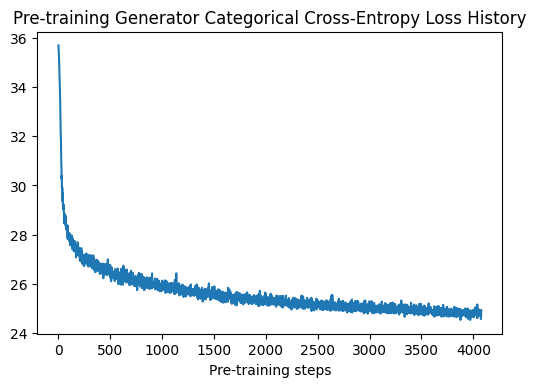

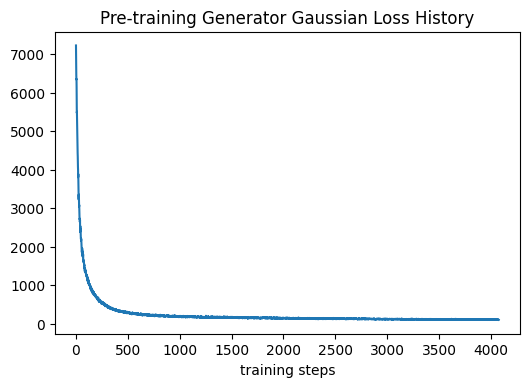

In [22]:
x = range(len(pretrain_gen_ce_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_gen_ce_loss_history)
plt.title('Pre-training Generator Categorical Cross-Entropy Loss History')
plt.xlabel('Pre-training steps')

x = range(len(pretrain_gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_gen_gaussian_loss_history)
plt.title('Pre-training Generator Gaussian Loss History')
plt.xlabel('training steps')

In [23]:
loss_save_dir = './experiment_results/long_seqs_no_gm/init_pretrained/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)
    
with open(os.path.join(loss_save_dir, 'pretrain_gen_ce_loss_history.pickle'), 'wb') as f:
    pickle.dump(pretrain_gen_ce_loss_history, f)

with open(os.path.join(loss_save_dir, 'pretrain_gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(pretrain_gen_gaussian_loss_history, f)

### Save Pretrained G

In [33]:
if not os.path.exists('./experiment_results/long_seqs_no_gm/init_pretrained/pretrained_gen_weights'):
    os.makedirs('./experiment_results/long_seqs_no_gm/init_pretrained/pretrained_gen_weights')
    
G_save_path = './experiment_results/long_seqs_no_gm/init_pretrained/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [28]:
G_save_path = './experiment_results/long_seqs_no_gm/init_pretrained/pretrained_gen_weights/model.tf'

reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)

In [29]:
reload_pretrained_gen.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(64, None, 1)]      0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (64, None, 1)        0           event_type[0][0]                 
                                                                 time_delta[0][0]                 
__________________________________________________________________________________________________
embedding_3 (Embedding)         (64, None, 1, 5)     30          masking_3[0][0]                  
__________________________________________________________________________________________________
time_delta (InputLayer)         [(64, None, 1)]      0                                      

## Pretrain D 

In [8]:
pretrain_D_et = np.concatenate([pos_event_type_seqs, neg_event_type_seqs], axis=0)
pretrain_D_ts = np.concatenate([pos_timestamp_seqs, neg_timestamp_seqs], axis=0)

pretrain_D_labels = np.concatenate([np.ones((pos_event_type_seqs.shape[0], 1)), 
                                  np.zeros((neg_event_type_seqs.shape[0], 1))
                                 ], axis=0)
pretrain_D_features = (pretrain_D_et, pretrain_D_ts)
N_pretrain_D = pretrain_D_ts.shape[0]

In [14]:
WEIGHT_GAUSSIAN_LOSS = 1e-2
OPTIMIZER = Adam(lr=1e-3)

EPOCHS = 2
_TOTAL_STEPS = int(EPOCHS * N_pretrain_D / BATCH_SIZE)
# _TOTAL_STEPS = 1000

pretrain_disc_token_loss_history = []
pretrain_disc_gaussian_loss_history = []


pretrain_D_dataset = create_dataset(pretrain_D_features,
                                  pretrain_D_labels,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_pretrain_D)

pretrained_discriminator = build_D(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

In [15]:
_TOTAL_STEPS

6250

In [16]:
step = 0

for features_batch, real_labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    disc_token_loss = pretrain_discriminator(features_batch, real_labels, pretrained_discriminator, verbose=True, 
                                                                 weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
total discriminator loss:0.6972905827045395


1it [00:00,  1.53it/s]

Training Step: 2
total discriminator loss:0.7060248477651416


2it [00:00,  1.90it/s]

Training Step: 3
total discriminator loss:0.7405971467489875


3it [00:01,  2.27it/s]

Training Step: 4
total discriminator loss:0.7364584866512602


4it [00:01,  2.61it/s]

Training Step: 5
total discriminator loss:0.6974399514820133


5it [00:01,  2.90it/s]

Training Step: 6
total discriminator loss:0.6677521943583122


6it [00:01,  2.97it/s]

Training Step: 7
total discriminator loss:0.738772309260253


7it [00:02,  3.30it/s]

Training Step: 8
total discriminator loss:0.7132481346055655


8it [00:02,  3.58it/s]

Training Step: 9
total discriminator loss:0.8053312994113568


9it [00:02,  3.79it/s]

Training Step: 10
total discriminator loss:0.7050648824915822


10it [00:02,  3.94it/s]

Training Step: 11
total discriminator loss:0.7357271442431014


11it [00:03,  4.06it/s]

Training Step: 12
total discriminator loss:0.7283772871078761


12it [00:03,  4.15it/s]

Training Step: 13
total discriminator loss:0.7121980864033581


13it [00:03,  4.17it/s]

Training Step: 14
total discriminator loss:0.7197503226309109


14it [00:03,  4.23it/s]

Training Step: 15
total discriminator loss:0.7100182342646758


15it [00:04,  4.28it/s]

Training Step: 16
total discriminator loss:0.7173723872563952


16it [00:04,  4.32it/s]

Training Step: 17
total discriminator loss:0.6919317226589945


17it [00:04,  4.33it/s]

Training Step: 18
total discriminator loss:0.6844510582511892


18it [00:04,  4.23it/s]

Training Step: 19


19it [00:05,  3.59it/s]

total discriminator loss:0.6970552853913459
Training Step: 20


20it [00:05,  3.64it/s]

total discriminator loss:0.7013525508702225
Training Step: 21


21it [00:05,  3.83it/s]

total discriminator loss:0.7025248176815049
Training Step: 22


22it [00:05,  3.96it/s]

total discriminator loss:0.6927238322072198
Training Step: 23


23it [00:06,  4.08it/s]

total discriminator loss:0.6928190873821589
Training Step: 24


24it [00:06,  4.17it/s]

total discriminator loss:0.6909088108733196
Training Step: 25


25it [00:06,  4.24it/s]

total discriminator loss:0.6883180709156098
Training Step: 26


26it [00:06,  4.27it/s]

total discriminator loss:0.686007731217759
Training Step: 27


27it [00:06,  4.27it/s]

total discriminator loss:0.6898229846346897
Training Step: 28


28it [00:07,  4.28it/s]

total discriminator loss:0.68433415148154
Training Step: 29


29it [00:07,  4.30it/s]

total discriminator loss:0.7039029880656027
Training Step: 30


30it [00:07,  4.27it/s]

total discriminator loss:0.677955843435975
Training Step: 31


31it [00:07,  4.25it/s]

total discriminator loss:0.69110340039754
Training Step: 32


32it [00:08,  4.27it/s]

total discriminator loss:0.6869686493784237
Training Step: 33


33it [00:08,  3.86it/s]

total discriminator loss:0.6844126382712443
Training Step: 34


34it [00:08,  3.93it/s]

total discriminator loss:0.6851591154451402
Training Step: 35


35it [00:08,  4.00it/s]

total discriminator loss:0.6954916124161192
Training Step: 36


36it [00:09,  4.11it/s]

total discriminator loss:0.6985064275184225
Training Step: 37


37it [00:09,  4.19it/s]

total discriminator loss:0.7140662980693698
Training Step: 38


38it [00:09,  4.24it/s]

total discriminator loss:0.7005161528867576
Training Step: 39


39it [00:09,  4.20it/s]

total discriminator loss:0.690429046772358
Training Step: 40


40it [00:10,  4.23it/s]

total discriminator loss:0.6806527607409227
Training Step: 41


41it [00:10,  4.26it/s]

total discriminator loss:0.681226912123809
Training Step: 42


42it [00:10,  4.13it/s]

total discriminator loss:0.6944142265498019
Training Step: 43


43it [00:10,  4.04it/s]

total discriminator loss:0.6800210975316369
Training Step: 44


44it [00:11,  4.11it/s]

total discriminator loss:0.6868926747177291
Training Step: 45


45it [00:11,  3.76it/s]

total discriminator loss:0.6876399441536617
Training Step: 46


46it [00:11,  3.90it/s]

total discriminator loss:0.6874357314273717
Training Step: 47


47it [00:11,  3.99it/s]

total discriminator loss:0.684638809856927
Training Step: 48


48it [00:12,  4.10it/s]

total discriminator loss:0.683844671072576
Training Step: 49


49it [00:12,  4.17it/s]

total discriminator loss:0.6876128356949652
Training Step: 50


50it [00:12,  4.17it/s]

total discriminator loss:0.682604458325601
Training Step: 51


51it [00:12,  4.20it/s]

total discriminator loss:0.6762130451125358
Training Step: 52


52it [00:13,  4.23it/s]

total discriminator loss:0.6809871040382565
Training Step: 53


53it [00:13,  4.22it/s]

total discriminator loss:0.693888781569761
Training Step: 54


54it [00:13,  4.20it/s]

total discriminator loss:0.6818044100340965
Training Step: 55


55it [00:13,  4.24it/s]

total discriminator loss:0.6945254181833511
Training Step: 56


56it [00:13,  4.27it/s]

total discriminator loss:0.6890407445231896
Training Step: 57


57it [00:14,  4.29it/s]

total discriminator loss:0.6866899417674817
Training Step: 58


58it [00:14,  4.20it/s]

total discriminator loss:0.6643777184758417
Training Step: 59


59it [00:14,  3.70it/s]

total discriminator loss:0.672589044954784
Training Step: 60


60it [00:15,  3.86it/s]

total discriminator loss:0.6753848086819771
Training Step: 61


61it [00:15,  3.99it/s]

total discriminator loss:0.6758321162697516
Training Step: 62


62it [00:15,  4.09it/s]

total discriminator loss:0.6658066413917948
Training Step: 63


63it [00:15,  4.17it/s]

total discriminator loss:0.6673219608402672
Training Step: 64


64it [00:15,  4.17it/s]

total discriminator loss:0.6613914937404565
Training Step: 65


65it [00:16,  4.17it/s]

total discriminator loss:0.6565766705539466
Training Step: 66


66it [00:16,  4.22it/s]

total discriminator loss:0.6682261269786858
Training Step: 67


67it [00:16,  4.25it/s]

total discriminator loss:0.6539650649912128
Training Step: 68


68it [00:16,  4.26it/s]

total discriminator loss:0.6550607772123405
Training Step: 69


69it [00:17,  4.26it/s]

total discriminator loss:0.6373511158447549
Training Step: 70


70it [00:17,  4.28it/s]

total discriminator loss:0.616069300459217
Training Step: 71


71it [00:17,  3.82it/s]

total discriminator loss:0.6133885991498469
Training Step: 72


72it [00:17,  3.90it/s]

total discriminator loss:0.5927210784370457
Training Step: 73


73it [00:18,  4.04it/s]

total discriminator loss:0.5673050735452576
Training Step: 74


74it [00:18,  4.13it/s]

total discriminator loss:0.5336058778913565
Training Step: 75


75it [00:18,  4.14it/s]

total discriminator loss:0.5303236662663833
Training Step: 76


76it [00:18,  4.18it/s]

total discriminator loss:0.5249413761403791
Training Step: 77


77it [00:19,  4.23it/s]

total discriminator loss:0.5263683698149733
Training Step: 78


78it [00:19,  4.18it/s]

total discriminator loss:0.42853408953319727
Training Step: 79


79it [00:19,  4.23it/s]

total discriminator loss:0.516786772535411
Training Step: 80


80it [00:19,  4.25it/s]

total discriminator loss:0.4442697660749662
Training Step: 81


81it [00:20,  4.27it/s]

total discriminator loss:0.40826560121368355
Training Step: 82


82it [00:20,  4.15it/s]

total discriminator loss:0.3690241612286914
Training Step: 83


83it [00:20,  4.07it/s]

total discriminator loss:0.4306343451848931
Training Step: 84


84it [00:20,  3.99it/s]

total discriminator loss:0.39455104660476714
Training Step: 85


85it [00:21,  3.51it/s]

total discriminator loss:0.4337859980741446
Training Step: 86


86it [00:21,  3.66it/s]

total discriminator loss:0.5030217627157081
Training Step: 87


87it [00:21,  3.77it/s]

total discriminator loss:0.4331803456422357
Training Step: 88


88it [00:21,  3.93it/s]

total discriminator loss:0.38724555577844866
Training Step: 89


89it [00:22,  4.04it/s]

total discriminator loss:0.41208738316181825
Training Step: 90


90it [00:22,  4.04it/s]

total discriminator loss:0.37774170355967984
Training Step: 91


91it [00:22,  4.12it/s]

total discriminator loss:0.40064751579842195
Training Step: 92


92it [00:22,  4.16it/s]

total discriminator loss:0.31791213326897605
Training Step: 93


93it [00:23,  4.22it/s]

total discriminator loss:0.4479329425582369
Training Step: 94


94it [00:23,  4.24it/s]

total discriminator loss:0.3608615729487067
Training Step: 95


95it [00:23,  4.19it/s]

total discriminator loss:0.34262879159194315
Training Step: 96


96it [00:23,  4.15it/s]

total discriminator loss:0.30535332886518013
Training Step: 97


97it [00:24,  3.71it/s]

total discriminator loss:0.3557888988795662
Training Step: 98


98it [00:24,  3.81it/s]

total discriminator loss:0.3622280020583388
Training Step: 99


99it [00:24,  3.95it/s]

total discriminator loss:0.49349327499119133
Training Step: 100


100it [00:24,  4.00it/s]

total discriminator loss:0.4008252327244536
Training Step: 101


101it [00:25,  4.08it/s]

total discriminator loss:0.4977978283105439
Training Step: 102


102it [00:25,  4.14it/s]

total discriminator loss:0.3680017766362981
Training Step: 103


103it [00:25,  4.20it/s]

total discriminator loss:0.3234881763186448
Training Step: 104


104it [00:25,  4.10it/s]

total discriminator loss:0.357141982061765
Training Step: 105


105it [00:26,  4.15it/s]

total discriminator loss:0.30508269020729606
Training Step: 106


106it [00:26,  4.19it/s]

total discriminator loss:0.3220733034049117
Training Step: 107


107it [00:26,  4.23it/s]

total discriminator loss:0.3493679025624548
Training Step: 108


108it [00:26,  4.24it/s]

total discriminator loss:0.4079546939425396
Training Step: 109


109it [00:26,  4.26it/s]

total discriminator loss:0.4182688086895011
Training Step: 110


110it [00:27,  4.27it/s]

total discriminator loss:0.3612768792272458
Training Step: 111


111it [00:27,  3.83it/s]

total discriminator loss:0.300322541673545
Training Step: 112


112it [00:27,  3.93it/s]

total discriminator loss:0.29603605446151066
Training Step: 113


113it [00:27,  4.04it/s]

total discriminator loss:0.4406780246432119
Training Step: 114


114it [00:28,  4.11it/s]

total discriminator loss:0.3884677312391771
Training Step: 115


115it [00:28,  4.16it/s]

total discriminator loss:0.42446829579691137
Training Step: 116


116it [00:28,  4.17it/s]

total discriminator loss:0.3786304087607312
Training Step: 117


117it [00:28,  4.21it/s]

total discriminator loss:0.30212695271493206
Training Step: 118


118it [00:29,  4.24it/s]

total discriminator loss:0.25077221995885457
Training Step: 119


119it [00:29,  4.27it/s]

total discriminator loss:0.30219565479731747
Training Step: 120


120it [00:29,  4.28it/s]

total discriminator loss:0.41993572247363486
Training Step: 121


121it [00:29,  4.27it/s]

total discriminator loss:0.38569888187692686
Training Step: 122


122it [00:30,  4.29it/s]

total discriminator loss:0.3258366911685912
Training Step: 123


123it [00:30,  3.77it/s]

total discriminator loss:0.4537908482644463
Training Step: 124


124it [00:30,  3.84it/s]

total discriminator loss:0.4457155086264415
Training Step: 125


125it [00:30,  3.88it/s]

total discriminator loss:0.32742923139267144
Training Step: 126


126it [00:31,  4.00it/s]

total discriminator loss:0.4195445051699981
Training Step: 127


127it [00:31,  4.10it/s]

total discriminator loss:0.3891857221264554
Training Step: 128


128it [00:31,  4.15it/s]

total discriminator loss:0.28562110151881814
Training Step: 129


129it [00:31,  4.19it/s]

total discriminator loss:0.4632859972359151
Training Step: 130


130it [00:32,  4.22it/s]

total discriminator loss:0.4160855548679983
Training Step: 131


131it [00:32,  4.24it/s]

total discriminator loss:0.2931826768784107
Training Step: 132


132it [00:32,  4.26it/s]

total discriminator loss:0.45317390823547365
Training Step: 133


133it [00:32,  4.27it/s]

total discriminator loss:0.4040090888628387
Training Step: 134


134it [00:33,  4.29it/s]

total discriminator loss:0.3687719796552396
Training Step: 135


135it [00:33,  4.30it/s]

total discriminator loss:0.24930684111273793
Training Step: 136


136it [00:33,  4.32it/s]

total discriminator loss:0.31069208445170327
Training Step: 137


137it [00:33,  3.85it/s]

total discriminator loss:0.3696718938979068
Training Step: 138


138it [00:34,  3.97it/s]

total discriminator loss:0.30930092566045064
Training Step: 139


139it [00:34,  4.00it/s]

total discriminator loss:0.2776164491190322
Training Step: 140


140it [00:34,  4.09it/s]

total discriminator loss:0.2539453240071614
Training Step: 141


141it [00:34,  4.14it/s]

total discriminator loss:0.2923369055169956
Training Step: 142


142it [00:34,  4.17it/s]

total discriminator loss:0.2994681854890028
Training Step: 143


143it [00:35,  4.20it/s]

total discriminator loss:0.2940516947159852
Training Step: 144


144it [00:35,  4.12it/s]

total discriminator loss:0.44860713102114536
Training Step: 145


145it [00:35,  4.08it/s]

total discriminator loss:0.40392009316487576
Training Step: 146


146it [00:35,  4.12it/s]

total discriminator loss:0.3552140994176397
Training Step: 147


147it [00:36,  4.17it/s]

total discriminator loss:0.38412224707807957
Training Step: 148


148it [00:36,  4.20it/s]

total discriminator loss:0.3353998137146663
Training Step: 149


149it [00:36,  3.79it/s]

total discriminator loss:0.3880110782862329
Training Step: 150


150it [00:36,  3.94it/s]

total discriminator loss:0.47670108267924255
Training Step: 151


151it [00:37,  4.05it/s]

total discriminator loss:0.4032068538696816
Training Step: 152


152it [00:37,  4.13it/s]

total discriminator loss:0.2816853417270013
Training Step: 153


153it [00:37,  4.18it/s]

total discriminator loss:0.47854672380111185
Training Step: 154


154it [00:37,  4.23it/s]

total discriminator loss:0.3610927084285841
Training Step: 155


155it [00:38,  4.27it/s]

total discriminator loss:0.2824813175223374
Training Step: 156


156it [00:38,  4.28it/s]

total discriminator loss:0.3207011596253084
Training Step: 157


157it [00:38,  4.21it/s]

total discriminator loss:0.321129763517251
Training Step: 158


158it [00:38,  4.21it/s]

total discriminator loss:0.3499728612876597
Training Step: 159


159it [00:39,  4.25it/s]

total discriminator loss:0.21392183646786744
Training Step: 160


160it [00:39,  4.27it/s]

total discriminator loss:0.38884611672121505
Training Step: 161


161it [00:39,  4.29it/s]

total discriminator loss:0.3200671897294752
Training Step: 162


162it [00:39,  4.25it/s]

total discriminator loss:0.2775167526936334
Training Step: 163


163it [00:40,  3.84it/s]

total discriminator loss:0.3504458334880548
Training Step: 164


164it [00:40,  3.97it/s]

total discriminator loss:0.3690532225944803
Training Step: 165


165it [00:40,  4.07it/s]

total discriminator loss:0.34862421863852955
Training Step: 166


166it [00:40,  4.07it/s]

total discriminator loss:0.2569880869620359
Training Step: 167


167it [00:41,  4.15it/s]

total discriminator loss:0.3487553420285496
Training Step: 168


168it [00:41,  4.20it/s]

total discriminator loss:0.30900605674297343
Training Step: 169


169it [00:41,  4.13it/s]

total discriminator loss:0.3641664607809344
Training Step: 170


170it [00:41,  4.17it/s]

total discriminator loss:0.3876681579819778
Training Step: 171


171it [00:41,  4.22it/s]

total discriminator loss:0.26947741547484616
Training Step: 172


172it [00:42,  4.26it/s]

total discriminator loss:0.30895384063425907
Training Step: 173


173it [00:42,  4.28it/s]

total discriminator loss:0.36576409804225873
Training Step: 174


174it [00:42,  4.21it/s]

total discriminator loss:0.40771399335564595
Training Step: 175


175it [00:43,  3.79it/s]

total discriminator loss:0.31503439546418643
Training Step: 176


176it [00:43,  3.86it/s]

total discriminator loss:0.38273052645581995
Training Step: 177


177it [00:43,  3.86it/s]

total discriminator loss:0.3863000488419802
Training Step: 178


178it [00:43,  3.87it/s]

total discriminator loss:0.3876924759111039
Training Step: 179


179it [00:44,  3.99it/s]

total discriminator loss:0.2807301703147245
Training Step: 180


180it [00:44,  4.09it/s]

total discriminator loss:0.22834463684285478
Training Step: 181


181it [00:44,  4.17it/s]

total discriminator loss:0.33524438236912235
Training Step: 182


182it [00:44,  4.11it/s]

total discriminator loss:0.348531063733227
Training Step: 183


183it [00:44,  4.10it/s]

total discriminator loss:0.32304530185350455
Training Step: 184


184it [00:45,  4.17it/s]

total discriminator loss:0.4087366870917377
Training Step: 185


185it [00:45,  4.20it/s]

total discriminator loss:0.28232866703743725
Training Step: 186


186it [00:45,  4.14it/s]

total discriminator loss:0.30718588751523657
Training Step: 187


187it [00:45,  4.19it/s]

total discriminator loss:0.31205835633482293
Training Step: 188


188it [00:46,  4.21it/s]

total discriminator loss:0.30061918241857216
Training Step: 189


189it [00:46,  3.83it/s]

total discriminator loss:0.300992041479223
Training Step: 190


190it [00:46,  3.90it/s]

total discriminator loss:0.3318263761953475
Training Step: 191


191it [00:46,  3.95it/s]

total discriminator loss:0.42548414896678
Training Step: 192


192it [00:47,  4.07it/s]

total discriminator loss:0.32436877484537585
Training Step: 193


193it [00:47,  4.15it/s]

total discriminator loss:0.23148298409685616
Training Step: 194


194it [00:47,  4.19it/s]

total discriminator loss:0.2585660611973679
Training Step: 195


195it [00:47,  4.22it/s]

total discriminator loss:0.3411491509813391
Training Step: 196


196it [00:48,  4.27it/s]

total discriminator loss:0.2812404581332614
Training Step: 197


197it [00:48,  4.20it/s]

total discriminator loss:0.30770736117723785
Training Step: 198


198it [00:48,  4.13it/s]

total discriminator loss:0.3407406551405534
Training Step: 199


199it [00:48,  4.10it/s]

total discriminator loss:0.28346842140777795
Training Step: 200


200it [00:49,  4.07it/s]

total discriminator loss:0.38237936204752226
Training Step: 201


201it [00:49,  3.65it/s]

total discriminator loss:0.32978126465236146
Training Step: 202


202it [00:49,  3.82it/s]

total discriminator loss:0.30156047674611663
Training Step: 203


203it [00:49,  3.86it/s]

total discriminator loss:0.45280875231939977
Training Step: 204


204it [00:50,  3.88it/s]

total discriminator loss:0.37670668823488807
Training Step: 205


205it [00:50,  3.99it/s]

total discriminator loss:0.32647423100589334
Training Step: 206


206it [00:50,  4.08it/s]

total discriminator loss:0.32836178134177985
Training Step: 207


207it [00:50,  4.11it/s]

total discriminator loss:0.3825443333538734
Training Step: 208


208it [00:51,  4.16it/s]

total discriminator loss:0.3554312599527568
Training Step: 209


209it [00:51,  4.19it/s]

total discriminator loss:0.3882042339911499
Training Step: 210


210it [00:51,  4.17it/s]

total discriminator loss:0.32213448629623714
Training Step: 211


211it [00:51,  4.17it/s]

total discriminator loss:0.22697895192793988
Training Step: 212


212it [00:52,  4.05it/s]

total discriminator loss:0.308269800018686
Training Step: 213


213it [00:52,  4.10it/s]

total discriminator loss:0.31200317204236105
Training Step: 214


214it [00:52,  4.14it/s]

total discriminator loss:0.3026347755563358
Training Step: 215


215it [00:52,  3.75it/s]

total discriminator loss:0.3093702424657251
Training Step: 216


216it [00:53,  3.83it/s]

total discriminator loss:0.30620223329133356
Training Step: 217


217it [00:53,  3.96it/s]

total discriminator loss:0.3038711449412541
Training Step: 218


218it [00:53,  4.07it/s]

total discriminator loss:0.2872059913047172
Training Step: 219


219it [00:53,  3.98it/s]

total discriminator loss:0.25126691644490473
Training Step: 220


220it [00:54,  4.07it/s]

total discriminator loss:0.25435769841123296
Training Step: 221


221it [00:54,  3.98it/s]

total discriminator loss:0.32384089758576284
Training Step: 222


222it [00:54,  4.02it/s]

total discriminator loss:0.4784819651393405
Training Step: 223


223it [00:54,  4.06it/s]

total discriminator loss:0.3546059414157101
Training Step: 224


224it [00:55,  4.14it/s]

total discriminator loss:0.28826697652504674
Training Step: 225


225it [00:55,  4.19it/s]

total discriminator loss:0.37141735959402356
Training Step: 226


226it [00:55,  4.22it/s]

total discriminator loss:0.4401214030671703
Training Step: 227


227it [00:55,  3.80it/s]

total discriminator loss:0.3909848700743387
Training Step: 228


228it [00:56,  3.85it/s]

total discriminator loss:0.24121454789817154
Training Step: 229


229it [00:56,  3.83it/s]

total discriminator loss:0.38621358296127606
Training Step: 230


230it [00:56,  3.94it/s]

total discriminator loss:0.4393194376258603
Training Step: 231


231it [00:56,  4.00it/s]

total discriminator loss:0.3299350088893209
Training Step: 232


232it [00:57,  4.09it/s]

total discriminator loss:0.3390366652294774
Training Step: 233


233it [00:57,  4.16it/s]

total discriminator loss:0.48574523223627414
Training Step: 234


234it [00:57,  4.20it/s]

total discriminator loss:0.2416393266404435
Training Step: 235


235it [00:57,  4.07it/s]

total discriminator loss:0.4132799673005745
Training Step: 236


236it [00:58,  4.08it/s]

total discriminator loss:0.3298249342587578
Training Step: 237


237it [00:58,  4.13it/s]

total discriminator loss:0.32493966362572935
Training Step: 238


238it [00:58,  4.19it/s]

total discriminator loss:0.39914266080948435
Training Step: 239


239it [00:58,  4.19it/s]

total discriminator loss:0.3815483508988359
Training Step: 240


240it [00:59,  4.23it/s]

total discriminator loss:0.35869375948317894
Training Step: 241


241it [00:59,  3.78it/s]

total discriminator loss:0.3771248985372839
Training Step: 242


242it [00:59,  3.93it/s]

total discriminator loss:0.37886702734348476
Training Step: 243


243it [00:59,  4.00it/s]

total discriminator loss:0.2705040848012248
Training Step: 244


244it [01:00,  4.09it/s]

total discriminator loss:0.317653601911739
Training Step: 245


245it [01:00,  4.16it/s]

total discriminator loss:0.4577768067997202
Training Step: 246


246it [01:00,  4.21it/s]

total discriminator loss:0.2657842924302293
Training Step: 247


247it [01:00,  4.17it/s]

total discriminator loss:0.4567493055421511
Training Step: 248


248it [01:00,  4.21it/s]

total discriminator loss:0.3971030099800441
Training Step: 249


249it [01:01,  4.23it/s]

total discriminator loss:0.38573477156268265
Training Step: 250


250it [01:01,  4.25it/s]

total discriminator loss:0.27148822335505096
Training Step: 251


251it [01:01,  4.26it/s]

total discriminator loss:0.2972240098487877
Training Step: 252


252it [01:01,  4.27it/s]

total discriminator loss:0.34211619929863224
Training Step: 253


253it [01:02,  3.78it/s]

total discriminator loss:0.3035134601106973
Training Step: 254


254it [01:02,  3.92it/s]

total discriminator loss:0.2924756989271562
Training Step: 255


255it [01:02,  4.04it/s]

total discriminator loss:0.37725225643812466
Training Step: 256


256it [01:02,  4.10it/s]

total discriminator loss:0.3791136763691568
Training Step: 257


257it [01:03,  4.15it/s]

total discriminator loss:0.2760037344423334
Training Step: 258


258it [01:03,  4.20it/s]

total discriminator loss:0.3250183482364374
Training Step: 259


259it [01:03,  4.23it/s]

total discriminator loss:0.31578194563945067
Training Step: 260


260it [01:03,  4.24it/s]

total discriminator loss:0.3170139101155304
Training Step: 261


261it [01:04,  4.19it/s]

total discriminator loss:0.2659544089608973
Training Step: 262


262it [01:04,  4.22it/s]

total discriminator loss:0.4521640877552333
Training Step: 263


263it [01:04,  4.24it/s]

total discriminator loss:0.3296738953281885
Training Step: 264


264it [01:04,  4.25it/s]

total discriminator loss:0.14746463717652913
Training Step: 265


265it [01:05,  4.28it/s]

total discriminator loss:0.27514477350268035
Training Step: 266


266it [01:05,  4.31it/s]

total discriminator loss:0.4740495527500954
Training Step: 267


267it [01:05,  3.89it/s]

total discriminator loss:0.19706306421475936
Training Step: 268


268it [01:05,  3.98it/s]

total discriminator loss:0.37238128943649546
Training Step: 269


269it [01:06,  4.07it/s]

total discriminator loss:0.44356807982144186
Training Step: 270


270it [01:06,  4.14it/s]

total discriminator loss:0.2797180317176277
Training Step: 271


271it [01:06,  4.17it/s]

total discriminator loss:0.3060732829387912
Training Step: 272


272it [01:06,  4.18it/s]

total discriminator loss:0.42478834683647804
Training Step: 273


273it [01:07,  4.18it/s]

total discriminator loss:0.16505752931891848
Training Step: 274


274it [01:07,  4.22it/s]

total discriminator loss:0.5057751972443301
Training Step: 275


275it [01:07,  4.24it/s]

total discriminator loss:0.3485350575125511
Training Step: 276


276it [01:07,  4.25it/s]

total discriminator loss:0.4148768586034185
Training Step: 277


277it [01:07,  4.21it/s]

total discriminator loss:0.2839276087221035
Training Step: 278


278it [01:08,  4.21it/s]

total discriminator loss:0.25430116612774156
Training Step: 279


279it [01:08,  3.78it/s]

total discriminator loss:0.2168281329123401
Training Step: 280


280it [01:08,  3.91it/s]

total discriminator loss:0.29972114165248614
Training Step: 281


281it [01:09,  3.97it/s]

total discriminator loss:0.37655090803618163
Training Step: 282


282it [01:09,  4.02it/s]

total discriminator loss:0.3916461016528441
Training Step: 283


283it [01:09,  4.11it/s]

total discriminator loss:0.3338062961377545
Training Step: 284


284it [01:09,  4.15it/s]

total discriminator loss:0.24649795207808017
Training Step: 285


285it [01:09,  4.15it/s]

total discriminator loss:0.34253279044150076
Training Step: 286


286it [01:10,  4.09it/s]

total discriminator loss:0.2707664718114293
Training Step: 287


287it [01:10,  4.16it/s]

total discriminator loss:0.3232025735765246
Training Step: 288


288it [01:10,  4.18it/s]

total discriminator loss:0.2956974208534061
Training Step: 289


289it [01:10,  4.22it/s]

total discriminator loss:0.31682424417810184
Training Step: 290


290it [01:11,  4.24it/s]

total discriminator loss:0.21838108831352226
Training Step: 291


291it [01:11,  4.25it/s]

total discriminator loss:0.33680643378912123
Training Step: 292


292it [01:11,  4.27it/s]

total discriminator loss:0.28692102730565217
Training Step: 293


293it [01:11,  3.85it/s]

total discriminator loss:0.4247832736279904
Training Step: 294


294it [01:12,  3.98it/s]

total discriminator loss:0.21430765913329686
Training Step: 295


295it [01:12,  4.08it/s]

total discriminator loss:0.289396666704163
Training Step: 296


296it [01:12,  4.15it/s]

total discriminator loss:0.31626178633543683
Training Step: 297


297it [01:12,  4.18it/s]

total discriminator loss:0.3108497668762459
Training Step: 298


298it [01:13,  4.22it/s]

total discriminator loss:0.2848832926818457
Training Step: 299


299it [01:13,  4.25it/s]

total discriminator loss:0.35546485007979645
Training Step: 300


300it [01:13,  4.29it/s]

total discriminator loss:0.33139264060548845
Training Step: 301


301it [01:13,  4.21it/s]

total discriminator loss:0.27885867353518207
Training Step: 302


302it [01:14,  4.13it/s]

total discriminator loss:0.24440962707222086
Training Step: 303


303it [01:14,  4.13it/s]

total discriminator loss:0.3065090458391301
Training Step: 304


304it [01:14,  4.19it/s]

total discriminator loss:0.26226023581389957
Training Step: 305


305it [01:14,  3.77it/s]

total discriminator loss:0.4167267124812598
Training Step: 306


306it [01:15,  3.92it/s]

total discriminator loss:0.3357857269405986
Training Step: 307


307it [01:15,  4.04it/s]

total discriminator loss:0.2179541812284855
Training Step: 308


308it [01:15,  4.07it/s]

total discriminator loss:0.3350408828589735
Training Step: 309


309it [01:15,  4.03it/s]

total discriminator loss:0.3595386090941953
Training Step: 310


310it [01:16,  4.11it/s]

total discriminator loss:0.30425433799026713
Training Step: 311


311it [01:16,  4.16it/s]

total discriminator loss:0.3383471400178097
Training Step: 312


312it [01:16,  4.10it/s]

total discriminator loss:0.3921907858139613
Training Step: 313


313it [01:16,  4.15it/s]

total discriminator loss:0.33514235366270073
Training Step: 314


314it [01:16,  4.19it/s]

total discriminator loss:0.3252881637904408
Training Step: 315


315it [01:17,  4.23it/s]

total discriminator loss:0.36872070370733423
Training Step: 316


316it [01:17,  4.22it/s]

total discriminator loss:0.26946885444551466
Training Step: 317


317it [01:17,  4.22it/s]

total discriminator loss:0.26426034383339847
Training Step: 318


318it [01:17,  4.16it/s]

total discriminator loss:0.3399823768862658
Training Step: 319


319it [01:18,  3.70it/s]

total discriminator loss:0.24010750628578176
Training Step: 320


320it [01:18,  3.87it/s]

total discriminator loss:0.323992937018131
Training Step: 321


321it [01:18,  3.96it/s]

total discriminator loss:0.33158299974210564
Training Step: 322


322it [01:19,  3.97it/s]

total discriminator loss:0.40444300505602926
Training Step: 323


323it [01:19,  3.92it/s]

total discriminator loss:0.33850104992410157
Training Step: 324


324it [01:19,  3.87it/s]

total discriminator loss:0.3580568075877525
Training Step: 325


325it [01:19,  3.94it/s]

total discriminator loss:0.2676135351598765
Training Step: 326


326it [01:20,  4.04it/s]

total discriminator loss:0.33142206797768886
Training Step: 327


327it [01:20,  4.12it/s]

total discriminator loss:0.34382686584664257
Training Step: 328


328it [01:20,  4.18it/s]

total discriminator loss:0.3423873511153411
Training Step: 329


329it [01:20,  4.18it/s]

total discriminator loss:0.305327278819852
Training Step: 330


330it [01:20,  4.08it/s]

total discriminator loss:0.22788827224620983
Training Step: 331


331it [01:21,  3.37it/s]

total discriminator loss:0.39755552553426743
Training Step: 332


332it [01:21,  3.51it/s]

total discriminator loss:0.2734811210279371
Training Step: 333


333it [01:21,  3.60it/s]

total discriminator loss:0.4868514975933371
Training Step: 334


334it [01:22,  3.75it/s]

total discriminator loss:0.38085475407464586
Training Step: 335


335it [01:22,  3.90it/s]

total discriminator loss:0.32748837632923467
Training Step: 336


336it [01:22,  4.01it/s]

total discriminator loss:0.24786118333099516
Training Step: 337


337it [01:22,  4.07it/s]

total discriminator loss:0.4067652391795131
Training Step: 338


338it [01:23,  4.14it/s]

total discriminator loss:0.30418529127179905
Training Step: 339


339it [01:23,  4.18it/s]

total discriminator loss:0.32108815106060495
Training Step: 340


340it [01:23,  4.14it/s]

total discriminator loss:0.35590801591329874
Training Step: 341


341it [01:23,  4.17it/s]

total discriminator loss:0.28757889431740946
Training Step: 342


342it [01:24,  4.21it/s]

total discriminator loss:0.3641976718118579
Training Step: 343


343it [01:24,  4.16it/s]

total discriminator loss:0.33542644108016895
Training Step: 344


344it [01:24,  4.12it/s]

total discriminator loss:0.2503763157979257
Training Step: 345


345it [01:24,  3.68it/s]

total discriminator loss:0.2152851581569269
Training Step: 346


346it [01:25,  3.84it/s]

total discriminator loss:0.21538066607724193
Training Step: 347


347it [01:25,  3.97it/s]

total discriminator loss:0.3507056464811925
Training Step: 348


348it [01:25,  4.06it/s]

total discriminator loss:0.29655493050175485
Training Step: 349


349it [01:25,  4.12it/s]

total discriminator loss:0.252992152620853
Training Step: 350


350it [01:26,  4.18it/s]

total discriminator loss:0.4501993622901882
Training Step: 351


351it [01:26,  4.19it/s]

total discriminator loss:0.31277370075055555
Training Step: 352


352it [01:26,  4.23it/s]

total discriminator loss:0.2984100492226494
Training Step: 353


353it [01:26,  4.16it/s]

total discriminator loss:0.3218270409957885
Training Step: 354


354it [01:26,  4.11it/s]

total discriminator loss:0.331926996474364
Training Step: 355


355it [01:27,  4.17it/s]

total discriminator loss:0.3947873366464442
Training Step: 356


356it [01:27,  4.22it/s]

total discriminator loss:0.22625161071849142
Training Step: 357


357it [01:27,  3.78it/s]

total discriminator loss:0.2739186019284366
Training Step: 358


358it [01:28,  3.92it/s]

total discriminator loss:0.3124353133154173
Training Step: 359


359it [01:28,  4.04it/s]

total discriminator loss:0.2593804535637148
Training Step: 360


360it [01:28,  4.12it/s]

total discriminator loss:0.23973562709284008
Training Step: 361


361it [01:28,  4.10it/s]

total discriminator loss:0.4157598004529259
Training Step: 362


362it [01:28,  4.10it/s]

total discriminator loss:0.2042418278166025
Training Step: 363


363it [01:29,  4.16it/s]

total discriminator loss:0.2826429871431434
Training Step: 364


364it [01:29,  4.16it/s]

total discriminator loss:0.2361461308483191
Training Step: 365


365it [01:29,  4.19it/s]

total discriminator loss:0.21063555250140603
Training Step: 366


366it [01:29,  4.19it/s]

total discriminator loss:0.2719784299030656
Training Step: 367


367it [01:30,  4.17it/s]

total discriminator loss:0.38335864175327483
Training Step: 368


368it [01:30,  4.12it/s]

total discriminator loss:0.28842007264392405
Training Step: 369


369it [01:30,  4.10it/s]

total discriminator loss:0.26137137296491736
Training Step: 370


370it [01:30,  4.11it/s]

total discriminator loss:0.32885823936342745
Training Step: 371


371it [01:31,  3.76it/s]

total discriminator loss:0.21651475329837633
Training Step: 372


372it [01:31,  3.89it/s]

total discriminator loss:0.30256352642052514
Training Step: 373


373it [01:31,  3.96it/s]

total discriminator loss:0.3412199603526964
Training Step: 374


374it [01:31,  3.92it/s]

total discriminator loss:0.24814554039574316
Training Step: 375


375it [01:32,  3.90it/s]

total discriminator loss:0.2426124472278252
Training Step: 376


376it [01:32,  3.95it/s]

total discriminator loss:0.3593618845833354
Training Step: 377


377it [01:32,  4.03it/s]

total discriminator loss:0.2942218905788009
Training Step: 378


378it [01:32,  4.09it/s]

total discriminator loss:0.3328317335274164
Training Step: 379


379it [01:33,  4.15it/s]

total discriminator loss:0.21396454372545373
Training Step: 380


380it [01:33,  4.17it/s]

total discriminator loss:0.33114576166381204
Training Step: 381


381it [01:33,  4.12it/s]

total discriminator loss:0.3246397003520279
Training Step: 382


382it [01:33,  4.08it/s]

total discriminator loss:0.3125948133577231
Training Step: 383


383it [01:34,  3.70it/s]

total discriminator loss:0.28355972442971833
Training Step: 384


384it [01:34,  3.82it/s]

total discriminator loss:0.33245871841452623
Training Step: 385


385it [01:34,  3.95it/s]

total discriminator loss:0.32848477172202983
Training Step: 386


386it [01:34,  3.99it/s]

total discriminator loss:0.34777511818795187
Training Step: 387


387it [01:35,  4.08it/s]

total discriminator loss:0.2508325227503311
Training Step: 388


388it [01:35,  4.14it/s]

total discriminator loss:0.2334950573367854
Training Step: 389


389it [01:35,  4.10it/s]

total discriminator loss:0.28445811831806334
Training Step: 390


390it [01:35,  4.14it/s]

total discriminator loss:0.2617120113483975
Training Step: 391


391it [01:36,  4.10it/s]

total discriminator loss:0.27851901210440955
Training Step: 392


392it [01:36,  4.10it/s]

total discriminator loss:0.24185190989229133
Training Step: 393


393it [01:36,  4.12it/s]

total discriminator loss:0.4575928909879212
Training Step: 394


394it [01:36,  4.15it/s]

total discriminator loss:0.4732757525859409
Training Step: 395


395it [01:37,  4.19it/s]

total discriminator loss:0.31445160065021
Training Step: 396


396it [01:37,  4.19it/s]

total discriminator loss:0.2913639906829629
Training Step: 397


397it [01:37,  3.77it/s]

total discriminator loss:0.3577196624129573
Training Step: 398


398it [01:37,  3.86it/s]

total discriminator loss:0.2601040835890318
Training Step: 399


399it [01:38,  3.99it/s]

total discriminator loss:0.374776205067177
Training Step: 400


400it [01:38,  4.09it/s]

total discriminator loss:0.351996136276939
Training Step: 401


401it [01:38,  4.14it/s]

total discriminator loss:0.4309747756997898
Training Step: 402


402it [01:38,  4.06it/s]

total discriminator loss:0.35132020732884417
Training Step: 403


403it [01:39,  4.07it/s]

total discriminator loss:0.25810975205619624
Training Step: 404


404it [01:39,  4.07it/s]

total discriminator loss:0.22770401128289813
Training Step: 405


405it [01:39,  4.09it/s]

total discriminator loss:0.1870508228977999
Training Step: 406


406it [01:39,  4.10it/s]

total discriminator loss:0.20840358336936493
Training Step: 407


407it [01:40,  4.18it/s]

total discriminator loss:0.2601482357763151
Training Step: 408


408it [01:40,  4.23it/s]

total discriminator loss:0.3004643226002067
Training Step: 409


409it [01:40,  3.75it/s]

total discriminator loss:0.22094367083321206
Training Step: 410


410it [01:40,  3.87it/s]

total discriminator loss:0.2648864699812442
Training Step: 411


411it [01:41,  3.99it/s]

total discriminator loss:0.28285399606097084
Training Step: 412


412it [01:41,  4.02it/s]

total discriminator loss:0.2445546167363605
Training Step: 413


413it [01:41,  4.09it/s]

total discriminator loss:0.29178587925755983
Training Step: 414


414it [01:41,  4.14it/s]

total discriminator loss:0.2435428032688455
Training Step: 415


415it [01:42,  4.18it/s]

total discriminator loss:0.30618595024003664
Training Step: 416


416it [01:42,  4.21it/s]

total discriminator loss:0.31967104559016074
Training Step: 417


417it [01:42,  4.23it/s]

total discriminator loss:0.32510665588039367
Training Step: 418


418it [01:42,  4.20it/s]

total discriminator loss:0.3400069578903784
Training Step: 419


419it [01:43,  4.22it/s]

total discriminator loss:0.26026117763878565
Training Step: 420


420it [01:43,  4.26it/s]

total discriminator loss:0.24480570938978358
Training Step: 421


421it [01:43,  4.29it/s]

total discriminator loss:0.19191035629509468
Training Step: 422


422it [01:43,  4.29it/s]

total discriminator loss:0.42952878468331607
Training Step: 423


423it [01:44,  3.86it/s]

total discriminator loss:0.26497977165193826
Training Step: 424


424it [01:44,  3.99it/s]

total discriminator loss:0.2691971380613105
Training Step: 425


425it [01:44,  4.08it/s]

total discriminator loss:0.3005330168955403
Training Step: 426


426it [01:44,  4.16it/s]

total discriminator loss:0.24331311357325988
Training Step: 427


427it [01:44,  4.21it/s]

total discriminator loss:0.2532148010142524
Training Step: 428


428it [01:45,  4.24it/s]

total discriminator loss:0.2201644183497715
Training Step: 429


429it [01:45,  4.11it/s]

total discriminator loss:0.3628985729666307
Training Step: 430


430it [01:45,  4.13it/s]

total discriminator loss:0.21743219045891646
Training Step: 431


431it [01:45,  4.19it/s]

total discriminator loss:0.17961386605897842
Training Step: 432


432it [01:46,  4.21it/s]

total discriminator loss:0.25915302189706496
Training Step: 433


433it [01:46,  4.08it/s]

total discriminator loss:0.40863725248098187
Training Step: 434


434it [01:46,  4.04it/s]

total discriminator loss:0.24847172675206888
Training Step: 435


435it [01:46,  3.68it/s]

total discriminator loss:0.19881655057887798
Training Step: 436


436it [01:47,  3.83it/s]

total discriminator loss:0.12348991572226055
Training Step: 437


437it [01:47,  3.96it/s]

total discriminator loss:0.21874447871231842
Training Step: 438


438it [01:47,  4.03it/s]

total discriminator loss:0.2538297424586369
Training Step: 439


439it [01:47,  4.06it/s]

total discriminator loss:0.2731297381249077
Training Step: 440


440it [01:48,  4.13it/s]

total discriminator loss:0.3213024001352951
Training Step: 441


441it [01:48,  4.15it/s]

total discriminator loss:0.26280219424037393
Training Step: 442


442it [01:48,  4.18it/s]

total discriminator loss:0.23707199310821925
Training Step: 443


443it [01:48,  4.18it/s]

total discriminator loss:0.253980394106578
Training Step: 444


444it [01:49,  4.14it/s]

total discriminator loss:0.2620084656965813
Training Step: 445


445it [01:49,  4.05it/s]

total discriminator loss:0.2954816766110294
Training Step: 446


446it [01:49,  3.98it/s]

total discriminator loss:0.3228326347596231
Training Step: 447


447it [01:49,  3.92it/s]

total discriminator loss:0.21201419043893932
Training Step: 448


448it [01:50,  3.97it/s]

total discriminator loss:0.343259146404721
Training Step: 449


449it [01:50,  3.66it/s]

total discriminator loss:0.34546338280171884
Training Step: 450


450it [01:50,  3.82it/s]

total discriminator loss:0.20354536619233085
Training Step: 451


451it [01:50,  3.81it/s]

total discriminator loss:0.29004908127710116
Training Step: 452


452it [01:51,  3.87it/s]

total discriminator loss:0.3416762908309384
Training Step: 453


453it [01:51,  3.84it/s]

total discriminator loss:0.21888343644278596
Training Step: 454


454it [01:51,  3.83it/s]

total discriminator loss:0.2905203957834915
Training Step: 455


455it [01:52,  3.87it/s]

total discriminator loss:0.24252649236517518
Training Step: 456


456it [01:52,  3.95it/s]

total discriminator loss:0.2776587301510052
Training Step: 457


457it [01:52,  3.99it/s]

total discriminator loss:0.344215866627945
Training Step: 458


458it [01:52,  4.07it/s]

total discriminator loss:0.21421006622695932
Training Step: 459


459it [01:52,  4.11it/s]

total discriminator loss:0.4237821863022832
Training Step: 460


460it [01:53,  4.09it/s]

total discriminator loss:0.22415852026112398
Training Step: 461


461it [01:53,  3.41it/s]

total discriminator loss:0.20736434423314293
Training Step: 462


462it [01:53,  3.50it/s]

total discriminator loss:0.3145733260408006
Training Step: 463


463it [01:54,  3.65it/s]

total discriminator loss:0.36742033204646685
Training Step: 464


464it [01:54,  3.79it/s]

total discriminator loss:0.2940671872789104
Training Step: 465


465it [01:54,  3.85it/s]

total discriminator loss:0.1610866950788689
Training Step: 466


466it [01:54,  3.91it/s]

total discriminator loss:0.441392893483768
Training Step: 467


467it [01:55,  3.92it/s]

total discriminator loss:0.3064431399214904
Training Step: 468


468it [01:55,  4.03it/s]

total discriminator loss:0.11530256943568121
Training Step: 469


469it [01:55,  4.11it/s]

total discriminator loss:0.41099821771552547
Training Step: 470


470it [01:55,  4.08it/s]

total discriminator loss:0.4291927535723504
Training Step: 471


471it [01:56,  4.16it/s]

total discriminator loss:0.3216635570937101
Training Step: 472


472it [01:56,  4.20it/s]

total discriminator loss:0.15837064369279072
Training Step: 473


473it [01:56,  4.19it/s]

total discriminator loss:0.14204323009833386
Training Step: 474


474it [01:56,  4.08it/s]

total discriminator loss:0.22376779848449468
Training Step: 475


475it [01:57,  3.47it/s]

total discriminator loss:0.22158580648303727
Training Step: 476


476it [01:57,  3.63it/s]

total discriminator loss:0.21041017905877318
Training Step: 477


477it [01:57,  3.81it/s]

total discriminator loss:0.20948640742972802
Training Step: 478


478it [01:57,  3.95it/s]

total discriminator loss:0.2539383184150905
Training Step: 479


479it [01:58,  4.05it/s]

total discriminator loss:0.291762201528622
Training Step: 480


480it [01:58,  4.14it/s]

total discriminator loss:0.22973444745237723
Training Step: 481


481it [01:58,  4.19it/s]

total discriminator loss:0.18978766164534916
Training Step: 482


482it [01:58,  4.16it/s]

total discriminator loss:0.30691474346529524
Training Step: 483


483it [01:59,  4.19it/s]

total discriminator loss:0.2949396277118593
Training Step: 484


484it [01:59,  4.24it/s]

total discriminator loss:0.24508666043414817
Training Step: 485


485it [01:59,  4.27it/s]

total discriminator loss:0.2169741386531252
Training Step: 486


486it [01:59,  4.29it/s]

total discriminator loss:0.21875494711536647
Training Step: 487


487it [02:00,  3.79it/s]

total discriminator loss:0.20356125393168364
Training Step: 488


488it [02:00,  3.93it/s]

total discriminator loss:0.3579347024948636
Training Step: 489


489it [02:00,  4.04it/s]

total discriminator loss:0.25515652970259506
Training Step: 490


490it [02:00,  4.03it/s]

total discriminator loss:0.2117770431602885
Training Step: 491


491it [02:01,  4.10it/s]

total discriminator loss:0.1601015678622797
Training Step: 492


492it [02:01,  4.15it/s]

total discriminator loss:0.20890936142155653
Training Step: 493


493it [02:01,  4.19it/s]

total discriminator loss:0.29681346629269645
Training Step: 494


494it [02:01,  4.14it/s]

total discriminator loss:0.1731454705664041
Training Step: 495


495it [02:01,  4.20it/s]

total discriminator loss:0.19882645598413062
Training Step: 496


496it [02:02,  4.08it/s]

total discriminator loss:0.3053043949971618
Training Step: 497


497it [02:02,  4.03it/s]

total discriminator loss:0.2495798241902122
Training Step: 498


498it [02:02,  4.08it/s]

total discriminator loss:0.21628152741361686
Training Step: 499


499it [02:02,  4.13it/s]

total discriminator loss:0.529861675389463
Training Step: 500


500it [02:03,  4.19it/s]

total discriminator loss:0.21961449889985477
Training Step: 501


501it [02:03,  3.74it/s]

total discriminator loss:0.14017201528026518
Training Step: 502


502it [02:03,  3.84it/s]

total discriminator loss:0.3037938824180533
Training Step: 503


503it [02:04,  3.97it/s]

total discriminator loss:0.2137440027242385
Training Step: 504


504it [02:04,  4.06it/s]

total discriminator loss:0.3279179871572322
Training Step: 505


505it [02:04,  4.08it/s]

total discriminator loss:0.23024810357955244
Training Step: 506


506it [02:04,  4.03it/s]

total discriminator loss:0.4572241979307935
Training Step: 507


507it [02:04,  4.02it/s]

total discriminator loss:0.2761280884794803
Training Step: 508


508it [02:05,  4.04it/s]

total discriminator loss:0.24714597894225437
Training Step: 509


509it [02:05,  4.12it/s]

total discriminator loss:0.1925996837291989
Training Step: 510


510it [02:05,  4.17it/s]

total discriminator loss:0.29244060783304826
Training Step: 511


511it [02:05,  4.16it/s]

total discriminator loss:0.3261516713582733
Training Step: 512


512it [02:06,  4.20it/s]

total discriminator loss:0.3869163268150939
Training Step: 513


513it [02:06,  3.80it/s]

total discriminator loss:0.26254506100012137
Training Step: 514


514it [02:06,  3.91it/s]

total discriminator loss:0.2525926816719863
Training Step: 515


515it [02:06,  3.95it/s]

total discriminator loss:0.27639334605106247
Training Step: 516


516it [02:07,  4.04it/s]

total discriminator loss:0.30525795126060773
Training Step: 517


517it [02:07,  4.13it/s]

total discriminator loss:0.2900628420773458
Training Step: 518


518it [02:07,  4.19it/s]

total discriminator loss:0.20066325552670228
Training Step: 519


519it [02:07,  4.21it/s]

total discriminator loss:0.1888578439227782
Training Step: 520


520it [02:08,  4.24it/s]

total discriminator loss:0.24519920704853265
Training Step: 521


521it [02:08,  4.25it/s]

total discriminator loss:0.17316628361962783
Training Step: 522


522it [02:08,  4.26it/s]

total discriminator loss:0.33591941452844476
Training Step: 523


523it [02:08,  4.22it/s]

total discriminator loss:0.13950180024598458
Training Step: 524


524it [02:09,  4.23it/s]

total discriminator loss:0.28026816786015385
Training Step: 525


525it [02:09,  4.25it/s]

total discriminator loss:0.32884081668822884
Training Step: 526


526it [02:09,  4.26it/s]

total discriminator loss:0.13655808973467007
Training Step: 527


527it [02:09,  3.78it/s]

total discriminator loss:0.23332306202877204
Training Step: 528


528it [02:10,  3.79it/s]

total discriminator loss:0.32041044597731777
Training Step: 529


529it [02:10,  3.91it/s]

total discriminator loss:0.4140451569469312
Training Step: 530


530it [02:10,  4.02it/s]

total discriminator loss:0.2773336973889461
Training Step: 531


531it [02:10,  4.03it/s]

total discriminator loss:0.33350430508042345
Training Step: 532


532it [02:11,  4.10it/s]

total discriminator loss:0.2160654299409419
Training Step: 533


533it [02:11,  4.10it/s]

total discriminator loss:0.3620029763620135
Training Step: 534


534it [02:11,  4.10it/s]

total discriminator loss:0.23597482264318842
Training Step: 535


535it [02:11,  4.15it/s]

total discriminator loss:0.33478888562448195
Training Step: 536


536it [02:12,  4.15it/s]

total discriminator loss:0.32208285604390285
Training Step: 537


537it [02:12,  4.19it/s]

total discriminator loss:0.37850595082782157
Training Step: 538


538it [02:12,  4.21it/s]

total discriminator loss:0.3563244206831402
Training Step: 539


539it [02:12,  3.77it/s]

total discriminator loss:0.3355666847215256
Training Step: 540


540it [02:13,  3.81it/s]

total discriminator loss:0.31702299068148876
Training Step: 541


541it [02:13,  3.91it/s]

total discriminator loss:0.2845626196181866
Training Step: 542


542it [02:13,  4.02it/s]

total discriminator loss:0.32900792643315335
Training Step: 543


543it [02:13,  4.09it/s]

total discriminator loss:0.25650291501971056
Training Step: 544


544it [02:14,  4.16it/s]

total discriminator loss:0.30878909325285475
Training Step: 545


545it [02:14,  4.21it/s]

total discriminator loss:0.29911577775692855
Training Step: 546


546it [02:14,  4.24it/s]

total discriminator loss:0.34527862480197624
Training Step: 547


547it [02:14,  4.12it/s]

total discriminator loss:0.3742568725762391
Training Step: 548


548it [02:15,  4.07it/s]

total discriminator loss:0.3226068326693311
Training Step: 549


549it [02:15,  4.03it/s]

total discriminator loss:0.29396063514335785
Training Step: 550


550it [02:15,  3.99it/s]

total discriminator loss:0.32102104487233535
Training Step: 551


551it [02:15,  4.04it/s]

total discriminator loss:0.279481895822155
Training Step: 552


552it [02:16,  4.01it/s]

total discriminator loss:0.3284324918853545
Training Step: 553


553it [02:16,  3.69it/s]

total discriminator loss:0.3876437535253021
Training Step: 554


554it [02:16,  3.85it/s]

total discriminator loss:0.2637830259051286
Training Step: 555


555it [02:16,  3.96it/s]

total discriminator loss:0.31376899511513734
Training Step: 556


556it [02:17,  4.07it/s]

total discriminator loss:0.41406110567862286
Training Step: 557


557it [02:17,  4.04it/s]

total discriminator loss:0.17743698337726246
Training Step: 558


558it [02:17,  3.93it/s]

total discriminator loss:0.21811437446096896
Training Step: 559


559it [02:17,  3.98it/s]

total discriminator loss:0.16825277100128816
Training Step: 560


560it [02:18,  4.08it/s]

total discriminator loss:0.18643757388086335
Training Step: 561


561it [02:18,  4.14it/s]

total discriminator loss:0.17477468193879916
Training Step: 562


562it [02:18,  4.08it/s]

total discriminator loss:0.26062389951730985
Training Step: 563


563it [02:18,  4.08it/s]

total discriminator loss:0.14705817974957763
Training Step: 564


564it [02:19,  4.13it/s]

total discriminator loss:0.1232082212035852
Training Step: 565


565it [02:19,  3.75it/s]

total discriminator loss:0.1581990602147385
Training Step: 566


566it [02:19,  3.84it/s]

total discriminator loss:0.11970116001858097
Training Step: 567


567it [02:19,  3.95it/s]

total discriminator loss:0.21424869875033054
Training Step: 568


568it [02:20,  4.05it/s]

total discriminator loss:0.11912140551253433
Training Step: 569


569it [02:20,  4.01it/s]

total discriminator loss:0.11717901911678782
Training Step: 570


570it [02:20,  4.09it/s]

total discriminator loss:0.15479989436118513
Training Step: 571


571it [02:20,  4.07it/s]

total discriminator loss:0.30624041140065444
Training Step: 572


572it [02:21,  4.13it/s]

total discriminator loss:0.22801738133612134
Training Step: 573


573it [02:21,  4.13it/s]

total discriminator loss:0.13687881805660362
Training Step: 574


574it [02:21,  4.01it/s]

total discriminator loss:0.2347258936153536
Training Step: 575


575it [02:21,  3.97it/s]

total discriminator loss:0.0901960961634381
Training Step: 576


576it [02:22,  4.06it/s]

total discriminator loss:0.10437009462596987
Training Step: 577


577it [02:22,  4.08it/s]

total discriminator loss:0.13989699354429042
Training Step: 578


578it [02:22,  4.02it/s]

total discriminator loss:0.07117960338427644
Training Step: 579


579it [02:22,  3.65it/s]

total discriminator loss:0.015781098279465437
Training Step: 580


580it [02:23,  3.82it/s]

total discriminator loss:0.08740043040362545
Training Step: 581


581it [02:23,  3.96it/s]

total discriminator loss:0.18760100824627057
Training Step: 582


582it [02:23,  3.97it/s]

total discriminator loss:0.3013680522734321
Training Step: 583


583it [02:23,  4.06it/s]

total discriminator loss:0.2889258623509258
Training Step: 584


584it [02:24,  4.13it/s]

total discriminator loss:0.1973367392745915
Training Step: 585


585it [02:24,  4.18it/s]

total discriminator loss:0.06911354163443739
Training Step: 586


586it [02:24,  4.22it/s]

total discriminator loss:0.05854671693390921
Training Step: 587


587it [02:24,  4.05it/s]

total discriminator loss:0.11488400879448371
Training Step: 588


588it [02:25,  4.12it/s]

total discriminator loss:0.16058097250072279
Training Step: 589


589it [02:25,  4.16it/s]

total discriminator loss:0.12903341494154838
Training Step: 590


590it [02:25,  4.21it/s]

total discriminator loss:0.044847529448573814
Training Step: 591


591it [02:25,  3.75it/s]

total discriminator loss:0.20229062462163877
Training Step: 592


592it [02:26,  3.91it/s]

total discriminator loss:0.1788496628005442
Training Step: 593


593it [02:26,  3.95it/s]

total discriminator loss:0.2141694771268304
Training Step: 594


594it [02:26,  4.01it/s]

total discriminator loss:0.15956018880316092
Training Step: 595


595it [02:26,  4.08it/s]

total discriminator loss:0.10065535516111798
Training Step: 596


596it [02:26,  4.15it/s]

total discriminator loss:0.14834977958318052
Training Step: 597


597it [02:27,  4.19it/s]

total discriminator loss:0.13140538936932794
Training Step: 598


598it [02:27,  4.22it/s]

total discriminator loss:0.3058109567162891
Training Step: 599


599it [02:27,  4.24it/s]

total discriminator loss:0.21681615639638716
Training Step: 600


600it [02:27,  4.20it/s]

total discriminator loss:0.09167994173426916
Training Step: 601


601it [02:28,  4.21it/s]

total discriminator loss:0.09376457932637042
Training Step: 602


602it [02:28,  4.15it/s]

total discriminator loss:0.152008211372109
Training Step: 603


603it [02:28,  4.03it/s]

total discriminator loss:0.049196006305452365
Training Step: 604


604it [02:28,  4.08it/s]

total discriminator loss:0.05431481574993057
Training Step: 605


605it [02:29,  3.67it/s]

total discriminator loss:0.22150668989614947
Training Step: 606


606it [02:29,  3.83it/s]

total discriminator loss:0.09397616405469733
Training Step: 607


607it [02:29,  3.94it/s]

total discriminator loss:0.09053506685185522
Training Step: 608


608it [02:29,  4.05it/s]

total discriminator loss:0.04654561398077457
Training Step: 609


609it [02:30,  4.13it/s]

total discriminator loss:0.08535611835932741
Training Step: 610


610it [02:30,  4.17it/s]

total discriminator loss:0.08282471849378524
Training Step: 611


611it [02:30,  4.19it/s]

total discriminator loss:0.1807460583017942
Training Step: 612


612it [02:30,  4.22it/s]

total discriminator loss:0.09246873101596684
Training Step: 613


613it [02:31,  4.16it/s]

total discriminator loss:0.07937125402412215
Training Step: 614


614it [02:31,  4.01it/s]

total discriminator loss:0.08738523820669111
Training Step: 615


615it [02:31,  4.00it/s]

total discriminator loss:0.1086966637109702
Training Step: 616


616it [02:31,  4.05it/s]

total discriminator loss:0.1720268229002258
Training Step: 617


617it [02:32,  3.69it/s]

total discriminator loss:0.035866869372227
Training Step: 618


618it [02:32,  3.84it/s]

total discriminator loss:0.06544273561374016
Training Step: 619


619it [02:32,  3.96it/s]

total discriminator loss:0.036017846063489595
Training Step: 620


620it [02:32,  4.04it/s]

total discriminator loss:0.21119372207737375
Training Step: 621


621it [02:33,  4.12it/s]

total discriminator loss:0.028762411240250727
Training Step: 622


622it [02:33,  4.06it/s]

total discriminator loss:0.15622591988586415
Training Step: 623


623it [02:33,  3.94it/s]

total discriminator loss:0.06225218900932204
Training Step: 624


624it [02:33,  3.93it/s]

total discriminator loss:0.07336748371083043
Training Step: 625


625it [02:34,  4.04it/s]

total discriminator loss:0.31319572165203097
Training Step: 626


626it [02:34,  4.10it/s]

total discriminator loss:0.05944947373757125
Training Step: 627


627it [02:34,  4.14it/s]

total discriminator loss:0.016207655084177
Training Step: 628


628it [02:34,  4.19it/s]

total discriminator loss:0.15598927720785033
Training Step: 629


629it [02:35,  4.22it/s]

total discriminator loss:0.05512361622730773
Training Step: 630


630it [02:35,  4.23it/s]

total discriminator loss:0.034726185246256244
Training Step: 631


631it [02:35,  3.83it/s]

total discriminator loss:0.11227334720752519
Training Step: 632


632it [02:35,  3.96it/s]

total discriminator loss:0.123516563181509
Training Step: 633


633it [02:36,  4.06it/s]

total discriminator loss:0.23477341571214283
Training Step: 634


634it [02:36,  4.14it/s]

total discriminator loss:0.1274011744122347
Training Step: 635


635it [02:36,  4.18it/s]

total discriminator loss:0.05141721170817598
Training Step: 636


636it [02:36,  4.14it/s]

total discriminator loss:0.18779548107205854
Training Step: 637


637it [02:37,  4.18it/s]

total discriminator loss:0.056784115995093254
Training Step: 638


638it [02:37,  4.19it/s]

total discriminator loss:0.17816845074063883
Training Step: 639


639it [02:37,  4.21it/s]

total discriminator loss:0.06289133450745696
Training Step: 640


640it [02:37,  4.16it/s]

total discriminator loss:0.11534871960716458
Training Step: 641


641it [02:38,  4.06it/s]

total discriminator loss:0.06724510537375583
Training Step: 642


642it [02:38,  4.05it/s]

total discriminator loss:0.06247700321747948
Training Step: 643


643it [02:38,  3.61it/s]

total discriminator loss:0.13953451932461589
Training Step: 644


644it [02:38,  3.66it/s]

total discriminator loss:0.0905731682051718
Training Step: 645


645it [02:39,  3.79it/s]

total discriminator loss:0.06809781249981817
Training Step: 646


646it [02:39,  3.93it/s]

total discriminator loss:0.02874267714842618
Training Step: 647


647it [02:39,  4.01it/s]

total discriminator loss:0.10775962900007752
Training Step: 648


648it [02:39,  4.04it/s]

total discriminator loss:0.08373925574389904
Training Step: 649


649it [02:40,  4.11it/s]

total discriminator loss:0.07572201244910348
Training Step: 650


650it [02:40,  4.17it/s]

total discriminator loss:0.059814416160200494
Training Step: 651


651it [02:40,  4.14it/s]

total discriminator loss:0.039170325887363945
Training Step: 652


652it [02:40,  4.14it/s]

total discriminator loss:0.06163369408979318
Training Step: 653


653it [02:41,  4.19it/s]

total discriminator loss:0.08788798759746924
Training Step: 654


654it [02:41,  4.22it/s]

total discriminator loss:0.1464270319740561
Training Step: 655


655it [02:41,  4.23it/s]

total discriminator loss:0.059047693906387984
Training Step: 656


656it [02:41,  4.24it/s]

total discriminator loss:0.12300230901750042
Training Step: 657


657it [02:42,  3.84it/s]

total discriminator loss:0.13760424408883973
Training Step: 658


658it [02:42,  3.91it/s]

total discriminator loss:0.13763288758957942
Training Step: 659


659it [02:42,  4.00it/s]

total discriminator loss:0.2262200476893388
Training Step: 660


660it [02:42,  4.05it/s]

total discriminator loss:0.12095855837459166
Training Step: 661


661it [02:43,  4.12it/s]

total discriminator loss:0.12422745836910451
Training Step: 662


662it [02:43,  4.19it/s]

total discriminator loss:0.0779968910400373
Training Step: 663


663it [02:43,  4.17it/s]

total discriminator loss:0.023068851897332758
Training Step: 664


664it [02:43,  4.21it/s]

total discriminator loss:0.08375382416047576
Training Step: 665


665it [02:43,  4.24it/s]

total discriminator loss:0.09162768509196736
Training Step: 666


666it [02:44,  4.19it/s]

total discriminator loss:0.19558387151060488
Training Step: 667


667it [02:44,  4.19it/s]

total discriminator loss:0.048295750266025575
Training Step: 668


668it [02:44,  4.21it/s]

total discriminator loss:0.15092134265008217
Training Step: 669


669it [02:45,  3.78it/s]

total discriminator loss:0.1808118520744268
Training Step: 670


670it [02:45,  3.90it/s]

total discriminator loss:0.17941638389104983
Training Step: 671


671it [02:45,  4.02it/s]

total discriminator loss:0.031146633931433465
Training Step: 672


672it [02:45,  3.99it/s]

total discriminator loss:0.18482838530907514
Training Step: 673


673it [02:45,  4.04it/s]

total discriminator loss:0.12227079195133717
Training Step: 674


674it [02:46,  4.11it/s]

total discriminator loss:0.08717597884531238
Training Step: 675


675it [02:46,  4.15it/s]

total discriminator loss:0.06921434622218478
Training Step: 676


676it [02:46,  4.18it/s]

total discriminator loss:0.09572553897958311
Training Step: 677


677it [02:46,  4.18it/s]

total discriminator loss:0.07142440627464007
Training Step: 678


678it [02:47,  4.21it/s]

total discriminator loss:0.05838056048865985
Training Step: 679


679it [02:47,  4.23it/s]

total discriminator loss:0.06050454164909698
Training Step: 680


680it [02:47,  4.24it/s]

total discriminator loss:0.07438929788911694
Training Step: 681


681it [02:47,  4.23it/s]

total discriminator loss:0.049112776300057524
Training Step: 682


682it [02:48,  4.24it/s]

total discriminator loss:0.12804329374956247
Training Step: 683


683it [02:48,  3.79it/s]

total discriminator loss:0.13777403620263173
Training Step: 684


684it [02:48,  3.89it/s]

total discriminator loss:0.09166162850988743
Training Step: 685


685it [02:48,  3.96it/s]

total discriminator loss:0.132188315447616
Training Step: 686


686it [02:49,  3.90it/s]

total discriminator loss:0.01581880407762802
Training Step: 687


687it [02:49,  3.88it/s]

total discriminator loss:0.06293215837640656
Training Step: 688


688it [02:49,  4.00it/s]

total discriminator loss:0.1140861510363907
Training Step: 689


689it [02:49,  3.98it/s]

total discriminator loss:0.20587567438820942
Training Step: 690


690it [02:50,  4.00it/s]

total discriminator loss:0.15100532443494324
Training Step: 691


691it [02:50,  4.04it/s]

total discriminator loss:0.09914930374136773
Training Step: 692


692it [02:50,  4.01it/s]

total discriminator loss:0.121305014736595
Training Step: 693


693it [02:50,  3.93it/s]

total discriminator loss:0.07415713188050728
Training Step: 694


694it [02:51,  4.02it/s]

total discriminator loss:0.14671707999408454
Training Step: 695


695it [02:51,  3.68it/s]

total discriminator loss:0.10043155152819692
Training Step: 696


696it [02:51,  3.75it/s]

total discriminator loss:0.1417993484941691
Training Step: 697


697it [02:52,  3.76it/s]

total discriminator loss:0.15280881612908936
Training Step: 698


698it [02:52,  3.89it/s]

total discriminator loss:0.18468805071078698
Training Step: 699


699it [02:52,  3.93it/s]

total discriminator loss:0.16183766835038285
Training Step: 700


700it [02:52,  3.88it/s]

total discriminator loss:0.06917480389531691
Training Step: 701


701it [02:53,  3.86it/s]

total discriminator loss:0.0719430864317027
Training Step: 702


702it [02:53,  3.98it/s]

total discriminator loss:0.1145030910507341
Training Step: 703


703it [02:53,  4.06it/s]

total discriminator loss:0.21243827639195434
Training Step: 704


704it [02:53,  4.12it/s]

total discriminator loss:0.09783345039995715
Training Step: 705


705it [02:53,  4.16it/s]

total discriminator loss:0.07201949231141752
Training Step: 706


706it [02:54,  4.21it/s]

total discriminator loss:0.13317859718297861
Training Step: 707


707it [02:54,  4.23it/s]

total discriminator loss:0.12131502438218578
Training Step: 708


708it [02:54,  4.23it/s]

total discriminator loss:0.07989463942599617
Training Step: 709


709it [02:54,  3.81it/s]

total discriminator loss:0.19282940470221682
Training Step: 710


710it [02:55,  3.94it/s]

total discriminator loss:0.02785821663782285
Training Step: 711


711it [02:55,  4.04it/s]

total discriminator loss:0.11346322170921883
Training Step: 712


712it [02:55,  4.01it/s]

total discriminator loss:0.33063619489833496
Training Step: 713


713it [02:55,  4.08it/s]

total discriminator loss:0.09139021484801133
Training Step: 714


714it [02:56,  4.12it/s]

total discriminator loss:0.1259774469652154
Training Step: 715


715it [02:56,  4.17it/s]

total discriminator loss:0.0815866977456402
Training Step: 716


716it [02:56,  4.20it/s]

total discriminator loss:0.14202825761595636
Training Step: 717


717it [02:56,  4.23it/s]

total discriminator loss:0.058692235740575235
Training Step: 718


718it [02:57,  4.26it/s]

total discriminator loss:0.036382854589705166
Training Step: 719


719it [02:57,  4.27it/s]

total discriminator loss:0.26781194029815536
Training Step: 720


720it [02:57,  4.27it/s]

total discriminator loss:0.12370707315402289
Training Step: 721


721it [02:57,  3.84it/s]

total discriminator loss:0.1270152316197415
Training Step: 722


722it [02:58,  3.97it/s]

total discriminator loss:0.1566187136161888
Training Step: 723


723it [02:58,  3.98it/s]

total discriminator loss:0.10024512806398117
Training Step: 724


724it [02:58,  3.92it/s]

total discriminator loss:0.15316446120313024
Training Step: 725


725it [02:58,  4.01it/s]

total discriminator loss:0.11412149593439908
Training Step: 726


726it [02:59,  4.09it/s]

total discriminator loss:0.0983679955048371
Training Step: 727


727it [02:59,  4.15it/s]

total discriminator loss:0.08681166051082288
Training Step: 728


728it [02:59,  4.17it/s]

total discriminator loss:0.06942852047051115
Training Step: 729


729it [02:59,  4.12it/s]

total discriminator loss:0.09309310850763519
Training Step: 730


730it [03:00,  4.04it/s]

total discriminator loss:0.06142790033622672
Training Step: 731


731it [03:00,  4.04it/s]

total discriminator loss:0.1442524268584835
Training Step: 732


732it [03:00,  4.11it/s]

total discriminator loss:0.12677002700554632
Training Step: 733


733it [03:00,  4.07it/s]

total discriminator loss:0.11249159091354065
Training Step: 734


734it [03:01,  4.12it/s]

total discriminator loss:0.08069776067066643
Training Step: 735


735it [03:01,  3.75it/s]

total discriminator loss:0.12788673428625433
Training Step: 736


736it [03:01,  3.90it/s]

total discriminator loss:0.1727376869068929
Training Step: 737


737it [03:01,  3.99it/s]

total discriminator loss:0.11329166313043314
Training Step: 738


738it [03:02,  4.08it/s]

total discriminator loss:1.2494265856621511
Training Step: 739


739it [03:02,  4.13it/s]

total discriminator loss:1.132133878878113
Training Step: 740


740it [03:02,  4.03it/s]

total discriminator loss:0.07544719596111539
Training Step: 741


741it [03:02,  4.02it/s]

total discriminator loss:0.12974423891637812
Training Step: 742


742it [03:03,  4.09it/s]

total discriminator loss:0.1289965382463324
Training Step: 743


743it [03:03,  4.16it/s]

total discriminator loss:0.20940790935421333
Training Step: 744


744it [03:03,  4.20it/s]

total discriminator loss:0.03774815988088233
Training Step: 745


745it [03:03,  4.18it/s]

total discriminator loss:0.1534197260327476
Training Step: 746


746it [03:04,  4.22it/s]

total discriminator loss:0.1464774474446706
Training Step: 747


747it [03:04,  3.74it/s]

total discriminator loss:0.18195479011391705
Training Step: 748


748it [03:04,  3.89it/s]

total discriminator loss:0.25643970222450974
Training Step: 749


749it [03:04,  3.91it/s]

total discriminator loss:0.1446165394447509
Training Step: 750


750it [03:05,  3.96it/s]

total discriminator loss:0.236013788478473
Training Step: 751


751it [03:05,  4.05it/s]

total discriminator loss:0.37656017541840753
Training Step: 752


752it [03:05,  4.10it/s]

total discriminator loss:0.19260131645040196
Training Step: 753


753it [03:05,  4.05it/s]

total discriminator loss:0.16253720117749262
Training Step: 754


754it [03:06,  4.04it/s]

total discriminator loss:0.16574080891145998
Training Step: 755


755it [03:06,  4.12it/s]

total discriminator loss:0.14270890032686234
Training Step: 756


756it [03:06,  4.17it/s]

total discriminator loss:0.21779674618640554
Training Step: 757


757it [03:06,  4.21it/s]

total discriminator loss:0.14306374875146044
Training Step: 758


758it [03:06,  4.23it/s]

total discriminator loss:0.16903070397762507
Training Step: 759


759it [03:07,  4.25it/s]

total discriminator loss:0.11947511882449238
Training Step: 760


760it [03:07,  4.25it/s]

total discriminator loss:0.12175575818617587
Training Step: 761


761it [03:07,  3.75it/s]

total discriminator loss:0.197399197806061
Training Step: 762


762it [03:08,  3.92it/s]

total discriminator loss:0.06440376065789188
Training Step: 763


763it [03:08,  4.03it/s]

total discriminator loss:0.19691606246355095
Training Step: 764


764it [03:08,  4.12it/s]

total discriminator loss:0.10870569901112109
Training Step: 765


765it [03:08,  4.15it/s]

total discriminator loss:0.13670235645732703
Training Step: 766


766it [03:08,  4.11it/s]

total discriminator loss:0.07831444317098847
Training Step: 767


767it [03:09,  4.18it/s]

total discriminator loss:0.06640828928219863
Training Step: 768


768it [03:09,  4.23it/s]

total discriminator loss:0.10920198883034793
Training Step: 769


769it [03:09,  4.18it/s]

total discriminator loss:0.15784307848108514
Training Step: 770


770it [03:09,  4.21it/s]

total discriminator loss:0.03654695337923683
Training Step: 771


771it [03:10,  4.14it/s]

total discriminator loss:0.11334168416623591
Training Step: 772


772it [03:10,  4.18it/s]

total discriminator loss:0.10706151653532647
Training Step: 773


773it [03:10,  3.76it/s]

total discriminator loss:0.17966498081262886
Training Step: 774


774it [03:10,  3.91it/s]

total discriminator loss:0.18623062372339683
Training Step: 775


775it [03:11,  3.97it/s]

total discriminator loss:0.2488149717250154
Training Step: 776


776it [03:11,  4.06it/s]

total discriminator loss:0.08870070841911368
Training Step: 777


777it [03:11,  4.12it/s]

total discriminator loss:0.06281681561248603
Training Step: 778


778it [03:11,  4.18it/s]

total discriminator loss:0.15501996192013928
Training Step: 779


779it [03:12,  4.21it/s]

total discriminator loss:0.2464327115716538
Training Step: 780


780it [03:12,  4.22it/s]

total discriminator loss:0.10020444196613908
Training Step: 781


781it [03:12,  4.24it/s]

total discriminator loss:0.17197806731185186
Training Step: 782


782it [03:12,  4.19it/s]

total discriminator loss:0.05738736611889934
Training Step: 783


783it [03:13,  4.21it/s]

total discriminator loss:0.11142380569026464
Training Step: 784


784it [03:13,  4.24it/s]

total discriminator loss:0.10932882087182047
Training Step: 785


785it [03:13,  4.26it/s]

total discriminator loss:0.07256891944737065
Training Step: 786


786it [03:13,  4.25it/s]

total discriminator loss:0.12505362341371237
Training Step: 787


787it [03:14,  3.81it/s]

total discriminator loss:0.19634012389909083
Training Step: 788


788it [03:14,  3.95it/s]

total discriminator loss:0.06153346238220918
Training Step: 789


789it [03:14,  4.03it/s]

total discriminator loss:0.10415468860228437
Training Step: 790


790it [03:14,  4.08it/s]

total discriminator loss:0.12419876036962016
Training Step: 791


791it [03:15,  4.15it/s]

total discriminator loss:0.140585555955658
Training Step: 792


792it [03:15,  4.20it/s]

total discriminator loss:0.06589035902196812
Training Step: 793


793it [03:15,  4.22it/s]

total discriminator loss:0.11476187213241607
Training Step: 794


794it [03:15,  4.19it/s]

total discriminator loss:0.027144450699307127
Training Step: 795


795it [03:15,  4.21it/s]

total discriminator loss:0.12028212530389659
Training Step: 796


796it [03:16,  4.18it/s]

total discriminator loss:0.09507732918069423
Training Step: 797


797it [03:16,  4.22it/s]

total discriminator loss:0.040009720145986874
Training Step: 798


798it [03:16,  4.25it/s]

total discriminator loss:0.1307911348436258
Training Step: 799


799it [03:17,  3.80it/s]

total discriminator loss:0.08015073678513165
Training Step: 800


800it [03:17,  3.93it/s]

total discriminator loss:0.0960937465622543
Training Step: 801


801it [03:17,  4.04it/s]

total discriminator loss:0.024304760715188944
Training Step: 802


802it [03:17,  4.13it/s]

total discriminator loss:0.061831894978263455
Training Step: 803


803it [03:17,  4.07it/s]

total discriminator loss:0.16788051014589142
Training Step: 804


804it [03:18,  4.15it/s]

total discriminator loss:0.11814765043550944
Training Step: 805


805it [03:18,  4.21it/s]

total discriminator loss:0.13743284960423632
Training Step: 806


806it [03:18,  4.23it/s]

total discriminator loss:0.047155746707426074
Training Step: 807


807it [03:18,  4.24it/s]

total discriminator loss:0.12261972572812951
Training Step: 808


808it [03:19,  4.28it/s]

total discriminator loss:0.16585348262606636
Training Step: 809


809it [03:19,  4.24it/s]

total discriminator loss:0.02761402367561492
Training Step: 810


810it [03:19,  4.27it/s]

total discriminator loss:0.036942035144412265
Training Step: 811


811it [03:19,  4.20it/s]

total discriminator loss:0.06813993449909489
Training Step: 812


812it [03:20,  4.24it/s]

total discriminator loss:0.028696261402638062
Training Step: 813


813it [03:20,  3.82it/s]

total discriminator loss:0.22571028415887862
Training Step: 814


814it [03:20,  3.94it/s]

total discriminator loss:0.13392519387525154
Training Step: 815


815it [03:20,  4.01it/s]

total discriminator loss:0.08023518064624112
Training Step: 816


816it [03:21,  4.07it/s]

total discriminator loss:0.09217736547308905
Training Step: 817


817it [03:21,  4.10it/s]

total discriminator loss:0.17638640754483076
Training Step: 818


818it [03:21,  4.16it/s]

total discriminator loss:0.03507042609064656
Training Step: 819


819it [03:21,  4.13it/s]

total discriminator loss:0.1272018275889232
Training Step: 820


820it [03:22,  4.20it/s]

total discriminator loss:0.13175146176749253
Training Step: 821


821it [03:22,  4.24it/s]

total discriminator loss:0.05882304206068911
Training Step: 822


822it [03:22,  4.25it/s]

total discriminator loss:0.1253342925115275
Training Step: 823


823it [03:22,  4.17it/s]

total discriminator loss:0.07968553870726625
Training Step: 824


824it [03:23,  4.03it/s]

total discriminator loss:0.1217214169856518
Training Step: 825


825it [03:23,  3.67it/s]

total discriminator loss:0.1011484331601674
Training Step: 826


826it [03:23,  3.84it/s]

total discriminator loss:0.06716252068049831
Training Step: 827


827it [03:23,  3.92it/s]

total discriminator loss:0.07481787810155174
Training Step: 828


828it [03:24,  4.04it/s]

total discriminator loss:0.11905879173276246
Training Step: 829


829it [03:24,  4.11it/s]

total discriminator loss:0.08167974032033878
Training Step: 830


830it [03:24,  4.14it/s]

total discriminator loss:0.061863097354408064
Training Step: 831


831it [03:24,  4.16it/s]

total discriminator loss:0.08789146222897204
Training Step: 832


832it [03:25,  4.20it/s]

total discriminator loss:0.055860124970163905
Training Step: 833


833it [03:25,  4.19it/s]

total discriminator loss:0.14223856074373434
Training Step: 834


834it [03:25,  4.23it/s]

total discriminator loss:0.10592886289491305
Training Step: 835


835it [03:25,  4.24it/s]

total discriminator loss:0.13289188381534323
Training Step: 836


836it [03:25,  4.24it/s]

total discriminator loss:0.028370959687056184
Training Step: 837


837it [03:26,  4.18it/s]

total discriminator loss:0.04340492425070429
Training Step: 838


838it [03:26,  4.23it/s]

total discriminator loss:0.06616223793060348
Training Step: 839


839it [03:26,  3.81it/s]

total discriminator loss:0.04589885371800354
Training Step: 840


840it [03:26,  3.94it/s]

total discriminator loss:0.11395668043086357
Training Step: 841


841it [03:27,  3.99it/s]

total discriminator loss:0.1305226262395821
Training Step: 842


842it [03:27,  4.01it/s]

total discriminator loss:0.059221377320799004
Training Step: 843


843it [03:27,  4.10it/s]

total discriminator loss:0.055655608983055424
Training Step: 844


844it [03:27,  4.16it/s]

total discriminator loss:0.02396418599501126
Training Step: 845


845it [03:28,  4.19it/s]

total discriminator loss:0.12126919244591108
Training Step: 846


846it [03:28,  4.15it/s]

total discriminator loss:0.043065946127338384
Training Step: 847


847it [03:28,  4.18it/s]

total discriminator loss:0.10216927365543099
Training Step: 848


848it [03:28,  4.18it/s]

total discriminator loss:0.15286148734663366
Training Step: 849


849it [03:29,  4.23it/s]

total discriminator loss:0.16188834294592913
Training Step: 850


850it [03:29,  4.26it/s]

total discriminator loss:0.10427597064576641
Training Step: 851


851it [03:29,  3.82it/s]

total discriminator loss:0.1198249346595988
Training Step: 852


852it [03:29,  3.92it/s]

total discriminator loss:0.14020517979028696
Training Step: 853


853it [03:30,  4.03it/s]

total discriminator loss:0.10216397362317743
Training Step: 854


854it [03:30,  4.11it/s]

total discriminator loss:0.06533972477847123
Training Step: 855


855it [03:30,  4.17it/s]

total discriminator loss:0.12669866103442026
Training Step: 856


856it [03:30,  4.20it/s]

total discriminator loss:0.030336803314762583
Training Step: 857


857it [03:31,  4.23it/s]

total discriminator loss:0.15464157862901654
Training Step: 858


858it [03:31,  4.24it/s]

total discriminator loss:0.024480539788540263
Training Step: 859


859it [03:31,  4.25it/s]

total discriminator loss:0.11972275615709138
Training Step: 860


860it [03:31,  4.19it/s]

total discriminator loss:0.2012616786328541
Training Step: 861


861it [03:32,  4.21it/s]

total discriminator loss:0.07146364980735669
Training Step: 862


862it [03:32,  4.25it/s]

total discriminator loss:0.019742756017791595
Training Step: 863


863it [03:32,  4.27it/s]

total discriminator loss:0.07614711955967117
Training Step: 864


864it [03:32,  4.27it/s]

total discriminator loss:0.033754278470751686
Training Step: 865


865it [03:33,  3.81it/s]

total discriminator loss:0.026976501661860913
Training Step: 866


866it [03:33,  3.96it/s]

total discriminator loss:0.16243138181050304
Training Step: 867


867it [03:33,  3.98it/s]

total discriminator loss:0.2184535605116604
Training Step: 868


868it [03:33,  4.03it/s]

total discriminator loss:0.0779333006013512
Training Step: 869


869it [03:34,  3.96it/s]

total discriminator loss:0.01756875175013609
Training Step: 870


870it [03:34,  4.05it/s]

total discriminator loss:0.09636400448397729
Training Step: 871


871it [03:34,  4.12it/s]

total discriminator loss:0.1356332720032949
Training Step: 872


872it [03:34,  4.11it/s]

total discriminator loss:0.10913021947047764
Training Step: 873


873it [03:34,  4.08it/s]

total discriminator loss:0.12164921832897496
Training Step: 874


874it [03:35,  4.15it/s]

total discriminator loss:0.2033462255853392
Training Step: 875


875it [03:35,  4.20it/s]

total discriminator loss:0.1723729144700113
Training Step: 876


876it [03:35,  4.21it/s]

total discriminator loss:0.1212860611754994
Training Step: 877


877it [03:36,  3.79it/s]

total discriminator loss:0.1600437943050554
Training Step: 878


878it [03:36,  3.89it/s]

total discriminator loss:0.034969511848389846
Training Step: 879


879it [03:36,  4.01it/s]

total discriminator loss:0.02416799830418094
Training Step: 880


880it [03:36,  4.07it/s]

total discriminator loss:0.06024741442548388
Training Step: 881


881it [03:36,  4.13it/s]

total discriminator loss:0.019125339671098876
Training Step: 882


882it [03:37,  4.19it/s]

total discriminator loss:0.08243375639120246
Training Step: 883


883it [03:37,  4.23it/s]

total discriminator loss:0.03842559313756277
Training Step: 884


884it [03:37,  4.23it/s]

total discriminator loss:0.020870419379861147
Training Step: 885


885it [03:37,  4.23it/s]

total discriminator loss:0.029695629005814354
Training Step: 886


886it [03:38,  4.26it/s]

total discriminator loss:0.18172050235621073
Training Step: 887


887it [03:38,  4.26it/s]

total discriminator loss:0.05157925124616036
Training Step: 888


888it [03:38,  4.23it/s]

total discriminator loss:0.018530189343984513
Training Step: 889


889it [03:38,  4.24it/s]

total discriminator loss:0.09196692629008327
Training Step: 890


890it [03:39,  4.24it/s]

total discriminator loss:0.0717749961440089
Training Step: 891


891it [03:39,  3.76it/s]

total discriminator loss:0.03641341218967155
Training Step: 892


892it [03:39,  3.83it/s]

total discriminator loss:0.145539520945406
Training Step: 893


893it [03:39,  3.81it/s]

total discriminator loss:0.2432257955403923
Training Step: 894


894it [03:40,  3.93it/s]

total discriminator loss:0.032473426415085285
Training Step: 895


895it [03:40,  4.04it/s]

total discriminator loss:0.1395246989182152
Training Step: 896


896it [03:40,  4.10it/s]

total discriminator loss:0.024471231053579734
Training Step: 897


897it [03:40,  3.99it/s]

total discriminator loss:0.056985201352409635
Training Step: 898


898it [03:41,  3.95it/s]

total discriminator loss:0.014752780692596926
Training Step: 899


899it [03:41,  4.04it/s]

total discriminator loss:0.02921854243744942
Training Step: 900


900it [03:41,  4.03it/s]

total discriminator loss:0.025803727620018306
Training Step: 901


901it [03:41,  4.00it/s]

total discriminator loss:0.10289619767353334
Training Step: 902


902it [03:42,  4.07it/s]

total discriminator loss:0.1462773773766602
Training Step: 903


903it [03:42,  3.72it/s]

total discriminator loss:0.24674014174079548
Training Step: 904


904it [03:42,  3.87it/s]

total discriminator loss:0.0756765572601445
Training Step: 905


905it [03:42,  3.98it/s]

total discriminator loss:0.048334051200222175
Training Step: 906


906it [03:43,  4.05it/s]

total discriminator loss:0.020451278955214078
Training Step: 907


907it [03:43,  4.13it/s]

total discriminator loss:0.15585924464354228
Training Step: 908


908it [03:43,  4.19it/s]

total discriminator loss:0.135382965669679
Training Step: 909


909it [03:43,  4.21it/s]

total discriminator loss:0.07292097076389706
Training Step: 910


910it [03:44,  4.24it/s]

total discriminator loss:0.06588891764940111
Training Step: 911


911it [03:44,  4.26it/s]

total discriminator loss:0.03505218962343093
Training Step: 912


912it [03:44,  4.10it/s]

total discriminator loss:0.04957044796464661
Training Step: 913


913it [03:44,  4.13it/s]

total discriminator loss:0.13522403702994706
Training Step: 914


914it [03:45,  4.20it/s]

total discriminator loss:0.07255610410357242
Training Step: 915


915it [03:45,  4.23it/s]

total discriminator loss:0.11498029590121196
Training Step: 916


916it [03:45,  4.24it/s]

total discriminator loss:0.15474494283923437
Training Step: 917


917it [03:45,  3.76it/s]

total discriminator loss:0.024895051395611073
Training Step: 918


918it [03:46,  3.91it/s]

total discriminator loss:0.0396357375505569
Training Step: 919


919it [03:46,  3.93it/s]

total discriminator loss:0.06120340378218904
Training Step: 920


920it [03:46,  3.97it/s]

total discriminator loss:0.11240653794949079
Training Step: 921


921it [03:46,  4.07it/s]

total discriminator loss:0.022593598680983984
Training Step: 922


922it [03:47,  4.15it/s]

total discriminator loss:0.22505915007384436
Training Step: 923


923it [03:47,  4.20it/s]

total discriminator loss:0.17442799051918667
Training Step: 924


924it [03:47,  4.22it/s]

total discriminator loss:0.15770953019745473
Training Step: 925


925it [03:47,  4.14it/s]

total discriminator loss:0.10774268061163164
Training Step: 926


926it [03:48,  4.09it/s]

total discriminator loss:0.0990123744207802
Training Step: 927


927it [03:48,  4.05it/s]

total discriminator loss:0.08495351161849603
Training Step: 928


928it [03:48,  4.12it/s]

total discriminator loss:0.08920805407749377
Training Step: 929


929it [03:48,  3.74it/s]

total discriminator loss:0.15150758252620755
Training Step: 930


930it [03:49,  3.89it/s]

total discriminator loss:0.06819182605840815
Training Step: 931


931it [03:49,  4.01it/s]

total discriminator loss:0.09573107846069683
Training Step: 932


932it [03:49,  4.09it/s]

total discriminator loss:0.21919910256820146
Training Step: 933


933it [03:49,  4.13it/s]

total discriminator loss:0.1526535751913805
Training Step: 934


934it [03:49,  4.18it/s]

total discriminator loss:0.1464638572415805
Training Step: 935


935it [03:50,  4.19it/s]

total discriminator loss:0.10833537973881274
Training Step: 936


936it [03:50,  4.14it/s]

total discriminator loss:0.08817675455446206
Training Step: 937


937it [03:50,  4.17it/s]

total discriminator loss:0.043368632799200335
Training Step: 938


938it [03:50,  4.19it/s]

total discriminator loss:0.08271044867301608
Training Step: 939


939it [03:51,  4.15it/s]

total discriminator loss:0.03929233785095773
Training Step: 940


940it [03:51,  4.19it/s]

total discriminator loss:0.03591349955318677
Training Step: 941


941it [03:51,  4.20it/s]

total discriminator loss:0.1384462543704845
Training Step: 942


942it [03:51,  4.21it/s]

total discriminator loss:0.0652610921185827
Training Step: 943


943it [03:52,  3.79it/s]

total discriminator loss:0.19074979215988264
Training Step: 944


944it [03:52,  3.92it/s]

total discriminator loss:0.208640123337553
Training Step: 945


945it [03:52,  4.02it/s]

total discriminator loss:0.07905732346449278
Training Step: 946


946it [03:52,  4.07it/s]

total discriminator loss:0.21436033091008017
Training Step: 947


947it [03:53,  4.14it/s]

total discriminator loss:0.08408469485020988
Training Step: 948


948it [03:53,  4.17it/s]

total discriminator loss:0.15392333148153292
Training Step: 949


949it [03:53,  4.20it/s]

total discriminator loss:0.06393933379788715
Training Step: 950


950it [03:53,  4.15it/s]

total discriminator loss:0.08971785452407421
Training Step: 951


951it [03:54,  4.19it/s]

total discriminator loss:0.10567525905284225
Training Step: 952


952it [03:54,  4.18it/s]

total discriminator loss:0.148088226477069
Training Step: 953


953it [03:54,  4.05it/s]

total discriminator loss:0.18578269548732124
Training Step: 954


954it [03:54,  4.06it/s]

total discriminator loss:0.07279712173597287
Training Step: 955


955it [03:55,  3.71it/s]

total discriminator loss:0.06584365980928028
Training Step: 956


956it [03:55,  3.76it/s]

total discriminator loss:0.12139880085989366
Training Step: 957


957it [03:55,  3.74it/s]

total discriminator loss:0.0387990270268824
Training Step: 958


958it [03:55,  3.79it/s]

total discriminator loss:0.03263061390014993
Training Step: 959


959it [03:56,  3.92it/s]

total discriminator loss:0.01288793921766563
Training Step: 960


960it [03:56,  4.02it/s]

total discriminator loss:0.24165924991754026
Training Step: 961


961it [03:56,  4.01it/s]

total discriminator loss:0.010194386243135407
Training Step: 962


962it [03:56,  4.09it/s]

total discriminator loss:0.20557268882506322
Training Step: 963


963it [03:57,  4.13it/s]

total discriminator loss:0.1075754806367877
Training Step: 964


964it [03:57,  4.18it/s]

total discriminator loss:0.08685125388960928
Training Step: 965


965it [03:57,  4.16it/s]

total discriminator loss:0.24859075582643034
Training Step: 966


966it [03:57,  4.20it/s]

total discriminator loss:0.07972224072770646
Training Step: 967


967it [03:58,  4.24it/s]

total discriminator loss:0.179547447782231
Training Step: 968


968it [03:58,  4.20it/s]

total discriminator loss:0.11646908962649352
Training Step: 969


969it [03:58,  3.80it/s]

total discriminator loss:0.073510975689313
Training Step: 970


970it [03:58,  3.93it/s]

total discriminator loss:0.06907117773555718
Training Step: 971


971it [03:59,  4.03it/s]

total discriminator loss:0.046420000597568414
Training Step: 972


972it [03:59,  4.11it/s]

total discriminator loss:0.07309126774953552
Training Step: 973


973it [03:59,  4.04it/s]

total discriminator loss:0.09722592292695298
Training Step: 974


974it [03:59,  4.09it/s]

total discriminator loss:0.09834669028180987
Training Step: 975


975it [04:00,  4.13it/s]

total discriminator loss:0.187169877854381
Training Step: 976


976it [04:00,  4.18it/s]

total discriminator loss:0.08180966552411227
Training Step: 977


977it [04:00,  4.23it/s]

total discriminator loss:0.035092865351299005
Training Step: 978


978it [04:00,  4.24it/s]

total discriminator loss:0.09380947630682407
Training Step: 979


979it [04:01,  4.11it/s]

total discriminator loss:0.023667216277814755
Training Step: 980


980it [04:01,  4.13it/s]

total discriminator loss:0.12363238349207836
Training Step: 981


981it [04:01,  3.64it/s]

total discriminator loss:0.04162719627768761
Training Step: 982


982it [04:01,  3.81it/s]

total discriminator loss:0.10168078246641846
Training Step: 983


983it [04:02,  3.94it/s]

total discriminator loss:0.08838655757849805
Training Step: 984


984it [04:02,  4.05it/s]

total discriminator loss:0.0525354013948755
Training Step: 985


985it [04:02,  4.11it/s]

total discriminator loss:0.06322071175906548
Training Step: 986


986it [04:02,  4.16it/s]

total discriminator loss:0.06537183750051909
Training Step: 987


987it [04:03,  4.10it/s]

total discriminator loss:0.1825324053157626
Training Step: 988


988it [04:03,  4.12it/s]

total discriminator loss:0.018819194914772436
Training Step: 989


989it [04:03,  4.18it/s]

total discriminator loss:0.0963162321698509
Training Step: 990


990it [04:03,  4.16it/s]

total discriminator loss:0.0560773228573564
Training Step: 991


991it [04:04,  4.20it/s]

total discriminator loss:0.1322313370177317
Training Step: 992


992it [04:04,  4.23it/s]

total discriminator loss:0.0512698820915667
Training Step: 993


993it [04:04,  4.16it/s]

total discriminator loss:0.07409987517634065
Training Step: 994


994it [04:04,  4.04it/s]

total discriminator loss:0.07321999882537185
Training Step: 995


995it [04:05,  3.71it/s]

total discriminator loss:0.09117879448064514
Training Step: 996


996it [04:05,  3.88it/s]

total discriminator loss:0.09522337230039951
Training Step: 997


997it [04:05,  4.00it/s]

total discriminator loss:0.07459960928217456
Training Step: 998


998it [04:05,  3.99it/s]

total discriminator loss:0.11941376512829219
Training Step: 999


999it [04:06,  4.09it/s]

total discriminator loss:0.2164867426892997
Training Step: 1000


1000it [04:06,  4.16it/s]

total discriminator loss:0.21728764866409056
Training Step: 1001


1001it [04:06,  4.22it/s]

total discriminator loss:0.07089483555581143
Training Step: 1002


1002it [04:06,  4.20it/s]

total discriminator loss:0.0639704606300626
Training Step: 1003


1003it [04:06,  4.22it/s]

total discriminator loss:0.03911648425090196
Training Step: 1004


1004it [04:07,  4.26it/s]

total discriminator loss:0.06594780786715033
Training Step: 1005


1005it [04:07,  4.19it/s]

total discriminator loss:0.10227389568346626
Training Step: 1006


1006it [04:07,  4.22it/s]

total discriminator loss:0.03223291795142562
Training Step: 1007


1007it [04:07,  3.76it/s]

total discriminator loss:0.013664523772848328
Training Step: 1008


1008it [04:08,  3.90it/s]

total discriminator loss:0.09434529940885929
Training Step: 1009


1009it [04:08,  4.01it/s]

total discriminator loss:0.053768807394693155
Training Step: 1010


1010it [04:08,  4.05it/s]

total discriminator loss:0.06732101423334474
Training Step: 1011


1011it [04:08,  4.12it/s]

total discriminator loss:0.07498537975146224
Training Step: 1012


1012it [04:09,  4.17it/s]

total discriminator loss:0.03769977814044575
Training Step: 1013


1013it [04:09,  4.22it/s]

total discriminator loss:0.18265322377833743
Training Step: 1014


1014it [04:09,  4.20it/s]

total discriminator loss:0.13347498263360935
Training Step: 1015


1015it [04:09,  4.14it/s]

total discriminator loss:0.1944058790279531
Training Step: 1016


1016it [04:10,  4.19it/s]

total discriminator loss:0.014654560483038325
Training Step: 1017


1017it [04:10,  4.23it/s]

total discriminator loss:0.13928757545362896
Training Step: 1018


1018it [04:10,  4.17it/s]

total discriminator loss:0.032141203762789505
Training Step: 1019


1019it [04:10,  4.18it/s]

total discriminator loss:0.046716445219826375
Training Step: 1020


1020it [04:11,  4.23it/s]

total discriminator loss:0.10967861415082661
Training Step: 1021


1021it [04:11,  3.80it/s]

total discriminator loss:0.11675713818836042
Training Step: 1022


1022it [04:11,  3.93it/s]

total discriminator loss:0.02372644462381967
Training Step: 1023


1023it [04:11,  4.03it/s]

total discriminator loss:0.04939570580283151
Training Step: 1024


1024it [04:12,  4.12it/s]

total discriminator loss:0.09344239871521709
Training Step: 1025


1025it [04:12,  4.19it/s]

total discriminator loss:0.11990533628863076
Training Step: 1026


1026it [04:12,  4.22it/s]

total discriminator loss:0.08939890233116385
Training Step: 1027


1027it [04:12,  4.04it/s]

total discriminator loss:0.09323954320006136
Training Step: 1028


1028it [04:13,  4.08it/s]

total discriminator loss:0.0281804151663078
Training Step: 1029


1029it [04:13,  4.14it/s]

total discriminator loss:0.015308378490656062
Training Step: 1030


1030it [04:13,  4.11it/s]

total discriminator loss:0.2218374427933574
Training Step: 1031


1031it [04:13,  4.10it/s]

total discriminator loss:0.07563922251379719
Training Step: 1032


1032it [04:14,  4.07it/s]

total discriminator loss:0.06645733586497073
Training Step: 1033


1033it [04:14,  3.67it/s]

total discriminator loss:0.11603570565025734
Training Step: 1034


1034it [04:14,  3.76it/s]

total discriminator loss:0.10725106427051156
Training Step: 1035


1035it [04:14,  3.76it/s]

total discriminator loss:0.1315377710718036
Training Step: 1036


1036it [04:15,  3.84it/s]

total discriminator loss:0.03495932859943654
Training Step: 1037


1037it [04:15,  3.89it/s]

total discriminator loss:0.13821771180316525
Training Step: 1038


1038it [04:15,  3.94it/s]

total discriminator loss:0.02643131441234465
Training Step: 1039


1039it [04:15,  3.88it/s]

total discriminator loss:0.040895772699151435
Training Step: 1040


1040it [04:16,  3.97it/s]

total discriminator loss:0.030213461409275492
Training Step: 1041


1041it [04:16,  4.04it/s]

total discriminator loss:0.08380283599525709
Training Step: 1042


1042it [04:16,  4.10it/s]

total discriminator loss:0.2153542523414033
Training Step: 1043


1043it [04:16,  4.11it/s]

total discriminator loss:0.01820146399179162
Training Step: 1044


1044it [04:17,  4.11it/s]

total discriminator loss:0.07888780255611055
Training Step: 1045


1045it [04:17,  4.15it/s]

total discriminator loss:0.11234378768845718
Training Step: 1046


1046it [04:17,  4.13it/s]

total discriminator loss:0.019414030195197253
Training Step: 1047


1047it [04:17,  3.76it/s]

total discriminator loss:0.029192579015375107
Training Step: 1048


1048it [04:18,  3.87it/s]

total discriminator loss:0.1612786476623474
Training Step: 1049


1049it [04:18,  3.96it/s]

total discriminator loss:0.20707795836660683
Training Step: 1050


1050it [04:18,  4.03it/s]

total discriminator loss:0.16680225009573565
Training Step: 1051


1051it [04:18,  4.08it/s]

total discriminator loss:0.0843908464589271
Training Step: 1052


1052it [04:19,  4.12it/s]

total discriminator loss:0.08914584040977058
Training Step: 1053


1053it [04:19,  4.15it/s]

total discriminator loss:0.13185817135232702
Training Step: 1054


1054it [04:19,  4.10it/s]

total discriminator loss:0.06900186749875561
Training Step: 1055


1055it [04:19,  4.07it/s]

total discriminator loss:0.04468721516197318
Training Step: 1056


1056it [04:20,  4.12it/s]

total discriminator loss:0.09767764130035188
Training Step: 1057


1057it [04:20,  4.14it/s]

total discriminator loss:0.07341739164993139
Training Step: 1058


1058it [04:20,  4.04it/s]

total discriminator loss:0.12243514061993452
Training Step: 1059


1059it [04:20,  3.66it/s]

total discriminator loss:0.13510219465477916
Training Step: 1060


1060it [04:21,  3.81it/s]

total discriminator loss:0.21385680514606697
Training Step: 1061


1061it [04:21,  3.93it/s]

total discriminator loss:0.12011997644302613
Training Step: 1062


1062it [04:21,  4.01it/s]

total discriminator loss:0.1675095381142212
Training Step: 1063


1063it [04:21,  3.99it/s]

total discriminator loss:0.1324926596479744
Training Step: 1064


1064it [04:22,  4.04it/s]

total discriminator loss:0.027854501379557507
Training Step: 1065


1065it [04:22,  4.09it/s]

total discriminator loss:0.16232388733695008
Training Step: 1066


1066it [04:22,  3.99it/s]

total discriminator loss:0.04257533770645604
Training Step: 1067


1067it [04:22,  3.98it/s]

total discriminator loss:0.12052869445604805
Training Step: 1068


1068it [04:23,  4.05it/s]

total discriminator loss:0.07272678453345494
Training Step: 1069


1069it [04:23,  4.12it/s]

total discriminator loss:0.09797831921507331
Training Step: 1070


1070it [04:23,  4.18it/s]

total discriminator loss:0.08116796186414038
Training Step: 1071


1071it [04:23,  4.14it/s]

total discriminator loss:0.1379017308641568
Training Step: 1072


1072it [04:24,  4.19it/s]

total discriminator loss:0.03777238013131127
Training Step: 1073


1073it [04:24,  3.82it/s]

total discriminator loss:0.04057013220537789
Training Step: 1074


1074it [04:24,  3.90it/s]

total discriminator loss:0.08558823432177144
Training Step: 1075


1075it [04:24,  3.96it/s]

total discriminator loss:0.15337303333359667
Training Step: 1076


1076it [04:25,  4.05it/s]

total discriminator loss:0.16975914869194042
Training Step: 1077


1077it [04:25,  4.04it/s]

total discriminator loss:0.0950117717773813
Training Step: 1078


1078it [04:25,  4.12it/s]

total discriminator loss:0.025298948261311766
Training Step: 1079


1079it [04:25,  4.15it/s]

total discriminator loss:0.09523523475281401
Training Step: 1080


1080it [04:26,  4.20it/s]

total discriminator loss:0.10567126894238674
Training Step: 1081


1081it [04:26,  4.25it/s]

total discriminator loss:0.1586845315873655
Training Step: 1082


1082it [04:26,  4.18it/s]

total discriminator loss:0.10562914095833544
Training Step: 1083


1083it [04:26,  4.14it/s]

total discriminator loss:0.17915082364230311
Training Step: 1084


1084it [04:26,  4.19it/s]

total discriminator loss:0.0565126782855203
Training Step: 1085


1085it [04:27,  3.78it/s]

total discriminator loss:0.10841358004095931
Training Step: 1086


1086it [04:27,  3.91it/s]

total discriminator loss:0.064550388592218
Training Step: 1087


1087it [04:27,  3.88it/s]

total discriminator loss:0.0441029621506382
Training Step: 1088


1088it [04:28,  3.88it/s]

total discriminator loss:0.11462477410196817
Training Step: 1089


1089it [04:28,  4.00it/s]

total discriminator loss:0.09673133059701533
Training Step: 1090


1090it [04:28,  4.08it/s]

total discriminator loss:0.10113552063554491
Training Step: 1091


1091it [04:28,  4.03it/s]

total discriminator loss:0.07666678153084583
Training Step: 1092


1092it [04:29,  4.06it/s]

total discriminator loss:0.1242769947707963
Training Step: 1093


1093it [04:29,  4.14it/s]

total discriminator loss:0.12910104189027022
Training Step: 1094


1094it [04:29,  4.19it/s]

total discriminator loss:0.03147983871506201
Training Step: 1095


1095it [04:29,  4.23it/s]

total discriminator loss:0.02100531427399748
Training Step: 1096


1096it [04:29,  4.18it/s]

total discriminator loss:0.21929072461573437
Training Step: 1097


1097it [04:30,  4.21it/s]

total discriminator loss:0.15070767023764414
Training Step: 1098


1098it [04:30,  4.24it/s]

total discriminator loss:0.10343388911396523
Training Step: 1099


1099it [04:30,  3.80it/s]

total discriminator loss:0.06457399239778296
Training Step: 1100


1100it [04:30,  3.94it/s]

total discriminator loss:0.111240955669826
Training Step: 1101


1101it [04:31,  4.02it/s]

total discriminator loss:0.034104199978309394
Training Step: 1102


1102it [04:31,  4.08it/s]

total discriminator loss:0.01897902345936118
Training Step: 1103


1103it [04:31,  4.13it/s]

total discriminator loss:0.11843418343399198
Training Step: 1104


1104it [04:31,  4.14it/s]

total discriminator loss:0.029937476951768283
Training Step: 1105


1105it [04:32,  4.19it/s]

total discriminator loss:0.10056963554409121
Training Step: 1106


1106it [04:32,  4.13it/s]

total discriminator loss:0.10333763214392205
Training Step: 1107


1107it [04:32,  4.16it/s]

total discriminator loss:0.034674534499104
Training Step: 1108


1108it [04:32,  4.19it/s]

total discriminator loss:0.05411892759760864
Training Step: 1109


1109it [04:33,  4.24it/s]

total discriminator loss:0.17314966566057766
Training Step: 1110


1110it [04:33,  4.27it/s]

total discriminator loss:0.02682442142843204
Training Step: 1111


1111it [04:33,  3.78it/s]

total discriminator loss:0.13336622981295693
Training Step: 1112


1112it [04:33,  3.90it/s]

total discriminator loss:0.015345934791965629
Training Step: 1113


1113it [04:34,  4.02it/s]

total discriminator loss:0.06704744937649555
Training Step: 1114


1114it [04:34,  4.04it/s]

total discriminator loss:0.12969123912035382
Training Step: 1115


1115it [04:34,  4.11it/s]

total discriminator loss:0.0380945203099019
Training Step: 1116


1116it [04:34,  4.15it/s]

total discriminator loss:0.06516485352023922
Training Step: 1117


1117it [04:35,  4.12it/s]

total discriminator loss:0.03425235578771442
Training Step: 1118


1118it [04:35,  4.16it/s]

total discriminator loss:0.061936692008780214
Training Step: 1119


1119it [04:35,  4.17it/s]

total discriminator loss:0.05397581764624036
Training Step: 1120


1120it [04:35,  4.01it/s]

total discriminator loss:0.015215851439239092
Training Step: 1121


1121it [04:36,  4.09it/s]

total discriminator loss:0.11253883924825504
Training Step: 1122


1122it [04:36,  4.15it/s]

total discriminator loss:0.13062610138145409
Training Step: 1123


1123it [04:36,  4.19it/s]

total discriminator loss:0.09584096795288544
Training Step: 1124


1124it [04:36,  4.21it/s]

total discriminator loss:0.07366070482768759
Training Step: 1125


1125it [04:37,  3.82it/s]

total discriminator loss:0.0955833087796463
Training Step: 1126


1126it [04:37,  3.96it/s]

total discriminator loss:0.07385658421534885
Training Step: 1127


1127it [04:37,  4.06it/s]

total discriminator loss:0.09505412213425504
Training Step: 1128


1128it [04:37,  3.99it/s]

total discriminator loss:0.039355582963625374
Training Step: 1129


1129it [04:38,  4.08it/s]

total discriminator loss:0.07314676806829208
Training Step: 1130


1130it [04:38,  4.16it/s]

total discriminator loss:0.11350315110195137
Training Step: 1131


1131it [04:38,  4.20it/s]

total discriminator loss:0.04223852620164291
Training Step: 1132


1132it [04:38,  4.23it/s]

total discriminator loss:0.11899378061538579
Training Step: 1133


1133it [04:39,  4.13it/s]

total discriminator loss:0.08072107517179128
Training Step: 1134


1134it [04:39,  4.15it/s]

total discriminator loss:0.03440198688669127
Training Step: 1135


1135it [04:39,  4.05it/s]

total discriminator loss:0.020595559613118385
Training Step: 1136


1136it [04:39,  3.93it/s]

total discriminator loss:0.02630079874830792
Training Step: 1137


1137it [04:40,  3.56it/s]

total discriminator loss:0.08622651847920515
Training Step: 1138


1138it [04:40,  3.76it/s]

total discriminator loss:0.10067675269959922
Training Step: 1139


1139it [04:40,  3.83it/s]

total discriminator loss:0.16944744883734875
Training Step: 1140


1140it [04:40,  3.93it/s]

total discriminator loss:0.14024323253775878
Training Step: 1141


1141it [04:41,  4.03it/s]

total discriminator loss:0.026939675434503572
Training Step: 1142


1142it [04:41,  4.11it/s]

total discriminator loss:0.13342100094558368
Training Step: 1143


1143it [04:41,  4.17it/s]

total discriminator loss:0.07535405449454483
Training Step: 1144


1144it [04:41,  4.09it/s]

total discriminator loss:0.200352907395247
Training Step: 1145


1145it [04:42,  3.98it/s]

total discriminator loss:0.04205050706323531
Training Step: 1146


1146it [04:42,  4.05it/s]

total discriminator loss:0.031092323064072752
Training Step: 1147


1147it [04:42,  4.04it/s]

total discriminator loss:0.027062173508009997
Training Step: 1148


1148it [04:42,  4.07it/s]

total discriminator loss:0.08251261915966655
Training Step: 1149


1149it [04:43,  4.13it/s]

total discriminator loss:0.04141353886749876
Training Step: 1150


1150it [04:43,  4.17it/s]

total discriminator loss:0.02626250300890258
Training Step: 1151


1151it [04:43,  3.81it/s]

total discriminator loss:0.07957584448294282
Training Step: 1152


1152it [04:43,  3.93it/s]

total discriminator loss:0.03709858374047209
Training Step: 1153


1153it [04:44,  3.88it/s]

total discriminator loss:0.08973926282751209
Training Step: 1154


1154it [04:44,  3.93it/s]

total discriminator loss:0.18392798423569431
Training Step: 1155


1155it [04:44,  4.03it/s]

total discriminator loss:0.07106623947834403
Training Step: 1156


1156it [04:44,  4.10it/s]

total discriminator loss:0.1991215784275569
Training Step: 1157


1157it [04:45,  4.16it/s]

total discriminator loss:0.09268000778531191
Training Step: 1158


1158it [04:45,  4.19it/s]

total discriminator loss:0.07376044546955011
Training Step: 1159


1159it [04:45,  4.22it/s]

total discriminator loss:0.0956309956197025
Training Step: 1160


1160it [04:45,  4.21it/s]

total discriminator loss:0.28400245651097306
Training Step: 1161


1161it [04:45,  4.15it/s]

total discriminator loss:0.029422638386150016
Training Step: 1162


1162it [04:46,  4.08it/s]

total discriminator loss:0.1226014237670442
Training Step: 1163


1163it [04:46,  3.65it/s]

total discriminator loss:0.11018845465889086
Training Step: 1164


1164it [04:46,  3.65it/s]

total discriminator loss:0.1495861467578022
Training Step: 1165


1165it [04:47,  3.69it/s]

total discriminator loss:0.11849380284860028
Training Step: 1166


1166it [04:47,  3.84it/s]

total discriminator loss:0.19829692566002
Training Step: 1167


1167it [04:47,  3.92it/s]

total discriminator loss:0.14811030493135882
Training Step: 1168


1168it [04:47,  4.01it/s]

total discriminator loss:0.06454033065216448
Training Step: 1169


1169it [04:48,  4.10it/s]

total discriminator loss:0.11787320020230418
Training Step: 1170


1170it [04:48,  4.16it/s]

total discriminator loss:0.06960848248617221
Training Step: 1171


1171it [04:48,  4.07it/s]

total discriminator loss:0.0936426554620261
Training Step: 1172


1172it [04:48,  4.12it/s]

total discriminator loss:0.08182906585177789
Training Step: 1173


1173it [04:49,  4.18it/s]

total discriminator loss:0.148493234681652
Training Step: 1174


1174it [04:49,  4.21it/s]

total discriminator loss:0.031051193975929033
Training Step: 1175


1175it [04:49,  4.08it/s]

total discriminator loss:0.10428115520946807
Training Step: 1176


1176it [04:49,  4.00it/s]

total discriminator loss:0.06153313943535699
Training Step: 1177


1177it [04:50,  3.41it/s]

total discriminator loss:0.0803438002363783
Training Step: 1178


1178it [04:50,  3.57it/s]

total discriminator loss:0.10241945502395414
Training Step: 1179


1179it [04:50,  3.62it/s]

total discriminator loss:0.14898853715339996
Training Step: 1180


1180it [04:50,  3.67it/s]

total discriminator loss:0.041596441554191066
Training Step: 1181


1181it [04:51,  3.75it/s]

total discriminator loss:0.0618928813796793
Training Step: 1182


1182it [04:51,  3.90it/s]

total discriminator loss:0.05014584168592545
Training Step: 1183


1183it [04:51,  3.96it/s]

total discriminator loss:0.07954662455471267
Training Step: 1184


1184it [04:51,  4.05it/s]

total discriminator loss:0.10345390807139229
Training Step: 1185


1185it [04:52,  4.12it/s]

total discriminator loss:0.1238548382006556
Training Step: 1186


1186it [04:52,  4.16it/s]

total discriminator loss:0.13808188401461183
Training Step: 1187


1187it [04:52,  4.16it/s]

total discriminator loss:0.2278516388675671
Training Step: 1188


1188it [04:52,  4.20it/s]

total discriminator loss:0.186694138525534
Training Step: 1189


1189it [04:53,  3.72it/s]

total discriminator loss:0.3079414901989224
Training Step: 1190


1190it [04:53,  3.87it/s]

total discriminator loss:0.07022774361946106
Training Step: 1191


1191it [04:53,  3.94it/s]

total discriminator loss:0.08627194850303722
Training Step: 1192


1192it [04:53,  4.05it/s]

total discriminator loss:0.11756071737615965
Training Step: 1193


1193it [04:54,  4.13it/s]

total discriminator loss:0.09682832620936715
Training Step: 1194


1194it [04:54,  4.20it/s]

total discriminator loss:0.05780387902541413
Training Step: 1195


1195it [04:54,  4.22it/s]

total discriminator loss:0.10247791567131134
Training Step: 1196


1196it [04:54,  4.17it/s]

total discriminator loss:0.11428415992015072
Training Step: 1197


1197it [04:55,  4.11it/s]

total discriminator loss:0.09796598482349303
Training Step: 1198


1198it [04:55,  4.09it/s]

total discriminator loss:0.06278216011706125
Training Step: 1199


1199it [04:55,  4.07it/s]

total discriminator loss:0.04221234385836173
Training Step: 1200


1200it [04:55,  4.10it/s]

total discriminator loss:0.09323053558213598
Training Step: 1201


1201it [04:56,  4.16it/s]

total discriminator loss:0.3064526673765021
Training Step: 1202


1202it [04:56,  4.12it/s]

total discriminator loss:0.11467657104316553
Training Step: 1203


1203it [04:56,  3.45it/s]

total discriminator loss:0.1757212009795609
Training Step: 1204


1204it [04:56,  3.67it/s]

total discriminator loss:0.09789662955784786
Training Step: 1205


1205it [04:57,  3.80it/s]

total discriminator loss:0.09814798830029885
Training Step: 1206


1206it [04:57,  3.95it/s]

total discriminator loss:0.08436723141134228
Training Step: 1207


1207it [04:57,  3.96it/s]

total discriminator loss:0.059104273865608806
Training Step: 1208


1208it [04:57,  4.05it/s]

total discriminator loss:0.13030278852478336
Training Step: 1209


1209it [04:58,  4.12it/s]

total discriminator loss:0.07569800902940468
Training Step: 1210


1210it [04:58,  4.12it/s]

total discriminator loss:0.04701997423367328
Training Step: 1211


1211it [04:58,  4.16it/s]

total discriminator loss:0.09770501630923248
Training Step: 1212


1212it [04:58,  4.18it/s]

total discriminator loss:0.10855376294874813
Training Step: 1213


1213it [04:59,  4.20it/s]

total discriminator loss:0.11560218591600877
Training Step: 1214


1214it [04:59,  4.20it/s]

total discriminator loss:0.12832673237090875
Training Step: 1215


1215it [04:59,  3.71it/s]

total discriminator loss:0.14974476960083358
Training Step: 1216


1216it [04:59,  3.87it/s]

total discriminator loss:0.05918146816010307
Training Step: 1217


1217it [05:00,  4.00it/s]

total discriminator loss:0.11800094536376711
Training Step: 1218


1218it [05:00,  4.02it/s]

total discriminator loss:0.048561464278074666
Training Step: 1219


1219it [05:00,  4.02it/s]

total discriminator loss:0.07471936664537257
Training Step: 1220


1220it [05:00,  4.10it/s]

total discriminator loss:0.12217711131672349
Training Step: 1221


1221it [05:01,  4.17it/s]

total discriminator loss:0.03563713577473237
Training Step: 1222


1222it [05:01,  4.20it/s]

total discriminator loss:0.017889021271809108
Training Step: 1223


1223it [05:01,  4.07it/s]

total discriminator loss:0.15189443338844832
Training Step: 1224


1224it [05:01,  3.95it/s]

total discriminator loss:0.021691569900514476
Training Step: 1225


1225it [05:02,  3.90it/s]

total discriminator loss:0.0827502477584687
Training Step: 1226


1226it [05:02,  3.98it/s]

total discriminator loss:0.09314724342780886
Training Step: 1227


1227it [05:02,  3.92it/s]

total discriminator loss:0.17630098584049442
Training Step: 1228


1228it [05:02,  4.02it/s]

total discriminator loss:0.17709296908499345
Training Step: 1229


1229it [05:03,  3.69it/s]

total discriminator loss:0.05191841352335645
Training Step: 1230


1230it [05:03,  3.84it/s]

total discriminator loss:0.018519088241980626
Training Step: 1231


1231it [05:03,  3.81it/s]

total discriminator loss:0.030768826851708606
Training Step: 1232


1232it [05:03,  3.77it/s]

total discriminator loss:0.06771429224182894
Training Step: 1233


1233it [05:04,  3.78it/s]

total discriminator loss:0.14411098954753468
Training Step: 1234


1234it [05:04,  3.88it/s]

total discriminator loss:0.05494737702702309
Training Step: 1235


1235it [05:04,  3.89it/s]

total discriminator loss:0.2120761174318493
Training Step: 1236


1236it [05:04,  3.97it/s]

total discriminator loss:0.08855967361503779
Training Step: 1237


1237it [05:05,  4.03it/s]

total discriminator loss:0.06591837950358967
Training Step: 1238


1238it [05:05,  4.08it/s]

total discriminator loss:0.02236305744996577
Training Step: 1239


1239it [05:05,  4.14it/s]

total discriminator loss:0.04490337537325849
Training Step: 1240


1240it [05:05,  3.99it/s]

total discriminator loss:0.07244451596937065
Training Step: 1241


1241it [05:06,  3.64it/s]

total discriminator loss:0.14696089747454116
Training Step: 1242


1242it [05:06,  3.80it/s]

total discriminator loss:0.042254063233842544
Training Step: 1243


1243it [05:06,  3.93it/s]

total discriminator loss:0.02979127538362782
Training Step: 1244


1244it [05:06,  4.03it/s]

total discriminator loss:0.051076092204911314
Training Step: 1245


1245it [05:07,  4.10it/s]

total discriminator loss:0.16268867342470733
Training Step: 1246


1246it [05:07,  4.16it/s]

total discriminator loss:0.09117392015314707
Training Step: 1247


1247it [05:07,  4.18it/s]

total discriminator loss:0.058236040074614435
Training Step: 1248


1248it [05:07,  4.18it/s]

total discriminator loss:0.04736860441108854
Training Step: 1249


1249it [05:08,  4.22it/s]

total discriminator loss:0.024544647585315802
Training Step: 1250


1250it [05:08,  4.24it/s]

total discriminator loss:0.0536649944951206
Training Step: 1251


1251it [05:08,  4.24it/s]

total discriminator loss:0.02654068104591551
Training Step: 1252


1252it [05:08,  4.23it/s]

total discriminator loss:0.022807271638393634
Training Step: 1253


1253it [05:09,  4.25it/s]

total discriminator loss:0.0878088087664716
Training Step: 1254


1254it [05:09,  4.25it/s]

total discriminator loss:0.050638987354253484
Training Step: 1255


1255it [05:09,  3.82it/s]

total discriminator loss:0.05093677023259071
Training Step: 1256


1256it [05:09,  3.83it/s]

total discriminator loss:0.0609107228757665
Training Step: 1257


1257it [05:10,  3.93it/s]

total discriminator loss:0.06693294810885471
Training Step: 1258


1258it [05:10,  4.03it/s]

total discriminator loss:0.06208017549487227
Training Step: 1259


1259it [05:10,  4.09it/s]

total discriminator loss:0.07005809918527153
Training Step: 1260


1260it [05:10,  4.14it/s]

total discriminator loss:0.18663233188583356
Training Step: 1261


1261it [05:11,  4.18it/s]

total discriminator loss:0.10924591275861621
Training Step: 1262


1262it [05:11,  4.12it/s]

total discriminator loss:0.06534834125242085
Training Step: 1263


1263it [05:11,  4.16it/s]

total discriminator loss:0.11834723303041297
Training Step: 1264


1264it [05:11,  4.11it/s]

total discriminator loss:0.046105724273597166
Training Step: 1265


1265it [05:12,  4.17it/s]

total discriminator loss:0.06060166142534508
Training Step: 1266


1266it [05:12,  4.15it/s]

total discriminator loss:0.021780443802685623
Training Step: 1267


1267it [05:12,  3.76it/s]

total discriminator loss:0.056595571043126694
Training Step: 1268


1268it [05:12,  3.86it/s]

total discriminator loss:0.1536382060571035
Training Step: 1269


1269it [05:13,  3.99it/s]

total discriminator loss:0.09033109875565258
Training Step: 1270


1270it [05:13,  4.08it/s]

total discriminator loss:0.053392183809006115
Training Step: 1271


1271it [05:13,  4.15it/s]

total discriminator loss:0.060221120972382726
Training Step: 1272


1272it [05:13,  4.18it/s]

total discriminator loss:0.09570407263199181
Training Step: 1273


1273it [05:14,  4.23it/s]

total discriminator loss:0.05177198278183187
Training Step: 1274


1274it [05:14,  4.15it/s]

total discriminator loss:0.0752443814033415
Training Step: 1275


1275it [05:14,  4.06it/s]

total discriminator loss:0.07139408231880229
Training Step: 1276


1276it [05:14,  4.09it/s]

total discriminator loss:0.16518716179392684
Training Step: 1277


1277it [05:14,  4.15it/s]

total discriminator loss:0.13773674577230066
Training Step: 1278


1278it [05:15,  4.21it/s]

total discriminator loss:0.08261617099350607
Training Step: 1279


1279it [05:15,  4.24it/s]

total discriminator loss:0.08226446035273006
Training Step: 1280


1280it [05:15,  4.22it/s]

total discriminator loss:0.11150400421560805
Training Step: 1281


1281it [05:16,  3.78it/s]

total discriminator loss:0.08285058656044744
Training Step: 1282


1282it [05:16,  3.93it/s]

total discriminator loss:0.1690187232040955
Training Step: 1283


1283it [05:16,  4.00it/s]

total discriminator loss:0.018931500291755752
Training Step: 1284


1284it [05:16,  4.09it/s]

total discriminator loss:0.0901967053277942
Training Step: 1285


1285it [05:16,  4.10it/s]

total discriminator loss:0.12829297138889256
Training Step: 1286


1286it [05:17,  4.15it/s]

total discriminator loss:0.010487492726717312
Training Step: 1287


1287it [05:17,  4.16it/s]

total discriminator loss:0.06926305690838266
Training Step: 1288


1288it [05:17,  4.21it/s]

total discriminator loss:0.10133091979501656
Training Step: 1289


1289it [05:17,  4.22it/s]

total discriminator loss:0.058215858861568916
Training Step: 1290


1290it [05:18,  4.24it/s]

total discriminator loss:0.142994799294081
Training Step: 1291


1291it [05:18,  4.26it/s]

total discriminator loss:0.011579536011125244
Training Step: 1292


1292it [05:18,  4.23it/s]

total discriminator loss:0.06303456318983795
Training Step: 1293


1293it [05:18,  3.81it/s]

total discriminator loss:0.02692082617578232
Training Step: 1294


1294it [05:19,  3.95it/s]

total discriminator loss:0.10811719733087563
Training Step: 1295


1295it [05:19,  4.05it/s]

total discriminator loss:0.019830101057249583
Training Step: 1296


1296it [05:19,  4.13it/s]

total discriminator loss:0.09738591719401962
Training Step: 1297


1297it [05:19,  4.16it/s]

total discriminator loss:0.05546891749915517
Training Step: 1298


1298it [05:20,  4.20it/s]

total discriminator loss:0.049767068940020615
Training Step: 1299


1299it [05:20,  4.23it/s]

total discriminator loss:0.14985115123913173
Training Step: 1300


1300it [05:20,  4.24it/s]

total discriminator loss:0.10201407712102659
Training Step: 1301


1301it [05:20,  4.21it/s]

total discriminator loss:0.05842992449723929
Training Step: 1302


1302it [05:21,  4.22it/s]

total discriminator loss:0.11721356059578349
Training Step: 1303


1303it [05:21,  4.26it/s]

total discriminator loss:0.18678877778480812
Training Step: 1304


1304it [05:21,  4.20it/s]

total discriminator loss:0.05039890025917845
Training Step: 1305


1305it [05:21,  4.16it/s]

total discriminator loss:0.17198996170733546
Training Step: 1306


1306it [05:22,  4.14it/s]

total discriminator loss:0.11770583116039117
Training Step: 1307


1307it [05:22,  3.76it/s]

total discriminator loss:0.16863442829986924
Training Step: 1308


1308it [05:22,  3.90it/s]

total discriminator loss:0.07434740833502106
Training Step: 1309


1309it [05:22,  3.99it/s]

total discriminator loss:0.12410285285479178
Training Step: 1310


1310it [05:23,  4.05it/s]

total discriminator loss:0.1447861343115306
Training Step: 1311


1311it [05:23,  4.13it/s]

total discriminator loss:0.0971593482674205
Training Step: 1312


1312it [05:23,  4.18it/s]

total discriminator loss:0.05047798672295818
Training Step: 1313


1313it [05:23,  4.21it/s]

total discriminator loss:0.06255180269846153
Training Step: 1314


1314it [05:23,  4.20it/s]

total discriminator loss:0.03988715464958967
Training Step: 1315


1315it [05:24,  4.24it/s]

total discriminator loss:0.05180799878464137
Training Step: 1316


1316it [05:24,  4.25it/s]

total discriminator loss:0.20566457758890305
Training Step: 1317


1317it [05:24,  4.26it/s]

total discriminator loss:0.02575344478892358
Training Step: 1318


1318it [05:24,  4.27it/s]

total discriminator loss:0.15939917530502432
Training Step: 1319


1319it [05:25,  3.83it/s]

total discriminator loss:0.05068599354025485
Training Step: 1320


1320it [05:25,  3.95it/s]

total discriminator loss:0.05695881804782327
Training Step: 1321


1321it [05:25,  3.99it/s]

total discriminator loss:0.018029358814787556
Training Step: 1322


1322it [05:25,  4.08it/s]

total discriminator loss:0.14405400424510986
Training Step: 1323


1323it [05:26,  4.15it/s]

total discriminator loss:0.1428885332104729
Training Step: 1324


1324it [05:26,  4.19it/s]

total discriminator loss:0.07846200805101708
Training Step: 1325


1325it [05:26,  4.20it/s]

total discriminator loss:0.1384163971508527
Training Step: 1326


1326it [05:26,  4.15it/s]

total discriminator loss:0.03942811518975682
Training Step: 1327


1327it [05:27,  4.20it/s]

total discriminator loss:0.04180347188378665
Training Step: 1328


1328it [05:27,  4.20it/s]

total discriminator loss:0.0803587377715442
Training Step: 1329


1329it [05:27,  4.21it/s]

total discriminator loss:0.1280828474308941
Training Step: 1330


1330it [05:27,  4.21it/s]

total discriminator loss:0.01418532231057431
Training Step: 1331


1331it [05:28,  4.23it/s]

total discriminator loss:0.2701594285215885
Training Step: 1332


1332it [05:28,  4.18it/s]

total discriminator loss:0.06387169625182954
Training Step: 1333


1333it [05:28,  3.79it/s]

total discriminator loss:0.06184649750539471
Training Step: 1334


1334it [05:28,  3.90it/s]

total discriminator loss:0.03398924102093982
Training Step: 1335


1335it [05:29,  4.01it/s]

total discriminator loss:0.09065619086960211
Training Step: 1336


1336it [05:29,  4.10it/s]

total discriminator loss:0.05978941293326761
Training Step: 1337


1337it [05:29,  4.12it/s]

total discriminator loss:0.10957364894686664
Training Step: 1338


1338it [05:29,  4.15it/s]

total discriminator loss:0.018032411630210972
Training Step: 1339


1339it [05:30,  4.19it/s]

total discriminator loss:0.18032142240579174
Training Step: 1340


1340it [05:30,  4.14it/s]

total discriminator loss:0.059454202799462647
Training Step: 1341


1341it [05:30,  4.18it/s]

total discriminator loss:0.06716790821385851
Training Step: 1342


1342it [05:30,  4.14it/s]

total discriminator loss:0.26650290319510456
Training Step: 1343


1343it [05:31,  4.16it/s]

total discriminator loss:0.07794980871190593
Training Step: 1344


1344it [05:31,  4.19it/s]

total discriminator loss:0.162847754442203
Training Step: 1345


1345it [05:31,  3.76it/s]

total discriminator loss:0.05110093992951681
Training Step: 1346


1346it [05:31,  3.90it/s]

total discriminator loss:0.07290692836858288
Training Step: 1347


1347it [05:32,  4.01it/s]

total discriminator loss:0.027509562305508523
Training Step: 1348


1348it [05:32,  4.10it/s]

total discriminator loss:0.07294054087753482
Training Step: 1349


1349it [05:32,  4.16it/s]

total discriminator loss:0.05837968591553761
Training Step: 1350


1350it [05:32,  4.19it/s]

total discriminator loss:0.08300755721130063
Training Step: 1351


1351it [05:32,  4.21it/s]

total discriminator loss:0.06783149600185129
Training Step: 1352


1352it [05:33,  4.13it/s]

total discriminator loss:0.03249591036136769
Training Step: 1353


1353it [05:33,  4.02it/s]

total discriminator loss:0.03242775634428494
Training Step: 1354


1354it [05:33,  4.01it/s]

total discriminator loss:0.056870602233127725
Training Step: 1355


1355it [05:33,  4.05it/s]

total discriminator loss:0.11424676888288166
Training Step: 1356


1356it [05:34,  4.05it/s]

total discriminator loss:0.020780862539260824
Training Step: 1357


1357it [05:34,  4.07it/s]

total discriminator loss:0.2047869283986361
Training Step: 1358


1358it [05:34,  4.10it/s]

total discriminator loss:0.014007967126072957
Training Step: 1359


1359it [05:35,  3.68it/s]

total discriminator loss:0.05116474918349073
Training Step: 1360


1360it [05:35,  3.83it/s]

total discriminator loss:0.03576638956460658
Training Step: 1361


1361it [05:35,  3.94it/s]

total discriminator loss:0.06330179978798171
Training Step: 1362


1362it [05:35,  4.04it/s]

total discriminator loss:0.02592231404571445
Training Step: 1363


1363it [05:36,  3.94it/s]

total discriminator loss:0.05585143928191751
Training Step: 1364


1364it [05:36,  3.95it/s]

total discriminator loss:0.02462732856202042
Training Step: 1365


1365it [05:36,  4.04it/s]

total discriminator loss:0.06871476215870254
Training Step: 1366


1366it [05:36,  3.91it/s]

total discriminator loss:0.02618023264925445
Training Step: 1367


1367it [05:37,  3.91it/s]

total discriminator loss:0.021251301048433507
Training Step: 1368


1368it [05:37,  3.92it/s]

total discriminator loss:0.009694399055865026
Training Step: 1369


1369it [05:37,  4.01it/s]

total discriminator loss:0.11065585109654329
Training Step: 1370


1370it [05:37,  4.08it/s]

total discriminator loss:0.0402379326443669
Training Step: 1371


1371it [05:38,  3.70it/s]

total discriminator loss:0.014795022776782964
Training Step: 1372


1372it [05:38,  3.84it/s]

total discriminator loss:0.1051575106553134
Training Step: 1373


1373it [05:38,  3.85it/s]

total discriminator loss:0.08048371112652576
Training Step: 1374


1374it [05:38,  3.95it/s]

total discriminator loss:0.08523356712799111
Training Step: 1375


1375it [05:39,  4.06it/s]

total discriminator loss:0.1045419988384835
Training Step: 1376


1376it [05:39,  4.13it/s]

total discriminator loss:0.09290990337987388
Training Step: 1377


1377it [05:39,  4.17it/s]

total discriminator loss:0.017183271821167946
Training Step: 1378


1378it [05:39,  4.22it/s]

total discriminator loss:0.09275093893615347
Training Step: 1379


1379it [05:40,  4.24it/s]

total discriminator loss:0.12840398943526798
Training Step: 1380


1380it [05:40,  4.24it/s]

total discriminator loss:0.013136312731154558
Training Step: 1381


1381it [05:40,  4.26it/s]

total discriminator loss:0.010529876012049877
Training Step: 1382


1382it [05:40,  4.27it/s]

total discriminator loss:0.10471441476433725
Training Step: 1383


1383it [05:40,  4.11it/s]

total discriminator loss:0.11330630972253597
Training Step: 1384


1384it [05:41,  4.18it/s]

total discriminator loss:0.07411747220650776
Training Step: 1385


1385it [05:41,  3.71it/s]

total discriminator loss:0.06279442806756069
Training Step: 1386


1386it [05:41,  3.73it/s]

total discriminator loss:0.0723444315695567
Training Step: 1387


1387it [05:42,  3.74it/s]

total discriminator loss:0.020081120675616574
Training Step: 1388


1388it [05:42,  3.89it/s]

total discriminator loss:0.0843972379645233
Training Step: 1389


1389it [05:42,  4.00it/s]

total discriminator loss:0.13224206263393662
Training Step: 1390


1390it [05:42,  4.09it/s]

total discriminator loss:0.03137752430219358
Training Step: 1391


1391it [05:42,  4.15it/s]

total discriminator loss:0.03889440132454945
Training Step: 1392


1392it [05:43,  4.18it/s]

total discriminator loss:0.08226927051551237
Training Step: 1393


1393it [05:43,  4.20it/s]

total discriminator loss:0.21130085400117415
Training Step: 1394


1394it [05:43,  4.23it/s]

total discriminator loss:0.13996276934218826
Training Step: 1395


1395it [05:43,  4.25it/s]

total discriminator loss:0.2220674780371447
Training Step: 1396


1396it [05:44,  4.20it/s]

total discriminator loss:0.07167706597768712
Training Step: 1397


1397it [05:44,  3.81it/s]

total discriminator loss:0.042619193947872815
Training Step: 1398


1398it [05:44,  3.89it/s]

total discriminator loss:0.2969321488402106
Training Step: 1399


1399it [05:44,  4.00it/s]

total discriminator loss:0.0887097955016799
Training Step: 1400


1400it [05:45,  4.10it/s]

total discriminator loss:0.0670189659983002
Training Step: 1401


1401it [05:45,  4.18it/s]

total discriminator loss:0.1386556981773932
Training Step: 1402


1402it [05:45,  4.06it/s]

total discriminator loss:0.08324145085026319
Training Step: 1403


1403it [05:45,  4.01it/s]

total discriminator loss:0.1157643818619313
Training Step: 1404


1404it [05:46,  4.10it/s]

total discriminator loss:0.02043667085924212
Training Step: 1405


1405it [05:46,  4.11it/s]

total discriminator loss:0.048059346877100464
Training Step: 1406


1406it [05:46,  4.12it/s]

total discriminator loss:0.12946040566324898
Training Step: 1407


1407it [05:46,  4.08it/s]

total discriminator loss:0.02469545608769023
Training Step: 1408


1408it [05:47,  4.13it/s]

total discriminator loss:0.20888754782250457
Training Step: 1409


1409it [05:47,  4.10it/s]

total discriminator loss:0.07008712318126731
Training Step: 1410


1410it [05:47,  4.05it/s]

total discriminator loss:0.07838592556732935
Training Step: 1411


1411it [05:47,  3.70it/s]

total discriminator loss:0.10556706729846634
Training Step: 1412


1412it [05:48,  3.85it/s]

total discriminator loss:0.17917554738740432
Training Step: 1413


1413it [05:48,  3.91it/s]

total discriminator loss:0.06758378251784208
Training Step: 1414


1414it [05:48,  4.00it/s]

total discriminator loss:0.2205272646668859
Training Step: 1415


1415it [05:48,  4.06it/s]

total discriminator loss:0.0477371436930079
Training Step: 1416


1416it [05:49,  4.14it/s]

total discriminator loss:0.05505809571725471
Training Step: 1417


1417it [05:49,  4.20it/s]

total discriminator loss:0.059994872853106555
Training Step: 1418


1418it [05:49,  4.14it/s]

total discriminator loss:0.15847597388093415
Training Step: 1419


1419it [05:49,  4.16it/s]

total discriminator loss:0.04261969804709355
Training Step: 1420


1420it [05:50,  4.22it/s]

total discriminator loss:0.08880853071587413
Training Step: 1421


1421it [05:50,  4.24it/s]

total discriminator loss:0.08549679090608303
Training Step: 1422


1422it [05:50,  4.26it/s]

total discriminator loss:0.03370088969018986
Training Step: 1423


1423it [05:50,  3.82it/s]

total discriminator loss:0.06338730399814616
Training Step: 1424


1424it [05:51,  3.82it/s]

total discriminator loss:1.2044635003247497
Training Step: 1425


1425it [05:51,  3.90it/s]

total discriminator loss:0.9953746789781699
Training Step: 1426


1426it [05:51,  3.94it/s]

total discriminator loss:0.7671817464537525
Training Step: 1427


1427it [05:51,  4.02it/s]

total discriminator loss:0.7455519462267401
Training Step: 1428


1428it [05:52,  4.10it/s]

total discriminator loss:0.31715543353557485
Training Step: 1429


1429it [05:52,  4.17it/s]

total discriminator loss:0.11773958303732401
Training Step: 1430


1430it [05:52,  4.21it/s]

total discriminator loss:0.08506634433677437
Training Step: 1431


1431it [05:52,  4.21it/s]

total discriminator loss:0.0646522424645955
Training Step: 1432


1432it [05:53,  4.15it/s]

total discriminator loss:0.2665849721678789
Training Step: 1433


1433it [05:53,  4.18it/s]

total discriminator loss:0.14409756063004173
Training Step: 1434


1434it [05:53,  4.22it/s]

total discriminator loss:0.0659325549890813
Training Step: 1435


1435it [05:53,  4.19it/s]

total discriminator loss:0.16241986599329455
Training Step: 1436


1436it [05:54,  4.22it/s]

total discriminator loss:0.17714376910829915
Training Step: 1437


1437it [05:54,  3.81it/s]

total discriminator loss:0.11669384633333936
Training Step: 1438


1438it [05:54,  3.94it/s]

total discriminator loss:0.08273570000392957
Training Step: 1439


1439it [05:54,  4.02it/s]

total discriminator loss:0.2262089149810745
Training Step: 1440


1440it [05:55,  4.09it/s]

total discriminator loss:0.25998483349214835
Training Step: 1441


1441it [05:55,  4.15it/s]

total discriminator loss:0.12296883108251844
Training Step: 1442


1442it [05:55,  4.18it/s]

total discriminator loss:0.13389389419266678
Training Step: 1443


1443it [05:55,  4.19it/s]

total discriminator loss:0.1562070346889399
Training Step: 1444


1444it [05:55,  4.21it/s]

total discriminator loss:0.1390966880203423
Training Step: 1445


1445it [05:56,  4.08it/s]

total discriminator loss:0.07794935657000585
Training Step: 1446


1446it [05:56,  4.00it/s]

total discriminator loss:0.16220128134700762
Training Step: 1447


1447it [05:56,  3.94it/s]

total discriminator loss:0.3194967770028925
Training Step: 1448


1448it [05:57,  3.95it/s]

total discriminator loss:0.10147954667999501
Training Step: 1449


1449it [05:57,  3.67it/s]

total discriminator loss:0.2668757797770299
Training Step: 1450


1450it [05:57,  3.84it/s]

total discriminator loss:0.10909972757037668
Training Step: 1451


1451it [05:57,  3.90it/s]

total discriminator loss:0.09759388935557729
Training Step: 1452


1452it [05:58,  4.01it/s]

total discriminator loss:0.17083029048940673
Training Step: 1453


1453it [05:58,  4.08it/s]

total discriminator loss:0.13104635554936395
Training Step: 1454


1454it [05:58,  4.15it/s]

total discriminator loss:0.039600947535941164
Training Step: 1455


1455it [05:58,  4.16it/s]

total discriminator loss:0.1639532698006043
Training Step: 1456


1456it [05:58,  4.19it/s]

total discriminator loss:0.1402461111388317
Training Step: 1457


1457it [05:59,  4.16it/s]

total discriminator loss:0.2797231965266741
Training Step: 1458


1458it [05:59,  4.20it/s]

total discriminator loss:0.07522133479033782
Training Step: 1459


1459it [05:59,  4.16it/s]

total discriminator loss:0.0993992385364762
Training Step: 1460


1460it [05:59,  4.21it/s]

total discriminator loss:0.13583725708416838
Training Step: 1461


1461it [06:00,  4.06it/s]

total discriminator loss:0.1734543744928347
Training Step: 1462


1462it [06:00,  4.12it/s]

total discriminator loss:0.1741775166424884
Training Step: 1463


1463it [06:00,  3.41it/s]

total discriminator loss:0.10567526394088815
Training Step: 1464


1464it [06:01,  3.63it/s]

total discriminator loss:0.1624269561845324
Training Step: 1465


1465it [06:01,  3.79it/s]

total discriminator loss:0.09623708650262662
Training Step: 1466


1466it [06:01,  3.91it/s]

total discriminator loss:0.1501028430465725
Training Step: 1467


1467it [06:01,  3.93it/s]

total discriminator loss:0.16630575646159662
Training Step: 1468


1468it [06:02,  4.03it/s]

total discriminator loss:0.18388948873995697
Training Step: 1469


1469it [06:02,  4.10it/s]

total discriminator loss:0.09216143386049047
Training Step: 1470


1470it [06:02,  4.15it/s]

total discriminator loss:0.07864465640053031
Training Step: 1471


1471it [06:02,  4.08it/s]

total discriminator loss:0.2788122560788449
Training Step: 1472


1472it [06:03,  4.08it/s]

total discriminator loss:0.17340901263087594
Training Step: 1473


1473it [06:03,  4.13it/s]

total discriminator loss:0.04966359136329898
Training Step: 1474


1474it [06:03,  4.18it/s]

total discriminator loss:0.05864383564798954
Training Step: 1475


1475it [06:03,  3.63it/s]

total discriminator loss:0.10110291608535746
Training Step: 1476


1476it [06:04,  3.81it/s]

total discriminator loss:0.2416605523571677
Training Step: 1477


1477it [06:04,  3.93it/s]

total discriminator loss:0.05567565252205622
Training Step: 1478


1478it [06:04,  3.95it/s]

total discriminator loss:0.043938379156854016
Training Step: 1479


1479it [06:04,  3.92it/s]

total discriminator loss:0.11878385190568579
Training Step: 1480


1480it [06:05,  4.04it/s]

total discriminator loss:0.17339768014166407
Training Step: 1481


1481it [06:05,  4.11it/s]

total discriminator loss:0.20149049273693315
Training Step: 1482


1482it [06:05,  4.18it/s]

total discriminator loss:0.0416315663726498
Training Step: 1483


1483it [06:05,  4.21it/s]

total discriminator loss:0.03371282151455918
Training Step: 1484


1484it [06:05,  4.22it/s]

total discriminator loss:0.24511531331778888
Training Step: 1485


1485it [06:06,  4.16it/s]

total discriminator loss:0.11481350729919736
Training Step: 1486


1486it [06:06,  4.16it/s]

total discriminator loss:0.17484573060948913
Training Step: 1487


1487it [06:06,  4.18it/s]

total discriminator loss:0.0881690952476194
Training Step: 1488


1488it [06:06,  4.21it/s]

total discriminator loss:0.20381296610933763
Training Step: 1489


1489it [06:07,  3.82it/s]

total discriminator loss:0.12031570049807422
Training Step: 1490


1490it [06:07,  3.95it/s]

total discriminator loss:0.07976806250796703
Training Step: 1491


1491it [06:07,  4.01it/s]

total discriminator loss:0.07930324189077964
Training Step: 1492


1492it [06:07,  4.11it/s]

total discriminator loss:0.10260926575938256
Training Step: 1493


1493it [06:08,  4.19it/s]

total discriminator loss:0.1045676957545038
Training Step: 1494


1494it [06:08,  4.24it/s]

total discriminator loss:0.07611895825144503
Training Step: 1495


1495it [06:08,  4.23it/s]

total discriminator loss:0.09446879045149698
Training Step: 1496


1496it [06:08,  4.18it/s]

total discriminator loss:0.1998872501597002
Training Step: 1497


1497it [06:09,  4.22it/s]

total discriminator loss:0.12064927219382639
Training Step: 1498


1498it [06:09,  4.22it/s]

total discriminator loss:0.08951779564965676
Training Step: 1499


1499it [06:09,  4.23it/s]

total discriminator loss:0.08028487799982252
Training Step: 1500


1500it [06:09,  4.16it/s]

total discriminator loss:0.06080851981279991
Training Step: 1501


1501it [06:10,  3.77it/s]

total discriminator loss:0.10422162863082354
Training Step: 1502


1502it [06:10,  3.91it/s]

total discriminator loss:0.15192995665764875
Training Step: 1503


1503it [06:10,  4.02it/s]

total discriminator loss:0.11638536507238592
Training Step: 1504


1504it [06:10,  4.10it/s]

total discriminator loss:0.15124135197729358
Training Step: 1505


1505it [06:11,  4.15it/s]

total discriminator loss:0.11780867428921118
Training Step: 1506


1506it [06:11,  4.15it/s]

total discriminator loss:0.17843871275949127
Training Step: 1507


1507it [06:11,  4.18it/s]

total discriminator loss:0.07722783781656001
Training Step: 1508


1508it [06:11,  4.20it/s]

total discriminator loss:0.1341582262913717
Training Step: 1509


1509it [06:12,  4.22it/s]

total discriminator loss:0.16027192617231417
Training Step: 1510


1510it [06:12,  4.14it/s]

total discriminator loss:0.039391891666556
Training Step: 1511


1511it [06:12,  4.20it/s]

total discriminator loss:0.1377279762611655
Training Step: 1512


1512it [06:12,  4.22it/s]

total discriminator loss:0.2021872955471517
Training Step: 1513


1513it [06:13,  4.25it/s]

total discriminator loss:0.09803569136514617
Training Step: 1514


1514it [06:13,  4.27it/s]

total discriminator loss:0.058740217205077286
Training Step: 1515


1515it [06:13,  3.85it/s]

total discriminator loss:0.017985864899049825
Training Step: 1516


1516it [06:13,  3.97it/s]

total discriminator loss:0.08054585747853309
Training Step: 1517


1517it [06:14,  4.07it/s]

total discriminator loss:0.08544039270008491
Training Step: 1518


1518it [06:14,  4.09it/s]

total discriminator loss:0.15589585810438436
Training Step: 1519


1519it [06:14,  4.15it/s]

total discriminator loss:0.10178467327651435
Training Step: 1520


1520it [06:14,  4.08it/s]

total discriminator loss:0.09425893344702503
Training Step: 1521


1521it [06:14,  4.13it/s]

total discriminator loss:0.08169165684004667
Training Step: 1522


1522it [06:15,  4.05it/s]

total discriminator loss:0.06423359181311274
Training Step: 1523


1523it [06:15,  4.02it/s]

total discriminator loss:0.05072671909477472
Training Step: 1524


1524it [06:15,  4.02it/s]

total discriminator loss:0.05587778137983403
Training Step: 1525


1525it [06:16,  3.89it/s]

total discriminator loss:0.12956388537222682
Training Step: 1526


1526it [06:16,  3.95it/s]

total discriminator loss:0.08586388269299158
Training Step: 1527


1527it [06:16,  3.63it/s]

total discriminator loss:0.16038536657200378
Training Step: 1528


1528it [06:16,  3.74it/s]

total discriminator loss:0.11223015552930064
Training Step: 1529


1529it [06:17,  3.85it/s]

total discriminator loss:0.06125391058774682
Training Step: 1530


1530it [06:17,  3.97it/s]

total discriminator loss:0.09045735182232281
Training Step: 1531


1531it [06:17,  3.89it/s]

total discriminator loss:0.13810588021858128
Training Step: 1532


1532it [06:17,  3.98it/s]

total discriminator loss:0.05365035680937431
Training Step: 1533


1533it [06:18,  4.06it/s]

total discriminator loss:0.03238741362076762
Training Step: 1534


1534it [06:18,  4.13it/s]

total discriminator loss:0.09504307165246062
Training Step: 1535


1535it [06:18,  4.17it/s]

total discriminator loss:0.08223544971208448
Training Step: 1536


1536it [06:18,  4.21it/s]

total discriminator loss:0.09480196336884392
Training Step: 1537


1537it [06:19,  4.19it/s]

total discriminator loss:0.020133402752503405
Training Step: 1538


1538it [06:19,  4.24it/s]

total discriminator loss:0.07759411447089483
Training Step: 1539


1539it [06:19,  4.25it/s]

total discriminator loss:0.04500155736662704
Training Step: 1540


1540it [06:19,  4.23it/s]

total discriminator loss:0.06140641545363946
Training Step: 1541


1541it [06:20,  3.79it/s]

total discriminator loss:0.04138263810585925
Training Step: 1542


1542it [06:20,  3.91it/s]

total discriminator loss:0.03898665443819287
Training Step: 1543


1543it [06:20,  3.95it/s]

total discriminator loss:0.02527570774871181
Training Step: 1544


1544it [06:20,  3.90it/s]

total discriminator loss:0.2629652080146581
Training Step: 1545


1545it [06:21,  4.00it/s]

total discriminator loss:0.18551914537719685
Training Step: 1546


1546it [06:21,  4.10it/s]

total discriminator loss:0.060825376310210566
Training Step: 1547


1547it [06:21,  4.17it/s]

total discriminator loss:0.04183063189231512
Training Step: 1548


1548it [06:21,  4.20it/s]

total discriminator loss:0.054740534605394076
Training Step: 1549


1549it [06:21,  4.23it/s]

total discriminator loss:0.21958279581926266
Training Step: 1550


1550it [06:22,  4.24it/s]

total discriminator loss:0.06430278221042932
Training Step: 1551


1551it [06:22,  4.23it/s]

total discriminator loss:0.025664774644696006
Training Step: 1552


1552it [06:22,  4.19it/s]

total discriminator loss:0.009900497328107149
Training Step: 1553


1553it [06:22,  3.72it/s]

total discriminator loss:0.09030012300687777
Training Step: 1554


1554it [06:23,  3.86it/s]

total discriminator loss:0.10855700458157172
Training Step: 1555


1555it [06:23,  3.99it/s]

total discriminator loss:0.09408251133349217
Training Step: 1556


1556it [06:23,  4.07it/s]

total discriminator loss:0.08380656364911004
Training Step: 1557


1557it [06:23,  4.08it/s]

total discriminator loss:0.026085981634665772
Training Step: 1558


1558it [06:24,  4.12it/s]

total discriminator loss:0.07305835867196406
Training Step: 1559


1559it [06:24,  4.17it/s]

total discriminator loss:0.17132709567818663
Training Step: 1560


1560it [06:24,  4.10it/s]

total discriminator loss:0.07493897411573157
Training Step: 1561


1561it [06:24,  4.17it/s]

total discriminator loss:0.06278438686715919
Training Step: 1562


1562it [06:25,  4.22it/s]

total discriminator loss:0.05873168811250625
Training Step: 1563


1563it [06:25,  4.25it/s]

total discriminator loss:0.16664900787163656
Training Step: 1564


1564it [06:25,  4.23it/s]

total discriminator loss:0.022390736523119147
Training Step: 1565


1565it [06:25,  4.22it/s]

total discriminator loss:0.2126882747356586
Training Step: 1566


1566it [06:26,  4.25it/s]

total discriminator loss:0.23597777287591507
Training Step: 1567


1567it [06:26,  3.86it/s]

total discriminator loss:0.1856335364914714
Training Step: 1568


1568it [06:26,  3.95it/s]

total discriminator loss:0.03936782412323969
Training Step: 1569


1569it [06:26,  4.03it/s]

total discriminator loss:0.07645951734731767
Training Step: 1570


1570it [06:27,  4.10it/s]

total discriminator loss:0.053568616187963325
Training Step: 1571


1571it [06:27,  4.16it/s]

total discriminator loss:0.07861789927413235
Training Step: 1572


1572it [06:27,  4.20it/s]

total discriminator loss:0.09127675632950641
Training Step: 1573


1573it [06:27,  4.23it/s]

total discriminator loss:0.050296423840207556
Training Step: 1574


1574it [06:28,  4.25it/s]

total discriminator loss:0.07530231996166328
Training Step: 1575


1575it [06:28,  4.26it/s]

total discriminator loss:0.06806755651106422
Training Step: 1576


1576it [06:28,  4.25it/s]

total discriminator loss:0.051973128310551106
Training Step: 1577


1577it [06:28,  4.25it/s]

total discriminator loss:0.04271755153902085
Training Step: 1578


1578it [06:28,  4.21it/s]

total discriminator loss:0.15263774892885973
Training Step: 1579


1579it [06:29,  3.72it/s]

total discriminator loss:0.07435583058251337
Training Step: 1580


1580it [06:29,  3.87it/s]

total discriminator loss:0.07577695849806768
Training Step: 1581


1581it [06:29,  3.95it/s]

total discriminator loss:0.07402827334051829
Training Step: 1582


1582it [06:30,  4.06it/s]

total discriminator loss:0.19177753706626605
Training Step: 1583


1583it [06:30,  4.13it/s]

total discriminator loss:0.08618854596208028
Training Step: 1584


1584it [06:30,  4.19it/s]

total discriminator loss:0.07699622809886304
Training Step: 1585


1585it [06:30,  4.22it/s]

total discriminator loss:0.0651284940220922
Training Step: 1586


1586it [06:30,  4.09it/s]

total discriminator loss:0.02463938491011937
Training Step: 1587


1587it [06:31,  3.99it/s]

total discriminator loss:0.09278966428602137
Training Step: 1588


1588it [06:31,  4.06it/s]

total discriminator loss:0.07826734325456285
Training Step: 1589


1589it [06:31,  4.13it/s]

total discriminator loss:0.06941413603408866
Training Step: 1590


1590it [06:31,  4.17it/s]

total discriminator loss:0.040733812909784124
Training Step: 1591


1591it [06:32,  4.21it/s]

total discriminator loss:0.09740385179958228
Training Step: 1592


1592it [06:32,  4.25it/s]

total discriminator loss:0.026447503577256
Training Step: 1593


1593it [06:32,  3.83it/s]

total discriminator loss:0.325873859334398
Training Step: 1594


1594it [06:32,  3.91it/s]

total discriminator loss:0.14873947304680835
Training Step: 1595


1595it [06:33,  3.88it/s]

total discriminator loss:0.14288270436816544
Training Step: 1596


1596it [06:33,  4.01it/s]

total discriminator loss:0.03036512944774703
Training Step: 1597


1597it [06:33,  4.09it/s]

total discriminator loss:0.06067059001732665
Training Step: 1598


1598it [06:33,  4.12it/s]

total discriminator loss:0.07451439460509443
Training Step: 1599


1599it [06:34,  4.09it/s]

total discriminator loss:0.17526238122721705
Training Step: 1600


1600it [06:34,  3.95it/s]

total discriminator loss:0.04748553905376375
Training Step: 1601


1601it [06:34,  3.87it/s]

total discriminator loss:0.13621391349000136
Training Step: 1602


1602it [06:34,  3.84it/s]

total discriminator loss:0.03064108250806295
Training Step: 1603


1603it [06:35,  3.79it/s]

total discriminator loss:0.07954744970489672
Training Step: 1604


1604it [06:35,  3.92it/s]

total discriminator loss:0.10413516917275477
Training Step: 1605


1605it [06:35,  3.62it/s]

total discriminator loss:0.04915503783761144
Training Step: 1606


1606it [06:36,  3.80it/s]

total discriminator loss:0.08593450977077555
Training Step: 1607


1607it [06:36,  3.89it/s]

total discriminator loss:0.06903513070835271
Training Step: 1608


1608it [06:36,  3.96it/s]

total discriminator loss:0.05831705407792087
Training Step: 1609


1609it [06:36,  3.90it/s]

total discriminator loss:0.06718408002381976
Training Step: 1610


1610it [06:37,  4.00it/s]

total discriminator loss:0.08681613836227366
Training Step: 1611


1611it [06:37,  4.05it/s]

total discriminator loss:0.023077267885682998
Training Step: 1612


1612it [06:37,  4.11it/s]

total discriminator loss:0.053826740323469874
Training Step: 1613


1613it [06:37,  4.07it/s]

total discriminator loss:0.08544782736813855
Training Step: 1614


1614it [06:38,  4.12it/s]

total discriminator loss:0.03722185938677748
Training Step: 1615


1615it [06:38,  4.12it/s]

total discriminator loss:0.11679943580108033
Training Step: 1616


1616it [06:38,  4.16it/s]

total discriminator loss:0.03234037936463566
Training Step: 1617


1617it [06:38,  4.15it/s]

total discriminator loss:0.06465217231781159
Training Step: 1618


1618it [06:38,  4.16it/s]

total discriminator loss:0.04242143200954496
Training Step: 1619


1619it [06:39,  3.76it/s]

total discriminator loss:0.05863506483148151
Training Step: 1620


1620it [06:39,  3.89it/s]

total discriminator loss:0.025707811570350483
Training Step: 1621


1621it [06:39,  3.98it/s]

total discriminator loss:0.08495998971074482
Training Step: 1622


1622it [06:39,  4.07it/s]

total discriminator loss:0.06961469622537672
Training Step: 1623


1623it [06:40,  4.13it/s]

total discriminator loss:0.12964491318578042
Training Step: 1624


1624it [06:40,  4.18it/s]

total discriminator loss:0.15071842392500778
Training Step: 1625


1625it [06:40,  4.17it/s]

total discriminator loss:0.033685719635551746
Training Step: 1626


1626it [06:40,  4.15it/s]

total discriminator loss:0.03555494530633899
Training Step: 1627


1627it [06:41,  4.18it/s]

total discriminator loss:0.049586709662674935
Training Step: 1628


1628it [06:41,  4.21it/s]

total discriminator loss:0.09579121479417516
Training Step: 1629


1629it [06:41,  4.22it/s]

total discriminator loss:0.0210359534298706
Training Step: 1630


1630it [06:41,  4.19it/s]

total discriminator loss:0.01361679638339754
Training Step: 1631


1631it [06:42,  3.79it/s]

total discriminator loss:0.019928446002660253
Training Step: 1632


1632it [06:42,  3.92it/s]

total discriminator loss:0.16769865500246062
Training Step: 1633


1633it [06:42,  3.97it/s]

total discriminator loss:0.12758327822401663
Training Step: 1634


1634it [06:42,  3.93it/s]

total discriminator loss:0.10743916424719942
Training Step: 1635


1635it [06:43,  3.92it/s]

total discriminator loss:0.10482103224611752
Training Step: 1636


1636it [06:43,  4.00it/s]

total discriminator loss:0.014270104726501642
Training Step: 1637


1637it [06:43,  4.04it/s]

total discriminator loss:0.14689781959012926
Training Step: 1638


1638it [06:43,  4.12it/s]

total discriminator loss:0.016335689824192704
Training Step: 1639


1639it [06:44,  4.02it/s]

total discriminator loss:0.05051061517860227
Training Step: 1640


1640it [06:44,  4.10it/s]

total discriminator loss:0.051282153412327225
Training Step: 1641


1641it [06:44,  4.16it/s]

total discriminator loss:0.05873968773834954
Training Step: 1642


1642it [06:44,  4.16it/s]

total discriminator loss:0.010920934276961777
Training Step: 1643


1643it [06:45,  4.15it/s]

total discriminator loss:0.06495844856180634
Training Step: 1644


1644it [06:45,  4.19it/s]

total discriminator loss:0.010063866482996748
Training Step: 1645


1645it [06:45,  3.80it/s]

total discriminator loss:0.13500913962785652
Training Step: 1646


1646it [06:45,  3.93it/s]

total discriminator loss:0.09392440634687843
Training Step: 1647


1647it [06:46,  4.04it/s]

total discriminator loss:0.17256759446583414
Training Step: 1648


1648it [06:46,  4.12it/s]

total discriminator loss:0.05935855330032453
Training Step: 1649


1649it [06:46,  4.11it/s]

total discriminator loss:0.1982569727376703
Training Step: 1650


1650it [06:46,  4.15it/s]

total discriminator loss:0.016009090324823796
Training Step: 1651


1651it [06:47,  4.20it/s]

total discriminator loss:0.0862166371696616
Training Step: 1652


1652it [06:47,  4.22it/s]

total discriminator loss:0.1652105137539416
Training Step: 1653


1653it [06:47,  4.23it/s]

total discriminator loss:0.04879233491168278
Training Step: 1654


1654it [06:47,  4.11it/s]

total discriminator loss:0.07514077791797849
Training Step: 1655


1655it [06:48,  4.17it/s]

total discriminator loss:0.08495119050775972
Training Step: 1656


1656it [06:48,  4.21it/s]

total discriminator loss:0.0966693550090061
Training Step: 1657


1657it [06:48,  3.82it/s]

total discriminator loss:0.22125296780853465
Training Step: 1658


1658it [06:48,  3.92it/s]

total discriminator loss:0.15980239076649178
Training Step: 1659


1659it [06:49,  4.03it/s]

total discriminator loss:0.02494636405866433
Training Step: 1660


1660it [06:49,  4.11it/s]

total discriminator loss:0.08761144499858757
Training Step: 1661


1661it [06:49,  4.13it/s]

total discriminator loss:0.08666029496936242
Training Step: 1662


1662it [06:49,  4.18it/s]

total discriminator loss:0.0941629463818766
Training Step: 1663


1663it [06:50,  4.22it/s]

total discriminator loss:0.11358226460742511
Training Step: 1664


1664it [06:50,  4.24it/s]

total discriminator loss:0.1054664190609055
Training Step: 1665


1665it [06:50,  4.26it/s]

total discriminator loss:0.11119883382327925
Training Step: 1666


1666it [06:50,  4.23it/s]

total discriminator loss:0.11690265617963441
Training Step: 1667


1667it [06:50,  4.25it/s]

total discriminator loss:0.16838499214705552
Training Step: 1668


1668it [06:51,  4.22it/s]

total discriminator loss:0.032198612679148135
Training Step: 1669


1669it [06:51,  4.24it/s]

total discriminator loss:0.10361804024552225
Training Step: 1670


1670it [06:51,  4.22it/s]

total discriminator loss:0.09309104420741944
Training Step: 1671


1671it [06:51,  3.77it/s]

total discriminator loss:0.09345504864956948
Training Step: 1672


1672it [06:52,  3.92it/s]

total discriminator loss:0.044296434503108176
Training Step: 1673


1673it [06:52,  4.04it/s]

total discriminator loss:0.03519506481669771
Training Step: 1674


1674it [06:52,  4.05it/s]

total discriminator loss:0.148884908129254
Training Step: 1675


1675it [06:52,  4.09it/s]

total discriminator loss:0.07640501589135605
Training Step: 1676


1676it [06:53,  4.16it/s]

total discriminator loss:0.15329445083848905
Training Step: 1677


1677it [06:53,  4.10it/s]

total discriminator loss:0.08760716931627013
Training Step: 1678


1678it [06:53,  4.15it/s]

total discriminator loss:0.15037833911576506
Training Step: 1679


1679it [06:53,  4.15it/s]

total discriminator loss:0.11675573070695225
Training Step: 1680


1680it [06:54,  4.20it/s]

total discriminator loss:0.15631475560916788
Training Step: 1681


1681it [06:54,  4.24it/s]

total discriminator loss:0.04622453655520536
Training Step: 1682


1682it [06:54,  4.22it/s]

total discriminator loss:0.044386221088559566
Training Step: 1683


1683it [06:55,  3.47it/s]

total discriminator loss:0.02408101386046825
Training Step: 1684


1684it [06:55,  3.69it/s]

total discriminator loss:0.02883509919350103
Training Step: 1685


1685it [06:55,  3.87it/s]

total discriminator loss:0.05332145307147707
Training Step: 1686


1686it [06:55,  3.93it/s]

total discriminator loss:0.07663228992864675
Training Step: 1687


1687it [06:55,  4.04it/s]

total discriminator loss:0.0392036794422643
Training Step: 1688


1688it [06:56,  4.10it/s]

total discriminator loss:0.09491088787756236
Training Step: 1689


1689it [06:56,  4.10it/s]

total discriminator loss:0.07793244586013959
Training Step: 1690


1690it [06:56,  4.10it/s]

total discriminator loss:0.2098215229271833
Training Step: 1691


1691it [06:56,  4.15it/s]

total discriminator loss:0.08823545878288745
Training Step: 1692


1692it [06:57,  4.22it/s]

total discriminator loss:0.07618254394036826
Training Step: 1693


1693it [06:57,  4.24it/s]

total discriminator loss:0.008571745716903719
Training Step: 1694


1694it [06:57,  4.22it/s]

total discriminator loss:0.07059085091161502
Training Step: 1695


1695it [06:57,  4.22it/s]

total discriminator loss:0.06650179233415283
Training Step: 1696


1696it [06:58,  4.23it/s]

total discriminator loss:0.13786237185480035
Training Step: 1697


1697it [06:58,  3.76it/s]

total discriminator loss:0.15959801342368818
Training Step: 1698


1698it [06:58,  3.91it/s]

total discriminator loss:0.017431885425223295
Training Step: 1699


1699it [06:58,  3.98it/s]

total discriminator loss:0.15735058367380556
Training Step: 1700


1700it [06:59,  3.98it/s]

total discriminator loss:0.07006022541956754
Training Step: 1701


1701it [06:59,  4.04it/s]

total discriminator loss:0.024859507657664988
Training Step: 1702


1702it [06:59,  4.10it/s]

total discriminator loss:0.01939228010150469
Training Step: 1703


1703it [06:59,  4.11it/s]

total discriminator loss:0.34594177570216744
Training Step: 1704


1704it [07:00,  4.14it/s]

total discriminator loss:0.012089449642542863
Training Step: 1705


1705it [07:00,  4.19it/s]

total discriminator loss:0.02948186706400182
Training Step: 1706


1706it [07:00,  4.15it/s]

total discriminator loss:0.05934429330339681
Training Step: 1707


1707it [07:00,  4.15it/s]

total discriminator loss:0.0774726904586987
Training Step: 1708


1708it [07:01,  4.12it/s]

total discriminator loss:0.17756155097106874
Training Step: 1709


1709it [07:01,  3.78it/s]

total discriminator loss:0.07622932918681917
Training Step: 1710


1710it [07:01,  3.86it/s]

total discriminator loss:0.11198982486776671
Training Step: 1711


1711it [07:01,  3.95it/s]

total discriminator loss:0.022702853887049637
Training Step: 1712


1712it [07:02,  4.07it/s]

total discriminator loss:0.03292248693864204
Training Step: 1713


1713it [07:02,  4.07it/s]

total discriminator loss:0.09826739631017001
Training Step: 1714


1714it [07:02,  4.03it/s]

total discriminator loss:0.06571621689336563
Training Step: 1715


1715it [07:02,  4.09it/s]

total discriminator loss:0.07443978121913104
Training Step: 1716


1716it [07:03,  4.15it/s]

total discriminator loss:0.0541149345742318
Training Step: 1717


1717it [07:03,  4.19it/s]

total discriminator loss:0.05439195641389488
Training Step: 1718


1718it [07:03,  4.22it/s]

total discriminator loss:0.07283988419207116
Training Step: 1719


1719it [07:03,  4.23it/s]

total discriminator loss:0.04340446801727799
Training Step: 1720


1720it [07:03,  4.25it/s]

total discriminator loss:0.07553292404966809
Training Step: 1721


1721it [07:04,  4.26it/s]

total discriminator loss:0.07358386683781633
Training Step: 1722


1722it [07:04,  4.28it/s]

total discriminator loss:0.10402173156355404
Training Step: 1723


1723it [07:04,  3.84it/s]

total discriminator loss:0.03644541026912339
Training Step: 1724


1724it [07:05,  3.97it/s]

total discriminator loss:0.09819621303146256
Training Step: 1725


1725it [07:05,  4.07it/s]

total discriminator loss:0.2147515962368527
Training Step: 1726


1726it [07:05,  4.13it/s]

total discriminator loss:0.025891638686351998
Training Step: 1727


1727it [07:05,  4.01it/s]

total discriminator loss:0.01837857730453614
Training Step: 1728


1728it [07:05,  3.94it/s]

total discriminator loss:0.17461157457748594
Training Step: 1729


1729it [07:06,  3.92it/s]

total discriminator loss:0.050849724444447374
Training Step: 1730


1730it [07:06,  3.93it/s]

total discriminator loss:0.08473956144262294
Training Step: 1731


1731it [07:06,  3.91it/s]

total discriminator loss:0.03210093609071591
Training Step: 1732


1732it [07:07,  3.88it/s]

total discriminator loss:0.0825534323023504
Training Step: 1733


1733it [07:07,  3.87it/s]

total discriminator loss:0.12175406189616694
Training Step: 1734


1734it [07:07,  3.98it/s]

total discriminator loss:0.019817045924323935
Training Step: 1735


1735it [07:07,  3.60it/s]

total discriminator loss:0.03240377372407053
Training Step: 1736


1736it [07:08,  3.79it/s]

total discriminator loss:0.13551467856193644
Training Step: 1737


1737it [07:08,  3.93it/s]

total discriminator loss:0.017369615784326622
Training Step: 1738


1738it [07:08,  4.04it/s]

total discriminator loss:0.07785262229835926
Training Step: 1739


1739it [07:08,  4.11it/s]

total discriminator loss:0.10462192948766767
Training Step: 1740


1740it [07:09,  4.08it/s]

total discriminator loss:0.0998586640613064
Training Step: 1741


1741it [07:09,  4.15it/s]

total discriminator loss:0.06056939728470868
Training Step: 1742


1742it [07:09,  4.19it/s]

total discriminator loss:0.029879688789792126
Training Step: 1743


1743it [07:09,  4.11it/s]

total discriminator loss:0.22111773368608256
Training Step: 1744


1744it [07:09,  4.17it/s]

total discriminator loss:0.02727419695964882
Training Step: 1745


1745it [07:10,  4.22it/s]

total discriminator loss:0.12819900122556757
Training Step: 1746


1746it [07:10,  4.25it/s]

total discriminator loss:0.16455821055909514
Training Step: 1747


1747it [07:10,  4.21it/s]

total discriminator loss:0.03936248711704696
Training Step: 1748


1748it [07:10,  4.22it/s]

total discriminator loss:0.11723557405342296
Training Step: 1749


1749it [07:11,  3.83it/s]

total discriminator loss:0.045191737707192765
Training Step: 1750


1750it [07:11,  3.93it/s]

total discriminator loss:0.04888486931790963
Training Step: 1751


1751it [07:11,  4.03it/s]

total discriminator loss:0.025080613762347912
Training Step: 1752


1752it [07:11,  4.07it/s]

total discriminator loss:0.09377910097398873
Training Step: 1753


1753it [07:12,  4.10it/s]

total discriminator loss:0.06426138471497149
Training Step: 1754


1754it [07:12,  4.17it/s]

total discriminator loss:0.04317295770585133
Training Step: 1755


1755it [07:12,  4.22it/s]

total discriminator loss:0.027308546033179684
Training Step: 1756


1756it [07:12,  4.07it/s]

total discriminator loss:0.035007355200001714
Training Step: 1757


1757it [07:13,  4.12it/s]

total discriminator loss:0.07625180797812922
Training Step: 1758


1758it [07:13,  4.18it/s]

total discriminator loss:0.09744023299951654
Training Step: 1759


1759it [07:13,  4.20it/s]

total discriminator loss:0.16987687793693917
Training Step: 1760


1760it [07:13,  4.24it/s]

total discriminator loss:0.023152717840142615
Training Step: 1761


1761it [07:14,  3.78it/s]

total discriminator loss:0.053575023299407235
Training Step: 1762


1762it [07:14,  3.93it/s]

total discriminator loss:0.07264383781883359
Training Step: 1763


1763it [07:14,  3.97it/s]

total discriminator loss:0.016236495674317786
Training Step: 1764


1764it [07:14,  4.07it/s]

total discriminator loss:0.020973956055336054
Training Step: 1765


1765it [07:15,  4.15it/s]

total discriminator loss:0.12176353707149123
Training Step: 1766


1766it [07:15,  4.04it/s]

total discriminator loss:0.018643875966684174
Training Step: 1767


1767it [07:15,  4.13it/s]

total discriminator loss:0.13840540209723434
Training Step: 1768


1768it [07:15,  4.18it/s]

total discriminator loss:0.08224335220813071
Training Step: 1769


1769it [07:16,  4.13it/s]

total discriminator loss:0.04366384623718554
Training Step: 1770


1770it [07:16,  4.16it/s]

total discriminator loss:0.0865952105305015
Training Step: 1771


1771it [07:16,  4.20it/s]

total discriminator loss:0.17985185470289047
Training Step: 1772


1772it [07:16,  4.22it/s]

total discriminator loss:0.060024355785567356
Training Step: 1773


1773it [07:17,  4.25it/s]

total discriminator loss:0.06617368603217291
Training Step: 1774


1774it [07:17,  4.25it/s]

total discriminator loss:0.049261070693835236
Training Step: 1775


1775it [07:17,  3.79it/s]

total discriminator loss:0.12072720167205672
Training Step: 1776


1776it [07:17,  3.92it/s]

total discriminator loss:0.011952205600066473
Training Step: 1777


1777it [07:18,  4.04it/s]

total discriminator loss:0.009996869588506721
Training Step: 1778


1778it [07:18,  4.13it/s]

total discriminator loss:0.018963063104139394
Training Step: 1779


1779it [07:18,  4.15it/s]

total discriminator loss:0.10419125438766969
Training Step: 1780


1780it [07:18,  4.19it/s]

total discriminator loss:0.0851891057817114
Training Step: 1781


1781it [07:19,  4.16it/s]

total discriminator loss:0.10951341894129195
Training Step: 1782


1782it [07:19,  4.00it/s]

total discriminator loss:0.11599885524606547
Training Step: 1783


1783it [07:19,  4.03it/s]

total discriminator loss:0.1566797233401504
Training Step: 1784


1784it [07:19,  4.02it/s]

total discriminator loss:0.1823821485900069
Training Step: 1785


1785it [07:20,  4.10it/s]

total discriminator loss:0.08989793019492635
Training Step: 1786


1786it [07:20,  4.16it/s]

total discriminator loss:0.09064828991979842
Training Step: 1787


1787it [07:20,  3.76it/s]

total discriminator loss:0.028301535561549428
Training Step: 1788


1788it [07:20,  3.91it/s]

total discriminator loss:0.01714297508266839
Training Step: 1789


1789it [07:21,  4.03it/s]

total discriminator loss:0.11842402125074569
Training Step: 1790


1790it [07:21,  4.12it/s]

total discriminator loss:0.07884081126477037
Training Step: 1791


1791it [07:21,  4.11it/s]

total discriminator loss:0.028854443720133738
Training Step: 1792


1792it [07:21,  4.15it/s]

total discriminator loss:0.06602502868319832
Training Step: 1793


1793it [07:21,  4.17it/s]

total discriminator loss:0.09791998137671878
Training Step: 1794


1794it [07:22,  4.10it/s]

total discriminator loss:0.08003238760306801
Training Step: 1795


1795it [07:22,  4.16it/s]

total discriminator loss:0.08281429125627998
Training Step: 1796


1796it [07:22,  4.19it/s]

total discriminator loss:0.044360478417122026
Training Step: 1797


1797it [07:22,  4.18it/s]

total discriminator loss:0.09601416350824371
Training Step: 1798


1798it [07:23,  4.12it/s]

total discriminator loss:0.07347000437875903
Training Step: 1799


1799it [07:23,  4.17it/s]

total discriminator loss:0.1631505181813174
Training Step: 1800


1800it [07:23,  4.17it/s]

total discriminator loss:0.08157167321226516
Training Step: 1801


1801it [07:23,  3.77it/s]

total discriminator loss:0.01594597494455794
Training Step: 1802


1802it [07:24,  3.91it/s]

total discriminator loss:0.01327584691310816
Training Step: 1803


1803it [07:24,  4.02it/s]

total discriminator loss:0.0881062409194529
Training Step: 1804


1804it [07:24,  4.11it/s]

total discriminator loss:0.07289269394831055
Training Step: 1805


1805it [07:24,  4.13it/s]

total discriminator loss:0.09811575151293711
Training Step: 1806


1806it [07:25,  4.18it/s]

total discriminator loss:0.036153022996903005
Training Step: 1807


1807it [07:25,  4.22it/s]

total discriminator loss:0.015187066951085064
Training Step: 1808


1808it [07:25,  4.25it/s]

total discriminator loss:0.03702614837358486
Training Step: 1809


1809it [07:25,  4.14it/s]

total discriminator loss:0.07726105594480709
Training Step: 1810


1810it [07:26,  4.18it/s]

total discriminator loss:0.11600610923961233
Training Step: 1811


1811it [07:26,  4.05it/s]

total discriminator loss:0.01385569347102563
Training Step: 1812


1812it [07:26,  3.99it/s]

total discriminator loss:0.06405245023609205
Training Step: 1813


1813it [07:26,  3.67it/s]

total discriminator loss:0.17253811180629358
Training Step: 1814


1814it [07:27,  3.76it/s]

total discriminator loss:0.22437158481152303
Training Step: 1815


1815it [07:27,  3.90it/s]

total discriminator loss:0.08084914129127274
Training Step: 1816


1816it [07:27,  3.95it/s]

total discriminator loss:0.022498965132281303
Training Step: 1817


1817it [07:27,  4.05it/s]

total discriminator loss:0.04622849369215293
Training Step: 1818


1818it [07:28,  4.12it/s]

total discriminator loss:0.05467037256221395
Training Step: 1819


1819it [07:28,  4.17it/s]

total discriminator loss:0.06523354862424391
Training Step: 1820


1820it [07:28,  4.19it/s]

total discriminator loss:0.14099802595788402
Training Step: 1821


1821it [07:28,  4.08it/s]

total discriminator loss:0.03329635347918242
Training Step: 1822


1822it [07:29,  3.96it/s]

total discriminator loss:0.1696866639904121
Training Step: 1823


1823it [07:29,  3.94it/s]

total discriminator loss:0.03224144237830826
Training Step: 1824


1824it [07:29,  4.01it/s]

total discriminator loss:0.17817296637351052
Training Step: 1825


1825it [07:29,  4.01it/s]

total discriminator loss:0.07980151750349465
Training Step: 1826


1826it [07:30,  4.09it/s]

total discriminator loss:0.07078134933903657
Training Step: 1827


1827it [07:30,  3.73it/s]

total discriminator loss:0.08563030447039009
Training Step: 1828


1828it [07:30,  3.78it/s]

total discriminator loss:0.06798825990260145
Training Step: 1829


1829it [07:30,  3.79it/s]

total discriminator loss:0.027036167942130176
Training Step: 1830


1830it [07:31,  3.83it/s]

total discriminator loss:0.057458757196561856
Training Step: 1831


1831it [07:31,  3.95it/s]

total discriminator loss:0.061879350300216726
Training Step: 1832


1832it [07:31,  4.03it/s]

total discriminator loss:0.0368512722783354
Training Step: 1833


1833it [07:31,  4.08it/s]

total discriminator loss:0.09687024963500959
Training Step: 1834


1834it [07:32,  4.13it/s]

total discriminator loss:0.04285764782523979
Training Step: 1835


1835it [07:32,  4.19it/s]

total discriminator loss:0.04126813709652431
Training Step: 1836


1836it [07:32,  4.12it/s]

total discriminator loss:0.1866306357658473
Training Step: 1837


1837it [07:32,  4.03it/s]

total discriminator loss:0.030768920761941695
Training Step: 1838


1838it [07:33,  4.04it/s]

total discriminator loss:0.09520058930556356
Training Step: 1839


1839it [07:33,  3.69it/s]

total discriminator loss:0.05235019240889151
Training Step: 1840


1840it [07:33,  3.83it/s]

total discriminator loss:0.14786232983717132
Training Step: 1841


1841it [07:33,  3.94it/s]

total discriminator loss:0.019610957467423223
Training Step: 1842


1842it [07:34,  3.98it/s]

total discriminator loss:0.023951311882871515
Training Step: 1843


1843it [07:34,  4.07it/s]

total discriminator loss:0.07837744979602845
Training Step: 1844


1844it [07:34,  4.14it/s]

total discriminator loss:0.026941553487051448
Training Step: 1845


1845it [07:34,  4.19it/s]

total discriminator loss:0.12271815276110584
Training Step: 1846


1846it [07:35,  4.23it/s]

total discriminator loss:0.06907964935289243
Training Step: 1847


1847it [07:35,  4.25it/s]

total discriminator loss:0.07519172461496103
Training Step: 1848


1848it [07:35,  4.26it/s]

total discriminator loss:0.029258326279761274
Training Step: 1849


1849it [07:35,  4.17it/s]

total discriminator loss:0.15466734157536835
Training Step: 1850


1850it [07:36,  4.13it/s]

total discriminator loss:0.03696903310928876
Training Step: 1851


1851it [07:36,  4.10it/s]

total discriminator loss:0.04607765691380896
Training Step: 1852


1852it [07:36,  4.14it/s]

total discriminator loss:0.11761054057209028
Training Step: 1853


1853it [07:36,  3.74it/s]

total discriminator loss:0.1211429361720685
Training Step: 1854


1854it [07:37,  3.88it/s]

total discriminator loss:0.04132175503363423
Training Step: 1855


1855it [07:37,  4.00it/s]

total discriminator loss:0.08015604065201429
Training Step: 1856


1856it [07:37,  4.08it/s]

total discriminator loss:0.04963173122198675
Training Step: 1857


1857it [07:37,  4.11it/s]

total discriminator loss:0.0943771292296381
Training Step: 1858


1858it [07:38,  4.18it/s]

total discriminator loss:0.09040415665701282
Training Step: 1859


1859it [07:38,  4.16it/s]

total discriminator loss:0.18390548637288648
Training Step: 1860


1860it [07:38,  4.19it/s]

total discriminator loss:0.016543374939009307
Training Step: 1861


1861it [07:38,  4.15it/s]

total discriminator loss:0.04965735674815688
Training Step: 1862


1862it [07:39,  4.18it/s]

total discriminator loss:0.13084195092372206
Training Step: 1863


1863it [07:39,  4.20it/s]

total discriminator loss:0.1780139565862612
Training Step: 1864


1864it [07:39,  4.15it/s]

total discriminator loss:0.09164928348119981
Training Step: 1865


1865it [07:39,  3.42it/s]

total discriminator loss:0.015813138824122247
Training Step: 1866


1866it [07:40,  3.60it/s]

total discriminator loss:0.08268845756638983
Training Step: 1867


1867it [07:40,  3.78it/s]

total discriminator loss:0.1731776446631616
Training Step: 1868


1868it [07:40,  3.92it/s]

total discriminator loss:0.08594043085495967
Training Step: 1869


1869it [07:40,  4.01it/s]

total discriminator loss:0.04220644125665522
Training Step: 1870


1870it [07:41,  4.09it/s]

total discriminator loss:0.02987449437159937
Training Step: 1871


1871it [07:41,  4.16it/s]

total discriminator loss:0.0827408623791012
Training Step: 1872


1872it [07:41,  4.19it/s]

total discriminator loss:0.12393573904880315
Training Step: 1873


1873it [07:41,  4.21it/s]

total discriminator loss:0.030599971231856447
Training Step: 1874


1874it [07:42,  4.23it/s]

total discriminator loss:0.11414978466220024
Training Step: 1875


1875it [07:42,  4.26it/s]

total discriminator loss:0.0549705691403165
Training Step: 1876


1876it [07:42,  4.28it/s]

total discriminator loss:0.11930759541716482
Training Step: 1877


1877it [07:42,  4.22it/s]

total discriminator loss:0.05168506275672988
Training Step: 1878


1878it [07:42,  4.25it/s]

total discriminator loss:0.019443180230757768
Training Step: 1879


1879it [07:43,  3.77it/s]

total discriminator loss:0.07158030232658039
Training Step: 1880


1880it [07:43,  3.91it/s]

total discriminator loss:0.07504181180581897
Training Step: 1881


1881it [07:43,  4.01it/s]

total discriminator loss:0.202953177846094
Training Step: 1882


1882it [07:44,  4.10it/s]

total discriminator loss:0.044194225739345255
Training Step: 1883


1883it [07:44,  4.12it/s]

total discriminator loss:0.06305168873849326
Training Step: 1884


1884it [07:44,  4.17it/s]

total discriminator loss:0.011544268004978347
Training Step: 1885


1885it [07:44,  4.06it/s]

total discriminator loss:0.15388772246642798
Training Step: 1886


1886it [07:45,  4.03it/s]

total discriminator loss:0.12614492841134498
Training Step: 1887


1887it [07:45,  4.10it/s]

total discriminator loss:0.0720865023800934
Training Step: 1888


1888it [07:45,  4.16it/s]

total discriminator loss:0.08658383676475666
Training Step: 1889


1889it [07:45,  4.19it/s]

total discriminator loss:0.08986231717802115
Training Step: 1890


1890it [07:45,  4.18it/s]

total discriminator loss:0.025103102706170714
Training Step: 1891


1891it [07:46,  3.80it/s]

total discriminator loss:0.03312596193439494
Training Step: 1892


1892it [07:46,  3.94it/s]

total discriminator loss:0.018172483515268616
Training Step: 1893


1893it [07:46,  4.00it/s]

total discriminator loss:0.15043350734316766
Training Step: 1894


1894it [07:46,  4.08it/s]

total discriminator loss:0.01940820540535829
Training Step: 1895


1895it [07:47,  4.12it/s]

total discriminator loss:0.12880421159058136
Training Step: 1896


1896it [07:47,  4.09it/s]

total discriminator loss:0.2153294814940746
Training Step: 1897


1897it [07:47,  4.06it/s]

total discriminator loss:0.19391284929122965
Training Step: 1898


1898it [07:47,  3.96it/s]

total discriminator loss:0.11410511182974453
Training Step: 1899


1899it [07:48,  3.92it/s]

total discriminator loss:0.11932814304487031
Training Step: 1900


1900it [07:48,  3.92it/s]

total discriminator loss:0.29481913215973676
Training Step: 1901


1901it [07:48,  3.95it/s]

total discriminator loss:0.10671394690584421
Training Step: 1902


1902it [07:49,  3.89it/s]

total discriminator loss:0.01491266827184927
Training Step: 1903


1903it [07:49,  3.87it/s]

total discriminator loss:0.1302513215353891
Training Step: 1904


1904it [07:49,  3.95it/s]

total discriminator loss:0.024507470786421726
Training Step: 1905


1905it [07:49,  3.61it/s]

total discriminator loss:0.1795756665186689
Training Step: 1906


1906it [07:50,  3.72it/s]

total discriminator loss:0.08361379148291043
Training Step: 1907


1907it [07:50,  3.73it/s]

total discriminator loss:0.29415763408420104
Training Step: 1908


1908it [07:50,  3.84it/s]

total discriminator loss:0.15987069306749693
Training Step: 1909


1909it [07:50,  3.83it/s]

total discriminator loss:0.10791943224212566
Training Step: 1910


1910it [07:51,  3.85it/s]

total discriminator loss:0.0681580778753089
Training Step: 1911


1911it [07:51,  3.88it/s]

total discriminator loss:0.09884583265345712
Training Step: 1912


1912it [07:51,  3.97it/s]

total discriminator loss:0.17935386668656444
Training Step: 1913


1913it [07:51,  4.03it/s]

total discriminator loss:0.12975498673998442
Training Step: 1914


1914it [07:52,  4.10it/s]

total discriminator loss:0.12892045339560151
Training Step: 1915


1915it [07:52,  4.16it/s]

total discriminator loss:0.11602462062590227
Training Step: 1916


1916it [07:52,  4.20it/s]

total discriminator loss:0.05218765059595762
Training Step: 1917


1917it [07:52,  3.79it/s]

total discriminator loss:0.11606827932420254
Training Step: 1918


1918it [07:53,  3.92it/s]

total discriminator loss:0.1791730235045154
Training Step: 1919


1919it [07:53,  4.02it/s]

total discriminator loss:0.1480054310957245
Training Step: 1920


1920it [07:53,  4.04it/s]

total discriminator loss:0.13230426284993446
Training Step: 1921


1921it [07:53,  4.09it/s]

total discriminator loss:0.07332709845935671
Training Step: 1922


1922it [07:54,  4.15it/s]

total discriminator loss:0.07190182181497426
Training Step: 1923


1923it [07:54,  4.19it/s]

total discriminator loss:0.02935196189692483
Training Step: 1924


1924it [07:54,  4.22it/s]

total discriminator loss:0.11364993204190171
Training Step: 1925


1925it [07:54,  4.24it/s]

total discriminator loss:0.11037849799511842
Training Step: 1926


1926it [07:55,  4.24it/s]

total discriminator loss:0.05508041515307703
Training Step: 1927


1927it [07:55,  4.26it/s]

total discriminator loss:0.30864634414207454
Training Step: 1928


1928it [07:55,  4.26it/s]

total discriminator loss:0.315386253065164
Training Step: 1929


1929it [07:55,  4.21it/s]

total discriminator loss:0.1537965862710682
Training Step: 1930


1930it [07:55,  4.20it/s]

total discriminator loss:0.12679443523912914
Training Step: 1931


1931it [07:56,  3.82it/s]

total discriminator loss:0.08252632899707663
Training Step: 1932


1932it [07:56,  3.87it/s]

total discriminator loss:0.13125289136953483
Training Step: 1933


1933it [07:56,  3.87it/s]

total discriminator loss:0.11137333774024387
Training Step: 1934


1934it [07:57,  3.92it/s]

total discriminator loss:0.04512344545013659
Training Step: 1935


1935it [07:57,  4.02it/s]

total discriminator loss:0.07161574472821261
Training Step: 1936


1936it [07:57,  4.02it/s]

total discriminator loss:0.031838730730983734
Training Step: 1937


1937it [07:57,  4.09it/s]

total discriminator loss:0.12282848676739097
Training Step: 1938


1938it [07:58,  4.02it/s]

total discriminator loss:0.026512475027886888
Training Step: 1939


1939it [07:58,  4.07it/s]

total discriminator loss:0.1360581728606334
Training Step: 1940


1940it [07:58,  4.14it/s]

total discriminator loss:0.16808944475876658
Training Step: 1941


1941it [07:58,  4.18it/s]

total discriminator loss:0.08609966612176248
Training Step: 1942


1942it [07:58,  4.16it/s]

total discriminator loss:0.06939566495502256
Training Step: 1943


1943it [07:59,  3.71it/s]

total discriminator loss:0.09189396336611398
Training Step: 1944


1944it [07:59,  3.85it/s]

total discriminator loss:0.1327494309089913
Training Step: 1945


1945it [07:59,  3.94it/s]

total discriminator loss:0.08591644100446541
Training Step: 1946


1946it [08:00,  3.98it/s]

total discriminator loss:0.04873117989494614
Training Step: 1947


1947it [08:00,  4.09it/s]

total discriminator loss:0.06389398759862411
Training Step: 1948


1948it [08:00,  4.16it/s]

total discriminator loss:0.12120606511481283
Training Step: 1949


1949it [08:00,  4.15it/s]

total discriminator loss:0.04194634624675969
Training Step: 1950


1950it [08:00,  4.12it/s]

total discriminator loss:0.041201134119998206
Training Step: 1951


1951it [08:01,  4.06it/s]

total discriminator loss:0.02251987219208258
Training Step: 1952


1952it [08:01,  4.10it/s]

total discriminator loss:0.04725379800232147
Training Step: 1953


1953it [08:01,  4.11it/s]

total discriminator loss:0.09202994886910557
Training Step: 1954


1954it [08:01,  4.12it/s]

total discriminator loss:0.13872826667031057
Training Step: 1955


1955it [08:02,  4.18it/s]

total discriminator loss:0.03459851954993253
Training Step: 1956


1956it [08:02,  4.21it/s]

total discriminator loss:0.2921225485507095
Training Step: 1957


1957it [08:02,  3.82it/s]

total discriminator loss:0.09994417665493487
Training Step: 1958


1958it [08:02,  3.93it/s]

total discriminator loss:0.20342233834355233
Training Step: 1959


1959it [08:03,  3.87it/s]

total discriminator loss:0.1188701780892539
Training Step: 1960


1960it [08:03,  3.97it/s]

total discriminator loss:0.15661213735459367
Training Step: 1961


1961it [08:03,  3.95it/s]

total discriminator loss:0.31184569738353984
Training Step: 1962


1962it [08:03,  4.04it/s]

total discriminator loss:0.06999462243539598
Training Step: 1963


1963it [08:04,  4.11it/s]

total discriminator loss:0.09283302352051707
Training Step: 1964


1964it [08:04,  4.15it/s]

total discriminator loss:0.05188951176728811
Training Step: 1965


1965it [08:04,  4.19it/s]

total discriminator loss:0.02688420999820676
Training Step: 1966


1966it [08:04,  4.19it/s]

total discriminator loss:0.023587456755652207
Training Step: 1967


1967it [08:05,  4.21it/s]

total discriminator loss:0.07614408957799665
Training Step: 1968


1968it [08:05,  4.24it/s]

total discriminator loss:0.17023650670976984
Training Step: 1969


1969it [08:05,  3.80it/s]

total discriminator loss:0.1482807622766871
Training Step: 1970


1970it [08:05,  3.86it/s]

total discriminator loss:0.011944115572024938
Training Step: 1971


1971it [08:06,  3.88it/s]

total discriminator loss:0.09500856469666037
Training Step: 1972


1972it [08:06,  3.89it/s]

total discriminator loss:0.1037490750545852
Training Step: 1973


1973it [08:06,  3.86it/s]

total discriminator loss:0.08205600790089089
Training Step: 1974


1974it [08:06,  3.95it/s]

total discriminator loss:0.20929750317969417
Training Step: 1975


1975it [08:07,  4.03it/s]

total discriminator loss:0.04477883808904064
Training Step: 1976


1976it [08:07,  4.11it/s]

total discriminator loss:0.06671866278119025
Training Step: 1977


1977it [08:07,  4.14it/s]

total discriminator loss:0.0763821273269656
Training Step: 1978


1978it [08:07,  4.18it/s]

total discriminator loss:0.049309896360370316
Training Step: 1979


1979it [08:08,  4.21it/s]

total discriminator loss:0.14965991622827163
Training Step: 1980


1980it [08:08,  4.20it/s]

total discriminator loss:0.05589216655503843
Training Step: 1981


1981it [08:08,  4.20it/s]

total discriminator loss:0.028586943359742018
Training Step: 1982


1982it [08:08,  4.20it/s]

total discriminator loss:0.041782666089379236
Training Step: 1983


1983it [08:09,  3.80it/s]

total discriminator loss:0.01547698846638373
Training Step: 1984


1984it [08:09,  3.94it/s]

total discriminator loss:0.15408471278585265
Training Step: 1985


1985it [08:09,  4.04it/s]

total discriminator loss:0.06571990327990615
Training Step: 1986


1986it [08:09,  4.09it/s]

total discriminator loss:0.09014467012355046
Training Step: 1987


1987it [08:10,  4.16it/s]

total discriminator loss:0.12742982765938657
Training Step: 1988


1988it [08:10,  4.21it/s]

total discriminator loss:0.07817317094357251
Training Step: 1989


1989it [08:10,  4.15it/s]

total discriminator loss:0.08375175945396846
Training Step: 1990


1990it [08:10,  4.11it/s]

total discriminator loss:0.07443938785426717
Training Step: 1991


1991it [08:11,  4.17it/s]

total discriminator loss:0.01782222582828802
Training Step: 1992


1992it [08:11,  4.20it/s]

total discriminator loss:0.02365708132237065
Training Step: 1993


1993it [08:11,  4.22it/s]

total discriminator loss:0.017995621453543012
Training Step: 1994


1994it [08:11,  4.19it/s]

total discriminator loss:0.052488104886937885
Training Step: 1995


1995it [08:12,  3.77it/s]

total discriminator loss:0.3138521762427236
Training Step: 1996


1996it [08:12,  3.91it/s]

total discriminator loss:0.06211728577338123
Training Step: 1997


1997it [08:12,  4.02it/s]

total discriminator loss:0.022194786480488535
Training Step: 1998


1998it [08:12,  4.05it/s]

total discriminator loss:0.02525214275638995
Training Step: 1999


1999it [08:13,  4.13it/s]

total discriminator loss:0.13729206748645575
Training Step: 2000


2000it [08:13,  4.19it/s]

total discriminator loss:0.18514553756591617
Training Step: 2001


2001it [08:13,  4.21it/s]

total discriminator loss:0.11434261640236713
Training Step: 2002


2002it [08:13,  4.23it/s]

total discriminator loss:0.10308887862479808
Training Step: 2003


2003it [08:13,  4.25it/s]

total discriminator loss:0.1540890888719005
Training Step: 2004


2004it [08:14,  4.21it/s]

total discriminator loss:0.021946911521026423
Training Step: 2005


2005it [08:14,  4.23it/s]

total discriminator loss:0.05388841534687344
Training Step: 2006


2006it [08:14,  4.25it/s]

total discriminator loss:0.07025804924194513
Training Step: 2007


2007it [08:14,  4.23it/s]

total discriminator loss:0.10764325873803514
Training Step: 2008


2008it [08:15,  4.24it/s]

total discriminator loss:0.07569451533721495
Training Step: 2009


2009it [08:15,  3.79it/s]

total discriminator loss:0.028208978646932892
Training Step: 2010


2010it [08:15,  3.85it/s]

total discriminator loss:0.09293891175608313
Training Step: 2011


2011it [08:15,  3.97it/s]

total discriminator loss:0.04776271802539192
Training Step: 2012


2012it [08:16,  4.06it/s]

total discriminator loss:0.08046128984466985
Training Step: 2013


2013it [08:16,  4.11it/s]

total discriminator loss:0.025596075959862657
Training Step: 2014


2014it [08:16,  4.12it/s]

total discriminator loss:0.06734435709625915
Training Step: 2015


2015it [08:16,  4.15it/s]

total discriminator loss:0.03480170145060301
Training Step: 2016


2016it [08:17,  4.19it/s]

total discriminator loss:0.02154090196308884
Training Step: 2017


2017it [08:17,  4.13it/s]

total discriminator loss:0.1981279483916235
Training Step: 2018


2018it [08:17,  4.08it/s]

total discriminator loss:0.10229915538238074
Training Step: 2019


2019it [08:17,  4.00it/s]

total discriminator loss:0.016270712574184262
Training Step: 2020


2020it [08:18,  3.95it/s]

total discriminator loss:0.14434351079736785
Training Step: 2021


2021it [08:18,  3.38it/s]

total discriminator loss:0.07950483916463272
Training Step: 2022


2022it [08:18,  3.54it/s]

total discriminator loss:0.07425279017144908
Training Step: 2023


2023it [08:19,  3.73it/s]

total discriminator loss:0.025511919783478196
Training Step: 2024


2024it [08:19,  3.89it/s]

total discriminator loss:0.02937475252210601
Training Step: 2025


2025it [08:19,  4.00it/s]

total discriminator loss:0.03775146840237882
Training Step: 2026


2026it [08:19,  4.08it/s]

total discriminator loss:0.08524356116112636
Training Step: 2027


2027it [08:19,  4.15it/s]

total discriminator loss:0.03860989715246997
Training Step: 2028


2028it [08:20,  4.19it/s]

total discriminator loss:0.14719421094791033
Training Step: 2029


2029it [08:20,  4.23it/s]

total discriminator loss:0.11815415573696944
Training Step: 2030


2030it [08:20,  4.17it/s]

total discriminator loss:0.11543484043812749
Training Step: 2031


2031it [08:20,  4.09it/s]

total discriminator loss:0.0953214597779275
Training Step: 2032


2032it [08:21,  4.14it/s]

total discriminator loss:0.027223563383340255
Training Step: 2033


2033it [08:21,  4.17it/s]

total discriminator loss:0.10552001841368011
Training Step: 2034


2034it [08:21,  4.20it/s]

total discriminator loss:0.03069512707487765
Training Step: 2035


2035it [08:21,  3.80it/s]

total discriminator loss:0.067099775397903
Training Step: 2036


2036it [08:22,  3.93it/s]

total discriminator loss:0.049517039018700415
Training Step: 2037


2037it [08:22,  4.03it/s]

total discriminator loss:0.1411897156169149
Training Step: 2038


2038it [08:22,  4.01it/s]

total discriminator loss:0.09822750124949162
Training Step: 2039


2039it [08:22,  3.96it/s]

total discriminator loss:0.051788574666901836
Training Step: 2040


2040it [08:23,  3.96it/s]

total discriminator loss:0.08804389807662177
Training Step: 2041


2041it [08:23,  3.96it/s]

total discriminator loss:0.052740834534242685
Training Step: 2042


2042it [08:23,  3.97it/s]

total discriminator loss:0.11801527380971545
Training Step: 2043


2043it [08:23,  3.92it/s]

total discriminator loss:0.09073000227827407
Training Step: 2044


2044it [08:24,  3.94it/s]

total discriminator loss:0.19772151206852479
Training Step: 2045


2045it [08:24,  3.97it/s]

total discriminator loss:0.0828852739381992
Training Step: 2046


2046it [08:24,  4.02it/s]

total discriminator loss:0.19881155564862882
Training Step: 2047


2047it [08:25,  3.69it/s]

total discriminator loss:0.07460002378944963
Training Step: 2048


2048it [08:25,  3.85it/s]

total discriminator loss:0.022234740648048878
Training Step: 2049


2049it [08:25,  3.98it/s]

total discriminator loss:0.1326978237042735
Training Step: 2050


2050it [08:25,  4.07it/s]

total discriminator loss:0.1377089125387712
Training Step: 2051


2051it [08:25,  4.10it/s]

total discriminator loss:0.02783570762379812
Training Step: 2052


2052it [08:26,  4.10it/s]

total discriminator loss:0.012773714178654472
Training Step: 2053


2053it [08:26,  4.00it/s]

total discriminator loss:0.06462319174724668
Training Step: 2054


2054it [08:26,  4.08it/s]

total discriminator loss:0.08043897981643036
Training Step: 2055


2055it [08:26,  4.14it/s]

total discriminator loss:0.016980385190827774
Training Step: 2056


2056it [08:27,  4.18it/s]

total discriminator loss:0.08138655191172599
Training Step: 2057


2057it [08:27,  4.21it/s]

total discriminator loss:0.051564767679927924
Training Step: 2058


2058it [08:27,  4.19it/s]

total discriminator loss:0.1226906457286305
Training Step: 2059


2059it [08:27,  4.19it/s]

total discriminator loss:0.019391741920120976
Training Step: 2060


2060it [08:28,  4.24it/s]

total discriminator loss:0.13031979129683974
Training Step: 2061


2061it [08:28,  3.84it/s]

total discriminator loss:0.10979630867767992
Training Step: 2062


2062it [08:28,  3.96it/s]

total discriminator loss:0.06469638374153482
Training Step: 2063


2063it [08:28,  4.06it/s]

total discriminator loss:0.06793002309151525
Training Step: 2064


2064it [08:29,  4.11it/s]

total discriminator loss:0.05551858064009127
Training Step: 2065


2065it [08:29,  4.17it/s]

total discriminator loss:0.021605996997181014
Training Step: 2066


2066it [08:29,  4.20it/s]

total discriminator loss:0.018300295139193287
Training Step: 2067


2067it [08:29,  4.16it/s]

total discriminator loss:0.07861862313079031
Training Step: 2068


2068it [08:30,  4.19it/s]

total discriminator loss:0.058788902141994864
Training Step: 2069


2069it [08:30,  4.23it/s]

total discriminator loss:0.01424338566415255
Training Step: 2070


2070it [08:30,  4.26it/s]

total discriminator loss:0.07314422517997797
Training Step: 2071


2071it [08:30,  4.25it/s]

total discriminator loss:0.05885769413696677
Training Step: 2072


2072it [08:31,  4.11it/s]

total discriminator loss:0.17753432835962618
Training Step: 2073


2073it [08:31,  3.73it/s]

total discriminator loss:0.07721040486926412
Training Step: 2074


2074it [08:31,  3.84it/s]

total discriminator loss:0.032233759074304556
Training Step: 2075


2075it [08:31,  3.95it/s]

total discriminator loss:0.03087686926449342
Training Step: 2076


2076it [08:32,  4.04it/s]

total discriminator loss:0.05968576098485437
Training Step: 2077


2077it [08:32,  4.08it/s]

total discriminator loss:0.10041944650487601
Training Step: 2078


2078it [08:32,  4.15it/s]

total discriminator loss:0.05264820561717987
Training Step: 2079


2079it [08:32,  4.14it/s]

total discriminator loss:0.05552269976133253
Training Step: 2080


2080it [08:33,  4.20it/s]

total discriminator loss:0.0501029889912645
Training Step: 2081


2081it [08:33,  4.24it/s]

total discriminator loss:0.08731173111112442
Training Step: 2082


2082it [08:33,  4.25it/s]

total discriminator loss:0.05516699021430459
Training Step: 2083


2083it [08:33,  4.25it/s]

total discriminator loss:0.08228362179720512
Training Step: 2084


2084it [08:33,  4.24it/s]

total discriminator loss:0.0415561782094723
Training Step: 2085


2085it [08:34,  4.25it/s]

total discriminator loss:0.16463295296307662
Training Step: 2086


2086it [08:34,  4.26it/s]

total discriminator loss:0.05135957672273811
Training Step: 2087


2087it [08:34,  3.82it/s]

total discriminator loss:0.28214679215490934
Training Step: 2088


2088it [08:34,  3.93it/s]

total discriminator loss:0.19872266903669047
Training Step: 2089


2089it [08:35,  3.97it/s]

total discriminator loss:0.10330120472072261
Training Step: 2090


2090it [08:35,  3.93it/s]

total discriminator loss:0.07534785083210147
Training Step: 2091


2091it [08:35,  4.04it/s]

total discriminator loss:0.0674061394554959
Training Step: 2092


2092it [08:35,  4.04it/s]

total discriminator loss:0.12425744337070596
Training Step: 2093


2093it [08:36,  4.06it/s]

total discriminator loss:0.10228632500761485
Training Step: 2094


2094it [08:36,  4.13it/s]

total discriminator loss:0.01570046033387445
Training Step: 2095


2095it [08:36,  4.12it/s]

total discriminator loss:0.02545665554299976
Training Step: 2096


2096it [08:36,  4.17it/s]

total discriminator loss:0.09920504749013659
Training Step: 2097


2097it [08:37,  4.21it/s]

total discriminator loss:0.15249567685835572
Training Step: 2098


2098it [08:37,  4.06it/s]

total discriminator loss:0.05520075642751386
Training Step: 2099


2099it [08:37,  3.46it/s]

total discriminator loss:0.04991133709246369
Training Step: 2100


2100it [08:38,  3.66it/s]

total discriminator loss:0.08155973667050535
Training Step: 2101


2101it [08:38,  3.83it/s]

total discriminator loss:0.12472792872227469
Training Step: 2102


2102it [08:38,  3.93it/s]

total discriminator loss:0.018574067539890167
Training Step: 2103


2103it [08:38,  3.93it/s]

total discriminator loss:0.11508735831927616
Training Step: 2104


2104it [08:39,  4.03it/s]

total discriminator loss:0.13714108271855208
Training Step: 2105


2105it [08:39,  4.01it/s]

total discriminator loss:0.06351395242257953
Training Step: 2106


2106it [08:39,  4.03it/s]

total discriminator loss:0.028230931347800494
Training Step: 2107


2107it [08:39,  4.07it/s]

total discriminator loss:0.10841626975087634
Training Step: 2108


2108it [08:40,  4.04it/s]

total discriminator loss:0.09034781462625147
Training Step: 2109


2109it [08:40,  4.09it/s]

total discriminator loss:0.08768012491496548
Training Step: 2110


2110it [08:40,  4.15it/s]

total discriminator loss:0.07671967105540542
Training Step: 2111


2111it [08:40,  4.18it/s]

total discriminator loss:0.12730580426792087
Training Step: 2112


2112it [08:40,  4.21it/s]

total discriminator loss:0.04788498743626844
Training Step: 2113


2113it [08:41,  3.72it/s]

total discriminator loss:0.022126699405610385
Training Step: 2114


2114it [08:41,  3.82it/s]

total discriminator loss:0.05461825739467874
Training Step: 2115


2115it [08:41,  3.90it/s]

total discriminator loss:0.09224676270680189
Training Step: 2116


2116it [08:42,  4.01it/s]

total discriminator loss:0.06250598414139312
Training Step: 2117


2117it [08:42,  4.10it/s]

total discriminator loss:0.14664083097745123
Training Step: 2118


2118it [08:42,  4.16it/s]

total discriminator loss:0.12988996137324
Training Step: 2119


2119it [08:42,  4.14it/s]

total discriminator loss:0.07647663132832565
Training Step: 2120


2120it [08:42,  4.14it/s]

total discriminator loss:0.05284270860372135
Training Step: 2121


2121it [08:43,  4.18it/s]

total discriminator loss:0.11732153592294325
Training Step: 2122


2122it [08:43,  4.20it/s]

total discriminator loss:0.07130701232578547
Training Step: 2123


2123it [08:43,  4.17it/s]

total discriminator loss:0.03825771174443942
Training Step: 2124


2124it [08:43,  4.18it/s]

total discriminator loss:0.09597945757502575
Training Step: 2125


2125it [08:44,  3.79it/s]

total discriminator loss:0.029706949962505037
Training Step: 2126


2126it [08:44,  3.94it/s]

total discriminator loss:0.0266555083679239
Training Step: 2127


2127it [08:44,  4.04it/s]

total discriminator loss:0.07158710840956252
Training Step: 2128


2128it [08:44,  4.10it/s]

total discriminator loss:0.06825058814627114
Training Step: 2129


2129it [08:45,  4.09it/s]

total discriminator loss:0.0982385827305386
Training Step: 2130


2130it [08:45,  4.15it/s]

total discriminator loss:0.06183896200812318
Training Step: 2131


2131it [08:45,  4.20it/s]

total discriminator loss:0.14113484757532027
Training Step: 2132


2132it [08:45,  4.21it/s]

total discriminator loss:0.08072050581991352
Training Step: 2133


2133it [08:46,  4.24it/s]

total discriminator loss:0.09348752019593111
Training Step: 2134


2134it [08:46,  4.21it/s]

total discriminator loss:0.12105247497668577
Training Step: 2135


2135it [08:46,  4.21it/s]

total discriminator loss:0.11904314257877681
Training Step: 2136


2136it [08:46,  4.09it/s]

total discriminator loss:0.049765773035853916
Training Step: 2137


2137it [08:47,  4.14it/s]

total discriminator loss:0.03675327839515047
Training Step: 2138


2138it [08:47,  4.19it/s]

total discriminator loss:0.1308000543429299
Training Step: 2139


2139it [08:47,  3.78it/s]

total discriminator loss:0.14408643118952316
Training Step: 2140


2140it [08:47,  3.90it/s]

total discriminator loss:0.052315656067128596
Training Step: 2141


2141it [08:48,  4.03it/s]

total discriminator loss:0.03141945369017496
Training Step: 2142


2142it [08:48,  4.06it/s]

total discriminator loss:0.04693184894136959
Training Step: 2143


2143it [08:48,  4.13it/s]

total discriminator loss:0.04486368547469774
Training Step: 2144


2144it [08:48,  4.16it/s]

total discriminator loss:0.08251752388438252
Training Step: 2145


2145it [08:49,  4.19it/s]

total discriminator loss:0.09730239879543565
Training Step: 2146


2146it [08:49,  4.22it/s]

total discriminator loss:0.026928854159095576
Training Step: 2147


2147it [08:49,  4.24it/s]

total discriminator loss:0.06277820958203302
Training Step: 2148


2148it [08:49,  4.26it/s]

total discriminator loss:0.03627996843780004
Training Step: 2149


2149it [08:49,  4.24it/s]

total discriminator loss:0.07860659455462479
Training Step: 2150


2150it [08:50,  4.16it/s]

total discriminator loss:0.05810598763247422
Training Step: 2151


2151it [08:50,  3.78it/s]

total discriminator loss:0.0693044004470955
Training Step: 2152


2152it [08:50,  3.90it/s]

total discriminator loss:0.04274459049195321
Training Step: 2153


2153it [08:51,  4.01it/s]

total discriminator loss:0.12112203216963338
Training Step: 2154


2154it [08:51,  4.05it/s]

total discriminator loss:0.018122519867211778
Training Step: 2155


2155it [08:51,  4.13it/s]

total discriminator loss:0.02668345138556323
Training Step: 2156


2156it [08:51,  4.13it/s]

total discriminator loss:0.08094224897579941
Training Step: 2157


2157it [08:51,  4.13it/s]

total discriminator loss:0.014540445766612885
Training Step: 2158


2158it [08:52,  4.18it/s]

total discriminator loss:0.15995728746287774
Training Step: 2159


2159it [08:52,  4.21it/s]

total discriminator loss:0.07963133675004253
Training Step: 2160


2160it [08:52,  4.21it/s]

total discriminator loss:0.03768080711891478
Training Step: 2161


2161it [08:52,  4.13it/s]

total discriminator loss:0.10880040409024053
Training Step: 2162


2162it [08:53,  4.15it/s]

total discriminator loss:0.016077885355842175
Training Step: 2163


2163it [08:53,  4.19it/s]

total discriminator loss:0.04489643368349065
Training Step: 2164


2164it [08:53,  4.15it/s]

total discriminator loss:0.05727429335576112
Training Step: 2165


2165it [08:53,  3.76it/s]

total discriminator loss:0.015481919105000805
Training Step: 2166


2166it [08:54,  3.89it/s]

total discriminator loss:0.020742344982286533
Training Step: 2167


2167it [08:54,  3.91it/s]

total discriminator loss:0.060769258949446604
Training Step: 2168


2168it [08:54,  3.99it/s]

total discriminator loss:0.2272895645399508
Training Step: 2169


2169it [08:54,  3.99it/s]

total discriminator loss:0.055765381599977716
Training Step: 2170


2170it [08:55,  4.07it/s]

total discriminator loss:0.023951815528208784
Training Step: 2171


2171it [08:55,  4.14it/s]

total discriminator loss:0.1431755419546989
Training Step: 2172


2172it [08:55,  4.19it/s]

total discriminator loss:0.03854270109988815
Training Step: 2173


2173it [08:55,  4.22it/s]

total discriminator loss:0.04124660207611548
Training Step: 2174


2174it [08:56,  4.24it/s]

total discriminator loss:0.07485717287471048
Training Step: 2175


2175it [08:56,  4.11it/s]

total discriminator loss:0.14219769542830854
Training Step: 2176


2176it [08:56,  4.13it/s]

total discriminator loss:0.1281991655142371
Training Step: 2177


2177it [08:56,  3.75it/s]

total discriminator loss:0.06971974278643439
Training Step: 2178


2178it [08:57,  3.90it/s]

total discriminator loss:0.09181591052819053
Training Step: 2179


2179it [08:57,  4.02it/s]

total discriminator loss:0.0668587438309234
Training Step: 2180


2180it [08:57,  4.05it/s]

total discriminator loss:0.1099555449182585
Training Step: 2181


2181it [08:57,  4.12it/s]

total discriminator loss:0.023163417966397586
Training Step: 2182


2182it [08:58,  4.18it/s]

total discriminator loss:0.09180917174702356
Training Step: 2183


2183it [08:58,  4.07it/s]

total discriminator loss:0.06459892173201254
Training Step: 2184


2184it [08:58,  4.14it/s]

total discriminator loss:0.06563145714927586
Training Step: 2185


2185it [08:58,  4.14it/s]

total discriminator loss:0.11855386945063645
Training Step: 2186


2186it [08:59,  4.14it/s]

total discriminator loss:0.02338029369159478
Training Step: 2187


2187it [08:59,  4.17it/s]

total discriminator loss:0.09414741472416101
Training Step: 2188


2188it [08:59,  4.20it/s]

total discriminator loss:0.08178347901572963
Training Step: 2189


2189it [08:59,  4.18it/s]

total discriminator loss:0.27427233177255983
Training Step: 2190


2190it [09:00,  4.04it/s]

total discriminator loss:0.03769507038717102
Training Step: 2191


2191it [09:00,  3.69it/s]

total discriminator loss:0.06287945070091554
Training Step: 2192


2192it [09:00,  3.85it/s]

total discriminator loss:0.10970895811430555
Training Step: 2193


2193it [09:00,  3.96it/s]

total discriminator loss:0.07126797940648433
Training Step: 2194


2194it [09:01,  4.06it/s]

total discriminator loss:0.06169845213284169
Training Step: 2195


2195it [09:01,  4.13it/s]

total discriminator loss:0.1777678887529806
Training Step: 2196


2196it [09:01,  4.19it/s]

total discriminator loss:0.08097360940403128
Training Step: 2197


2197it [09:01,  4.20it/s]

total discriminator loss:0.11308780641979244
Training Step: 2198


2198it [09:02,  4.22it/s]

total discriminator loss:0.09937222166553193
Training Step: 2199


2199it [09:02,  4.17it/s]

total discriminator loss:0.086508666911424
Training Step: 2200


2200it [09:02,  4.21it/s]

total discriminator loss:0.019710780706046545
Training Step: 2201


2201it [09:02,  4.13it/s]

total discriminator loss:0.05662133977193341
Training Step: 2202


2202it [09:03,  4.13it/s]

total discriminator loss:0.09253191608260704
Training Step: 2203


2203it [09:03,  3.77it/s]

total discriminator loss:0.02817460019349648
Training Step: 2204


2204it [09:03,  3.91it/s]

total discriminator loss:0.05818548788287911
Training Step: 2205


2205it [09:03,  3.94it/s]

total discriminator loss:0.1336388258686687
Training Step: 2206


2206it [09:04,  3.96it/s]

total discriminator loss:0.12409731021009886
Training Step: 2207


2207it [09:04,  4.05it/s]

total discriminator loss:0.14108069457496375
Training Step: 2208


2208it [09:04,  4.13it/s]

total discriminator loss:0.016715498028623998
Training Step: 2209


2209it [09:04,  4.10it/s]

total discriminator loss:0.11378323942750315
Training Step: 2210


2210it [09:05,  4.15it/s]

total discriminator loss:0.009279235728151654
Training Step: 2211


2211it [09:05,  4.20it/s]

total discriminator loss:0.016015514679545043
Training Step: 2212


2212it [09:05,  4.23it/s]

total discriminator loss:0.08664400822127308
Training Step: 2213


2213it [09:05,  4.21it/s]

total discriminator loss:0.13963891095792574
Training Step: 2214


2214it [09:05,  4.22it/s]

total discriminator loss:0.06384688693451171
Training Step: 2215


2215it [09:06,  4.24it/s]

total discriminator loss:0.1481232125214169
Training Step: 2216


2216it [09:06,  4.26it/s]

total discriminator loss:0.01893448966728297
Training Step: 2217


2217it [09:06,  3.85it/s]

total discriminator loss:0.02416711487746741
Training Step: 2218


2218it [09:06,  3.97it/s]

total discriminator loss:0.26160361688785994
Training Step: 2219


2219it [09:07,  4.07it/s]

total discriminator loss:0.03272474770213525
Training Step: 2220


2220it [09:07,  4.12it/s]

total discriminator loss:0.08342523614914975
Training Step: 2221


2221it [09:07,  4.16it/s]

total discriminator loss:0.02079436946439187
Training Step: 2222


2222it [09:07,  4.16it/s]

total discriminator loss:0.15631419303740793
Training Step: 2223


2223it [09:08,  4.20it/s]

total discriminator loss:0.10245919563554073
Training Step: 2224


2224it [09:08,  4.24it/s]

total discriminator loss:0.08311614465779425
Training Step: 2225


2225it [09:08,  4.28it/s]

total discriminator loss:0.05412460810731147
Training Step: 2226


2226it [09:08,  4.25it/s]

total discriminator loss:0.05238614057357417
Training Step: 2227


2227it [09:09,  4.27it/s]

total discriminator loss:0.11066323450850415
Training Step: 2228


2228it [09:09,  4.27it/s]

total discriminator loss:0.09556489283192103
Training Step: 2229


2229it [09:09,  3.83it/s]

total discriminator loss:0.04793204798513498
Training Step: 2230


2230it [09:09,  3.94it/s]

total discriminator loss:0.057178515370859107
Training Step: 2231


2231it [09:10,  4.03it/s]

total discriminator loss:0.14001141405562645
Training Step: 2232


2232it [09:10,  4.09it/s]

total discriminator loss:0.07525548449398037
Training Step: 2233


2233it [09:10,  4.09it/s]

total discriminator loss:0.08823622924121385
Training Step: 2234


2234it [09:10,  4.14it/s]

total discriminator loss:0.1631429731513654
Training Step: 2235


2235it [09:11,  4.19it/s]

total discriminator loss:0.06703643609973245
Training Step: 2236


2236it [09:11,  4.22it/s]

total discriminator loss:0.027815638957374662
Training Step: 2237


2237it [09:11,  4.20it/s]

total discriminator loss:0.07394404216972933
Training Step: 2238


2238it [09:11,  4.19it/s]

total discriminator loss:0.02029025088149771
Training Step: 2239


2239it [09:11,  4.20it/s]

total discriminator loss:0.09933607530429112
Training Step: 2240


2240it [09:12,  4.23it/s]

total discriminator loss:0.01651939307437878
Training Step: 2241


2241it [09:12,  4.25it/s]

total discriminator loss:0.12423180497734548
Training Step: 2242


2242it [09:12,  4.18it/s]

total discriminator loss:0.07631540450088396
Training Step: 2243


2243it [09:13,  3.78it/s]

total discriminator loss:0.06184978304231022
Training Step: 2244


2244it [09:13,  3.84it/s]

total discriminator loss:0.15232347205291644
Training Step: 2245


2245it [09:13,  3.97it/s]

total discriminator loss:0.19643715537855821
Training Step: 2246


2246it [09:13,  4.05it/s]

total discriminator loss:0.17754793831374135
Training Step: 2247


2247it [09:13,  4.13it/s]

total discriminator loss:0.014549652432006266
Training Step: 2248


2248it [09:14,  4.13it/s]

total discriminator loss:0.01022328264111384
Training Step: 2249


2249it [09:14,  4.15it/s]

total discriminator loss:0.043192484860729435
Training Step: 2250


2250it [09:14,  4.17it/s]

total discriminator loss:0.028113654977463185
Training Step: 2251


2251it [09:14,  4.17it/s]

total discriminator loss:0.11478384971791625
Training Step: 2252


2252it [09:15,  4.22it/s]

total discriminator loss:0.05867248757557285
Training Step: 2253


2253it [09:15,  4.24it/s]

total discriminator loss:0.0335148389794958
Training Step: 2254


2254it [09:15,  4.25it/s]

total discriminator loss:0.05857080764974204
Training Step: 2255


2255it [09:15,  3.72it/s]

total discriminator loss:0.09678438307208062
Training Step: 2256


2256it [09:16,  3.80it/s]

total discriminator loss:0.05249094083443201
Training Step: 2257


2257it [09:16,  3.88it/s]

total discriminator loss:0.06895067628460078
Training Step: 2258


2258it [09:16,  3.99it/s]

total discriminator loss:0.024874703398801334
Training Step: 2259


2259it [09:16,  4.00it/s]

total discriminator loss:0.09600861943242073
Training Step: 2260


2260it [09:17,  4.10it/s]

total discriminator loss:0.04777445391290849
Training Step: 2261


2261it [09:17,  4.16it/s]

total discriminator loss:0.04753206640689461
Training Step: 2262


2262it [09:17,  4.17it/s]

total discriminator loss:0.02960183949526564
Training Step: 2263


2263it [09:17,  4.21it/s]

total discriminator loss:0.07584105780810833
Training Step: 2264


2264it [09:18,  4.23it/s]

total discriminator loss:0.14470971999972373
Training Step: 2265


2265it [09:18,  4.25it/s]

total discriminator loss:0.11813797199660427
Training Step: 2266


2266it [09:18,  4.24it/s]

total discriminator loss:0.05138534888566691
Training Step: 2267


2267it [09:18,  4.25it/s]

total discriminator loss:0.16696762895774453
Training Step: 2268


2268it [09:19,  4.24it/s]

total discriminator loss:0.19380134418149805
Training Step: 2269


2269it [09:19,  3.81it/s]

total discriminator loss:0.07885121047654509
Training Step: 2270


2270it [09:19,  3.88it/s]

total discriminator loss:0.09434682627668306
Training Step: 2271


2271it [09:19,  3.98it/s]

total discriminator loss:0.03355780835934904
Training Step: 2272


2272it [09:20,  4.07it/s]

total discriminator loss:0.05510962558103957
Training Step: 2273


2273it [09:20,  4.14it/s]

total discriminator loss:0.0309785012764484
Training Step: 2274


2274it [09:20,  4.19it/s]

total discriminator loss:0.08621878929668894
Training Step: 2275


2275it [09:20,  4.20it/s]

total discriminator loss:0.02909603321967788
Training Step: 2276


2276it [09:21,  4.19it/s]

total discriminator loss:0.07517414818199596
Training Step: 2277


2277it [09:21,  4.22it/s]

total discriminator loss:0.03568351270144473
Training Step: 2278


2278it [09:21,  4.18it/s]

total discriminator loss:0.08873494099435597
Training Step: 2279


2279it [09:21,  4.18it/s]

total discriminator loss:0.04397535546425561
Training Step: 2280


2280it [09:21,  4.22it/s]

total discriminator loss:0.11820322500329049
Training Step: 2281


2281it [09:22,  3.81it/s]

total discriminator loss:0.06433475123118135
Training Step: 2282


2282it [09:22,  3.95it/s]

total discriminator loss:0.06230485640742209
Training Step: 2283


2283it [09:22,  4.02it/s]

total discriminator loss:0.0775616468359459
Training Step: 2284


2284it [09:23,  4.10it/s]

total discriminator loss:0.03444673124202035
Training Step: 2285


2285it [09:23,  4.17it/s]

total discriminator loss:0.01922017177137133
Training Step: 2286


2286it [09:23,  4.21it/s]

total discriminator loss:0.0642042273289978
Training Step: 2287


2287it [09:23,  4.21it/s]

total discriminator loss:0.2555810025123023
Training Step: 2288


2288it [09:23,  4.14it/s]

total discriminator loss:0.2877612421587858
Training Step: 2289


2289it [09:24,  4.16it/s]

total discriminator loss:0.015693771945198706
Training Step: 2290


2290it [09:24,  4.19it/s]

total discriminator loss:0.1335222700878255
Training Step: 2291


2291it [09:24,  4.20it/s]

total discriminator loss:0.09034496012775618
Training Step: 2292


2292it [09:24,  4.18it/s]

total discriminator loss:0.15317091258678112
Training Step: 2293


2293it [09:25,  4.18it/s]

total discriminator loss:0.13104134453521932
Training Step: 2294


2294it [09:25,  4.20it/s]

total discriminator loss:0.034946223749000194
Training Step: 2295


2295it [09:25,  3.77it/s]

total discriminator loss:0.0546270143412284
Training Step: 2296


2296it [09:25,  3.90it/s]

total discriminator loss:0.028283076522029226
Training Step: 2297


2297it [09:26,  3.99it/s]

total discriminator loss:0.034328745425141055
Training Step: 2298


2298it [09:26,  4.07it/s]

total discriminator loss:0.06970288383310573
Training Step: 2299


2299it [09:26,  4.11it/s]

total discriminator loss:0.09709542440690762
Training Step: 2300


2300it [09:26,  4.12it/s]

total discriminator loss:0.15479547428940077
Training Step: 2301


2301it [09:27,  4.13it/s]

total discriminator loss:0.10447170915006711
Training Step: 2302


2302it [09:27,  4.15it/s]

total discriminator loss:0.05915314632690523
Training Step: 2303


2303it [09:27,  4.10it/s]

total discriminator loss:0.05423686465926238
Training Step: 2304


2304it [09:27,  4.12it/s]

total discriminator loss:0.02768425986924626
Training Step: 2305


2305it [09:28,  4.15it/s]

total discriminator loss:0.16947656079870096
Training Step: 2306


2306it [09:28,  4.17it/s]

total discriminator loss:0.02179774265941543
Training Step: 2307


2307it [09:28,  3.74it/s]

total discriminator loss:0.04131564129616189
Training Step: 2308


2308it [09:28,  3.80it/s]

total discriminator loss:0.05614447932797531
Training Step: 2309


2309it [09:29,  3.92it/s]

total discriminator loss:0.08419878173798645
Training Step: 2310


2310it [09:29,  3.99it/s]

total discriminator loss:0.023537655408175293
Training Step: 2311


2311it [09:29,  4.00it/s]

total discriminator loss:0.05035948302676957
Training Step: 2312


2312it [09:29,  4.07it/s]

total discriminator loss:0.01175109509330093
Training Step: 2313


2313it [09:30,  4.11it/s]

total discriminator loss:0.0896229236815871
Training Step: 2314


2314it [09:30,  4.14it/s]

total discriminator loss:0.06340549890728348
Training Step: 2315


2315it [09:30,  4.06it/s]

total discriminator loss:0.017516516904829332
Training Step: 2316


2316it [09:30,  4.07it/s]

total discriminator loss:0.08266411551059322
Training Step: 2317


2317it [09:31,  4.13it/s]

total discriminator loss:0.014008325348681391
Training Step: 2318


2318it [09:31,  4.14it/s]

total discriminator loss:0.09054453193911496
Training Step: 2319


2319it [09:31,  3.99it/s]

total discriminator loss:0.03536659986685433
Training Step: 2320


2320it [09:31,  3.97it/s]

total discriminator loss:0.026852780260821593
Training Step: 2321


2321it [09:32,  3.65it/s]

total discriminator loss:0.016056777072356733
Training Step: 2322


2322it [09:32,  3.75it/s]

total discriminator loss:0.04445689501136742
Training Step: 2323


2323it [09:32,  3.89it/s]

total discriminator loss:0.12451469016493538
Training Step: 2324


2324it [09:32,  3.91it/s]

total discriminator loss:0.13815450747086006
Training Step: 2325


2325it [09:33,  4.01it/s]

total discriminator loss:0.04150869598532632
Training Step: 2326


2326it [09:33,  4.07it/s]

total discriminator loss:0.2164805129391888
Training Step: 2327


2327it [09:33,  4.03it/s]

total discriminator loss:0.05865172753842413
Training Step: 2328


2328it [09:33,  4.09it/s]

total discriminator loss:0.14545095987908205
Training Step: 2329


2329it [09:34,  4.10it/s]

total discriminator loss:0.10700896406432618
Training Step: 2330


2330it [09:34,  4.14it/s]

total discriminator loss:0.11496529659770366
Training Step: 2331


2331it [09:34,  4.16it/s]

total discriminator loss:0.040581167535090515
Training Step: 2332


2332it [09:34,  4.11it/s]

total discriminator loss:0.20447938176830666
Training Step: 2333


2333it [09:35,  3.40it/s]

total discriminator loss:0.07331139785439339
Training Step: 2334


2334it [09:35,  3.61it/s]

total discriminator loss:0.026613490013664472
Training Step: 2335


2335it [09:35,  3.75it/s]

total discriminator loss:0.023848226165247857
Training Step: 2336


2336it [09:35,  3.89it/s]

total discriminator loss:0.14670408528798345
Training Step: 2337


2337it [09:36,  4.01it/s]

total discriminator loss:0.1280538235591216
Training Step: 2338


2338it [09:36,  4.10it/s]

total discriminator loss:0.04760471099645326
Training Step: 2339


2339it [09:36,  4.11it/s]

total discriminator loss:0.15345295663214834
Training Step: 2340


2340it [09:36,  4.13it/s]

total discriminator loss:0.019178617532706138
Training Step: 2341


2341it [09:37,  4.18it/s]

total discriminator loss:0.08032520332451806
Training Step: 2342


2342it [09:37,  4.21it/s]

total discriminator loss:0.026917702611895036
Training Step: 2343


2343it [09:37,  4.18it/s]

total discriminator loss:0.061092082922339405
Training Step: 2344


2344it [09:37,  4.20it/s]

total discriminator loss:0.08072318976332743
Training Step: 2345


2345it [09:38,  4.23it/s]

total discriminator loss:0.10454576724879973
Training Step: 2346


2346it [09:38,  4.24it/s]

total discriminator loss:0.09522098446855491
Training Step: 2347


2347it [09:38,  3.75it/s]

total discriminator loss:0.012661693648336938
Training Step: 2348


2348it [09:38,  3.89it/s]

total discriminator loss:0.07255802941136193
Training Step: 2349


2349it [09:39,  4.01it/s]

total discriminator loss:0.02701455428061059
Training Step: 2350


2350it [09:39,  4.10it/s]

total discriminator loss:0.11981385072086302
Training Step: 2351


2351it [09:39,  4.15it/s]

total discriminator loss:0.0613139114182447
Training Step: 2352


2352it [09:39,  4.18it/s]

total discriminator loss:0.04664610321564998
Training Step: 2353


2353it [09:40,  4.21it/s]

total discriminator loss:0.16820424816018287
Training Step: 2354


2354it [09:40,  4.24it/s]

total discriminator loss:0.11424990292084404
Training Step: 2355


2355it [09:40,  4.24it/s]

total discriminator loss:0.023723191598780422
Training Step: 2356


2356it [09:40,  4.23it/s]

total discriminator loss:0.10809773783859247
Training Step: 2357


2357it [09:41,  4.21it/s]

total discriminator loss:0.027439677924834264
Training Step: 2358


2358it [09:41,  4.24it/s]

total discriminator loss:0.02492175033801918
Training Step: 2359


2359it [09:41,  3.82it/s]

total discriminator loss:0.08542877705168168
Training Step: 2360


2360it [09:41,  3.86it/s]

total discriminator loss:0.09883971674251567
Training Step: 2361


2361it [09:42,  3.86it/s]

total discriminator loss:0.0959263600142086
Training Step: 2362


2362it [09:42,  3.87it/s]

total discriminator loss:0.05302661895367243
Training Step: 2363


2363it [09:42,  3.93it/s]

total discriminator loss:0.037290619074604174
Training Step: 2364


2364it [09:42,  4.00it/s]

total discriminator loss:0.020458886534982536
Training Step: 2365


2365it [09:43,  4.02it/s]

total discriminator loss:0.20950272738974784
Training Step: 2366


2366it [09:43,  4.11it/s]

total discriminator loss:0.06535601966905254
Training Step: 2367


2367it [09:43,  4.16it/s]

total discriminator loss:0.1015917178020958
Training Step: 2368


2368it [09:43,  4.17it/s]

total discriminator loss:0.06048157302588287
Training Step: 2369


2369it [09:44,  4.21it/s]

total discriminator loss:0.29053615158707846
Training Step: 2370


2370it [09:44,  4.24it/s]

total discriminator loss:0.0408406413568911
Training Step: 2371


2371it [09:44,  4.25it/s]

total discriminator loss:0.020957239070822205
Training Step: 2372


2372it [09:44,  4.23it/s]

total discriminator loss:0.13289097943950057
Training Step: 2373


2373it [09:45,  3.82it/s]

total discriminator loss:0.020455101621826406
Training Step: 2374


2374it [09:45,  3.87it/s]

total discriminator loss:0.008980215710628337
Training Step: 2375


2375it [09:45,  3.92it/s]

total discriminator loss:0.022659430439554602
Training Step: 2376


2376it [09:45,  4.01it/s]

total discriminator loss:0.022740457058072046
Training Step: 2377


2377it [09:46,  4.06it/s]

total discriminator loss:0.08274316352686192
Training Step: 2378


2378it [09:46,  4.12it/s]

total discriminator loss:0.0390443269211755
Training Step: 2379


2379it [09:46,  4.18it/s]

total discriminator loss:0.03954648666214639
Training Step: 2380


2380it [09:46,  4.19it/s]

total discriminator loss:0.013305648737673245
Training Step: 2381


2381it [09:46,  4.23it/s]

total discriminator loss:0.14186640350375643
Training Step: 2382


2382it [09:47,  4.26it/s]

total discriminator loss:0.029925974833441376
Training Step: 2383


2383it [09:47,  4.26it/s]

total discriminator loss:0.20204654434487992
Training Step: 2384


2384it [09:47,  4.12it/s]

total discriminator loss:0.07620541341657218
Training Step: 2385


2385it [09:48,  3.68it/s]

total discriminator loss:0.10675091528904052
Training Step: 2386


2386it [09:48,  3.84it/s]

total discriminator loss:0.00983611916244
Training Step: 2387


2387it [09:48,  3.97it/s]

total discriminator loss:0.062117572480462555
Training Step: 2388


2388it [09:48,  4.02it/s]

total discriminator loss:0.0445989182625889
Training Step: 2389


2389it [09:48,  4.07it/s]

total discriminator loss:0.09985840276319244
Training Step: 2390


2390it [09:49,  4.14it/s]

total discriminator loss:0.27361590546695713
Training Step: 2391


2391it [09:49,  4.15it/s]

total discriminator loss:0.11615572468210492
Training Step: 2392


2392it [09:49,  4.17it/s]

total discriminator loss:0.0311397804636514
Training Step: 2393


2393it [09:49,  4.11it/s]

total discriminator loss:0.04885826339553312
Training Step: 2394


2394it [09:50,  4.16it/s]

total discriminator loss:0.02956911007061989
Training Step: 2395


2395it [09:50,  4.13it/s]

total discriminator loss:0.09567919641883063
Training Step: 2396


2396it [09:50,  4.13it/s]

total discriminator loss:0.05893739817603054
Training Step: 2397


2397it [09:50,  4.15it/s]

total discriminator loss:0.04378098058011538
Training Step: 2398


2398it [09:51,  4.14it/s]

total discriminator loss:0.10124632791360245
Training Step: 2399


2399it [09:51,  3.76it/s]

total discriminator loss:0.041166539461452364
Training Step: 2400


2400it [09:51,  3.88it/s]

total discriminator loss:0.020935933811056212
Training Step: 2401


2401it [09:51,  3.86it/s]

total discriminator loss:0.041324301673348475
Training Step: 2402


2402it [09:52,  3.86it/s]

total discriminator loss:0.031865408663919625
Training Step: 2403


2403it [09:52,  3.96it/s]

total discriminator loss:0.02425872067456613
Training Step: 2404


2404it [09:52,  4.05it/s]

total discriminator loss:0.019727013389686777
Training Step: 2405


2405it [09:52,  4.08it/s]

total discriminator loss:0.09791952236373991
Training Step: 2406


2406it [09:53,  4.12it/s]

total discriminator loss:0.03200661164872446
Training Step: 2407


2407it [09:53,  4.17it/s]

total discriminator loss:0.16237545366695075
Training Step: 2408


2408it [09:53,  4.21it/s]

total discriminator loss:0.023845219921318852
Training Step: 2409


2409it [09:53,  4.22it/s]

total discriminator loss:0.05850755378617123
Training Step: 2410


2410it [09:54,  4.10it/s]

total discriminator loss:0.05619081485861194
Training Step: 2411


2411it [09:54,  3.46it/s]

total discriminator loss:0.0479362869053479
Training Step: 2412


2412it [09:54,  3.63it/s]

total discriminator loss:0.06697011718449229
Training Step: 2413


2413it [09:54,  3.80it/s]

total discriminator loss:0.13473497928760433
Training Step: 2414


2414it [09:55,  3.88it/s]

total discriminator loss:0.033280763568777495
Training Step: 2415


2415it [09:55,  3.98it/s]

total discriminator loss:0.012718295493107034
Training Step: 2416


2416it [09:55,  4.05it/s]

total discriminator loss:0.06748441819898181
Training Step: 2417


2417it [09:55,  4.06it/s]

total discriminator loss:0.10604378247065815
Training Step: 2418


2418it [09:56,  4.13it/s]

total discriminator loss:0.013954838394734081
Training Step: 2419


2419it [09:56,  4.19it/s]

total discriminator loss:0.07421824886632368
Training Step: 2420


2420it [09:56,  4.18it/s]

total discriminator loss:0.1259440592885181
Training Step: 2421


2421it [09:56,  4.21it/s]

total discriminator loss:0.03314747812191651
Training Step: 2422


2422it [09:57,  4.22it/s]

total discriminator loss:0.025841757773505537
Training Step: 2423


2423it [09:57,  4.25it/s]

total discriminator loss:0.10527107148385656
Training Step: 2424


2424it [09:57,  4.16it/s]

total discriminator loss:0.01142902364575102
Training Step: 2425


2425it [09:57,  3.69it/s]

total discriminator loss:0.10548732624588024
Training Step: 2426


2426it [09:58,  3.83it/s]

total discriminator loss:0.08825536482231053
Training Step: 2427


2427it [09:58,  3.91it/s]

total discriminator loss:0.11286232589453807
Training Step: 2428


2428it [09:58,  4.01it/s]

total discriminator loss:0.11515689022900225
Training Step: 2429


2429it [09:58,  3.96it/s]

total discriminator loss:0.03135138569218177
Training Step: 2430


2430it [09:59,  3.98it/s]

total discriminator loss:0.12426087604130105
Training Step: 2431


2431it [09:59,  4.06it/s]

total discriminator loss:0.12300984828165795
Training Step: 2432


2432it [09:59,  4.08it/s]

total discriminator loss:0.22943604987085212
Training Step: 2433


2433it [09:59,  4.14it/s]

total discriminator loss:0.0922590094156612
Training Step: 2434


2434it [10:00,  4.15it/s]

total discriminator loss:0.20867844378941133
Training Step: 2435


2435it [10:00,  4.19it/s]

total discriminator loss:0.04140981715092308
Training Step: 2436


2436it [10:00,  4.18it/s]

total discriminator loss:0.082196134305046
Training Step: 2437


2437it [10:00,  3.76it/s]

total discriminator loss:0.036774022458442544
Training Step: 2438


2438it [10:01,  3.90it/s]

total discriminator loss:0.019810738907464355
Training Step: 2439


2439it [10:01,  4.00it/s]

total discriminator loss:0.09564621241261165
Training Step: 2440


2440it [10:01,  4.04it/s]

total discriminator loss:0.025944443098442415
Training Step: 2441


2441it [10:01,  4.05it/s]

total discriminator loss:0.18208104229540006
Training Step: 2442


2442it [10:02,  4.09it/s]

total discriminator loss:0.023648415740153195
Training Step: 2443


2443it [10:02,  4.15it/s]

total discriminator loss:0.0965214977831769
Training Step: 2444


2444it [10:02,  4.18it/s]

total discriminator loss:0.03231710292328224
Training Step: 2445


2445it [10:02,  4.21it/s]

total discriminator loss:0.028842461584622607
Training Step: 2446


2446it [10:03,  4.23it/s]

total discriminator loss:0.05561614792421633
Training Step: 2447


2447it [10:03,  4.25it/s]

total discriminator loss:0.2065045722874464
Training Step: 2448


2448it [10:03,  4.26it/s]

total discriminator loss:0.07834633726443233
Training Step: 2449


2449it [10:03,  4.20it/s]

total discriminator loss:0.08995269857183014
Training Step: 2450


2450it [10:04,  4.22it/s]

total discriminator loss:0.016900158085879927
Training Step: 2451


2451it [10:04,  3.74it/s]

total discriminator loss:0.021767524489245006
Training Step: 2452


2452it [10:04,  3.88it/s]

total discriminator loss:0.014712129699947007
Training Step: 2453


2453it [10:04,  3.98it/s]

total discriminator loss:0.05421983278808722
Training Step: 2454


2454it [10:05,  4.08it/s]

total discriminator loss:0.2732685976873997
Training Step: 2455


2455it [10:05,  4.12it/s]

total discriminator loss:0.059326012890866524
Training Step: 2456


2456it [10:05,  4.18it/s]

total discriminator loss:0.011015626978679142
Training Step: 2457


2457it [10:05,  4.05it/s]

total discriminator loss:0.00864071898502391
Training Step: 2458


2458it [10:06,  4.10it/s]

total discriminator loss:0.04679106081013345
Training Step: 2459


2459it [10:06,  4.15it/s]

total discriminator loss:0.016861298534426278
Training Step: 2460


2460it [10:06,  4.18it/s]

total discriminator loss:0.016432956334800148
Training Step: 2461


2461it [10:06,  4.20it/s]

total discriminator loss:0.15522812667836633
Training Step: 2462


2462it [10:06,  4.18it/s]

total discriminator loss:0.16996121248487125
Training Step: 2463


2463it [10:07,  3.78it/s]

total discriminator loss:0.08425195461684847
Training Step: 2464


2464it [10:07,  3.82it/s]

total discriminator loss:0.0380140354811167
Training Step: 2465


2465it [10:07,  3.94it/s]

total discriminator loss:0.09564245445323415
Training Step: 2466


2466it [10:08,  4.04it/s]

total discriminator loss:0.01602512991883192
Training Step: 2467


2467it [10:08,  4.12it/s]

total discriminator loss:0.15964665462653344
Training Step: 2468


2468it [10:08,  4.15it/s]

total discriminator loss:0.15835279438432642
Training Step: 2469


2469it [10:08,  4.18it/s]

total discriminator loss:0.0856952700535181
Training Step: 2470


2470it [10:08,  4.10it/s]

total discriminator loss:0.13821118113478717
Training Step: 2471


2471it [10:09,  4.16it/s]

total discriminator loss:0.20111466916112553
Training Step: 2472


2472it [10:09,  4.20it/s]

total discriminator loss:0.12205350674766764
Training Step: 2473


2473it [10:09,  4.17it/s]

total discriminator loss:0.0741039026199807
Training Step: 2474


2474it [10:09,  4.20it/s]

total discriminator loss:0.08552864012437067
Training Step: 2475


2475it [10:10,  4.11it/s]

total discriminator loss:0.04993975077906004
Training Step: 2476


2476it [10:10,  4.14it/s]

total discriminator loss:0.10113678581057933
Training Step: 2477


2477it [10:10,  3.75it/s]

total discriminator loss:0.14139778720329624
Training Step: 2478


2478it [10:10,  3.89it/s]

total discriminator loss:0.062294814023191036
Training Step: 2479


2479it [10:11,  4.00it/s]

total discriminator loss:0.06684716590430342
Training Step: 2480


2480it [10:11,  4.10it/s]

total discriminator loss:0.05394514147107641
Training Step: 2481


2481it [10:11,  4.16it/s]

total discriminator loss:0.025351546861966657
Training Step: 2482


2482it [10:11,  4.20it/s]

total discriminator loss:0.03152500528555391
Training Step: 2483


2483it [10:12,  4.22it/s]

total discriminator loss:0.02022913490997049
Training Step: 2484


2484it [10:12,  4.25it/s]

total discriminator loss:0.06238126678126726
Training Step: 2485


2485it [10:12,  4.20it/s]

total discriminator loss:0.07703368561654429
Training Step: 2486


2486it [10:12,  4.20it/s]

total discriminator loss:0.017219632587922105
Training Step: 2487


2487it [10:13,  4.24it/s]

total discriminator loss:0.14016445054706103
Training Step: 2488


2488it [10:13,  4.25it/s]

total discriminator loss:0.0065210461104510346
Training Step: 2489


2489it [10:13,  3.74it/s]

total discriminator loss:0.2001118708032406
Training Step: 2490


2490it [10:13,  3.72it/s]

total discriminator loss:0.10738279729154138
Training Step: 2491


2491it [10:14,  3.86it/s]

total discriminator loss:0.006512640649411235
Training Step: 2492


2492it [10:14,  3.99it/s]

total discriminator loss:0.2017770843898361
Training Step: 2493


2493it [10:14,  4.06it/s]

total discriminator loss:0.01038134388113077
Training Step: 2494


2494it [10:14,  4.13it/s]

total discriminator loss:0.10097021460160689
Training Step: 2495


2495it [10:15,  4.19it/s]

total discriminator loss:0.0910119272270947
Training Step: 2496


2496it [10:15,  4.23it/s]

total discriminator loss:0.07380067508333304
Training Step: 2497


2497it [10:15,  4.24it/s]

total discriminator loss:0.08434057897752965
Training Step: 2498


2498it [10:15,  4.15it/s]

total discriminator loss:0.020711813982820657
Training Step: 2499


2499it [10:16,  4.17it/s]

total discriminator loss:0.06159784902268213
Training Step: 2500


2500it [10:16,  4.20it/s]

total discriminator loss:0.012866681310375584
Training Step: 2501


2501it [10:16,  4.18it/s]

total discriminator loss:0.013281531527312625
Training Step: 2502


2502it [10:16,  4.19it/s]

total discriminator loss:0.17689712363438204
Training Step: 2503


2503it [10:17,  3.80it/s]

total discriminator loss:0.038084322448434425
Training Step: 2504


2504it [10:17,  3.94it/s]

total discriminator loss:0.021616334246759135
Training Step: 2505


2505it [10:17,  4.03it/s]

total discriminator loss:0.07448309491550975
Training Step: 2506


2506it [10:17,  3.98it/s]

total discriminator loss:0.023551762355963346
Training Step: 2507


2507it [10:18,  3.91it/s]

total discriminator loss:0.05134386531774375
Training Step: 2508


2508it [10:18,  4.00it/s]

total discriminator loss:0.059587068941736356
Training Step: 2509


2509it [10:18,  4.08it/s]

total discriminator loss:0.044570975591181256
Training Step: 2510


2510it [10:18,  3.99it/s]

total discriminator loss:0.029092926815742683
Training Step: 2511


2511it [10:19,  4.00it/s]

total discriminator loss:0.016596222485543606
Training Step: 2512


2512it [10:19,  4.08it/s]

total discriminator loss:0.03214119723493995
Training Step: 2513


2513it [10:19,  4.10it/s]

total discriminator loss:0.0482691802669836
Training Step: 2514


2514it [10:19,  4.10it/s]

total discriminator loss:0.1173575357745994
Training Step: 2515


2515it [10:20,  3.72it/s]

total discriminator loss:0.01665050593310017
Training Step: 2516


2516it [10:20,  3.85it/s]

total discriminator loss:0.023405412538829034
Training Step: 2517


2517it [10:20,  3.98it/s]

total discriminator loss:0.06295911570810879
Training Step: 2518


2518it [10:20,  3.98it/s]

total discriminator loss:0.07399989532790877
Training Step: 2519


2519it [10:21,  3.91it/s]

total discriminator loss:0.01850992596064918
Training Step: 2520


2520it [10:21,  3.99it/s]

total discriminator loss:0.01690992500664963
Training Step: 2521


2521it [10:21,  4.09it/s]

total discriminator loss:0.012617900804765323
Training Step: 2522


2522it [10:21,  4.14it/s]

total discriminator loss:0.013653878112012074
Training Step: 2523


2523it [10:22,  4.17it/s]

total discriminator loss:0.07459115584106799
Training Step: 2524


2524it [10:22,  4.20it/s]

total discriminator loss:0.11680902235738978
Training Step: 2525


2525it [10:22,  4.22it/s]

total discriminator loss:0.07231398186688513
Training Step: 2526


2526it [10:22,  4.23it/s]

total discriminator loss:0.055685121713995284
Training Step: 2527


2527it [10:22,  4.18it/s]

total discriminator loss:0.1714705499667648
Training Step: 2528


2528it [10:23,  4.16it/s]

total discriminator loss:0.010407077890761767
Training Step: 2529


2529it [10:23,  3.79it/s]

total discriminator loss:0.1741924190686211
Training Step: 2530


2530it [10:23,  3.87it/s]

total discriminator loss:0.06586335110163054
Training Step: 2531


2531it [10:24,  3.92it/s]

total discriminator loss:0.011532218360918728
Training Step: 2532


2532it [10:24,  3.90it/s]

total discriminator loss:0.05799516985242417
Training Step: 2533


2533it [10:24,  3.85it/s]

total discriminator loss:0.02813337060581504
Training Step: 2534


2534it [10:24,  3.84it/s]

total discriminator loss:0.1601761319626504
Training Step: 2535


2535it [10:25,  3.94it/s]

total discriminator loss:0.055986032074905046
Training Step: 2536


2536it [10:25,  4.05it/s]

total discriminator loss:0.09715095000279583
Training Step: 2537


2537it [10:25,  4.06it/s]

total discriminator loss:0.024138605344393365
Training Step: 2538


2538it [10:25,  4.10it/s]

total discriminator loss:0.009127110265499411
Training Step: 2539


2539it [10:26,  4.16it/s]

total discriminator loss:0.0631418151230089
Training Step: 2540


2540it [10:26,  4.16it/s]

total discriminator loss:0.009635587828688076
Training Step: 2541


2541it [10:26,  3.74it/s]

total discriminator loss:0.07462627736748431
Training Step: 2542


2542it [10:26,  3.78it/s]

total discriminator loss:0.008972565550502989
Training Step: 2543


2543it [10:27,  3.77it/s]

total discriminator loss:0.21034095438583897
Training Step: 2544


2544it [10:27,  3.76it/s]

total discriminator loss:0.06979051602033969
Training Step: 2545


2545it [10:27,  3.82it/s]

total discriminator loss:0.07708884910900736
Training Step: 2546


2546it [10:27,  3.87it/s]

total discriminator loss:0.02697685772644855
Training Step: 2547


2547it [10:28,  3.86it/s]

total discriminator loss:0.09666123995397391
Training Step: 2548


2548it [10:28,  3.96it/s]

total discriminator loss:0.05579992274805483
Training Step: 2549


2549it [10:28,  4.05it/s]

total discriminator loss:0.17449301640241674
Training Step: 2550


2550it [10:28,  4.11it/s]

total discriminator loss:0.042852460730369316
Training Step: 2551


2551it [10:29,  4.16it/s]

total discriminator loss:0.1834924790878162
Training Step: 2552


2552it [10:29,  4.20it/s]

total discriminator loss:0.011802953115157947
Training Step: 2553


2553it [10:29,  4.22it/s]

total discriminator loss:0.023525358274959156
Training Step: 2554


2554it [10:29,  4.22it/s]

total discriminator loss:0.01805218149291308
Training Step: 2555


2555it [10:30,  3.74it/s]

total discriminator loss:0.018895912380140056
Training Step: 2556


2556it [10:30,  3.86it/s]

total discriminator loss:0.06744918727584914
Training Step: 2557


2557it [10:30,  3.98it/s]

total discriminator loss:0.1472949270083827
Training Step: 2558


2558it [10:30,  4.05it/s]

total discriminator loss:0.078971912753384
Training Step: 2559


2559it [10:31,  4.12it/s]

total discriminator loss:0.09095022115367951
Training Step: 2560


2560it [10:31,  4.17it/s]

total discriminator loss:0.039263598468538795
Training Step: 2561


2561it [10:31,  4.15it/s]

total discriminator loss:0.020925676015816484
Training Step: 2562


2562it [10:31,  4.15it/s]

total discriminator loss:0.03523384243627789
Training Step: 2563


2563it [10:32,  4.19it/s]

total discriminator loss:0.02555857709093145
Training Step: 2564


2564it [10:32,  4.21it/s]

total discriminator loss:0.10089154061904083
Training Step: 2565


2565it [10:32,  4.22it/s]

total discriminator loss:0.07696041065804105
Training Step: 2566


2566it [10:32,  4.12it/s]

total discriminator loss:0.07565194646074737
Training Step: 2567


2567it [10:33,  3.73it/s]

total discriminator loss:0.15169158985397996
Training Step: 2568


2568it [10:33,  3.88it/s]

total discriminator loss:0.013214133691718647
Training Step: 2569


2569it [10:33,  3.94it/s]

total discriminator loss:0.11805785540476904
Training Step: 2570


2570it [10:33,  3.89it/s]

total discriminator loss:0.1076011899993038
Training Step: 2571


2571it [10:34,  4.00it/s]

total discriminator loss:0.049444707202457666
Training Step: 2572


2572it [10:34,  4.07it/s]

total discriminator loss:0.021866027913770673
Training Step: 2573


2573it [10:34,  4.06it/s]

total discriminator loss:0.07040158279050589
Training Step: 2574


2574it [10:34,  4.02it/s]

total discriminator loss:0.03950547718044539
Training Step: 2575


2575it [10:35,  4.09it/s]

total discriminator loss:0.12002089448261347
Training Step: 2576


2576it [10:35,  4.14it/s]

total discriminator loss:0.15124750821185529
Training Step: 2577


2577it [10:35,  4.17it/s]

total discriminator loss:0.10934226518169192
Training Step: 2578


2578it [10:35,  4.18it/s]

total discriminator loss:0.15357093194315963
Training Step: 2579


2579it [10:35,  4.16it/s]

total discriminator loss:0.015455431480476475
Training Step: 2580


2580it [10:36,  4.07it/s]

total discriminator loss:0.08514507755678703
Training Step: 2581


2581it [10:36,  3.73it/s]

total discriminator loss:0.10862316255014015
Training Step: 2582


2582it [10:36,  3.87it/s]

total discriminator loss:0.03411263419617479
Training Step: 2583


2583it [10:37,  3.89it/s]

total discriminator loss:0.01329649347034572
Training Step: 2584


2584it [10:37,  4.00it/s]

total discriminator loss:0.04807081502435219
Training Step: 2585


2585it [10:37,  4.05it/s]

total discriminator loss:0.1927683148840682
Training Step: 2586


2586it [10:37,  4.10it/s]

total discriminator loss:0.049725942256821226
Training Step: 2587


2587it [10:37,  4.16it/s]

total discriminator loss:0.035382215284237205
Training Step: 2588


2588it [10:38,  4.18it/s]

total discriminator loss:0.23616205833971698
Training Step: 2589


2589it [10:38,  4.14it/s]

total discriminator loss:0.1912717735281796
Training Step: 2590


2590it [10:38,  4.13it/s]

total discriminator loss:0.047963079104866566
Training Step: 2591


2591it [10:38,  4.10it/s]

total discriminator loss:0.03342713218948546
Training Step: 2592


2592it [10:39,  4.14it/s]

total discriminator loss:0.1567922835927582
Training Step: 2593


2593it [10:39,  3.67it/s]

total discriminator loss:0.06277153778407452
Training Step: 2594


2594it [10:39,  3.76it/s]

total discriminator loss:0.0926750836703621
Training Step: 2595


2595it [10:40,  3.88it/s]

total discriminator loss:0.15169662645317492
Training Step: 2596


2596it [10:40,  3.96it/s]

total discriminator loss:0.018008718668688244
Training Step: 2597


2597it [10:40,  3.91it/s]

total discriminator loss:0.12448150234681647
Training Step: 2598


2598it [10:40,  3.86it/s]

total discriminator loss:0.04219390014735511
Training Step: 2599


2599it [10:41,  3.88it/s]

total discriminator loss:0.030844835226301163
Training Step: 2600


2600it [10:41,  3.95it/s]

total discriminator loss:0.14335711433873052
Training Step: 2601


2601it [10:41,  3.95it/s]

total discriminator loss:0.0487239615881163
Training Step: 2602


2602it [10:41,  4.00it/s]

total discriminator loss:0.12560857058444322
Training Step: 2603


2603it [10:42,  4.06it/s]

total discriminator loss:0.028551589836316837
Training Step: 2604


2604it [10:42,  4.11it/s]

total discriminator loss:0.07784424154632102
Training Step: 2605


2605it [10:42,  4.14it/s]

total discriminator loss:0.10608870177375948
Training Step: 2606


2606it [10:42,  4.04it/s]

total discriminator loss:0.15606594919627198
Training Step: 2607


2607it [10:43,  3.41it/s]

total discriminator loss:0.05071800588282603
Training Step: 2608


2608it [10:43,  3.52it/s]

total discriminator loss:0.13079468208265446
Training Step: 2609


2609it [10:43,  3.71it/s]

total discriminator loss:0.09130969608741962
Training Step: 2610


2610it [10:43,  3.84it/s]

total discriminator loss:0.09438620178602199
Training Step: 2611


2611it [10:44,  3.92it/s]

total discriminator loss:0.1045406944435708
Training Step: 2612


2612it [10:44,  4.02it/s]

total discriminator loss:0.1161147298954421
Training Step: 2613


2613it [10:44,  4.06it/s]

total discriminator loss:0.09741635570101659
Training Step: 2614


2614it [10:44,  3.99it/s]

total discriminator loss:0.13261276320084675
Training Step: 2615


2615it [10:45,  3.94it/s]

total discriminator loss:0.14254324355618125
Training Step: 2616


2616it [10:45,  3.96it/s]

total discriminator loss:0.11118329703220703
Training Step: 2617


2617it [10:45,  3.99it/s]

total discriminator loss:0.06749219328085854
Training Step: 2618


2618it [10:45,  4.02it/s]

total discriminator loss:0.01647087365726628
Training Step: 2619


2619it [10:46,  3.61it/s]

total discriminator loss:0.10072598406358768
Training Step: 2620


2620it [10:46,  3.77it/s]

total discriminator loss:0.09292856790818665
Training Step: 2621


2621it [10:46,  3.90it/s]

total discriminator loss:0.09759874736924665
Training Step: 2622


2622it [10:46,  3.99it/s]

total discriminator loss:0.0703197963884107
Training Step: 2623


2623it [10:47,  4.07it/s]

total discriminator loss:0.030829550648428863
Training Step: 2624


2624it [10:47,  4.13it/s]

total discriminator loss:0.03116502211752783
Training Step: 2625


2625it [10:47,  4.06it/s]

total discriminator loss:0.08715922098817057
Training Step: 2626


2626it [10:47,  4.08it/s]

total discriminator loss:0.09380075362748959
Training Step: 2627


2627it [10:48,  4.05it/s]

total discriminator loss:0.060246960595035856
Training Step: 2628


2628it [10:48,  4.00it/s]

total discriminator loss:0.021145935880193815
Training Step: 2629


2629it [10:48,  4.04it/s]

total discriminator loss:0.05782672915788264
Training Step: 2630


2630it [10:48,  4.00it/s]

total discriminator loss:0.07199525615963519
Training Step: 2631


2631it [10:49,  4.08it/s]

total discriminator loss:0.0943512286982639
Training Step: 2632


2632it [10:49,  4.13it/s]

total discriminator loss:0.06321222076870293
Training Step: 2633


2633it [10:49,  3.74it/s]

total discriminator loss:0.054257675098111594
Training Step: 2634


2634it [10:49,  3.86it/s]

total discriminator loss:0.11971911134476802
Training Step: 2635


2635it [10:50,  3.96it/s]

total discriminator loss:0.11656901187412712
Training Step: 2636


2636it [10:50,  4.04it/s]

total discriminator loss:0.16903885067831848
Training Step: 2637


2637it [10:50,  4.09it/s]

total discriminator loss:0.06280059439977656
Training Step: 2638


2638it [10:50,  4.14it/s]

total discriminator loss:0.09107121619599086
Training Step: 2639


2639it [10:51,  4.08it/s]

total discriminator loss:0.07841518183691804
Training Step: 2640


2640it [10:51,  4.13it/s]

total discriminator loss:0.13136076172233258
Training Step: 2641


2641it [10:51,  4.13it/s]

total discriminator loss:0.018520635146071537
Training Step: 2642


2642it [10:51,  4.03it/s]

total discriminator loss:0.1405147095435929
Training Step: 2643


2643it [10:52,  4.08it/s]

total discriminator loss:0.05752338799119953
Training Step: 2644


2644it [10:52,  4.13it/s]

total discriminator loss:0.010626604329821963
Training Step: 2645


2645it [10:52,  3.64it/s]

total discriminator loss:0.017938462356429125
Training Step: 2646


2646it [10:52,  3.79it/s]

total discriminator loss:0.07968680983635427
Training Step: 2647


2647it [10:53,  3.87it/s]

total discriminator loss:0.0791211970597261
Training Step: 2648


2648it [10:53,  3.90it/s]

total discriminator loss:0.016265556758303136
Training Step: 2649


2649it [10:53,  3.98it/s]

total discriminator loss:0.12975197539514885
Training Step: 2650


2650it [10:53,  4.03it/s]

total discriminator loss:0.11913817592397599
Training Step: 2651


2651it [10:54,  4.08it/s]

total discriminator loss:0.059038030659570716
Training Step: 2652


2652it [10:54,  3.99it/s]

total discriminator loss:0.08815141953887039
Training Step: 2653


2653it [10:54,  3.94it/s]

total discriminator loss:0.011750503661016303
Training Step: 2654


2654it [10:54,  3.90it/s]

total discriminator loss:0.018123821679228776
Training Step: 2655


2655it [10:55,  3.88it/s]

total discriminator loss:0.11328729973869558
Training Step: 2656


2656it [10:55,  3.88it/s]

total discriminator loss:0.029014784948710664
Training Step: 2657


2657it [10:55,  3.97it/s]

total discriminator loss:0.02263433626730165
Training Step: 2658


2658it [10:55,  4.04it/s]

total discriminator loss:0.0664778400110677
Training Step: 2659


2659it [10:56,  3.69it/s]

total discriminator loss:0.11902020676665417
Training Step: 2660


2660it [10:56,  3.84it/s]

total discriminator loss:0.10733459204686564
Training Step: 2661


2661it [10:56,  3.95it/s]

total discriminator loss:0.051948705003613344
Training Step: 2662


2662it [10:56,  4.04it/s]

total discriminator loss:0.12253810406331873
Training Step: 2663


2663it [10:57,  4.11it/s]

total discriminator loss:0.14941116287915202
Training Step: 2664


2664it [10:57,  4.16it/s]

total discriminator loss:0.06360028833776094
Training Step: 2665


2665it [10:57,  4.16it/s]

total discriminator loss:0.06816894122541528
Training Step: 2666


2666it [10:57,  4.19it/s]

total discriminator loss:0.039621123937418026
Training Step: 2667


2667it [10:58,  4.20it/s]

total discriminator loss:0.07420821540925042
Training Step: 2668


2668it [10:58,  4.20it/s]

total discriminator loss:0.05654957400470838
Training Step: 2669


2669it [10:58,  4.12it/s]

total discriminator loss:0.019870932536585673
Training Step: 2670


2670it [10:58,  4.13it/s]

total discriminator loss:0.05494209728316002
Training Step: 2671


2671it [10:59,  3.72it/s]

total discriminator loss:0.05829415292577826
Training Step: 2672


2672it [10:59,  3.78it/s]

total discriminator loss:0.015467889526681239
Training Step: 2673


2673it [10:59,  3.86it/s]

total discriminator loss:0.2415565168769592
Training Step: 2674


2674it [10:59,  3.95it/s]

total discriminator loss:0.02641534487844195
Training Step: 2675


2675it [11:00,  4.04it/s]

total discriminator loss:0.11981329730724084
Training Step: 2676


2676it [11:00,  4.10it/s]

total discriminator loss:0.04512893935805935
Training Step: 2677


2677it [11:00,  4.13it/s]

total discriminator loss:0.06408492904150967
Training Step: 2678


2678it [11:00,  4.17it/s]

total discriminator loss:0.06357598694043672
Training Step: 2679


2679it [11:01,  4.19it/s]

total discriminator loss:0.02120909878505605
Training Step: 2680


2680it [11:01,  4.22it/s]

total discriminator loss:0.09805222944876545
Training Step: 2681


2681it [11:01,  4.14it/s]

total discriminator loss:0.06930281361724568
Training Step: 2682


2682it [11:01,  4.14it/s]

total discriminator loss:0.018990993658976066
Training Step: 2683


2683it [11:02,  4.18it/s]

total discriminator loss:0.01925820636093086
Training Step: 2684


2684it [11:02,  4.15it/s]

total discriminator loss:0.14047556001554976
Training Step: 2685


2685it [11:02,  3.75it/s]

total discriminator loss:0.03106286099211121
Training Step: 2686


2686it [11:02,  3.86it/s]

total discriminator loss:0.017699826751700613
Training Step: 2687


2687it [11:03,  3.95it/s]

total discriminator loss:0.08167024496977751
Training Step: 2688


2688it [11:03,  4.03it/s]

total discriminator loss:0.05562849671666509
Training Step: 2689


2689it [11:03,  4.06it/s]

total discriminator loss:0.08145068740374597
Training Step: 2690


2690it [11:03,  4.09it/s]

total discriminator loss:0.071001046866648
Training Step: 2691


2691it [11:04,  4.12it/s]

total discriminator loss:0.13904777606613247
Training Step: 2692


2692it [11:04,  4.17it/s]

total discriminator loss:0.21599664646629557
Training Step: 2693


2693it [11:04,  4.20it/s]

total discriminator loss:0.17197630813529102
Training Step: 2694


2694it [11:04,  4.15it/s]

total discriminator loss:0.037557074915045646
Training Step: 2695


2695it [11:05,  4.09it/s]

total discriminator loss:0.019212805192551367
Training Step: 2696


2696it [11:05,  4.00it/s]

total discriminator loss:0.09929401193271645
Training Step: 2697


2697it [11:05,  3.43it/s]

total discriminator loss:0.14519844816002445
Training Step: 2698


2698it [11:05,  3.63it/s]

total discriminator loss:0.012551041935879395
Training Step: 2699


2699it [11:06,  3.80it/s]

total discriminator loss:0.08772033583969967
Training Step: 2700


2700it [11:06,  3.92it/s]

total discriminator loss:0.035707496684336024
Training Step: 2701


2701it [11:06,  3.96it/s]

total discriminator loss:0.1342821691746623
Training Step: 2702


2702it [11:06,  3.97it/s]

total discriminator loss:0.03271157306642495
Training Step: 2703


2703it [11:07,  4.04it/s]

total discriminator loss:0.11346377596310842
Training Step: 2704


2704it [11:07,  4.08it/s]

total discriminator loss:0.04609525792492409
Training Step: 2705


2705it [11:07,  4.11it/s]

total discriminator loss:0.11366792172343264
Training Step: 2706


2706it [11:07,  4.14it/s]

total discriminator loss:0.0596015509422724
Training Step: 2707


2707it [11:08,  4.15it/s]

total discriminator loss:0.07020563327820836
Training Step: 2708


2708it [11:08,  4.13it/s]

total discriminator loss:0.021086792799204328
Training Step: 2709


2709it [11:08,  4.12it/s]

total discriminator loss:0.12189168429689047
Training Step: 2710


2710it [11:08,  4.12it/s]

total discriminator loss:0.08354960746522978
Training Step: 2711


2711it [11:09,  3.73it/s]

total discriminator loss:0.11310605990223269
Training Step: 2712


2712it [11:09,  3.87it/s]

total discriminator loss:0.06548917148768732
Training Step: 2713


2713it [11:09,  3.96it/s]

total discriminator loss:0.02442669838547628
Training Step: 2714


2714it [11:09,  3.90it/s]

total discriminator loss:0.02971666842602397
Training Step: 2715


2715it [11:10,  3.98it/s]

total discriminator loss:0.09269666783578753
Training Step: 2716


2716it [11:10,  4.05it/s]

total discriminator loss:0.09831841952241047
Training Step: 2717


2717it [11:10,  4.08it/s]

total discriminator loss:0.08125030880862726
Training Step: 2718


2718it [11:10,  4.08it/s]

total discriminator loss:0.013557066510834902
Training Step: 2719


2719it [11:11,  4.12it/s]

total discriminator loss:0.049363189229869764
Training Step: 2720


2720it [11:11,  4.16it/s]

total discriminator loss:0.08939793245419857
Training Step: 2721


2721it [11:11,  4.17it/s]

total discriminator loss:0.13774987102193048
Training Step: 2722


2722it [11:11,  4.08it/s]

total discriminator loss:0.14691567975617023
Training Step: 2723


2723it [11:12,  3.73it/s]

total discriminator loss:0.04357285615954347
Training Step: 2724


2724it [11:12,  3.87it/s]

total discriminator loss:0.018086297238657074
Training Step: 2725


2725it [11:12,  3.94it/s]

total discriminator loss:0.06488739170898065
Training Step: 2726


2726it [11:12,  4.03it/s]

total discriminator loss:0.096893737973577
Training Step: 2727


2727it [11:13,  4.10it/s]

total discriminator loss:0.17695657989667782
Training Step: 2728


2728it [11:13,  4.14it/s]

total discriminator loss:0.0248277217141153
Training Step: 2729


2729it [11:13,  4.18it/s]

total discriminator loss:0.23536574462051002
Training Step: 2730


2730it [11:13,  4.17it/s]

total discriminator loss:0.06403266226047169
Training Step: 2731


2731it [11:14,  4.19it/s]

total discriminator loss:0.08316557190571448
Training Step: 2732


2732it [11:14,  4.21it/s]

total discriminator loss:0.023212070855004242
Training Step: 2733


2733it [11:14,  4.22it/s]

total discriminator loss:0.03510237470307245
Training Step: 2734


2734it [11:14,  4.21it/s]

total discriminator loss:0.11726950937005115
Training Step: 2735


2735it [11:15,  4.21it/s]

total discriminator loss:0.0258181245828957
Training Step: 2736


2736it [11:15,  4.22it/s]

total discriminator loss:0.0610164380499785
Training Step: 2737


2737it [11:15,  3.81it/s]

total discriminator loss:0.12981628952793317
Training Step: 2738


2738it [11:15,  3.91it/s]

total discriminator loss:0.12764647491517028
Training Step: 2739


2739it [11:16,  4.00it/s]

total discriminator loss:0.03371514162767568
Training Step: 2740


2740it [11:16,  4.07it/s]

total discriminator loss:0.13361065431066582
Training Step: 2741


2741it [11:16,  4.14it/s]

total discriminator loss:0.0610961099656511
Training Step: 2742


2742it [11:16,  4.11it/s]

total discriminator loss:0.027774658109154818
Training Step: 2743


2743it [11:17,  4.00it/s]

total discriminator loss:0.15492311381106458
Training Step: 2744


2744it [11:17,  4.06it/s]

total discriminator loss:0.17443900831580667
Training Step: 2745


2745it [11:17,  4.11it/s]

total discriminator loss:0.14282661301444108
Training Step: 2746


2746it [11:17,  4.05it/s]

total discriminator loss:0.12567256750675257
Training Step: 2747


2747it [11:17,  4.08it/s]

total discriminator loss:0.07530162011311761
Training Step: 2748


2748it [11:18,  4.13it/s]

total discriminator loss:0.02434451629872767
Training Step: 2749


2749it [11:18,  3.73it/s]

total discriminator loss:0.11185129531043547
Training Step: 2750


2750it [11:18,  3.81it/s]

total discriminator loss:0.1198196563101089
Training Step: 2751


2751it [11:19,  3.83it/s]

total discriminator loss:0.03011109014519148
Training Step: 2752


2752it [11:19,  3.94it/s]

total discriminator loss:0.027558496062886264
Training Step: 2753


2753it [11:19,  4.01it/s]

total discriminator loss:0.06460244026066547
Training Step: 2754


2754it [11:19,  3.91it/s]

total discriminator loss:0.0781045459087556
Training Step: 2755


2755it [11:20,  3.82it/s]

total discriminator loss:0.055146438248486314
Training Step: 2756


2756it [11:20,  3.74it/s]

total discriminator loss:0.07288343667033141
Training Step: 2757


2757it [11:20,  3.84it/s]

total discriminator loss:0.07686627493296558
Training Step: 2758


2758it [11:20,  3.89it/s]

total discriminator loss:0.09204802131311816
Training Step: 2759


2759it [11:21,  3.98it/s]

total discriminator loss:0.12952415960732858
Training Step: 2760


2760it [11:21,  4.05it/s]

total discriminator loss:0.04758054136244793
Training Step: 2761


2761it [11:21,  4.10it/s]

total discriminator loss:0.08797106784020561
Training Step: 2762


2762it [11:21,  3.98it/s]

total discriminator loss:0.02583662702420319
Training Step: 2763


2763it [11:22,  3.65it/s]

total discriminator loss:0.058022156272469094
Training Step: 2764


2764it [11:22,  3.74it/s]

total discriminator loss:0.14245780134655178
Training Step: 2765


2765it [11:22,  3.75it/s]

total discriminator loss:0.09275299128608752
Training Step: 2766


2766it [11:22,  3.76it/s]

total discriminator loss:0.07713799134831009
Training Step: 2767


2767it [11:23,  3.78it/s]

total discriminator loss:0.14200555163951348
Training Step: 2768


2768it [11:23,  3.89it/s]

total discriminator loss:0.10255303946621823
Training Step: 2769


2769it [11:23,  3.99it/s]

total discriminator loss:0.16164428414444104
Training Step: 2770


2770it [11:23,  4.03it/s]

total discriminator loss:0.012746589982134508
Training Step: 2771


2771it [11:24,  4.10it/s]

total discriminator loss:0.04254208531777689
Training Step: 2772


2772it [11:24,  4.13it/s]

total discriminator loss:0.1418554153554834
Training Step: 2773


2773it [11:24,  4.16it/s]

total discriminator loss:0.06113706988951757
Training Step: 2774


2774it [11:24,  4.15it/s]

total discriminator loss:0.106604850619661
Training Step: 2775


2775it [11:25,  3.42it/s]

total discriminator loss:0.06422437398888892
Training Step: 2776


2776it [11:25,  3.52it/s]

total discriminator loss:0.029463489622743026
Training Step: 2777


2777it [11:25,  3.64it/s]

total discriminator loss:0.1441953929204878
Training Step: 2778


2778it [11:26,  3.68it/s]

total discriminator loss:0.06438287345041378
Training Step: 2779


2779it [11:26,  3.75it/s]

total discriminator loss:0.09968871654420146
Training Step: 2780


2780it [11:26,  3.88it/s]

total discriminator loss:0.10485857691270077
Training Step: 2781


2781it [11:26,  3.94it/s]

total discriminator loss:0.030154214547640182
Training Step: 2782


2782it [11:27,  4.02it/s]

total discriminator loss:0.06142673845203319
Training Step: 2783


2783it [11:27,  4.03it/s]

total discriminator loss:0.08481781757254384
Training Step: 2784


2784it [11:27,  4.08it/s]

total discriminator loss:0.18266721332510985
Training Step: 2785


2785it [11:27,  4.03it/s]

total discriminator loss:0.08252838744725018
Training Step: 2786


2786it [11:28,  4.09it/s]

total discriminator loss:0.06073588193218747
Training Step: 2787


2787it [11:28,  4.12it/s]

total discriminator loss:0.2020369165400322
Training Step: 2788


2788it [11:28,  4.14it/s]

total discriminator loss:0.08989127033036456
Training Step: 2789


2789it [11:28,  3.68it/s]

total discriminator loss:0.1421867030583182
Training Step: 2790


2790it [11:29,  3.81it/s]

total discriminator loss:0.021770830005771995
Training Step: 2791


2791it [11:29,  3.92it/s]

total discriminator loss:0.07116542215726637
Training Step: 2792


2792it [11:29,  3.95it/s]

total discriminator loss:0.055494685627836056
Training Step: 2793


2793it [11:29,  4.02it/s]

total discriminator loss:0.027488801882466926
Training Step: 2794


2794it [11:30,  3.98it/s]

total discriminator loss:0.03037169700286266
Training Step: 2795


2795it [11:30,  4.02it/s]

total discriminator loss:0.09738554995221105
Training Step: 2796


2796it [11:30,  4.08it/s]

total discriminator loss:0.06757879641113818
Training Step: 2797


2797it [11:30,  4.13it/s]

total discriminator loss:0.018329983592056724
Training Step: 2798


2798it [11:31,  4.13it/s]

total discriminator loss:0.017321344898127828
Training Step: 2799


2799it [11:31,  4.16it/s]

total discriminator loss:0.11159576943590423
Training Step: 2800


2800it [11:31,  4.18it/s]

total discriminator loss:0.08352564325316003
Training Step: 2801


2801it [11:31,  3.67it/s]

total discriminator loss:0.1658246939595769
Training Step: 2802


2802it [11:32,  3.78it/s]

total discriminator loss:0.010722870360463505
Training Step: 2803


2803it [11:32,  3.90it/s]

total discriminator loss:0.1018607388869774
Training Step: 2804


2804it [11:32,  4.00it/s]

total discriminator loss:0.022102209689053357
Training Step: 2805


2805it [11:32,  4.06it/s]

total discriminator loss:0.053634159740126135
Training Step: 2806


2806it [11:33,  4.09it/s]

total discriminator loss:0.09030854351093134
Training Step: 2807


2807it [11:33,  4.14it/s]

total discriminator loss:0.11996510179119899
Training Step: 2808


2808it [11:33,  4.13it/s]

total discriminator loss:0.0480287754905177
Training Step: 2809


2809it [11:33,  4.14it/s]

total discriminator loss:0.09346568831290245
Training Step: 2810


2810it [11:33,  4.14it/s]

total discriminator loss:0.15571153979676128
Training Step: 2811


2811it [11:34,  4.10it/s]

total discriminator loss:0.1312733332216427
Training Step: 2812


2812it [11:34,  4.12it/s]

total discriminator loss:0.08271613661076908
Training Step: 2813


2813it [11:34,  4.11it/s]

total discriminator loss:0.04109884525602596
Training Step: 2814


2814it [11:34,  4.10it/s]

total discriminator loss:0.14884195705045006
Training Step: 2815


2815it [11:35,  3.75it/s]

total discriminator loss:0.12043655758176502
Training Step: 2816


2816it [11:35,  3.81it/s]

total discriminator loss:0.10367540238293019
Training Step: 2817


2817it [11:35,  3.84it/s]

total discriminator loss:0.08141558762737022
Training Step: 2818


2818it [11:36,  3.95it/s]

total discriminator loss:0.15278026257931926
Training Step: 2819


2819it [11:36,  4.02it/s]

total discriminator loss:0.04851974470244935
Training Step: 2820


2820it [11:36,  4.00it/s]

total discriminator loss:0.1405829489179888
Training Step: 2821


2821it [11:36,  4.02it/s]

total discriminator loss:0.08979121864377301
Training Step: 2822


2822it [11:37,  4.08it/s]

total discriminator loss:0.016934145478656317
Training Step: 2823


2823it [11:37,  4.00it/s]

total discriminator loss:0.1599883604199323
Training Step: 2824


2824it [11:37,  3.98it/s]

total discriminator loss:0.05003613264227169
Training Step: 2825


2825it [11:37,  4.02it/s]

total discriminator loss:0.12532471683128765
Training Step: 2826


2826it [11:38,  4.09it/s]

total discriminator loss:0.06131819614274613
Training Step: 2827


2827it [11:38,  3.71it/s]

total discriminator loss:0.028475170902115945
Training Step: 2828


2828it [11:38,  3.78it/s]

total discriminator loss:0.029938156358886227
Training Step: 2829


2829it [11:38,  3.90it/s]

total discriminator loss:0.019043610605673174
Training Step: 2830


2830it [11:39,  3.99it/s]

total discriminator loss:0.09323985548838085
Training Step: 2831


2831it [11:39,  4.07it/s]

total discriminator loss:0.04467981956264422
Training Step: 2832


2832it [11:39,  4.13it/s]

total discriminator loss:0.0820661784589065
Training Step: 2833


2833it [11:39,  4.12it/s]

total discriminator loss:0.027075234215757138
Training Step: 2834


2834it [11:40,  4.15it/s]

total discriminator loss:0.10196047010781105
Training Step: 2835


2835it [11:40,  4.17it/s]

total discriminator loss:0.022899785411517118
Training Step: 2836


2836it [11:40,  4.18it/s]

total discriminator loss:0.11305214054860285
Training Step: 2837


2837it [11:40,  4.17it/s]

total discriminator loss:0.09780493234318786
Training Step: 2838


2838it [11:40,  4.16it/s]

total discriminator loss:0.0910323376486974
Training Step: 2839


2839it [11:41,  4.17it/s]

total discriminator loss:0.008494860794172235
Training Step: 2840


2840it [11:41,  4.19it/s]

total discriminator loss:0.10543046033800026
Training Step: 2841


2841it [11:41,  3.74it/s]

total discriminator loss:0.14216072016659648
Training Step: 2842


2842it [11:42,  3.82it/s]

total discriminator loss:0.18109808134408845
Training Step: 2843


2843it [11:42,  3.87it/s]

total discriminator loss:0.15818341422474674
Training Step: 2844


2844it [11:42,  3.97it/s]

total discriminator loss:0.07474703205775265
Training Step: 2845


2845it [11:42,  3.96it/s]

total discriminator loss:0.08038116486000722
Training Step: 2846


2846it [11:43,  4.03it/s]

total discriminator loss:0.18202501166339213
Training Step: 2847


2847it [11:43,  4.00it/s]

total discriminator loss:0.025635304242945786
Training Step: 2848


2848it [11:43,  4.06it/s]

total discriminator loss:0.06210835129081693
Training Step: 2849


2849it [11:43,  4.08it/s]

total discriminator loss:0.11638424782264978
Training Step: 2850


2850it [11:43,  4.10it/s]

total discriminator loss:0.040365195017719145
Training Step: 2851


2851it [11:44,  4.13it/s]

total discriminator loss:0.11399640544661478
Training Step: 2852


2852it [11:44,  4.15it/s]

total discriminator loss:0.02597553698840229
Training Step: 2853


2853it [11:44,  3.73it/s]

total discriminator loss:0.07515583093255301
Training Step: 2854


2854it [11:45,  3.84it/s]

total discriminator loss:0.1250461355370826
Training Step: 2855


2855it [11:45,  3.96it/s]

total discriminator loss:0.04598718222559843
Training Step: 2856


2856it [11:45,  3.98it/s]

total discriminator loss:0.02776473122271842
Training Step: 2857


2857it [11:45,  4.04it/s]

total discriminator loss:0.046195686719322504
Training Step: 2858


2858it [11:45,  4.09it/s]

total discriminator loss:0.12402413106486315
Training Step: 2859


2859it [11:46,  4.10it/s]

total discriminator loss:0.12349852717099893
Training Step: 2860


2860it [11:46,  4.13it/s]

total discriminator loss:0.09956926671806479
Training Step: 2861


2861it [11:46,  4.13it/s]

total discriminator loss:0.03791175209537903
Training Step: 2862


2862it [11:46,  4.10it/s]

total discriminator loss:0.03233554749497302
Training Step: 2863


2863it [11:47,  4.07it/s]

total discriminator loss:0.16256389706230845
Training Step: 2864


2864it [11:47,  4.09it/s]

total discriminator loss:0.02005407755707189
Training Step: 2865


2865it [11:47,  4.10it/s]

total discriminator loss:0.17511752861173246
Training Step: 2866


2866it [11:47,  4.12it/s]

total discriminator loss:0.022383127890606955
Training Step: 2867


2867it [11:48,  3.74it/s]

total discriminator loss:0.09192489810674219
Training Step: 2868


2868it [11:48,  3.81it/s]

total discriminator loss:0.10478734188429932
Training Step: 2869


2869it [11:48,  3.93it/s]

total discriminator loss:0.055252543721795645
Training Step: 2870


2870it [11:48,  4.00it/s]

total discriminator loss:0.15720283956173178
Training Step: 2871


2871it [11:49,  4.01it/s]

total discriminator loss:0.022619139651568913
Training Step: 2872


2872it [11:49,  3.95it/s]

total discriminator loss:0.013125577132557902
Training Step: 2873


2873it [11:49,  3.95it/s]

total discriminator loss:0.12033263400316978
Training Step: 2874


2874it [11:49,  4.01it/s]

total discriminator loss:0.04012761034077948
Training Step: 2875


2875it [11:50,  4.08it/s]

total discriminator loss:0.03888222052041451
Training Step: 2876


2876it [11:50,  4.12it/s]

total discriminator loss:0.10557534774421591
Training Step: 2877


2877it [11:50,  4.14it/s]

total discriminator loss:0.07208220460315312
Training Step: 2878


2878it [11:50,  4.16it/s]

total discriminator loss:0.12954128735679554
Training Step: 2879


2879it [11:51,  3.75it/s]

total discriminator loss:0.03282677299824609
Training Step: 2880


2880it [11:51,  3.89it/s]

total discriminator loss:0.07090067284645268
Training Step: 2881


2881it [11:51,  3.96it/s]

total discriminator loss:0.04584036451421841
Training Step: 2882


2882it [11:51,  4.04it/s]

total discriminator loss:0.2231987259466067
Training Step: 2883


2883it [11:52,  4.03it/s]

total discriminator loss:0.016803277553696948
Training Step: 2884


2884it [11:52,  4.06it/s]

total discriminator loss:0.02774196577236081
Training Step: 2885


2885it [11:52,  4.10it/s]

total discriminator loss:0.07380847041336519
Training Step: 2886


2886it [11:52,  4.12it/s]

total discriminator loss:0.03816508625918538
Training Step: 2887


2887it [11:53,  4.16it/s]

total discriminator loss:0.03954656448034974
Training Step: 2888


2888it [11:53,  4.18it/s]

total discriminator loss:0.010357486236797483
Training Step: 2889


2889it [11:53,  4.20it/s]

total discriminator loss:0.07536553842170746
Training Step: 2890


2890it [11:53,  4.20it/s]

total discriminator loss:0.006890368294635799
Training Step: 2891


2891it [11:54,  4.14it/s]

total discriminator loss:0.1743058815277438
Training Step: 2892


2892it [11:54,  4.04it/s]

total discriminator loss:0.040262528464299646
Training Step: 2893


2893it [11:54,  3.65it/s]

total discriminator loss:0.08213814836050054
Training Step: 2894


2894it [11:54,  3.79it/s]

total discriminator loss:0.1202915364140944
Training Step: 2895


2895it [11:55,  3.90it/s]

total discriminator loss:0.020711175882505716
Training Step: 2896


2896it [11:55,  3.94it/s]

total discriminator loss:0.013539431501933983
Training Step: 2897


2897it [11:55,  3.93it/s]

total discriminator loss:0.024289253273764723
Training Step: 2898


2898it [11:55,  3.99it/s]

total discriminator loss:0.02144023934260231
Training Step: 2899


2899it [11:56,  4.00it/s]

total discriminator loss:0.06538945544903907
Training Step: 2900


2900it [11:56,  4.06it/s]

total discriminator loss:0.11584361024228769
Training Step: 2901


2901it [11:56,  4.09it/s]

total discriminator loss:0.02113862960013059
Training Step: 2902


2902it [11:56,  4.14it/s]

total discriminator loss:0.14620345213810315
Training Step: 2903


2903it [11:57,  4.17it/s]

total discriminator loss:0.16382242405737804
Training Step: 2904


2904it [11:57,  4.19it/s]

total discriminator loss:0.1073629760603079
Training Step: 2905


2905it [11:57,  3.52it/s]

total discriminator loss:0.013150189023969493
Training Step: 2906


2906it [11:58,  3.63it/s]

total discriminator loss:0.1372379885314097
Training Step: 2907


2907it [11:58,  3.70it/s]

total discriminator loss:0.07120263020079758
Training Step: 2908


2908it [11:58,  3.83it/s]

total discriminator loss:0.08750358992778946
Training Step: 2909


2909it [11:58,  3.93it/s]

total discriminator loss:0.0800293767726175
Training Step: 2910


2910it [11:59,  3.94it/s]

total discriminator loss:0.12868709582434038
Training Step: 2911


2911it [11:59,  4.01it/s]

total discriminator loss:0.0629511437971426
Training Step: 2912


2912it [11:59,  4.06it/s]

total discriminator loss:0.10665296253290807
Training Step: 2913


2913it [11:59,  4.03it/s]

total discriminator loss:0.10819728362223113
Training Step: 2914


2914it [12:00,  4.07it/s]

total discriminator loss:0.025397809189525042
Training Step: 2915


2915it [12:00,  4.12it/s]

total discriminator loss:0.01980330184874681
Training Step: 2916


2916it [12:00,  4.10it/s]

total discriminator loss:0.22595989497033353
Training Step: 2917


2917it [12:00,  4.12it/s]

total discriminator loss:0.09100664862413503
Training Step: 2918


2918it [12:00,  4.13it/s]

total discriminator loss:0.07699279630566641
Training Step: 2919


2919it [12:01,  3.73it/s]

total discriminator loss:0.07072858769917556
Training Step: 2920


2920it [12:01,  3.87it/s]

total discriminator loss:0.1679488303733046
Training Step: 2921


2921it [12:01,  3.92it/s]

total discriminator loss:0.044467688464421895
Training Step: 2922


2922it [12:02,  3.99it/s]

total discriminator loss:0.03382530272929935
Training Step: 2923


2923it [12:02,  4.00it/s]

total discriminator loss:0.029577709427517147
Training Step: 2924


2924it [12:02,  4.06it/s]

total discriminator loss:0.03815299832394278
Training Step: 2925


2925it [12:02,  4.03it/s]

total discriminator loss:0.06830220407960962
Training Step: 2926


2926it [12:02,  4.08it/s]

total discriminator loss:0.1703393458629135
Training Step: 2927


2927it [12:03,  4.12it/s]

total discriminator loss:0.20301683114598576
Training Step: 2928


2928it [12:03,  4.16it/s]

total discriminator loss:0.0774335472165639
Training Step: 2929


2929it [12:03,  4.16it/s]

total discriminator loss:0.11934830345588449
Training Step: 2930


2930it [12:03,  4.18it/s]

total discriminator loss:0.12014554704300175
Training Step: 2931


2931it [12:04,  3.76it/s]

total discriminator loss:0.035103358249297154
Training Step: 2932


2932it [12:04,  3.85it/s]

total discriminator loss:0.12239594434639971
Training Step: 2933


2933it [12:04,  3.92it/s]

total discriminator loss:0.0584308578922169
Training Step: 2934


2934it [12:04,  4.02it/s]

total discriminator loss:0.02604667944531303
Training Step: 2935


2935it [12:05,  4.09it/s]

total discriminator loss:0.09487968135155611
Training Step: 2936


2936it [12:05,  4.13it/s]

total discriminator loss:0.04884196427295958
Training Step: 2937


2937it [12:05,  4.15it/s]

total discriminator loss:0.1147852209062872
Training Step: 2938


2938it [12:05,  4.16it/s]

total discriminator loss:0.16366972217536663
Training Step: 2939


2939it [12:06,  4.13it/s]

total discriminator loss:0.030817115916422912
Training Step: 2940


2940it [12:06,  4.15it/s]

total discriminator loss:0.036073862296605454
Training Step: 2941


2941it [12:06,  4.16it/s]

total discriminator loss:0.08994118083360382
Training Step: 2942


2942it [12:06,  4.10it/s]

total discriminator loss:0.07360654255794111
Training Step: 2943


2943it [12:07,  4.05it/s]

total discriminator loss:0.05921809791242633
Training Step: 2944


2944it [12:07,  3.96it/s]

total discriminator loss:0.05576496263707866
Training Step: 2945


2945it [12:07,  3.41it/s]

total discriminator loss:0.10848349210166894
Training Step: 2946


2946it [12:08,  3.50it/s]

total discriminator loss:0.08092050448707207
Training Step: 2947


2947it [12:08,  3.68it/s]

total discriminator loss:0.07205401196503095
Training Step: 2948


2948it [12:08,  3.72it/s]

total discriminator loss:0.08067366883625031
Training Step: 2949


2949it [12:08,  3.79it/s]

total discriminator loss:0.14059658927644875
Training Step: 2950


2950it [12:09,  3.89it/s]

total discriminator loss:0.08537087966266782
Training Step: 2951


2951it [12:09,  3.98it/s]

total discriminator loss:0.17419921645551717
Training Step: 2952


2952it [12:09,  4.05it/s]

total discriminator loss:0.025321116115624757
Training Step: 2953


2953it [12:09,  3.98it/s]

total discriminator loss:0.15967070640833694
Training Step: 2954


2954it [12:10,  3.99it/s]

total discriminator loss:0.055967394552197014
Training Step: 2955


2955it [12:10,  4.06it/s]

total discriminator loss:0.040802239934447745
Training Step: 2956


2956it [12:10,  4.11it/s]

total discriminator loss:0.05916554029236248
Training Step: 2957


2957it [12:10,  3.55it/s]

total discriminator loss:0.09322610552374004
Training Step: 2958


2958it [12:11,  3.73it/s]

total discriminator loss:0.017473774878849397
Training Step: 2959


2959it [12:11,  3.89it/s]

total discriminator loss:0.014248771598593897
Training Step: 2960


2960it [12:11,  3.90it/s]

total discriminator loss:0.08429819835657516
Training Step: 2961


2961it [12:11,  3.99it/s]

total discriminator loss:0.15052212166389095
Training Step: 2962


2962it [12:12,  4.06it/s]

total discriminator loss:0.0784399044558617
Training Step: 2963


2963it [12:12,  4.12it/s]

total discriminator loss:0.03994431917425678
Training Step: 2964


2964it [12:12,  4.15it/s]

total discriminator loss:0.07636720212979799
Training Step: 2965


2965it [12:12,  4.16it/s]

total discriminator loss:0.07388008107687846
Training Step: 2966


2966it [12:13,  4.17it/s]

total discriminator loss:0.16325656056625995
Training Step: 2967


2967it [12:13,  4.19it/s]

total discriminator loss:0.017549453777426054
Training Step: 2968


2968it [12:13,  4.10it/s]

total discriminator loss:0.02996545641857566
Training Step: 2969


2969it [12:13,  4.02it/s]

total discriminator loss:0.053099111266160695
Training Step: 2970


2970it [12:14,  3.98it/s]

total discriminator loss:0.04750175204020018
Training Step: 2971


2971it [12:14,  3.68it/s]

total discriminator loss:0.08730003656439136
Training Step: 2972


2972it [12:14,  3.83it/s]

total discriminator loss:0.08014823044508347
Training Step: 2973


2973it [12:14,  3.94it/s]

total discriminator loss:0.11078806812875741
Training Step: 2974


2974it [12:15,  3.97it/s]

total discriminator loss:0.06453363581935903
Training Step: 2975


2975it [12:15,  4.00it/s]

total discriminator loss:0.11309665964635433
Training Step: 2976


2976it [12:15,  4.01it/s]

total discriminator loss:0.0447710274713584
Training Step: 2977


2977it [12:15,  4.03it/s]

total discriminator loss:0.06179219037988698
Training Step: 2978


2978it [12:16,  4.11it/s]

total discriminator loss:0.16428296921894311
Training Step: 2979


2979it [12:16,  4.15it/s]

total discriminator loss:0.05483027607439407
Training Step: 2980


2980it [12:16,  4.18it/s]

total discriminator loss:0.09174101361004205
Training Step: 2981


2981it [12:16,  4.18it/s]

total discriminator loss:0.016626668528526824
Training Step: 2982


2982it [12:17,  4.20it/s]

total discriminator loss:0.19404986621708126
Training Step: 2983


2983it [12:17,  3.79it/s]

total discriminator loss:0.1269694089974099
Training Step: 2984


2984it [12:17,  3.86it/s]

total discriminator loss:0.14085881883419887
Training Step: 2985


2985it [12:17,  3.97it/s]

total discriminator loss:0.01949012543483156
Training Step: 2986


2986it [12:18,  3.98it/s]

total discriminator loss:0.0715808057007082
Training Step: 2987


2987it [12:18,  3.96it/s]

total discriminator loss:0.25973334674960596
Training Step: 2988


2988it [12:18,  3.94it/s]

total discriminator loss:0.017137369033545492
Training Step: 2989


2989it [12:18,  4.00it/s]

total discriminator loss:0.11182557195494128
Training Step: 2990


2990it [12:19,  4.02it/s]

total discriminator loss:0.2459159756610654
Training Step: 2991


2991it [12:19,  4.09it/s]

total discriminator loss:0.12254813196822087
Training Step: 2992


2992it [12:19,  4.07it/s]

total discriminator loss:0.2555647087179455
Training Step: 2993


2993it [12:19,  4.07it/s]

total discriminator loss:0.03843293904477334
Training Step: 2994


2994it [12:20,  3.96it/s]

total discriminator loss:0.11340485575443178
Training Step: 2995


2995it [12:20,  3.90it/s]

total discriminator loss:0.04423132488493738
Training Step: 2996


2996it [12:20,  3.97it/s]

total discriminator loss:0.06252065320695052
Training Step: 2997


2997it [12:20,  3.65it/s]

total discriminator loss:0.07710422465312929
Training Step: 2998


2998it [12:21,  3.80it/s]

total discriminator loss:0.09688941702270212
Training Step: 2999


2999it [12:21,  3.95it/s]

total discriminator loss:0.1392646698346933
Training Step: 3000


3000it [12:21,  3.97it/s]

total discriminator loss:0.014847253267801955
Training Step: 3001


3001it [12:21,  4.00it/s]

total discriminator loss:0.06147954425755537
Training Step: 3002


3002it [12:22,  4.08it/s]

total discriminator loss:0.026397463644582363
Training Step: 3003


3003it [12:22,  4.14it/s]

total discriminator loss:0.18975690760672387
Training Step: 3004


3004it [12:22,  4.04it/s]

total discriminator loss:0.0750489465784713
Training Step: 3005


3005it [12:22,  4.03it/s]

total discriminator loss:0.02202861895575215
Training Step: 3006


3006it [12:23,  4.10it/s]

total discriminator loss:0.07798517799922573
Training Step: 3007


3007it [12:23,  4.16it/s]

total discriminator loss:0.09397395954443094
Training Step: 3008


3008it [12:23,  4.19it/s]

total discriminator loss:0.10001434385975178
Training Step: 3009


3009it [12:23,  3.78it/s]

total discriminator loss:0.024530648026319928
Training Step: 3010


3010it [12:24,  3.88it/s]

total discriminator loss:0.12935527774940295
Training Step: 3011


3011it [12:24,  4.00it/s]

total discriminator loss:0.11080183897720995
Training Step: 3012


3012it [12:24,  4.10it/s]

total discriminator loss:0.13257244914454513
Training Step: 3013


3013it [12:24,  4.10it/s]

total discriminator loss:0.0746048479436349
Training Step: 3014


3014it [12:25,  4.15it/s]

total discriminator loss:0.10376464143431235
Training Step: 3015


3015it [12:25,  4.19it/s]

total discriminator loss:0.01636040542440354
Training Step: 3016


3016it [12:25,  4.22it/s]

total discriminator loss:0.04715051843778795
Training Step: 3017


3017it [12:25,  4.12it/s]

total discriminator loss:0.07791808076585867
Training Step: 3018


3018it [12:26,  4.17it/s]

total discriminator loss:0.034582809292380265
Training Step: 3019


3019it [12:26,  4.21it/s]

total discriminator loss:0.127920780304805
Training Step: 3020


3020it [12:26,  4.12it/s]

total discriminator loss:0.10853685301742037
Training Step: 3021


3021it [12:26,  4.05it/s]

total discriminator loss:0.12246573374555195
Training Step: 3022


3022it [12:27,  4.05it/s]

total discriminator loss:0.04633394878162094
Training Step: 3023


3023it [12:27,  3.72it/s]

total discriminator loss:0.04149039696608384
Training Step: 3024


3024it [12:27,  3.87it/s]

total discriminator loss:0.07360033637015807
Training Step: 3025


3025it [12:27,  3.97it/s]

total discriminator loss:0.09667981932749369
Training Step: 3026


3026it [12:28,  3.95it/s]

total discriminator loss:0.06288396183135862
Training Step: 3027


3027it [12:28,  3.93it/s]

total discriminator loss:0.055981776451965753
Training Step: 3028


3028it [12:28,  4.00it/s]

total discriminator loss:0.11166276289914036
Training Step: 3029


3029it [12:28,  4.00it/s]

total discriminator loss:0.051779376830064616
Training Step: 3030


3030it [12:29,  3.99it/s]

total discriminator loss:0.05321405944214731
Training Step: 3031


3031it [12:29,  4.06it/s]

total discriminator loss:0.02547019692420946
Training Step: 3032


3032it [12:29,  4.13it/s]

total discriminator loss:0.016375998019591893
Training Step: 3033


3033it [12:29,  4.15it/s]

total discriminator loss:0.03186186839863605
Training Step: 3034


3034it [12:30,  4.13it/s]

total discriminator loss:0.02112585209492291
Training Step: 3035


3035it [12:30,  3.71it/s]

total discriminator loss:0.018047767954720424
Training Step: 3036


3036it [12:30,  3.78it/s]

total discriminator loss:0.07207025397863696
Training Step: 3037


3037it [12:30,  3.80it/s]

total discriminator loss:0.04362726320250002
Training Step: 3038


3038it [12:31,  3.87it/s]

total discriminator loss:0.02463578098312074
Training Step: 3039


3039it [12:31,  3.89it/s]

total discriminator loss:0.10581326419559983
Training Step: 3040


3040it [12:31,  3.97it/s]

total discriminator loss:0.18633652887849078
Training Step: 3041


3041it [12:31,  4.06it/s]

total discriminator loss:0.011285965209499925
Training Step: 3042


3042it [12:32,  4.12it/s]

total discriminator loss:0.1016320387079025
Training Step: 3043


3043it [12:32,  4.18it/s]

total discriminator loss:0.07893381562265117
Training Step: 3044


3044it [12:32,  4.17it/s]

total discriminator loss:0.07160342731853665
Training Step: 3045


3045it [12:32,  4.13it/s]

total discriminator loss:0.022686704081269937
Training Step: 3046


3046it [12:33,  4.18it/s]

total discriminator loss:0.01151343666085829
Training Step: 3047


3047it [12:33,  4.18it/s]

total discriminator loss:0.13557388575479212
Training Step: 3048


3048it [12:33,  4.15it/s]

total discriminator loss:0.03805744519239931
Training Step: 3049


3049it [12:33,  3.58it/s]

total discriminator loss:0.07744385035119007
Training Step: 3050


3050it [12:34,  3.68it/s]

total discriminator loss:0.013068706241815088
Training Step: 3051


3051it [12:34,  3.84it/s]

total discriminator loss:0.014683121380902825
Training Step: 3052


3052it [12:34,  3.94it/s]

total discriminator loss:0.017716113820568608
Training Step: 3053


3053it [12:34,  4.03it/s]

total discriminator loss:0.03820297640894765
Training Step: 3054


3054it [12:35,  4.07it/s]

total discriminator loss:0.025588927355339575
Training Step: 3055


3055it [12:35,  4.14it/s]

total discriminator loss:0.05043198620455684
Training Step: 3056


3056it [12:35,  4.08it/s]

total discriminator loss:0.1591702165899948
Training Step: 3057


3057it [12:35,  4.01it/s]

total discriminator loss:0.15360495025036414
Training Step: 3058


3058it [12:36,  4.08it/s]

total discriminator loss:0.0843252173028502
Training Step: 3059


3059it [12:36,  4.06it/s]

total discriminator loss:0.14838290048298255
Training Step: 3060


3060it [12:36,  4.09it/s]

total discriminator loss:0.017541751610075658
Training Step: 3061


3061it [12:36,  3.69it/s]

total discriminator loss:0.03335767724602514
Training Step: 3062


3062it [12:37,  3.85it/s]

total discriminator loss:0.11096469149939231
Training Step: 3063


3063it [12:37,  3.99it/s]

total discriminator loss:0.05601715628390276
Training Step: 3064


3064it [12:37,  4.06it/s]

total discriminator loss:0.01726317482096039
Training Step: 3065


3065it [12:37,  4.09it/s]

total discriminator loss:0.06485507779181825
Training Step: 3066


3066it [12:38,  4.15it/s]

total discriminator loss:0.14266069682597582
Training Step: 3067


3067it [12:38,  4.20it/s]

total discriminator loss:0.06706487158182028
Training Step: 3068


3068it [12:38,  4.25it/s]

total discriminator loss:0.07042659969575275
Training Step: 3069


3069it [12:38,  4.24it/s]

total discriminator loss:0.03537884735926954
Training Step: 3070


3070it [12:38,  4.27it/s]

total discriminator loss:0.07207273458708438
Training Step: 3071


3071it [12:39,  4.30it/s]

total discriminator loss:0.09238929226954638
Training Step: 3072


3072it [12:39,  4.29it/s]

total discriminator loss:0.08277664736011817
Training Step: 3073


3073it [12:39,  4.20it/s]

total discriminator loss:0.09071034289701263
Training Step: 3074


3074it [12:39,  4.23it/s]

total discriminator loss:0.18636493085003625
Training Step: 3075


3075it [12:40,  3.79it/s]

total discriminator loss:0.14523233912024325
Training Step: 3076


3076it [12:40,  3.92it/s]

total discriminator loss:0.011352585646991584
Training Step: 3077


3077it [12:40,  3.99it/s]

total discriminator loss:0.06447752494752886
Training Step: 3078


3078it [12:40,  4.09it/s]

total discriminator loss:0.016391244317099544
Training Step: 3079


3079it [12:41,  4.14it/s]

total discriminator loss:0.21436266169271775
Training Step: 3080


3080it [12:41,  4.21it/s]

total discriminator loss:0.016934655590117666
Training Step: 3081


3081it [12:41,  4.18it/s]

total discriminator loss:0.11270619023196991
Training Step: 3082


3082it [12:41,  4.20it/s]

total discriminator loss:0.06451066388303683
Training Step: 3083


3083it [12:42,  4.23it/s]

total discriminator loss:0.0860929961401094
Training Step: 3084


3084it [12:42,  4.27it/s]

total discriminator loss:0.06552681559722695
Training Step: 3085


3085it [12:42,  4.30it/s]

total discriminator loss:0.07495211362165081
Training Step: 3086


3086it [12:42,  4.24it/s]

total discriminator loss:0.01917580439144894
Training Step: 3087


3087it [12:43,  3.81it/s]

total discriminator loss:0.0424132049032817
Training Step: 3088


3088it [12:43,  3.94it/s]

total discriminator loss:0.07303221860751095
Training Step: 3089


3089it [12:43,  4.07it/s]

total discriminator loss:0.09440398102170243
Training Step: 3090


3090it [12:43,  4.16it/s]

total discriminator loss:0.12287873488002513
Training Step: 3091


3091it [12:44,  4.23it/s]

total discriminator loss:0.11985572080111087
Training Step: 3092


3092it [12:44,  4.23it/s]

total discriminator loss:0.08131222399831116
Training Step: 3093


3093it [12:44,  4.29it/s]

total discriminator loss:0.14000720024798013
Training Step: 3094


3094it [12:44,  4.32it/s]

total discriminator loss:0.03139281028442691
Training Step: 3095


3095it [12:44,  4.34it/s]

total discriminator loss:0.21446505139765368
Training Step: 3096


3096it [12:45,  4.37it/s]

total discriminator loss:0.016726501445343735
Training Step: 3097


3097it [12:45,  4.39it/s]

total discriminator loss:0.039827008211143405
Training Step: 3098


3098it [12:45,  4.26it/s]

total discriminator loss:0.032417930443719684
Training Step: 3099


3099it [12:45,  4.24it/s]

total discriminator loss:0.12468610041847857
Training Step: 3100


3100it [12:46,  4.20it/s]

total discriminator loss:0.06806209984496484
Training Step: 3101


3101it [12:46,  3.56it/s]

total discriminator loss:0.12635068820377254
Training Step: 3102


3102it [12:46,  3.74it/s]

total discriminator loss:0.04870765553803512
Training Step: 3103


3103it [12:47,  3.91it/s]

total discriminator loss:0.04931801351671479
Training Step: 3104


3104it [12:47,  4.05it/s]

total discriminator loss:0.03074792922585545
Training Step: 3105


3105it [12:47,  4.16it/s]

total discriminator loss:0.05765896392036678
Training Step: 3106


3106it [12:47,  4.16it/s]

total discriminator loss:0.11287023004533425
Training Step: 3107


3107it [12:47,  4.25it/s]

total discriminator loss:0.06854090979257735
Training Step: 3108


3108it [12:48,  4.31it/s]

total discriminator loss:0.05025081570657647
Training Step: 3109


3109it [12:48,  4.37it/s]

total discriminator loss:0.23623434274153166
Training Step: 3110


3110it [12:48,  4.40it/s]

total discriminator loss:0.03209943864750763
Training Step: 3111


3111it [12:48,  4.40it/s]

total discriminator loss:0.0480946136562749
Training Step: 3112


3112it [12:49,  4.34it/s]

total discriminator loss:0.060732574838813884
Training Step: 3113


3113it [12:49,  3.85it/s]

total discriminator loss:0.06247798917072879
Training Step: 3114


3114it [12:49,  4.00it/s]

total discriminator loss:0.11903220387382521
Training Step: 3115


3115it [12:49,  4.13it/s]

total discriminator loss:0.012483663535560215
Training Step: 3116


3116it [12:50,  4.17it/s]

total discriminator loss:0.019784161011897297
Training Step: 3117


3117it [12:50,  4.26it/s]

total discriminator loss:0.060706005877718
Training Step: 3118


3118it [12:50,  4.33it/s]

total discriminator loss:0.0311697114341872
Training Step: 3119


3119it [12:50,  4.38it/s]

total discriminator loss:0.1430185109357307
Training Step: 3120


3120it [12:50,  4.37it/s]

total discriminator loss:0.09226909862414034
Training Step: 3121


3121it [12:51,  4.40it/s]

total discriminator loss:0.10043363482465997
Training Step: 3122


3122it [12:51,  4.43it/s]

total discriminator loss:0.08470528883461538
Training Step: 3123


3123it [12:51,  4.32it/s]

total discriminator loss:0.09262361853915099
Training Step: 3124


3124it [12:51,  4.33it/s]

total discriminator loss:0.07476829550782318
Training Step: 3125


3125it [12:52,  4.40it/s]

total discriminator loss:0.03478470455555162
Training Step: 3126
total discriminator loss:0.05218259672975671


3126it [12:52,  2.93it/s]

Training Step: 3127
total discriminator loss:0.04320294843824921


3127it [12:53,  3.00it/s]

Training Step: 3128
total discriminator loss:0.13668684985581991


3128it [12:53,  3.32it/s]

Training Step: 3129
total discriminator loss:0.07264250942536249


3129it [12:53,  3.60it/s]

Training Step: 3130
total discriminator loss:0.06913485943857994


3130it [12:53,  3.82it/s]

Training Step: 3131
total discriminator loss:0.12334003542514099


3131it [12:53,  3.80it/s]

Training Step: 3132
total discriminator loss:0.10675956363401246


3132it [12:54,  3.94it/s]

Training Step: 3133
total discriminator loss:0.05261065410987793


3133it [12:54,  4.03it/s]

Training Step: 3134
total discriminator loss:0.02277616332113046


3134it [12:54,  4.05it/s]

Training Step: 3135
total discriminator loss:0.04991609191162434


3135it [12:54,  4.07it/s]

Training Step: 3136
total discriminator loss:0.09769866236984776


3136it [12:55,  4.11it/s]

Training Step: 3137
total discriminator loss:0.17349238005761244


3137it [12:55,  4.19it/s]

Training Step: 3138
total discriminator loss:0.055665831126961676


3138it [12:55,  4.19it/s]

Training Step: 3139
total discriminator loss:0.07552080643792945


3139it [12:55,  3.71it/s]

Training Step: 3140
total discriminator loss:0.0517189838412811


3140it [12:56,  3.89it/s]

Training Step: 3141
total discriminator loss:0.05254565105701091


3141it [12:56,  4.04it/s]

Training Step: 3142
total discriminator loss:0.1395775241209642


3142it [12:56,  4.09it/s]

Training Step: 3143
total discriminator loss:0.14892990497775982


3143it [12:56,  4.14it/s]

Training Step: 3144
total discriminator loss:0.050347604283216316


3144it [12:57,  4.22it/s]

Training Step: 3145
total discriminator loss:0.16724191906208205


3145it [12:57,  4.20it/s]

Training Step: 3146
total discriminator loss:0.06414381141794911


3146it [12:57,  4.25it/s]

Training Step: 3147
total discriminator loss:0.015605413335175325


3147it [12:57,  4.26it/s]

Training Step: 3148
total discriminator loss:0.17011105849575958


3148it [12:58,  4.29it/s]

Training Step: 3149
total discriminator loss:0.12633612561131521


3149it [12:58,  4.30it/s]

Training Step: 3150
total discriminator loss:0.012282942063490124


3150it [12:58,  4.31it/s]

Training Step: 3151
total discriminator loss:0.15294213972934523


3151it [12:58,  4.28it/s]

Training Step: 3152
total discriminator loss:0.02089494534143311


3152it [12:58,  4.22it/s]

Training Step: 3153


3153it [12:59,  3.51it/s]

total discriminator loss:0.08486550622063992
Training Step: 3154


3154it [12:59,  3.72it/s]

total discriminator loss:0.06520155568099177
Training Step: 3155


3155it [12:59,  3.88it/s]

total discriminator loss:0.04252612276040401
Training Step: 3156


3156it [13:00,  3.99it/s]

total discriminator loss:0.049195815912193186
Training Step: 3157


3157it [13:00,  4.08it/s]

total discriminator loss:0.16019498137272767
Training Step: 3158


3158it [13:00,  4.17it/s]

total discriminator loss:0.019906377657196276
Training Step: 3159


3159it [13:00,  4.22it/s]

total discriminator loss:0.021734151157329094
Training Step: 3160


3160it [13:01,  4.24it/s]

total discriminator loss:0.12339008056456502
Training Step: 3161


3161it [13:01,  4.27it/s]

total discriminator loss:0.17041361135635935
Training Step: 3162


3162it [13:01,  4.23it/s]

total discriminator loss:0.08667508691616731
Training Step: 3163


3163it [13:01,  4.26it/s]

total discriminator loss:0.13212172687020166
Training Step: 3164


3164it [13:01,  4.27it/s]

total discriminator loss:0.05473922302880352
Training Step: 3165


3165it [13:02,  3.69it/s]

total discriminator loss:0.12066848975190399
Training Step: 3166


3166it [13:02,  3.87it/s]

total discriminator loss:0.031665597566360275
Training Step: 3167


3167it [13:02,  3.93it/s]

total discriminator loss:0.01610655815298733
Training Step: 3168


3168it [13:03,  4.05it/s]

total discriminator loss:0.0324401749307586
Training Step: 3169


3169it [13:03,  4.14it/s]

total discriminator loss:0.0586110015722842
Training Step: 3170


3170it [13:03,  4.20it/s]

total discriminator loss:0.12762101343865298
Training Step: 3171


3171it [13:03,  4.19it/s]

total discriminator loss:0.18287067564325074
Training Step: 3172


3172it [13:03,  4.23it/s]

total discriminator loss:0.11878578948740802
Training Step: 3173


3173it [13:04,  4.27it/s]

total discriminator loss:0.12069502775574976
Training Step: 3174


3174it [13:04,  4.29it/s]

total discriminator loss:0.08358306571034974
Training Step: 3175


3175it [13:04,  4.21it/s]

total discriminator loss:0.05196117647603225
Training Step: 3176


3176it [13:04,  4.23it/s]

total discriminator loss:0.08470168242059734
Training Step: 3177


3177it [13:05,  4.20it/s]

total discriminator loss:0.0273748680844725
Training Step: 3178


3178it [13:05,  4.13it/s]

total discriminator loss:0.061870000894587114
Training Step: 3179


3179it [13:05,  3.74it/s]

total discriminator loss:0.05738553180401935
Training Step: 3180


3180it [13:05,  3.87it/s]

total discriminator loss:0.027521255784473536
Training Step: 3181


3181it [13:06,  4.01it/s]

total discriminator loss:0.0423167351538385
Training Step: 3182


3182it [13:06,  4.11it/s]

total discriminator loss:0.024585674186170886
Training Step: 3183


3183it [13:06,  4.17it/s]

total discriminator loss:0.022723682547154938
Training Step: 3184


3184it [13:06,  4.20it/s]

total discriminator loss:0.16373555966587625
Training Step: 3185


3185it [13:07,  4.19it/s]

total discriminator loss:0.025708809306122876
Training Step: 3186


3186it [13:07,  4.21it/s]

total discriminator loss:0.13886006952340818
Training Step: 3187


3187it [13:07,  4.23it/s]

total discriminator loss:0.011253122048276627
Training Step: 3188


3188it [13:07,  4.21it/s]

total discriminator loss:0.06967210504375507
Training Step: 3189


3189it [13:08,  4.24it/s]

total discriminator loss:0.010767010128385362
Training Step: 3190


3190it [13:08,  4.25it/s]

total discriminator loss:0.16056344101854986
Training Step: 3191


3191it [13:08,  3.82it/s]

total discriminator loss:0.016769590229792034
Training Step: 3192


3192it [13:08,  3.90it/s]

total discriminator loss:0.009823819479106788
Training Step: 3193


3193it [13:09,  4.01it/s]

total discriminator loss:0.07319733776575905
Training Step: 3194


3194it [13:09,  4.10it/s]

total discriminator loss:0.10274386508534444
Training Step: 3195


3195it [13:09,  4.17it/s]

total discriminator loss:0.07426443964347024
Training Step: 3196


3196it [13:09,  4.17it/s]

total discriminator loss:0.1057051432248558
Training Step: 3197


3197it [13:10,  4.22it/s]

total discriminator loss:0.05501832335342051
Training Step: 3198


3198it [13:10,  4.24it/s]

total discriminator loss:0.11527254023426287
Training Step: 3199


3199it [13:10,  4.25it/s]

total discriminator loss:0.11116799521134321
Training Step: 3200


3200it [13:10,  4.26it/s]

total discriminator loss:0.01105200421493412
Training Step: 3201


3201it [13:10,  4.27it/s]

total discriminator loss:0.01113238607088534
Training Step: 3202


3202it [13:11,  4.27it/s]

total discriminator loss:0.00793363466287655
Training Step: 3203


3203it [13:11,  4.26it/s]

total discriminator loss:0.07261934478256118
Training Step: 3204


3204it [13:11,  4.26it/s]

total discriminator loss:0.14227834488898844
Training Step: 3205


3205it [13:11,  3.76it/s]

total discriminator loss:0.009199969781888837
Training Step: 3206


3206it [13:12,  3.85it/s]

total discriminator loss:0.1592975309668527
Training Step: 3207


3207it [13:12,  3.97it/s]

total discriminator loss:0.11606210387226074
Training Step: 3208


3208it [13:12,  4.00it/s]

total discriminator loss:0.32886620792759236
Training Step: 3209


3209it [13:12,  4.09it/s]

total discriminator loss:0.14061504994341043
Training Step: 3210


3210it [13:13,  4.16it/s]

total discriminator loss:0.08883335545528961
Training Step: 3211


3211it [13:13,  4.21it/s]

total discriminator loss:0.07796652365273551
Training Step: 3212


3212it [13:13,  4.24it/s]

total discriminator loss:0.14750137311312042
Training Step: 3213


3213it [13:13,  4.26it/s]

total discriminator loss:0.05551941587524328
Training Step: 3214


3214it [13:14,  4.28it/s]

total discriminator loss:0.08102352154139195
Training Step: 3215


3215it [13:14,  4.29it/s]

total discriminator loss:0.04544001002579551
Training Step: 3216


3216it [13:14,  4.30it/s]

total discriminator loss:0.02627183381233073
Training Step: 3217


3217it [13:14,  3.84it/s]

total discriminator loss:0.07692493416470514
Training Step: 3218


3218it [13:15,  3.97it/s]

total discriminator loss:0.024866486913416447
Training Step: 3219


3219it [13:15,  4.08it/s]

total discriminator loss:0.03265479206880945
Training Step: 3220


3220it [13:15,  4.14it/s]

total discriminator loss:0.025153654377018095
Training Step: 3221


3221it [13:15,  4.12it/s]

total discriminator loss:0.05524577558459419
Training Step: 3222


3222it [13:16,  4.16it/s]

total discriminator loss:0.05128696264615542
Training Step: 3223


3223it [13:16,  4.12it/s]

total discriminator loss:0.0422681262509082
Training Step: 3224


3224it [13:16,  4.10it/s]

total discriminator loss:0.04106243109957648
Training Step: 3225


3225it [13:16,  4.11it/s]

total discriminator loss:0.032936359614576555
Training Step: 3226


3226it [13:17,  4.18it/s]

total discriminator loss:0.035703366431391215
Training Step: 3227


3227it [13:17,  4.21it/s]

total discriminator loss:0.07394590343777392
Training Step: 3228


3228it [13:17,  4.24it/s]

total discriminator loss:0.10405045078522024
Training Step: 3229


3229it [13:17,  4.24it/s]

total discriminator loss:0.01618171419546454
Training Step: 3230


3230it [13:17,  4.24it/s]

total discriminator loss:0.17162893238684435
Training Step: 3231


3231it [13:18,  3.84it/s]

total discriminator loss:0.0225029684729591
Training Step: 3232


3232it [13:18,  3.97it/s]

total discriminator loss:0.06169574849973081
Training Step: 3233


3233it [13:18,  4.05it/s]

total discriminator loss:0.029763763283124765
Training Step: 3234


3234it [13:19,  4.02it/s]

total discriminator loss:0.020689856447582325
Training Step: 3235


3235it [13:19,  4.11it/s]

total discriminator loss:0.06452929866384786
Training Step: 3236


3236it [13:19,  4.16it/s]

total discriminator loss:0.08193938299300454
Training Step: 3237


3237it [13:19,  4.15it/s]

total discriminator loss:0.06922688910890942
Training Step: 3238


3238it [13:19,  4.12it/s]

total discriminator loss:0.17726245094105336
Training Step: 3239


3239it [13:20,  4.15it/s]

total discriminator loss:0.15334622385759233
Training Step: 3240


3240it [13:20,  4.18it/s]

total discriminator loss:0.09716907319847035
Training Step: 3241


3241it [13:20,  4.21it/s]

total discriminator loss:0.046210206171968825
Training Step: 3242


3242it [13:20,  4.20it/s]

total discriminator loss:0.02668395543552233
Training Step: 3243


3243it [13:21,  3.75it/s]

total discriminator loss:0.03163832537197587
Training Step: 3244


3244it [13:21,  3.84it/s]

total discriminator loss:0.055766347634346736
Training Step: 3245


3245it [13:21,  3.97it/s]

total discriminator loss:0.14059848640562952
Training Step: 3246


3246it [13:21,  4.03it/s]

total discriminator loss:0.021095439532975747
Training Step: 3247


3247it [13:22,  4.11it/s]

total discriminator loss:0.08205162500876803
Training Step: 3248


3248it [13:22,  4.17it/s]

total discriminator loss:0.03583870119273121
Training Step: 3249


3249it [13:22,  4.15it/s]

total discriminator loss:0.017964697456459754
Training Step: 3250


3250it [13:22,  4.16it/s]

total discriminator loss:0.17346433710808223
Training Step: 3251


3251it [13:23,  4.19it/s]

total discriminator loss:0.11419921304611685
Training Step: 3252


3252it [13:23,  4.23it/s]

total discriminator loss:0.060305884625880726
Training Step: 3253


3253it [13:23,  4.16it/s]

total discriminator loss:0.023993292818732782
Training Step: 3254


3254it [13:23,  4.17it/s]

total discriminator loss:0.1431885672828243
Training Step: 3255


3255it [13:24,  4.21it/s]

total discriminator loss:0.05863004060711836
Training Step: 3256


3256it [13:24,  4.18it/s]

total discriminator loss:0.03493072282964997
Training Step: 3257


3257it [13:24,  3.53it/s]

total discriminator loss:0.14271858276501206
Training Step: 3258


3258it [13:24,  3.72it/s]

total discriminator loss:0.10216208520221584
Training Step: 3259


3259it [13:25,  3.87it/s]

total discriminator loss:0.12350160725738085
Training Step: 3260


3260it [13:25,  4.00it/s]

total discriminator loss:0.015087916650793252
Training Step: 3261


3261it [13:25,  4.08it/s]

total discriminator loss:0.2022678560504726
Training Step: 3262


3262it [13:25,  4.15it/s]

total discriminator loss:0.09512790630885926
Training Step: 3263


3263it [13:26,  4.20it/s]

total discriminator loss:0.03259952641042975
Training Step: 3264


3264it [13:26,  4.23it/s]

total discriminator loss:0.10393626153456922
Training Step: 3265


3265it [13:26,  4.24it/s]

total discriminator loss:0.060472615855169595
Training Step: 3266


3266it [13:26,  4.25it/s]

total discriminator loss:0.037905935750484496
Training Step: 3267


3267it [13:27,  4.26it/s]

total discriminator loss:0.015771884293823195
Training Step: 3268


3268it [13:27,  4.28it/s]

total discriminator loss:0.11733834139594096
Training Step: 3269


3269it [13:27,  3.77it/s]

total discriminator loss:0.023528025867436745
Training Step: 3270


3270it [13:27,  3.88it/s]

total discriminator loss:0.025489973451391285
Training Step: 3271


3271it [13:28,  4.01it/s]

total discriminator loss:0.09214367609883287
Training Step: 3272


3272it [13:28,  4.09it/s]

total discriminator loss:0.019958299365409785
Training Step: 3273


3273it [13:28,  4.15it/s]

total discriminator loss:0.07112276170410467
Training Step: 3274


3274it [13:28,  4.15it/s]

total discriminator loss:0.0748349411733287
Training Step: 3275


3275it [13:29,  4.19it/s]

total discriminator loss:0.016844149559843508
Training Step: 3276


3276it [13:29,  4.15it/s]

total discriminator loss:0.03555587904892066
Training Step: 3277


3277it [13:29,  4.19it/s]

total discriminator loss:0.05474163678994989
Training Step: 3278


3278it [13:29,  4.20it/s]

total discriminator loss:0.0790889838744623
Training Step: 3279


3279it [13:29,  4.22it/s]

total discriminator loss:0.02965602668807962
Training Step: 3280


3280it [13:30,  4.24it/s]

total discriminator loss:0.058334781321718286
Training Step: 3281


3281it [13:30,  4.25it/s]

total discriminator loss:0.02757166536422682
Training Step: 3282


3282it [13:30,  4.25it/s]

total discriminator loss:0.017276669140316645
Training Step: 3283


3283it [13:31,  3.82it/s]

total discriminator loss:0.018590633087621808
Training Step: 3284


3284it [13:31,  3.86it/s]

total discriminator loss:0.06851099214273033
Training Step: 3285


3285it [13:31,  3.98it/s]

total discriminator loss:0.09425261235235571
Training Step: 3286


3286it [13:31,  4.07it/s]

total discriminator loss:0.10779197480058875
Training Step: 3287


3287it [13:31,  4.14it/s]

total discriminator loss:0.11410002022450266
Training Step: 3288


3288it [13:32,  4.19it/s]

total discriminator loss:0.1256845178963748
Training Step: 3289


3289it [13:32,  4.13it/s]

total discriminator loss:0.2371491360181482
Training Step: 3290


3290it [13:32,  4.14it/s]

total discriminator loss:0.08182360898466728
Training Step: 3291


3291it [13:32,  4.17it/s]

total discriminator loss:0.2070344951149604
Training Step: 3292


3292it [13:33,  4.21it/s]

total discriminator loss:0.11279076026630251
Training Step: 3293


3293it [13:33,  4.23it/s]

total discriminator loss:0.054457410061019354
Training Step: 3294


3294it [13:33,  4.25it/s]

total discriminator loss:0.09232354452099745
Training Step: 3295


3295it [13:33,  3.81it/s]

total discriminator loss:0.10603012350105379
Training Step: 3296


3296it [13:34,  3.94it/s]

total discriminator loss:0.02658071206522799
Training Step: 3297


3297it [13:34,  4.04it/s]

total discriminator loss:0.11442902367710173
Training Step: 3298


3298it [13:34,  4.07it/s]

total discriminator loss:0.07908943862224659
Training Step: 3299


3299it [13:34,  4.13it/s]

total discriminator loss:0.017585604184260827
Training Step: 3300


3300it [13:35,  4.18it/s]

total discriminator loss:0.05602773562514152
Training Step: 3301


3301it [13:35,  4.14it/s]

total discriminator loss:0.032935952224613076
Training Step: 3302


3302it [13:35,  4.09it/s]

total discriminator loss:0.10581190824859811
Training Step: 3303


3303it [13:35,  4.10it/s]

total discriminator loss:0.017516442777377655
Training Step: 3304


3304it [13:36,  4.07it/s]

total discriminator loss:0.012946352887288572
Training Step: 3305


3305it [13:36,  4.12it/s]

total discriminator loss:0.04268139779942766
Training Step: 3306


3306it [13:36,  4.13it/s]

total discriminator loss:0.14520118777720897
Training Step: 3307


3307it [13:36,  4.16it/s]

total discriminator loss:0.07808480138265025
Training Step: 3308


3308it [13:37,  4.16it/s]

total discriminator loss:0.07098546470211202
Training Step: 3309


3309it [13:37,  3.78it/s]

total discriminator loss:0.016018819617502733
Training Step: 3310


3310it [13:37,  3.92it/s]

total discriminator loss:0.12524817239642214
Training Step: 3311


3311it [13:37,  3.95it/s]

total discriminator loss:0.19917526775416855
Training Step: 3312


3312it [13:38,  4.05it/s]

total discriminator loss:0.07706450050516844
Training Step: 3313


3313it [13:38,  4.12it/s]

total discriminator loss:0.1605400763783612
Training Step: 3314


3314it [13:38,  4.18it/s]

total discriminator loss:0.023997423616541766
Training Step: 3315


3315it [13:38,  4.09it/s]

total discriminator loss:0.0364270037623245
Training Step: 3316


3316it [13:39,  4.02it/s]

total discriminator loss:0.11821142589583805
Training Step: 3317


3317it [13:39,  4.09it/s]

total discriminator loss:0.02975350265061811
Training Step: 3318


3318it [13:39,  4.14it/s]

total discriminator loss:0.08835695780378004
Training Step: 3319


3319it [13:39,  4.17it/s]

total discriminator loss:0.09685157692358082
Training Step: 3320


3320it [13:40,  4.20it/s]

total discriminator loss:0.03132242068307056
Training Step: 3321


3321it [13:40,  3.80it/s]

total discriminator loss:0.05427704273043028
Training Step: 3322


3322it [13:40,  3.88it/s]

total discriminator loss:0.08782626016412702
Training Step: 3323


3323it [13:40,  3.99it/s]

total discriminator loss:0.09975310989223578
Training Step: 3324


3324it [13:41,  4.08it/s]

total discriminator loss:0.0902684859843499
Training Step: 3325


3325it [13:41,  4.15it/s]

total discriminator loss:0.11814773354220227
Training Step: 3326


3326it [13:41,  4.17it/s]

total discriminator loss:0.13193904486487787
Training Step: 3327


3327it [13:41,  4.20it/s]

total discriminator loss:0.1310698615654024
Training Step: 3328


3328it [13:41,  4.22it/s]

total discriminator loss:0.0394852918462054
Training Step: 3329


3329it [13:42,  4.25it/s]

total discriminator loss:0.16484172952448403
Training Step: 3330


3330it [13:42,  4.27it/s]

total discriminator loss:0.04614957838296008
Training Step: 3331


3331it [13:42,  4.21it/s]

total discriminator loss:0.023695260165790218
Training Step: 3332


3332it [13:42,  4.19it/s]

total discriminator loss:0.04286631317071551
Training Step: 3333


3333it [13:43,  4.22it/s]

total discriminator loss:0.09165719888760408
Training Step: 3334


3334it [13:43,  4.23it/s]

total discriminator loss:0.06031350573207834
Training Step: 3335


3335it [13:43,  3.74it/s]

total discriminator loss:0.13380721969964857
Training Step: 3336


3336it [13:43,  3.89it/s]

total discriminator loss:0.06923794823748683
Training Step: 3337


3337it [13:44,  4.00it/s]

total discriminator loss:0.07735033984109334
Training Step: 3338


3338it [13:44,  4.09it/s]

total discriminator loss:0.08109758056153966
Training Step: 3339


3339it [13:44,  4.11it/s]

total discriminator loss:0.015586700355196817
Training Step: 3340


3340it [13:44,  4.16it/s]

total discriminator loss:0.08302668653163993
Training Step: 3341


3341it [13:45,  4.23it/s]

total discriminator loss:0.034987159338992886
Training Step: 3342


3342it [13:45,  4.26it/s]

total discriminator loss:0.07959377295996606
Training Step: 3343


3343it [13:45,  4.27it/s]

total discriminator loss:0.015652972877875322
Training Step: 3344


3344it [13:45,  4.22it/s]

total discriminator loss:0.11175391139355632
Training Step: 3345


3345it [13:46,  4.16it/s]

total discriminator loss:0.09506873547355482
Training Step: 3346


3346it [13:46,  4.09it/s]

total discriminator loss:0.02723882579377656
Training Step: 3347


3347it [13:46,  3.64it/s]

total discriminator loss:0.09939849126013103
Training Step: 3348


3348it [13:46,  3.79it/s]

total discriminator loss:0.07800316905088149
Training Step: 3349


3349it [13:47,  3.93it/s]

total discriminator loss:0.03936453154842015
Training Step: 3350


3350it [13:47,  4.03it/s]

total discriminator loss:0.05858711090883993
Training Step: 3351


3351it [13:47,  4.10it/s]

total discriminator loss:0.03019650701600916
Training Step: 3352


3352it [13:47,  4.13it/s]

total discriminator loss:0.07911037283935671
Training Step: 3353


3353it [13:48,  4.17it/s]

total discriminator loss:0.18438928978291447
Training Step: 3354


3354it [13:48,  4.21it/s]

total discriminator loss:0.04558913212229199
Training Step: 3355


3355it [13:48,  4.25it/s]

total discriminator loss:0.07796077399664943
Training Step: 3356


3356it [13:48,  4.25it/s]

total discriminator loss:0.08103276742834162
Training Step: 3357


3357it [13:49,  4.27it/s]

total discriminator loss:0.034784676386198775
Training Step: 3358


3358it [13:49,  4.27it/s]

total discriminator loss:0.04424417776960887
Training Step: 3359


3359it [13:49,  4.20it/s]

total discriminator loss:0.028159311435711744
Training Step: 3360


3360it [13:49,  4.13it/s]

total discriminator loss:0.024442484565608713
Training Step: 3361


3361it [13:50,  3.72it/s]

total discriminator loss:0.10631785393256593
Training Step: 3362


3362it [13:50,  3.79it/s]

total discriminator loss:0.049511247837488365
Training Step: 3363


3363it [13:50,  3.84it/s]

total discriminator loss:0.07051927789552544
Training Step: 3364


3364it [13:50,  3.94it/s]

total discriminator loss:0.020998118607078394
Training Step: 3365


3365it [13:51,  3.94it/s]

total discriminator loss:0.09953741613685843
Training Step: 3366


3366it [13:51,  3.94it/s]

total discriminator loss:0.06956293784764067
Training Step: 3367


3367it [13:51,  4.02it/s]

total discriminator loss:0.15154519701371072
Training Step: 3368


3368it [13:51,  4.10it/s]

total discriminator loss:0.017227831390786773
Training Step: 3369


3369it [13:52,  4.14it/s]

total discriminator loss:0.03344035521487745
Training Step: 3370


3370it [13:52,  4.18it/s]

total discriminator loss:0.10577279188521468
Training Step: 3371


3371it [13:52,  4.21it/s]

total discriminator loss:0.017604343933197035
Training Step: 3372


3372it [13:52,  4.17it/s]

total discriminator loss:0.011556259234180313
Training Step: 3373


3373it [13:53,  3.78it/s]

total discriminator loss:0.08847310967298382
Training Step: 3374


3374it [13:53,  3.92it/s]

total discriminator loss:0.10896450119124602
Training Step: 3375


3375it [13:53,  4.04it/s]

total discriminator loss:0.11990486636466212
Training Step: 3376


3376it [13:53,  4.10it/s]

total discriminator loss:0.02181683106418221
Training Step: 3377


3377it [13:54,  4.16it/s]

total discriminator loss:0.06397318202131617
Training Step: 3378


3378it [13:54,  4.21it/s]

total discriminator loss:0.010109051394256106
Training Step: 3379


3379it [13:54,  4.16it/s]

total discriminator loss:0.04267889780025579
Training Step: 3380


3380it [13:54,  4.10it/s]

total discriminator loss:0.009631987955958073
Training Step: 3381


3381it [13:55,  4.05it/s]

total discriminator loss:0.01609933944734342
Training Step: 3382


3382it [13:55,  3.99it/s]

total discriminator loss:0.11445155262640902
Training Step: 3383


3383it [13:55,  3.95it/s]

total discriminator loss:0.11943092711847092
Training Step: 3384


3384it [13:55,  4.05it/s]

total discriminator loss:0.05606654523417842
Training Step: 3385


3385it [13:55,  4.10it/s]

total discriminator loss:0.09349879821583265
Training Step: 3386


3386it [13:56,  4.11it/s]

total discriminator loss:0.03888061093301711
Training Step: 3387


3387it [13:56,  3.77it/s]

total discriminator loss:0.013804355637422149
Training Step: 3388


3388it [13:56,  3.83it/s]

total discriminator loss:0.14491383750957731
Training Step: 3389


3389it [13:57,  3.95it/s]

total discriminator loss:0.02263872194172986
Training Step: 3390


3390it [13:57,  3.98it/s]

total discriminator loss:0.09949630982659684
Training Step: 3391


3391it [13:57,  4.06it/s]

total discriminator loss:0.10265577658785183
Training Step: 3392


3392it [13:57,  4.10it/s]

total discriminator loss:0.12785292587047506
Training Step: 3393


3393it [13:57,  4.17it/s]

total discriminator loss:0.011869833817532307
Training Step: 3394


3394it [13:58,  4.20it/s]

total discriminator loss:0.11938081388332009
Training Step: 3395


3395it [13:58,  4.22it/s]

total discriminator loss:0.03748906257981635
Training Step: 3396


3396it [13:58,  4.17it/s]

total discriminator loss:0.02558944055953317
Training Step: 3397


3397it [13:58,  4.19it/s]

total discriminator loss:0.10123727072702321
Training Step: 3398


3398it [13:59,  4.21it/s]

total discriminator loss:0.10177421149285346
Training Step: 3399


3399it [13:59,  3.80it/s]

total discriminator loss:0.0654935197605771
Training Step: 3400


3400it [13:59,  3.91it/s]

total discriminator loss:0.012974868045850262
Training Step: 3401


3401it [13:59,  3.95it/s]

total discriminator loss:0.08282270645193135
Training Step: 3402


3402it [14:00,  3.97it/s]

total discriminator loss:0.02431131298924223
Training Step: 3403


3403it [14:00,  4.04it/s]

total discriminator loss:0.11886240592656645
Training Step: 3404


3404it [14:00,  4.11it/s]

total discriminator loss:0.058616140706023084
Training Step: 3405


3405it [14:00,  4.15it/s]

total discriminator loss:0.1145211902423505
Training Step: 3406


3406it [14:01,  4.20it/s]

total discriminator loss:0.05348203461824686
Training Step: 3407


3407it [14:01,  4.23it/s]

total discriminator loss:0.10630205191416532
Training Step: 3408


3408it [14:01,  4.25it/s]

total discriminator loss:0.05324560788507025
Training Step: 3409


3409it [14:01,  4.22it/s]

total discriminator loss:0.1073511483408009
Training Step: 3410


3410it [14:02,  4.23it/s]

total discriminator loss:0.07294848839535771
Training Step: 3411


3411it [14:02,  4.24it/s]

total discriminator loss:0.14016712975397133
Training Step: 3412


3412it [14:02,  4.14it/s]

total discriminator loss:0.07271603401898365
Training Step: 3413


3413it [14:02,  3.77it/s]

total discriminator loss:0.07458108881619399
Training Step: 3414


3414it [14:03,  3.92it/s]

total discriminator loss:0.05724877611916837
Training Step: 3415


3415it [14:03,  3.93it/s]

total discriminator loss:0.07271150706807741
Training Step: 3416


3416it [14:03,  3.93it/s]

total discriminator loss:0.013835840553699881
Training Step: 3417


3417it [14:03,  3.99it/s]

total discriminator loss:0.011672436089550448
Training Step: 3418


3418it [14:04,  4.06it/s]

total discriminator loss:0.019862174341319237
Training Step: 3419


3419it [14:04,  4.12it/s]

total discriminator loss:0.06936645041537014
Training Step: 3420


3420it [14:04,  4.12it/s]

total discriminator loss:0.09643043687448717
Training Step: 3421


3421it [14:04,  4.16it/s]

total discriminator loss:0.10871464220616417
Training Step: 3422


3422it [14:05,  4.20it/s]

total discriminator loss:0.13272881890897167
Training Step: 3423


3423it [14:05,  4.23it/s]

total discriminator loss:0.1381165029918187
Training Step: 3424


3424it [14:05,  4.25it/s]

total discriminator loss:0.1419492208681805
Training Step: 3425


3425it [14:05,  3.80it/s]

total discriminator loss:0.06397984901589654
Training Step: 3426


3426it [14:06,  3.92it/s]

total discriminator loss:0.03963680741009435
Training Step: 3427


3427it [14:06,  3.95it/s]

total discriminator loss:0.01843011971933722
Training Step: 3428


3428it [14:06,  3.97it/s]

total discriminator loss:0.053100580563293524
Training Step: 3429


3429it [14:06,  4.00it/s]

total discriminator loss:0.08449070924588349
Training Step: 3430


3430it [14:07,  4.00it/s]

total discriminator loss:0.04769175835626223
Training Step: 3431


3431it [14:07,  4.01it/s]

total discriminator loss:0.015666713557442834
Training Step: 3432


3432it [14:07,  4.02it/s]

total discriminator loss:0.049878426346648054
Training Step: 3433


3433it [14:07,  4.04it/s]

total discriminator loss:0.030579048777733465
Training Step: 3434


3434it [14:08,  4.05it/s]

total discriminator loss:0.09695034435472794
Training Step: 3435


3435it [14:08,  4.03it/s]

total discriminator loss:0.08727599912289895
Training Step: 3436


3436it [14:08,  4.05it/s]

total discriminator loss:0.17173759802994987
Training Step: 3437


3437it [14:08,  4.04it/s]

total discriminator loss:0.06650704318178306
Training Step: 3438


3438it [14:09,  4.11it/s]

total discriminator loss:0.02326742088577683
Training Step: 3439


3439it [14:09,  3.77it/s]

total discriminator loss:0.13048033669657394
Training Step: 3440


3440it [14:09,  3.90it/s]

total discriminator loss:0.12415088134800116
Training Step: 3441


3441it [14:09,  4.00it/s]

total discriminator loss:0.08505985219360726
Training Step: 3442


3442it [14:10,  4.07it/s]

total discriminator loss:0.04082934960907347
Training Step: 3443


3443it [14:10,  4.07it/s]

total discriminator loss:0.024749268540935423
Training Step: 3444


3444it [14:10,  4.14it/s]

total discriminator loss:0.09939122401272406
Training Step: 3445


3445it [14:10,  4.09it/s]

total discriminator loss:0.050759201615482
Training Step: 3446


3446it [14:11,  4.16it/s]

total discriminator loss:0.020074310296285997
Training Step: 3447


3447it [14:11,  4.20it/s]

total discriminator loss:0.01589851183900643
Training Step: 3448


3448it [14:11,  4.21it/s]

total discriminator loss:0.09626029590994342
Training Step: 3449


3449it [14:11,  4.15it/s]

total discriminator loss:0.01695430838604697
Training Step: 3450


3450it [14:12,  4.16it/s]

total discriminator loss:0.011803152921548207
Training Step: 3451


3451it [14:12,  3.77it/s]

total discriminator loss:0.007746426162855494
Training Step: 3452


3452it [14:12,  3.91it/s]

total discriminator loss:0.009467790176505762
Training Step: 3453


3453it [14:12,  4.00it/s]

total discriminator loss:0.007616406614763472
Training Step: 3454


3454it [14:13,  4.10it/s]

total discriminator loss:0.09700560842165223
Training Step: 3455


3455it [14:13,  4.16it/s]

total discriminator loss:0.04510075726315893
Training Step: 3456


3456it [14:13,  4.21it/s]

total discriminator loss:0.007564062152898318
Training Step: 3457


3457it [14:13,  4.24it/s]

total discriminator loss:0.06270197737463852
Training Step: 3458


3458it [14:13,  4.25it/s]

total discriminator loss:0.010530712952339608
Training Step: 3459


3459it [14:14,  4.26it/s]

total discriminator loss:0.007398487138160271
Training Step: 3460


3460it [14:14,  4.28it/s]

total discriminator loss:0.13001565136096765
Training Step: 3461


3461it [14:14,  4.24it/s]

total discriminator loss:0.009013411647714346
Training Step: 3462


3462it [14:14,  4.24it/s]

total discriminator loss:0.15011671529876897
Training Step: 3463


3463it [14:15,  4.19it/s]

total discriminator loss:0.057110497424628384
Training Step: 3464


3464it [14:15,  4.23it/s]

total discriminator loss:0.00936551771855809
Training Step: 3465


3465it [14:15,  3.83it/s]

total discriminator loss:0.019487490859271428
Training Step: 3466


3466it [14:15,  3.95it/s]

total discriminator loss:0.07458765473300494
Training Step: 3467


3467it [14:16,  4.00it/s]

total discriminator loss:0.19611550620303897
Training Step: 3468


3468it [14:16,  4.09it/s]

total discriminator loss:0.14776293644676794
Training Step: 3469


3469it [14:16,  4.07it/s]

total discriminator loss:0.11691811103659983
Training Step: 3470


3470it [14:16,  4.08it/s]

total discriminator loss:0.012892904378738117
Training Step: 3471


3471it [14:17,  4.16it/s]

total discriminator loss:0.13047473894048994
Training Step: 3472


3472it [14:17,  4.20it/s]

total discriminator loss:0.0858904321027689
Training Step: 3473


3473it [14:17,  4.16it/s]

total discriminator loss:0.06222016203834405
Training Step: 3474


3474it [14:17,  4.19it/s]

total discriminator loss:0.017399188902425623
Training Step: 3475


3475it [14:18,  4.16it/s]

total discriminator loss:0.10929198884738667
Training Step: 3476


3476it [14:18,  4.19it/s]

total discriminator loss:0.020026127489477814
Training Step: 3477


3477it [14:18,  3.78it/s]

total discriminator loss:0.15502150207693563
Training Step: 3478


3478it [14:18,  3.88it/s]

total discriminator loss:0.01576334302605896
Training Step: 3479


3479it [14:19,  4.00it/s]

total discriminator loss:0.14103673811195938
Training Step: 3480


3480it [14:19,  4.07it/s]

total discriminator loss:0.11408679899990573
Training Step: 3481


3481it [14:19,  4.08it/s]

total discriminator loss:0.07738408963134774
Training Step: 3482


3482it [14:19,  4.14it/s]

total discriminator loss:0.052037860440239656
Training Step: 3483


3483it [14:20,  4.17it/s]

total discriminator loss:0.04952642996695458
Training Step: 3484


3484it [14:20,  4.22it/s]

total discriminator loss:0.15190088036988653
Training Step: 3485


3485it [14:20,  4.26it/s]

total discriminator loss:0.08268637757813879
Training Step: 3486


3486it [14:20,  4.19it/s]

total discriminator loss:0.034570842130668494
Training Step: 3487


3487it [14:21,  4.21it/s]

total discriminator loss:0.034096355489836125
Training Step: 3488


3488it [14:21,  4.23it/s]

total discriminator loss:0.052541989699947306
Training Step: 3489


3489it [14:21,  4.25it/s]

total discriminator loss:0.018675830613358937
Training Step: 3490


3490it [14:21,  4.26it/s]

total discriminator loss:0.011109686154306225
Training Step: 3491


3491it [14:22,  3.81it/s]

total discriminator loss:0.008144431179507156
Training Step: 3492


3492it [14:22,  3.90it/s]

total discriminator loss:0.07999253435937335
Training Step: 3493


3493it [14:22,  4.01it/s]

total discriminator loss:0.10160636696327524
Training Step: 3494


3494it [14:22,  4.09it/s]

total discriminator loss:0.039013889498349226
Training Step: 3495


3495it [14:22,  4.16it/s]

total discriminator loss:0.07780430899578675
Training Step: 3496


3496it [14:23,  4.21it/s]

total discriminator loss:0.10072435714920694
Training Step: 3497


3497it [14:23,  4.25it/s]

total discriminator loss:0.04355058419520651
Training Step: 3498


3498it [14:23,  4.13it/s]

total discriminator loss:0.011420573257906082
Training Step: 3499


3499it [14:23,  4.07it/s]

total discriminator loss:0.14276563882475948
Training Step: 3500


3500it [14:24,  4.14it/s]

total discriminator loss:0.030943333226709384
Training Step: 3501


3501it [14:24,  4.19it/s]

total discriminator loss:0.022643462762009327
Training Step: 3502


3502it [14:24,  4.22it/s]

total discriminator loss:0.10968914857360049
Training Step: 3503


3503it [14:24,  3.78it/s]

total discriminator loss:0.034200535942141855
Training Step: 3504


3504it [14:25,  3.93it/s]

total discriminator loss:0.013767145337970835
Training Step: 3505


3505it [14:25,  4.04it/s]

total discriminator loss:0.1678992777534372
Training Step: 3506


3506it [14:25,  4.12it/s]

total discriminator loss:0.01546050014904463
Training Step: 3507


3507it [14:25,  4.08it/s]

total discriminator loss:0.13877972687101195
Training Step: 3508


3508it [14:26,  4.08it/s]

total discriminator loss:0.0359466184350703
Training Step: 3509


3509it [14:26,  4.05it/s]

total discriminator loss:0.04690272602714441
Training Step: 3510


3510it [14:26,  4.02it/s]

total discriminator loss:0.1871894195555725
Training Step: 3511


3511it [14:26,  4.02it/s]

total discriminator loss:0.033316183534513745
Training Step: 3512


3512it [14:27,  4.10it/s]

total discriminator loss:0.02153888413051146
Training Step: 3513


3513it [14:27,  4.11it/s]

total discriminator loss:0.023076973086820413
Training Step: 3514


3514it [14:27,  4.09it/s]

total discriminator loss:0.04498187586499544
Training Step: 3515


3515it [14:27,  4.03it/s]

total discriminator loss:0.02707670324776535
Training Step: 3516


3516it [14:28,  4.02it/s]

total discriminator loss:0.0642120755959041
Training Step: 3517


3517it [14:28,  3.68it/s]

total discriminator loss:0.09134607155132533
Training Step: 3518


3518it [14:28,  3.84it/s]

total discriminator loss:0.054696594586536515
Training Step: 3519


3519it [14:28,  3.87it/s]

total discriminator loss:0.037996680911727206
Training Step: 3520


3520it [14:29,  3.98it/s]

total discriminator loss:0.12469271527586634
Training Step: 3521


3521it [14:29,  4.07it/s]

total discriminator loss:0.12878547200234222
Training Step: 3522


3522it [14:29,  4.12it/s]

total discriminator loss:0.04582330740306503
Training Step: 3523


3523it [14:29,  4.13it/s]

total discriminator loss:0.024727536770200995
Training Step: 3524


3524it [14:30,  4.19it/s]

total discriminator loss:0.07877155847199976
Training Step: 3525


3525it [14:30,  4.22it/s]

total discriminator loss:0.020658574147107964
Training Step: 3526


3526it [14:30,  4.12it/s]

total discriminator loss:0.01233305979585883
Training Step: 3527


3527it [14:30,  4.16it/s]

total discriminator loss:0.023594489385632106
Training Step: 3528


3528it [14:31,  4.19it/s]

total discriminator loss:0.1266718893256027
Training Step: 3529


3529it [14:31,  3.78it/s]

total discriminator loss:0.11434875460165816
Training Step: 3530


3530it [14:31,  3.83it/s]

total discriminator loss:0.05692275603178635
Training Step: 3531


3531it [14:31,  3.94it/s]

total discriminator loss:0.013785966284353829
Training Step: 3532


3532it [14:32,  3.99it/s]

total discriminator loss:0.0072471255447468
Training Step: 3533


3533it [14:32,  4.08it/s]

total discriminator loss:0.06943572069097409
Training Step: 3534


3534it [14:32,  4.08it/s]

total discriminator loss:0.14585187454925538
Training Step: 3535


3535it [14:32,  4.04it/s]

total discriminator loss:0.1602360383307011
Training Step: 3536


3536it [14:33,  4.01it/s]

total discriminator loss:0.11616481985629613
Training Step: 3537


3537it [14:33,  3.99it/s]

total discriminator loss:0.07173660372522896
Training Step: 3538


3538it [14:33,  3.98it/s]

total discriminator loss:0.07657633172266373
Training Step: 3539


3539it [14:33,  4.02it/s]

total discriminator loss:0.04495601716652378
Training Step: 3540


3540it [14:34,  4.10it/s]

total discriminator loss:0.41692462984033823
Training Step: 3541


3541it [14:34,  4.16it/s]

total discriminator loss:0.12300776670774156
Training Step: 3542


3542it [14:34,  4.21it/s]

total discriminator loss:0.06589039623125553
Training Step: 3543


3543it [14:34,  3.78it/s]

total discriminator loss:0.0861158762771033
Training Step: 3544


3544it [14:35,  3.88it/s]

total discriminator loss:0.08115649486316356
Training Step: 3545


3545it [14:35,  3.99it/s]

total discriminator loss:0.07820555651581339
Training Step: 3546


3546it [14:35,  4.04it/s]

total discriminator loss:0.014708597808122297
Training Step: 3547


3547it [14:35,  4.10it/s]

total discriminator loss:0.10222825760050758
Training Step: 3548


3548it [14:36,  4.15it/s]

total discriminator loss:0.04053153052527282
Training Step: 3549


3549it [14:36,  4.18it/s]

total discriminator loss:0.08273911288627354
Training Step: 3550


3550it [14:36,  4.20it/s]

total discriminator loss:0.05855024668048358
Training Step: 3551


3551it [14:36,  4.22it/s]

total discriminator loss:0.023957763122095098
Training Step: 3552


3552it [14:37,  4.20it/s]

total discriminator loss:0.029331767523477287
Training Step: 3553


3553it [14:37,  4.20it/s]

total discriminator loss:0.07373812749277664
Training Step: 3554


3554it [14:37,  4.19it/s]

total discriminator loss:0.10732579966757494
Training Step: 3555


3555it [14:37,  3.73it/s]

total discriminator loss:0.09481332995561144
Training Step: 3556


3556it [14:38,  3.78it/s]

total discriminator loss:0.08439645293087197
Training Step: 3557


3557it [14:38,  3.90it/s]

total discriminator loss:0.2544648208101225
Training Step: 3558


3558it [14:38,  3.95it/s]

total discriminator loss:0.029135430935603855
Training Step: 3559


3559it [14:38,  3.95it/s]

total discriminator loss:0.16429163508588218
Training Step: 3560


3560it [14:39,  4.03it/s]

total discriminator loss:0.03730323237371033
Training Step: 3561


3561it [14:39,  4.10it/s]

total discriminator loss:0.08575317354429417
Training Step: 3562


3562it [14:39,  4.13it/s]

total discriminator loss:0.04865122834761561
Training Step: 3563


3563it [14:39,  4.09it/s]

total discriminator loss:0.07429155952189416
Training Step: 3564


3564it [14:40,  4.11it/s]

total discriminator loss:0.04286386192867851
Training Step: 3565


3565it [14:40,  4.14it/s]

total discriminator loss:0.06565855082166934
Training Step: 3566


3566it [14:40,  4.10it/s]

total discriminator loss:0.12337502270576751
Training Step: 3567


3567it [14:40,  4.07it/s]

total discriminator loss:0.12028306417906966
Training Step: 3568


3568it [14:41,  4.12it/s]

total discriminator loss:0.06216246150981141
Training Step: 3569


3569it [14:41,  3.51it/s]

total discriminator loss:0.13656609655373508
Training Step: 3570


3570it [14:41,  3.67it/s]

total discriminator loss:0.0691151196224803
Training Step: 3571


3571it [14:41,  3.74it/s]

total discriminator loss:0.14861811698875965
Training Step: 3572


3572it [14:42,  3.88it/s]

total discriminator loss:0.0785437146669726
Training Step: 3573


3573it [14:42,  3.97it/s]

total discriminator loss:0.08609928085873839
Training Step: 3574


3574it [14:42,  4.03it/s]

total discriminator loss:0.03817504461207139
Training Step: 3575


3575it [14:42,  4.08it/s]

total discriminator loss:0.08164258320077772
Training Step: 3576


3576it [14:43,  4.05it/s]

total discriminator loss:0.060356608210375993
Training Step: 3577


3577it [14:43,  4.12it/s]

total discriminator loss:0.16666796688287377
Training Step: 3578


3578it [14:43,  4.15it/s]

total discriminator loss:0.06969843230601543
Training Step: 3579


3579it [14:43,  4.08it/s]

total discriminator loss:0.052901060419265546
Training Step: 3580


3580it [14:44,  4.11it/s]

total discriminator loss:0.14613387908679992
Training Step: 3581


3581it [14:44,  3.65it/s]

total discriminator loss:0.05101972936407166
Training Step: 3582


3582it [14:44,  3.81it/s]

total discriminator loss:0.035475293717450625
Training Step: 3583


3583it [14:44,  3.93it/s]

total discriminator loss:0.06124335812395344
Training Step: 3584


3584it [14:45,  4.01it/s]

total discriminator loss:0.09594338498822032
Training Step: 3585


3585it [14:45,  4.09it/s]

total discriminator loss:0.025120111821147036
Training Step: 3586


3586it [14:45,  4.13it/s]

total discriminator loss:0.018905272440096765
Training Step: 3587


3587it [14:45,  4.18it/s]

total discriminator loss:0.028372867476843835
Training Step: 3588


3588it [14:46,  4.22it/s]

total discriminator loss:0.048478568240451325
Training Step: 3589


3589it [14:46,  4.25it/s]

total discriminator loss:0.016408944418164
Training Step: 3590


3590it [14:46,  4.28it/s]

total discriminator loss:0.0552387713228393
Training Step: 3591


3591it [14:46,  4.29it/s]

total discriminator loss:0.14427137104797735
Training Step: 3592


3592it [14:46,  4.30it/s]

total discriminator loss:0.197339866659582
Training Step: 3593


3593it [14:47,  4.29it/s]

total discriminator loss:0.053118422831595014
Training Step: 3594


3594it [14:47,  4.29it/s]

total discriminator loss:0.19230776121302695
Training Step: 3595


3595it [14:47,  3.83it/s]

total discriminator loss:0.015395232680799457
Training Step: 3596


3596it [14:47,  3.97it/s]

total discriminator loss:0.03477303233736514
Training Step: 3597


3597it [14:48,  4.07it/s]

total discriminator loss:0.07232886604913355
Training Step: 3598


3598it [14:48,  4.14it/s]

total discriminator loss:0.06961497036866757
Training Step: 3599


3599it [14:48,  4.12it/s]

total discriminator loss:0.0857153054965927
Training Step: 3600


3600it [14:48,  4.17it/s]

total discriminator loss:0.036075209194468785
Training Step: 3601


3601it [14:49,  4.22it/s]

total discriminator loss:0.08961217773366663
Training Step: 3602


3602it [14:49,  4.25it/s]

total discriminator loss:0.0520453674050783
Training Step: 3603


3603it [14:49,  4.13it/s]

total discriminator loss:0.1274654845089986
Training Step: 3604


3604it [14:49,  4.13it/s]

total discriminator loss:0.04021065573979786
Training Step: 3605


3605it [14:50,  4.17it/s]

total discriminator loss:0.036157957111714406
Training Step: 3606


3606it [14:50,  4.21it/s]

total discriminator loss:0.06407398277370208
Training Step: 3607


3607it [14:50,  3.79it/s]

total discriminator loss:0.07434850834883308
Training Step: 3608


3608it [14:50,  3.92it/s]

total discriminator loss:0.07074722307411423
Training Step: 3609


3609it [14:51,  3.97it/s]

total discriminator loss:0.06346214135337015
Training Step: 3610


3610it [14:51,  4.07it/s]

total discriminator loss:0.17996857591897875
Training Step: 3611


3611it [14:51,  4.10it/s]

total discriminator loss:0.07689463154373062
Training Step: 3612


3612it [14:51,  4.13it/s]

total discriminator loss:0.06264775996392062
Training Step: 3613


3613it [14:52,  4.18it/s]

total discriminator loss:0.09883051186899637
Training Step: 3614


3614it [14:52,  4.22it/s]

total discriminator loss:0.018853922726256717
Training Step: 3615


3615it [14:52,  4.25it/s]

total discriminator loss:0.05494398321993862
Training Step: 3616


3616it [14:52,  4.22it/s]

total discriminator loss:0.13116154585355747
Training Step: 3617


3617it [14:53,  4.24it/s]

total discriminator loss:0.05912291274777475
Training Step: 3618


3618it [14:53,  4.19it/s]

total discriminator loss:0.0349713273146495
Training Step: 3619


3619it [14:53,  4.13it/s]

total discriminator loss:0.07940102556301457
Training Step: 3620


3620it [14:53,  4.08it/s]

total discriminator loss:0.1100381236916121
Training Step: 3621


3621it [14:54,  3.69it/s]

total discriminator loss:0.013925344289067972
Training Step: 3622


3622it [14:54,  3.85it/s]

total discriminator loss:0.09388047468255394
Training Step: 3623


3623it [14:54,  3.86it/s]

total discriminator loss:0.04809919031943806
Training Step: 3624


3624it [14:54,  3.92it/s]

total discriminator loss:0.1885144232171848
Training Step: 3625


3625it [14:55,  3.96it/s]

total discriminator loss:0.015271577652790132
Training Step: 3626


3626it [14:55,  3.95it/s]

total discriminator loss:0.029016074075063018
Training Step: 3627


3627it [14:55,  3.97it/s]

total discriminator loss:0.1487610841629011
Training Step: 3628


3628it [14:55,  4.00it/s]

total discriminator loss:0.04146912051358996
Training Step: 3629


3629it [14:56,  3.98it/s]

total discriminator loss:0.026073182372549533
Training Step: 3630


3630it [14:56,  4.04it/s]

total discriminator loss:0.011709251031245635
Training Step: 3631


3631it [14:56,  4.11it/s]

total discriminator loss:0.09731740331454483
Training Step: 3632


3632it [14:56,  4.16it/s]

total discriminator loss:0.016787978848007232
Training Step: 3633


3633it [14:57,  3.79it/s]

total discriminator loss:0.019474877024158496
Training Step: 3634


3634it [14:57,  3.94it/s]

total discriminator loss:0.09981184066194398
Training Step: 3635


3635it [14:57,  4.04it/s]

total discriminator loss:0.012907936981865754
Training Step: 3636


3636it [14:57,  4.10it/s]

total discriminator loss:0.15065706226309045
Training Step: 3637


3637it [14:58,  4.13it/s]

total discriminator loss:0.14664834877493457
Training Step: 3638


3638it [14:58,  4.11it/s]

total discriminator loss:0.2584976829480261
Training Step: 3639


3639it [14:58,  4.13it/s]

total discriminator loss:0.017257152793289855
Training Step: 3640


3640it [14:58,  4.12it/s]

total discriminator loss:0.018688032064805647
Training Step: 3641


3641it [14:59,  4.09it/s]

total discriminator loss:0.14082205608017473
Training Step: 3642


3642it [14:59,  4.13it/s]

total discriminator loss:0.1631910688694644
Training Step: 3643


3643it [14:59,  4.10it/s]

total discriminator loss:0.05446420600951847
Training Step: 3644


3644it [14:59,  4.08it/s]

total discriminator loss:0.08461882343952258
Training Step: 3645


3645it [15:00,  4.06it/s]

total discriminator loss:0.03222264699979812
Training Step: 3646


3646it [15:00,  4.13it/s]

total discriminator loss:0.2185755947886125
Training Step: 3647


3647it [15:00,  3.77it/s]

total discriminator loss:0.06707708674281575
Training Step: 3648


3648it [15:00,  3.90it/s]

total discriminator loss:0.02802891159662952
Training Step: 3649


3649it [15:01,  3.95it/s]

total discriminator loss:0.08994427299750682
Training Step: 3650


3650it [15:01,  4.06it/s]

total discriminator loss:0.13206300511715097
Training Step: 3651


3651it [15:01,  4.00it/s]

total discriminator loss:0.021520661715878835
Training Step: 3652


3652it [15:01,  4.06it/s]

total discriminator loss:0.03261050822490738
Training Step: 3653


3653it [15:02,  4.03it/s]

total discriminator loss:0.0982666542680439
Training Step: 3654


3654it [15:02,  4.11it/s]

total discriminator loss:0.01034640523806267
Training Step: 3655


3655it [15:02,  4.15it/s]

total discriminator loss:0.02867148455984581
Training Step: 3656


3656it [15:02,  4.19it/s]

total discriminator loss:0.06133871847438731
Training Step: 3657


3657it [15:02,  4.22it/s]

total discriminator loss:0.18104065947965714
Training Step: 3658


3658it [15:03,  4.24it/s]

total discriminator loss:0.01173864486652906
Training Step: 3659


3659it [15:03,  3.53it/s]

total discriminator loss:0.011951407327332568
Training Step: 3660


3660it [15:03,  3.66it/s]

total discriminator loss:0.06921284405719483
Training Step: 3661


3661it [15:04,  3.72it/s]

total discriminator loss:0.09981758362377086
Training Step: 3662


3662it [15:04,  3.78it/s]

total discriminator loss:0.032624496352226987
Training Step: 3663


3663it [15:04,  3.82it/s]

total discriminator loss:0.06347263133638159
Training Step: 3664


3664it [15:04,  3.82it/s]

total discriminator loss:0.09412978958454835
Training Step: 3665


3665it [15:05,  3.94it/s]

total discriminator loss:0.11862803747793021
Training Step: 3666


3666it [15:05,  4.02it/s]

total discriminator loss:0.0772648297613043
Training Step: 3667


3667it [15:05,  4.09it/s]

total discriminator loss:0.01686564037977718
Training Step: 3668


3668it [15:05,  4.11it/s]

total discriminator loss:0.33264272145433543
Training Step: 3669


3669it [15:06,  4.16it/s]

total discriminator loss:0.061522583655673854
Training Step: 3670


3670it [15:06,  4.19it/s]

total discriminator loss:0.0691398597585417
Training Step: 3671


3671it [15:06,  4.21it/s]

total discriminator loss:0.0655392928818135
Training Step: 3672


3672it [15:06,  4.08it/s]

total discriminator loss:0.1426487528265392
Training Step: 3673


3673it [15:07,  3.60it/s]

total discriminator loss:0.12704887097965464
Training Step: 3674


3674it [15:07,  3.78it/s]

total discriminator loss:0.06286591239302441
Training Step: 3675


3675it [15:07,  3.90it/s]

total discriminator loss:0.11102700464956328
Training Step: 3676


3676it [15:07,  4.00it/s]

total discriminator loss:0.11238438718483522
Training Step: 3677


3677it [15:08,  4.03it/s]

total discriminator loss:0.1851755878089047
Training Step: 3678


3678it [15:08,  4.09it/s]

total discriminator loss:0.063708514814906
Training Step: 3679


3679it [15:08,  4.14it/s]

total discriminator loss:0.11311576958172445
Training Step: 3680


3680it [15:08,  4.19it/s]

total discriminator loss:0.09412201148940538
Training Step: 3681


3681it [15:09,  4.23it/s]

total discriminator loss:0.1071750863395466
Training Step: 3682


3682it [15:09,  4.26it/s]

total discriminator loss:0.032728334352073264
Training Step: 3683


3683it [15:09,  4.17it/s]

total discriminator loss:0.06617561877357693
Training Step: 3684


3684it [15:09,  4.12it/s]

total discriminator loss:0.038915099270464014
Training Step: 3685


3685it [15:10,  3.43it/s]

total discriminator loss:0.16430375052305313
Training Step: 3686


3686it [15:10,  3.65it/s]

total discriminator loss:0.06029423307107248
Training Step: 3687


3687it [15:10,  3.78it/s]

total discriminator loss:0.09918404994048759
Training Step: 3688


3688it [15:10,  3.92it/s]

total discriminator loss:0.11345739202365498
Training Step: 3689


3689it [15:11,  4.02it/s]

total discriminator loss:0.0987520035876664
Training Step: 3690


3690it [15:11,  4.01it/s]

total discriminator loss:0.018079079398352918
Training Step: 3691


3691it [15:11,  4.07it/s]

total discriminator loss:0.07452023782857055
Training Step: 3692


3692it [15:11,  4.13it/s]

total discriminator loss:0.1278251922490785
Training Step: 3693


3693it [15:12,  4.19it/s]

total discriminator loss:0.04334504790365676
Training Step: 3694


3694it [15:12,  4.22it/s]

total discriminator loss:0.10334103365419114
Training Step: 3695


3695it [15:12,  4.26it/s]

total discriminator loss:0.03176452541521391
Training Step: 3696


3696it [15:12,  4.17it/s]

total discriminator loss:0.045929662939646336
Training Step: 3697


3697it [15:13,  4.16it/s]

total discriminator loss:0.0480936624391589
Training Step: 3698


3698it [15:13,  4.08it/s]

total discriminator loss:0.11732103089354753
Training Step: 3699


3699it [15:13,  3.67it/s]

total discriminator loss:0.09975617976646484
Training Step: 3700


3700it [15:13,  3.82it/s]

total discriminator loss:0.10066357126178752
Training Step: 3701


3701it [15:14,  3.95it/s]

total discriminator loss:0.08406924059933074
Training Step: 3702


3702it [15:14,  4.06it/s]

total discriminator loss:0.03284113822450685
Training Step: 3703


3703it [15:14,  4.09it/s]

total discriminator loss:0.040537591089229774
Training Step: 3704


3704it [15:14,  4.16it/s]

total discriminator loss:0.03914049660145527
Training Step: 3705


3705it [15:15,  4.20it/s]

total discriminator loss:0.14405929804709786
Training Step: 3706


3706it [15:15,  4.25it/s]

total discriminator loss:0.03011950207424286
Training Step: 3707


3707it [15:15,  4.19it/s]

total discriminator loss:0.1642534400109431
Training Step: 3708


3708it [15:15,  4.22it/s]

total discriminator loss:0.05243129720988117
Training Step: 3709


3709it [15:15,  4.20it/s]

total discriminator loss:0.01816471958402642
Training Step: 3710


3710it [15:16,  4.24it/s]

total discriminator loss:0.08281531322310039
Training Step: 3711


3711it [15:16,  3.83it/s]

total discriminator loss:0.1089619795713857
Training Step: 3712


3712it [15:16,  3.89it/s]

total discriminator loss:0.07023484372832507
Training Step: 3713


3713it [15:17,  4.02it/s]

total discriminator loss:0.006593178779953903
Training Step: 3714


3714it [15:17,  4.10it/s]

total discriminator loss:0.01217692616792213
Training Step: 3715


3715it [15:17,  4.17it/s]

total discriminator loss:0.17198496218576198
Training Step: 3716


3716it [15:17,  4.22it/s]

total discriminator loss:0.039571304342069714
Training Step: 3717


3717it [15:17,  4.12it/s]

total discriminator loss:0.011935391489368398
Training Step: 3718


3718it [15:18,  4.16it/s]

total discriminator loss:0.010849295243926076
Training Step: 3719


3719it [15:18,  4.19it/s]

total discriminator loss:0.07054265648585686
Training Step: 3720


3720it [15:18,  4.22it/s]

total discriminator loss:0.04518740520055939
Training Step: 3721


3721it [15:18,  4.23it/s]

total discriminator loss:0.13689915478154868
Training Step: 3722


3722it [15:19,  4.15it/s]

total discriminator loss:0.00878522936344281
Training Step: 3723


3723it [15:19,  4.11it/s]

total discriminator loss:0.11061176671214
Training Step: 3724


3724it [15:19,  4.07it/s]

total discriminator loss:0.04812160217045267
Training Step: 3725


3725it [15:19,  3.72it/s]

total discriminator loss:0.026564568985484052
Training Step: 3726


3726it [15:20,  3.88it/s]

total discriminator loss:0.1590463357145836
Training Step: 3727


3727it [15:20,  4.00it/s]

total discriminator loss:0.09012944928113581
Training Step: 3728


3728it [15:20,  4.00it/s]

total discriminator loss:0.06001804770500582
Training Step: 3729


3729it [15:20,  4.05it/s]

total discriminator loss:0.020436756203526217
Training Step: 3730


3730it [15:21,  4.12it/s]

total discriminator loss:0.017551489639928416
Training Step: 3731


3731it [15:21,  4.17it/s]

total discriminator loss:0.017275935053702823
Training Step: 3732


3732it [15:21,  4.19it/s]

total discriminator loss:0.05425085830550834
Training Step: 3733


3733it [15:21,  4.16it/s]

total discriminator loss:0.08252425002719968
Training Step: 3734


3734it [15:22,  4.13it/s]

total discriminator loss:0.02207126000318435
Training Step: 3735


3735it [15:22,  4.12it/s]

total discriminator loss:0.027086786503200795
Training Step: 3736


3736it [15:22,  4.18it/s]

total discriminator loss:0.02086302290811789
Training Step: 3737


3737it [15:22,  3.79it/s]

total discriminator loss:0.010958753757606427
Training Step: 3738


3738it [15:23,  3.84it/s]

total discriminator loss:0.009358074168224843
Training Step: 3739


3739it [15:23,  3.96it/s]

total discriminator loss:0.20409596664857677
Training Step: 3740


3740it [15:23,  4.07it/s]

total discriminator loss:0.012616750140534809
Training Step: 3741


3741it [15:23,  4.13it/s]

total discriminator loss:0.14256344323083175
Training Step: 3742


3742it [15:24,  4.17it/s]

total discriminator loss:0.06517601381009927
Training Step: 3743


3743it [15:24,  4.21it/s]

total discriminator loss:0.05199997736218425
Training Step: 3744


3744it [15:24,  4.24it/s]

total discriminator loss:0.06642392151635247
Training Step: 3745


3745it [15:24,  4.23it/s]

total discriminator loss:0.01853909012450014
Training Step: 3746


3746it [15:25,  4.26it/s]

total discriminator loss:0.02380768126894157
Training Step: 3747


3747it [15:25,  4.27it/s]

total discriminator loss:0.024020919031492442
Training Step: 3748


3748it [15:25,  4.28it/s]

total discriminator loss:0.0696595344729947
Training Step: 3749


3749it [15:25,  4.26it/s]

total discriminator loss:0.02759369311619318
Training Step: 3750


3750it [15:25,  4.25it/s]

total discriminator loss:0.12138803132298545
Training Step: 3751


3751it [15:26,  3.83it/s]

total discriminator loss:0.020000480428472855
Training Step: 3752


3752it [15:26,  3.95it/s]

total discriminator loss:0.03798716486472639
Training Step: 3753


3753it [15:26,  4.04it/s]

total discriminator loss:0.08031256511938042
Training Step: 3754


3754it [15:26,  4.12it/s]

total discriminator loss:0.014410819046002506
Training Step: 3755


3755it [15:27,  4.18it/s]

total discriminator loss:0.0664557159097389
Training Step: 3756


3756it [15:27,  4.21it/s]

total discriminator loss:0.07961832202567137
Training Step: 3757


3757it [15:27,  4.20it/s]

total discriminator loss:0.021034687203388303
Training Step: 3758


3758it [15:27,  4.12it/s]

total discriminator loss:0.049664963684524596
Training Step: 3759


3759it [15:28,  4.18it/s]

total discriminator loss:0.01486892449885633
Training Step: 3760


3760it [15:28,  4.23it/s]

total discriminator loss:0.015360659642494492
Training Step: 3761


3761it [15:28,  4.26it/s]

total discriminator loss:0.04170611695129263
Training Step: 3762


3762it [15:28,  4.27it/s]

total discriminator loss:0.02227140813117336
Training Step: 3763


3763it [15:29,  3.82it/s]

total discriminator loss:0.027705774921596957
Training Step: 3764


3764it [15:29,  3.95it/s]

total discriminator loss:0.023634433795864527
Training Step: 3765


3765it [15:29,  4.02it/s]

total discriminator loss:0.048399071108918904
Training Step: 3766


3766it [15:29,  4.10it/s]

total discriminator loss:0.09326001320447967
Training Step: 3767


3767it [15:30,  4.16it/s]

total discriminator loss:0.07465966721074992
Training Step: 3768


3768it [15:30,  4.20it/s]

total discriminator loss:0.10802208992795842
Training Step: 3769


3769it [15:30,  4.20it/s]

total discriminator loss:0.025695476367208595
Training Step: 3770


3770it [15:30,  4.21it/s]

total discriminator loss:0.08748160638158273
Training Step: 3771


3771it [15:31,  4.16it/s]

total discriminator loss:0.08187678666836154
Training Step: 3772


3772it [15:31,  4.15it/s]

total discriminator loss:0.04867435481502137
Training Step: 3773


3773it [15:31,  4.19it/s]

total discriminator loss:0.09713997084250786
Training Step: 3774


3774it [15:31,  4.23it/s]

total discriminator loss:0.09989394059255258
Training Step: 3775


3775it [15:32,  4.18it/s]

total discriminator loss:0.01858852725491944
Training Step: 3776


3776it [15:32,  4.20it/s]

total discriminator loss:0.06422960872990016
Training Step: 3777


3777it [15:32,  3.81it/s]

total discriminator loss:0.025455969074328587
Training Step: 3778


3778it [15:32,  3.93it/s]

total discriminator loss:0.05446019167458138
Training Step: 3779


3779it [15:33,  3.91it/s]

total discriminator loss:0.22533408855035184
Training Step: 3780


3780it [15:33,  3.94it/s]

total discriminator loss:0.14159923159046658
Training Step: 3781


3781it [15:33,  3.99it/s]

total discriminator loss:0.05233108136689209
Training Step: 3782


3782it [15:33,  4.01it/s]

total discriminator loss:0.12560332133820776
Training Step: 3783


3783it [15:34,  4.08it/s]

total discriminator loss:0.03485829107155842
Training Step: 3784


3784it [15:34,  4.15it/s]

total discriminator loss:0.025827815683920688
Training Step: 3785


3785it [15:34,  4.19it/s]

total discriminator loss:0.07436894395631827
Training Step: 3786


3786it [15:34,  4.10it/s]

total discriminator loss:0.013025312592699092
Training Step: 3787


3787it [15:35,  4.14it/s]

total discriminator loss:0.022880111304287465
Training Step: 3788


3788it [15:35,  4.17it/s]

total discriminator loss:0.16238795685812585
Training Step: 3789


3789it [15:35,  3.77it/s]

total discriminator loss:0.011315515189690099
Training Step: 3790


3790it [15:35,  3.84it/s]

total discriminator loss:0.12517372959512543
Training Step: 3791


3791it [15:36,  3.98it/s]

total discriminator loss:0.15411149999012322
Training Step: 3792


3792it [15:36,  4.08it/s]

total discriminator loss:0.009518834132942355
Training Step: 3793


3793it [15:36,  4.16it/s]

total discriminator loss:0.07165345892015595
Training Step: 3794


3794it [15:36,  4.15it/s]

total discriminator loss:0.025598088898388355
Training Step: 3795


3795it [15:36,  4.19it/s]

total discriminator loss:0.02175078455276281
Training Step: 3796


3796it [15:37,  4.21it/s]

total discriminator loss:0.031128467661202336
Training Step: 3797


3797it [15:37,  4.18it/s]

total discriminator loss:0.021566359689364396
Training Step: 3798


3798it [15:37,  4.20it/s]

total discriminator loss:0.008828526490309078
Training Step: 3799


3799it [15:37,  4.19it/s]

total discriminator loss:0.008142903705122443
Training Step: 3800


3800it [15:38,  4.19it/s]

total discriminator loss:0.10665707804971453
Training Step: 3801


3801it [15:38,  4.21it/s]

total discriminator loss:0.09175174159110405
Training Step: 3802


3802it [15:38,  4.25it/s]

total discriminator loss:0.005243515728410194
Training Step: 3803


3803it [15:38,  3.81it/s]

total discriminator loss:0.00867277015790298
Training Step: 3804


3804it [15:39,  3.89it/s]

total discriminator loss:0.006890387894334904
Training Step: 3805


3805it [15:39,  3.97it/s]

total discriminator loss:0.12863964830117086
Training Step: 3806


3806it [15:39,  4.06it/s]

total discriminator loss:0.019353982261992142
Training Step: 3807


3807it [15:39,  4.12it/s]

total discriminator loss:0.10997785632969338
Training Step: 3808


3808it [15:40,  4.16it/s]

total discriminator loss:0.12132375753466507
Training Step: 3809


3809it [15:40,  4.20it/s]

total discriminator loss:0.036837980329039406
Training Step: 3810


3810it [15:40,  4.21it/s]

total discriminator loss:0.14115516322866234
Training Step: 3811


3811it [15:40,  4.12it/s]

total discriminator loss:0.02545206106008525
Training Step: 3812


3812it [15:41,  4.18it/s]

total discriminator loss:0.1379192466421533
Training Step: 3813


3813it [15:41,  4.20it/s]

total discriminator loss:0.024643878159598377
Training Step: 3814


3814it [15:41,  4.21it/s]

total discriminator loss:0.12632911190791588
Training Step: 3815


3815it [15:41,  3.78it/s]

total discriminator loss:0.019252983195018517
Training Step: 3816


3816it [15:42,  3.92it/s]

total discriminator loss:0.02213644560702055
Training Step: 3817


3817it [15:42,  4.04it/s]

total discriminator loss:0.021642736788687784
Training Step: 3818


3818it [15:42,  4.13it/s]

total discriminator loss:0.03309372887980843
Training Step: 3819


3819it [15:42,  4.17it/s]

total discriminator loss:0.09916570415902493
Training Step: 3820


3820it [15:43,  4.14it/s]

total discriminator loss:0.10831702492359822
Training Step: 3821


3821it [15:43,  4.18it/s]

total discriminator loss:0.05596196125235848
Training Step: 3822


3822it [15:43,  4.21it/s]

total discriminator loss:0.008166261431051446
Training Step: 3823


3823it [15:43,  4.21it/s]

total discriminator loss:0.12830825100602655
Training Step: 3824


3824it [15:44,  4.18it/s]

total discriminator loss:0.05018345228004621
Training Step: 3825


3825it [15:44,  4.23it/s]

total discriminator loss:0.07741512503340157
Training Step: 3826


3826it [15:44,  4.26it/s]

total discriminator loss:0.08222656123423866
Training Step: 3827


3827it [15:44,  4.24it/s]

total discriminator loss:0.015582093536035332
Training Step: 3828


3828it [15:44,  4.25it/s]

total discriminator loss:0.013942570360262481
Training Step: 3829


3829it [15:45,  3.82it/s]

total discriminator loss:0.09747129553201264
Training Step: 3830


3830it [15:45,  3.95it/s]

total discriminator loss:0.0262264446347488
Training Step: 3831


3831it [15:45,  4.04it/s]

total discriminator loss:0.06663531742703274
Training Step: 3832


3832it [15:46,  4.01it/s]

total discriminator loss:0.05930843920281457
Training Step: 3833


3833it [15:46,  4.07it/s]

total discriminator loss:0.07537386090882732
Training Step: 3834


3834it [15:46,  4.15it/s]

total discriminator loss:0.03769415800599192
Training Step: 3835


3835it [15:46,  4.19it/s]

total discriminator loss:0.010848232408100227
Training Step: 3836


3836it [15:46,  4.19it/s]

total discriminator loss:0.0667944281292315
Training Step: 3837


3837it [15:47,  4.24it/s]

total discriminator loss:0.11288803387617195
Training Step: 3838


3838it [15:47,  4.18it/s]

total discriminator loss:0.039508346063273275
Training Step: 3839


3839it [15:47,  4.16it/s]

total discriminator loss:0.014479411577860616
Training Step: 3840


3840it [15:47,  4.16it/s]

total discriminator loss:0.08065844327751232
Training Step: 3841


3841it [15:48,  3.76it/s]

total discriminator loss:0.20926476788900727
Training Step: 3842


3842it [15:48,  3.91it/s]

total discriminator loss:0.013472038285017663
Training Step: 3843


3843it [15:48,  3.99it/s]

total discriminator loss:0.031804600607631336
Training Step: 3844


3844it [15:48,  4.00it/s]

total discriminator loss:0.05590389777080263
Training Step: 3845


3845it [15:49,  3.99it/s]

total discriminator loss:0.014320489356534561
Training Step: 3846


3846it [15:49,  4.08it/s]

total discriminator loss:0.03512730551377656
Training Step: 3847


3847it [15:49,  4.15it/s]

total discriminator loss:0.046737642362060364
Training Step: 3848


3848it [15:49,  4.19it/s]

total discriminator loss:0.021848985152574014
Training Step: 3849


3849it [15:50,  4.23it/s]

total discriminator loss:0.06806388566603132
Training Step: 3850


3850it [15:50,  4.27it/s]

total discriminator loss:0.05285628806708438
Training Step: 3851


3851it [15:50,  4.28it/s]

total discriminator loss:0.011513704965392134
Training Step: 3852


3852it [15:50,  4.23it/s]

total discriminator loss:0.009791746495797898
Training Step: 3853


3853it [15:51,  4.25it/s]

total discriminator loss:0.027528457130534152
Training Step: 3854


3854it [15:51,  4.19it/s]

total discriminator loss:0.0691986443728825
Training Step: 3855


3855it [15:51,  3.55it/s]

total discriminator loss:0.030981901260555417
Training Step: 3856


3856it [15:51,  3.65it/s]

total discriminator loss:0.055403657716148684
Training Step: 3857


3857it [15:52,  3.77it/s]

total discriminator loss:0.007929289092123138
Training Step: 3858


3858it [15:52,  3.91it/s]

total discriminator loss:0.08557526404475269
Training Step: 3859


3859it [15:52,  3.97it/s]

total discriminator loss:0.020966292262525176
Training Step: 3860


3860it [15:52,  4.05it/s]

total discriminator loss:0.020686216883866716
Training Step: 3861


3861it [15:53,  4.09it/s]

total discriminator loss:0.10060677481546026
Training Step: 3862


3862it [15:53,  4.15it/s]

total discriminator loss:0.07426729284218479
Training Step: 3863


3863it [15:53,  4.20it/s]

total discriminator loss:0.012764893286981417
Training Step: 3864


3864it [15:53,  4.18it/s]

total discriminator loss:0.018647491933762764
Training Step: 3865


3865it [15:54,  4.12it/s]

total discriminator loss:0.009026687896537185
Training Step: 3866


3866it [15:54,  4.17it/s]

total discriminator loss:0.17164993834696257
Training Step: 3867


3867it [15:54,  3.71it/s]

total discriminator loss:0.010587807469168486
Training Step: 3868


3868it [15:54,  3.86it/s]

total discriminator loss:0.007556519753495091
Training Step: 3869


3869it [15:55,  4.00it/s]

total discriminator loss:0.07124370737243564
Training Step: 3870


3870it [15:55,  4.09it/s]

total discriminator loss:0.07408868494153716
Training Step: 3871


3871it [15:55,  4.16it/s]

total discriminator loss:0.0020752265170436053
Training Step: 3872


3872it [15:55,  4.15it/s]

total discriminator loss:0.0022401314962782453
Training Step: 3873


3873it [15:56,  4.20it/s]

total discriminator loss:0.23140259512749076
Training Step: 3874


3874it [15:56,  4.22it/s]

total discriminator loss:0.04756756654809091
Training Step: 3875


3875it [15:56,  4.25it/s]

total discriminator loss:0.0028864783462819337
Training Step: 3876


3876it [15:56,  4.24it/s]

total discriminator loss:0.16079742133721603
Training Step: 3877


3877it [15:57,  4.20it/s]

total discriminator loss:0.003427044689249646
Training Step: 3878


3878it [15:57,  4.13it/s]

total discriminator loss:0.1257603333164729
Training Step: 3879


3879it [15:57,  4.10it/s]

total discriminator loss:0.14874120777440544
Training Step: 3880


3880it [15:57,  4.09it/s]

total discriminator loss:0.08831381787898564
Training Step: 3881


3881it [15:58,  3.73it/s]

total discriminator loss:0.15804848730149698
Training Step: 3882


3882it [15:58,  3.80it/s]

total discriminator loss:0.2967893344941618
Training Step: 3883


3883it [15:58,  3.83it/s]

total discriminator loss:0.08914948068419265
Training Step: 3884


3884it [15:58,  3.95it/s]

total discriminator loss:0.045565567711997615
Training Step: 3885


3885it [15:59,  4.05it/s]

total discriminator loss:0.017749060812516537
Training Step: 3886


3886it [15:59,  4.12it/s]

total discriminator loss:0.04236597643222508
Training Step: 3887


3887it [15:59,  4.18it/s]

total discriminator loss:0.03762150177699339
Training Step: 3888


3888it [15:59,  4.20it/s]

total discriminator loss:0.14660685591038303
Training Step: 3889


3889it [16:00,  4.24it/s]

total discriminator loss:0.08563333666391541
Training Step: 3890


3890it [16:00,  4.19it/s]

total discriminator loss:0.04442029502940994
Training Step: 3891


3891it [16:00,  4.20it/s]

total discriminator loss:0.11961519855578863
Training Step: 3892


3892it [16:00,  4.20it/s]

total discriminator loss:0.02490003004302068
Training Step: 3893


3893it [16:01,  3.80it/s]

total discriminator loss:0.03704438252172534
Training Step: 3894


3894it [16:01,  3.93it/s]

total discriminator loss:0.09598504539125222
Training Step: 3895


3895it [16:01,  4.03it/s]

total discriminator loss:0.06686257610576402
Training Step: 3896


3896it [16:01,  4.04it/s]

total discriminator loss:0.00954923850599473
Training Step: 3897


3897it [16:01,  4.11it/s]

total discriminator loss:0.019177361415535325
Training Step: 3898


3898it [16:02,  4.15it/s]

total discriminator loss:0.01883079145366816
Training Step: 3899


3899it [16:02,  4.19it/s]

total discriminator loss:0.02072622892774514
Training Step: 3900


3900it [16:02,  4.22it/s]

total discriminator loss:0.07586991516863731
Training Step: 3901


3901it [16:02,  4.24it/s]

total discriminator loss:0.21418404185484913
Training Step: 3902


3902it [16:03,  4.26it/s]

total discriminator loss:0.20724432446800664
Training Step: 3903


3903it [16:03,  4.25it/s]

total discriminator loss:0.05555285192834961
Training Step: 3904


3904it [16:03,  4.26it/s]

total discriminator loss:0.05268224611702861
Training Step: 3905


3905it [16:03,  4.26it/s]

total discriminator loss:0.11310608376324505
Training Step: 3906


3906it [16:04,  4.27it/s]

total discriminator loss:0.06641340259982358
Training Step: 3907


3907it [16:04,  3.85it/s]

total discriminator loss:0.04176240238413562
Training Step: 3908


3908it [16:04,  3.98it/s]

total discriminator loss:0.03050864376534005
Training Step: 3909


3909it [16:04,  4.06it/s]

total discriminator loss:0.057564943594094274
Training Step: 3910


3910it [16:05,  4.13it/s]

total discriminator loss:0.04251425433355943
Training Step: 3911


3911it [16:05,  4.19it/s]

total discriminator loss:0.051055771014155045
Training Step: 3912


3912it [16:05,  4.19it/s]

total discriminator loss:0.07752543854691138
Training Step: 3913


3913it [16:05,  4.21it/s]

total discriminator loss:0.06761322433274003
Training Step: 3914


3914it [16:06,  4.22it/s]

total discriminator loss:0.15154625029769675
Training Step: 3915


3915it [16:06,  4.24it/s]

total discriminator loss:0.08410000114489086
Training Step: 3916


3916it [16:06,  4.24it/s]

total discriminator loss:0.12601580373130783
Training Step: 3917


3917it [16:06,  4.23it/s]

total discriminator loss:0.0763162182117786
Training Step: 3918


3918it [16:07,  4.19it/s]

total discriminator loss:0.015158058689704141
Training Step: 3919


3919it [16:07,  3.78it/s]

total discriminator loss:0.00787566955895765
Training Step: 3920


3920it [16:07,  3.86it/s]

total discriminator loss:0.049575181068765406
Training Step: 3921


3921it [16:07,  3.98it/s]

total discriminator loss:0.017295820753147197
Training Step: 3922


3922it [16:08,  4.08it/s]

total discriminator loss:0.16385645556666595
Training Step: 3923


3923it [16:08,  4.14it/s]

total discriminator loss:0.026653390773611372
Training Step: 3924


3924it [16:08,  4.16it/s]

total discriminator loss:0.09175055876762601
Training Step: 3925


3925it [16:08,  4.17it/s]

total discriminator loss:0.042456380670761164
Training Step: 3926


3926it [16:09,  4.11it/s]

total discriminator loss:0.139372709324754
Training Step: 3927


3927it [16:09,  4.05it/s]

total discriminator loss:0.08746951695786137
Training Step: 3928


3928it [16:09,  4.11it/s]

total discriminator loss:0.07509282280127819
Training Step: 3929


3929it [16:09,  4.07it/s]

total discriminator loss:0.019799434606876772
Training Step: 3930


3930it [16:09,  4.08it/s]

total discriminator loss:0.16802499183319392
Training Step: 3931


3931it [16:10,  4.08it/s]

total discriminator loss:0.028272217750701982
Training Step: 3932


3932it [16:10,  4.13it/s]

total discriminator loss:0.031182817790226903
Training Step: 3933


3933it [16:10,  3.70it/s]

total discriminator loss:0.014353609120217723
Training Step: 3934


3934it [16:11,  3.86it/s]

total discriminator loss:0.012903818457758764
Training Step: 3935


3935it [16:11,  3.99it/s]

total discriminator loss:0.1940231323337483
Training Step: 3936


3936it [16:11,  4.09it/s]

total discriminator loss:0.09102360360547532
Training Step: 3937


3937it [16:11,  4.13it/s]

total discriminator loss:0.026178743763141728
Training Step: 3938


3938it [16:11,  4.18it/s]

total discriminator loss:0.03852319292528665
Training Step: 3939


3939it [16:12,  4.17it/s]

total discriminator loss:0.14694790494382534
Training Step: 3940


3940it [16:12,  4.19it/s]

total discriminator loss:0.037849722203116165
Training Step: 3941


3941it [16:12,  4.07it/s]

total discriminator loss:0.08114253509000863
Training Step: 3942


3942it [16:12,  4.13it/s]

total discriminator loss:0.04328987745165293
Training Step: 3943


3943it [16:13,  4.19it/s]

total discriminator loss:0.07282846745777038
Training Step: 3944


3944it [16:13,  4.22it/s]

total discriminator loss:0.12573539850884483
Training Step: 3945


3945it [16:13,  3.81it/s]

total discriminator loss:0.007719526184970311
Training Step: 3946


3946it [16:13,  3.94it/s]

total discriminator loss:0.16195385298211631
Training Step: 3947


3947it [16:14,  3.97it/s]

total discriminator loss:0.11134673508224927
Training Step: 3948


3948it [16:14,  4.00it/s]

total discriminator loss:0.08936094746602992
Training Step: 3949


3949it [16:14,  3.99it/s]

total discriminator loss:0.008640354087944401
Training Step: 3950


3950it [16:14,  4.03it/s]

total discriminator loss:0.022728015428009993
Training Step: 3951


3951it [16:15,  4.12it/s]

total discriminator loss:0.048218116855971174
Training Step: 3952


3952it [16:15,  4.17it/s]

total discriminator loss:0.014470455310783677
Training Step: 3953


3953it [16:15,  4.14it/s]

total discriminator loss:0.06781021492616213
Training Step: 3954


3954it [16:15,  4.13it/s]

total discriminator loss:0.16423690526756343
Training Step: 3955


3955it [16:16,  4.18it/s]

total discriminator loss:0.1262082585338027
Training Step: 3956


3956it [16:16,  4.22it/s]

total discriminator loss:0.038512348561606936
Training Step: 3957


3957it [16:16,  4.10it/s]

total discriminator loss:0.0956140972143404
Training Step: 3958


3958it [16:16,  4.15it/s]

total discriminator loss:0.0664289213176681
Training Step: 3959


3959it [16:17,  3.78it/s]

total discriminator loss:0.06961211158821749
Training Step: 3960


3960it [16:17,  3.93it/s]

total discriminator loss:0.1028480649998667
Training Step: 3961


3961it [16:17,  4.03it/s]

total discriminator loss:0.1312970006322165
Training Step: 3962


3962it [16:17,  4.08it/s]

total discriminator loss:0.036006970422623755
Training Step: 3963


3963it [16:18,  4.15it/s]

total discriminator loss:0.15530786985744727
Training Step: 3964


3964it [16:18,  4.21it/s]

total discriminator loss:0.08277507572510848
Training Step: 3965


3965it [16:18,  4.23it/s]

total discriminator loss:0.03642895000926349
Training Step: 3966


3966it [16:18,  4.22it/s]

total discriminator loss:0.02755765133380292
Training Step: 3967


3967it [16:19,  4.21it/s]

total discriminator loss:0.07965141689195802
Training Step: 3968


3968it [16:19,  4.24it/s]

total discriminator loss:0.01672329672651969
Training Step: 3969


3969it [16:19,  4.26it/s]

total discriminator loss:0.10016060976684221
Training Step: 3970


3970it [16:19,  4.25it/s]

total discriminator loss:0.054507422375909026
Training Step: 3971


3971it [16:20,  3.83it/s]

total discriminator loss:0.04414021422487514
Training Step: 3972


3972it [16:20,  3.83it/s]

total discriminator loss:0.08110389335792643
Training Step: 3973


3973it [16:20,  3.96it/s]

total discriminator loss:0.10331366873544603
Training Step: 3974


3974it [16:20,  4.05it/s]

total discriminator loss:0.09206791872677535
Training Step: 3975


3975it [16:21,  4.10it/s]

total discriminator loss:0.044141591107450064
Training Step: 3976


3976it [16:21,  4.17it/s]

total discriminator loss:0.015630261644880624
Training Step: 3977


3977it [16:21,  4.13it/s]

total discriminator loss:0.04682754723992094
Training Step: 3978


3978it [16:21,  4.19it/s]

total discriminator loss:0.13093441779095227
Training Step: 3979


3979it [16:21,  4.23it/s]

total discriminator loss:0.017147705776060257
Training Step: 3980


3980it [16:22,  4.25it/s]

total discriminator loss:0.0807964326748076
Training Step: 3981


3981it [16:22,  4.26it/s]

total discriminator loss:0.17890707869877898
Training Step: 3982


3982it [16:22,  4.27it/s]

total discriminator loss:0.09974473075192276
Training Step: 3983


3983it [16:22,  4.26it/s]

total discriminator loss:0.06554967658501673
Training Step: 3984


3984it [16:23,  4.27it/s]

total discriminator loss:0.03876803840740364
Training Step: 3985


3985it [16:23,  3.87it/s]

total discriminator loss:0.039508276079893864
Training Step: 3986


3986it [16:23,  3.99it/s]

total discriminator loss:0.02461147568835098
Training Step: 3987


3987it [16:23,  4.03it/s]

total discriminator loss:0.1178158040021079
Training Step: 3988


3988it [16:24,  4.11it/s]

total discriminator loss:0.028227498879384146
Training Step: 3989


3989it [16:24,  4.11it/s]

total discriminator loss:0.016255177748368627
Training Step: 3990


3990it [16:24,  4.15it/s]

total discriminator loss:0.08293215426303673
Training Step: 3991


3991it [16:24,  4.18it/s]

total discriminator loss:0.03851923653317492
Training Step: 3992


3992it [16:25,  4.22it/s]

total discriminator loss:0.018143149438446964
Training Step: 3993


3993it [16:25,  4.18it/s]

total discriminator loss:0.23183572829367788
Training Step: 3994


3994it [16:25,  4.09it/s]

total discriminator loss:0.082154427696505
Training Step: 3995


3995it [16:25,  4.02it/s]

total discriminator loss:0.14125482685771573
Training Step: 3996


3996it [16:26,  4.09it/s]

total discriminator loss:0.022592596168642266
Training Step: 3997


3997it [16:26,  3.73it/s]

total discriminator loss:0.10892559827838307
Training Step: 3998


3998it [16:26,  3.86it/s]

total discriminator loss:0.06880396105483827
Training Step: 3999


3999it [16:26,  3.98it/s]

total discriminator loss:0.19934980352392556
Training Step: 4000


4000it [16:27,  4.07it/s]

total discriminator loss:0.01037504471555366
Training Step: 4001


4001it [16:27,  4.15it/s]

total discriminator loss:0.10660946967730812
Training Step: 4002


4002it [16:27,  4.12it/s]

total discriminator loss:0.02639550136941398
Training Step: 4003


4003it [16:27,  4.15it/s]

total discriminator loss:0.08324276760379322
Training Step: 4004


4004it [16:28,  4.21it/s]

total discriminator loss:0.10943742202113699
Training Step: 4005


4005it [16:28,  4.23it/s]

total discriminator loss:0.06442690249393995
Training Step: 4006


4006it [16:28,  4.23it/s]

total discriminator loss:0.021464120521257034
Training Step: 4007


4007it [16:28,  4.25it/s]

total discriminator loss:0.10939868624100113
Training Step: 4008


4008it [16:29,  4.26it/s]

total discriminator loss:0.0979284310420705
Training Step: 4009


4009it [16:29,  4.27it/s]

total discriminator loss:0.0742238102968237
Training Step: 4010


4010it [16:29,  4.28it/s]

total discriminator loss:0.05682390988767831
Training Step: 4011


4011it [16:29,  3.57it/s]

total discriminator loss:0.040674984212437336
Training Step: 4012


4012it [16:30,  3.69it/s]

total discriminator loss:0.08138708559708577
Training Step: 4013


4013it [16:30,  3.86it/s]

total discriminator loss:0.03383214697546264
Training Step: 4014


4014it [16:30,  3.96it/s]

total discriminator loss:0.03615921423523475
Training Step: 4015


4015it [16:30,  4.05it/s]

total discriminator loss:0.015526438108951254
Training Step: 4016


4016it [16:31,  4.12it/s]

total discriminator loss:0.052962992755113444
Training Step: 4017


4017it [16:31,  4.18it/s]

total discriminator loss:0.09943571811112978
Training Step: 4018


4018it [16:31,  4.21it/s]

total discriminator loss:0.011935498393633247
Training Step: 4019


4019it [16:31,  4.21it/s]

total discriminator loss:0.012934629641803874
Training Step: 4020


4020it [16:31,  4.24it/s]

total discriminator loss:0.2795133587717079
Training Step: 4021


4021it [16:32,  4.23it/s]

total discriminator loss:0.11806531055067535
Training Step: 4022


4022it [16:32,  4.27it/s]

total discriminator loss:0.12802171879551694
Training Step: 4023


4023it [16:32,  3.75it/s]

total discriminator loss:0.08961018341202953
Training Step: 4024


4024it [16:33,  3.89it/s]

total discriminator loss:0.02041685086852693
Training Step: 4025


4025it [16:33,  4.02it/s]

total discriminator loss:0.012463036466032867
Training Step: 4026


4026it [16:33,  4.10it/s]

total discriminator loss:0.008894080812985403
Training Step: 4027


4027it [16:33,  4.18it/s]

total discriminator loss:0.025615231503089836
Training Step: 4028


4028it [16:33,  4.21it/s]

total discriminator loss:0.22542548527961187
Training Step: 4029


4029it [16:34,  4.13it/s]

total discriminator loss:0.02617989362190252
Training Step: 4030


4030it [16:34,  4.18it/s]

total discriminator loss:0.19966873557698256
Training Step: 4031


4031it [16:34,  4.18it/s]

total discriminator loss:0.0190716281019972
Training Step: 4032


4032it [16:34,  4.14it/s]

total discriminator loss:0.04246049137663699
Training Step: 4033


4033it [16:35,  4.15it/s]

total discriminator loss:0.09860195141013141
Training Step: 4034


4034it [16:35,  4.19it/s]

total discriminator loss:0.038681291283904705
Training Step: 4035


4035it [16:35,  4.22it/s]

total discriminator loss:0.05819823413633665
Training Step: 4036


4036it [16:35,  4.18it/s]

total discriminator loss:0.0519774565899669
Training Step: 4037


4037it [16:36,  3.80it/s]

total discriminator loss:0.10062903913222469
Training Step: 4038


4038it [16:36,  3.93it/s]

total discriminator loss:0.011095445044306571
Training Step: 4039


4039it [16:36,  4.03it/s]

total discriminator loss:0.15784902554351238
Training Step: 4040


4040it [16:36,  4.09it/s]

total discriminator loss:0.03176400597071901
Training Step: 4041


4041it [16:37,  4.07it/s]

total discriminator loss:0.06771994735339686
Training Step: 4042


4042it [16:37,  4.07it/s]

total discriminator loss:0.020716917704796
Training Step: 4043


4043it [16:37,  4.06it/s]

total discriminator loss:0.06268529265521494
Training Step: 4044


4044it [16:37,  4.03it/s]

total discriminator loss:0.01422747298941689
Training Step: 4045


4045it [16:38,  3.99it/s]

total discriminator loss:0.053650895023383716
Training Step: 4046


4046it [16:38,  4.08it/s]

total discriminator loss:0.24799285343042182
Training Step: 4047


4047it [16:38,  4.13it/s]

total discriminator loss:0.0759433467440522
Training Step: 4048


4048it [16:38,  4.16it/s]

total discriminator loss:0.14468454898517627
Training Step: 4049


4049it [16:39,  3.77it/s]

total discriminator loss:0.08895005003338421
Training Step: 4050


4050it [16:39,  3.92it/s]

total discriminator loss:0.021154905063921717
Training Step: 4051


4051it [16:39,  3.97it/s]

total discriminator loss:0.1236630069885198
Training Step: 4052


4052it [16:39,  4.02it/s]

total discriminator loss:0.11956164949289604
Training Step: 4053


4053it [16:40,  4.09it/s]

total discriminator loss:0.03762010295816064
Training Step: 4054


4054it [16:40,  4.14it/s]

total discriminator loss:0.15717298235945887
Training Step: 4055


4055it [16:40,  4.07it/s]

total discriminator loss:0.03310492485814549
Training Step: 4056


4056it [16:40,  4.07it/s]

total discriminator loss:0.11845530222083772
Training Step: 4057


4057it [16:41,  4.01it/s]

total discriminator loss:0.03249457695524409
Training Step: 4058


4058it [16:41,  4.10it/s]

total discriminator loss:0.02920990766728946
Training Step: 4059


4059it [16:41,  4.15it/s]

total discriminator loss:0.018758898078245774
Training Step: 4060


4060it [16:41,  4.13it/s]

total discriminator loss:0.024525830826096343
Training Step: 4061


4061it [16:42,  4.18it/s]

total discriminator loss:0.04170082411741916
Training Step: 4062


4062it [16:42,  4.12it/s]

total discriminator loss:0.022982895628389816
Training Step: 4063


4063it [16:42,  3.49it/s]

total discriminator loss:0.026159240329510468
Training Step: 4064


4064it [16:42,  3.64it/s]

total discriminator loss:0.058346046029107757
Training Step: 4065


4065it [16:43,  3.82it/s]

total discriminator loss:0.1523041020857467
Training Step: 4066


4066it [16:43,  3.97it/s]

total discriminator loss:0.11208598264002642
Training Step: 4067


4067it [16:43,  4.02it/s]

total discriminator loss:0.09133417470395835
Training Step: 4068


4068it [16:43,  4.10it/s]

total discriminator loss:0.049660098114094296
Training Step: 4069


4069it [16:44,  4.16it/s]

total discriminator loss:0.05142642610273038
Training Step: 4070


4070it [16:44,  4.20it/s]

total discriminator loss:0.06074979813391552
Training Step: 4071


4071it [16:44,  4.24it/s]

total discriminator loss:0.1390820126070807
Training Step: 4072


4072it [16:44,  4.15it/s]

total discriminator loss:0.05479061223565182
Training Step: 4073


4073it [16:45,  4.19it/s]

total discriminator loss:0.11953250456787952
Training Step: 4074


4074it [16:45,  4.14it/s]

total discriminator loss:0.15163380275078325
Training Step: 4075


4075it [16:45,  3.45it/s]

total discriminator loss:0.06014262176563344
Training Step: 4076


4076it [16:45,  3.66it/s]

total discriminator loss:0.03288565186134437
Training Step: 4077


4077it [16:46,  3.84it/s]

total discriminator loss:0.09901484639855229
Training Step: 4078


4078it [16:46,  3.97it/s]

total discriminator loss:0.03174673700264598
Training Step: 4079


4079it [16:46,  3.96it/s]

total discriminator loss:0.1375442430434141
Training Step: 4080


4080it [16:46,  4.05it/s]

total discriminator loss:0.041241563593625095
Training Step: 4081


4081it [16:47,  4.12it/s]

total discriminator loss:0.1357148863402881
Training Step: 4082


4082it [16:47,  4.17it/s]

total discriminator loss:0.058789558453319596
Training Step: 4083


4083it [16:47,  4.21it/s]

total discriminator loss:0.10343938525934297
Training Step: 4084


4084it [16:47,  4.23it/s]

total discriminator loss:0.142118141948933
Training Step: 4085


4085it [16:48,  4.25it/s]

total discriminator loss:0.09862046234246152
Training Step: 4086


4086it [16:48,  4.25it/s]

total discriminator loss:0.07591238901899623
Training Step: 4087


4087it [16:48,  4.24it/s]

total discriminator loss:0.04995236024331467
Training Step: 4088


4088it [16:48,  4.23it/s]

total discriminator loss:0.04308039342722975
Training Step: 4089


4089it [16:49,  3.72it/s]

total discriminator loss:0.014937960959629808
Training Step: 4090


4090it [16:49,  3.87it/s]

total discriminator loss:0.00857916724339218
Training Step: 4091


4091it [16:49,  3.99it/s]

total discriminator loss:0.22905423876393233
Training Step: 4092


4092it [16:49,  4.01it/s]

total discriminator loss:0.08058607148240349
Training Step: 4093


4093it [16:50,  4.00it/s]

total discriminator loss:0.018120084235052823
Training Step: 4094


4094it [16:50,  4.06it/s]

total discriminator loss:0.03797897093065557
Training Step: 4095


4095it [16:50,  4.08it/s]

total discriminator loss:0.1066389386976957
Training Step: 4096


4096it [16:50,  4.05it/s]

total discriminator loss:0.06539314119805596
Training Step: 4097


4097it [16:51,  4.12it/s]

total discriminator loss:0.041926267801258084
Training Step: 4098


4098it [16:51,  4.17it/s]

total discriminator loss:0.0537487070605859
Training Step: 4099


4099it [16:51,  4.21it/s]

total discriminator loss:0.023725494179719465
Training Step: 4100


4100it [16:51,  4.22it/s]

total discriminator loss:0.041608673477262895
Training Step: 4101


4101it [16:52,  3.81it/s]

total discriminator loss:0.08095383141233203
Training Step: 4102


4102it [16:52,  3.93it/s]

total discriminator loss:0.03827963983856729
Training Step: 4103


4103it [16:52,  4.03it/s]

total discriminator loss:0.09008368773254381
Training Step: 4104


4104it [16:52,  4.10it/s]

total discriminator loss:0.05584071461833473
Training Step: 4105


4105it [16:53,  4.13it/s]

total discriminator loss:0.0456829298119637
Training Step: 4106


4106it [16:53,  4.10it/s]

total discriminator loss:0.13792422341371918
Training Step: 4107


4107it [16:53,  4.05it/s]

total discriminator loss:0.14527040731748292
Training Step: 4108


4108it [16:53,  4.02it/s]

total discriminator loss:0.02420714503315099
Training Step: 4109


4109it [16:54,  4.06it/s]

total discriminator loss:0.11689911258244977
Training Step: 4110


4110it [16:54,  4.12it/s]

total discriminator loss:0.02214118335853611
Training Step: 4111


4111it [16:54,  4.16it/s]

total discriminator loss:0.058861744281742664
Training Step: 4112


4112it [16:54,  4.20it/s]

total discriminator loss:0.14150367997932975
Training Step: 4113


4113it [16:54,  4.12it/s]

total discriminator loss:0.07992285563978721
Training Step: 4114


4114it [16:55,  4.16it/s]

total discriminator loss:0.11246155874804997
Training Step: 4115


4115it [16:55,  3.77it/s]

total discriminator loss:0.07230955456133908
Training Step: 4116


4116it [16:55,  3.81it/s]

total discriminator loss:0.026757460858189558
Training Step: 4117


4117it [16:56,  3.87it/s]

total discriminator loss:0.12599920614848178
Training Step: 4118


4118it [16:56,  3.92it/s]

total discriminator loss:0.08863820143994118
Training Step: 4119


4119it [16:56,  4.04it/s]

total discriminator loss:0.037134062725726544
Training Step: 4120


4120it [16:56,  4.03it/s]

total discriminator loss:0.1238206904218916
Training Step: 4121


4121it [16:56,  4.09it/s]

total discriminator loss:0.09070691844238449
Training Step: 4122


4122it [16:57,  4.04it/s]

total discriminator loss:0.07265241310813624
Training Step: 4123


4123it [16:57,  4.06it/s]

total discriminator loss:0.09090621410370361
Training Step: 4124


4124it [16:57,  4.12it/s]

total discriminator loss:0.04160505054287441
Training Step: 4125


4125it [16:57,  4.19it/s]

total discriminator loss:0.10173098253666824
Training Step: 4126


4126it [16:58,  4.22it/s]

total discriminator loss:0.035019816121102235
Training Step: 4127


4127it [16:58,  3.79it/s]

total discriminator loss:0.10946767783491712
Training Step: 4128


4128it [16:58,  3.81it/s]

total discriminator loss:0.07921620849028141
Training Step: 4129


4129it [16:59,  3.81it/s]

total discriminator loss:0.13910363205957432
Training Step: 4130


4130it [16:59,  3.95it/s]

total discriminator loss:0.07534042809876747
Training Step: 4131


4131it [16:59,  4.03it/s]

total discriminator loss:0.032888659235237344
Training Step: 4132


4132it [16:59,  4.11it/s]

total discriminator loss:0.051627670758348426
Training Step: 4133


4133it [16:59,  4.16it/s]

total discriminator loss:0.08161953054997734
Training Step: 4134


4134it [17:00,  4.21it/s]

total discriminator loss:0.05811717662808329
Training Step: 4135


4135it [17:00,  4.24it/s]

total discriminator loss:0.03761989791804113
Training Step: 4136


4136it [17:00,  4.25it/s]

total discriminator loss:0.055597436183017705
Training Step: 4137


4137it [17:00,  4.27it/s]

total discriminator loss:0.06645288751919953
Training Step: 4138


4138it [17:01,  4.29it/s]

total discriminator loss:0.013725328258806192
Training Step: 4139


4139it [17:01,  4.29it/s]

total discriminator loss:0.045073619504386334
Training Step: 4140


4140it [17:01,  4.30it/s]

total discriminator loss:0.010365185548609426
Training Step: 4141


4141it [17:01,  3.88it/s]

total discriminator loss:0.017459877223627695
Training Step: 4142


4142it [17:02,  4.00it/s]

total discriminator loss:0.03441255362560597
Training Step: 4143


4143it [17:02,  4.09it/s]

total discriminator loss:0.01317411815001963
Training Step: 4144


4144it [17:02,  4.15it/s]

total discriminator loss:0.1271772143878135
Training Step: 4145


4145it [17:02,  4.21it/s]

total discriminator loss:0.01157844141846812
Training Step: 4146


4146it [17:03,  4.24it/s]

total discriminator loss:0.04201940420224671
Training Step: 4147


4147it [17:03,  4.26it/s]

total discriminator loss:0.08057890672864351
Training Step: 4148


4148it [17:03,  4.20it/s]

total discriminator loss:0.10422121273739315
Training Step: 4149


4149it [17:03,  4.16it/s]

total discriminator loss:0.11166577393477345
Training Step: 4150


4150it [17:04,  4.20it/s]

total discriminator loss:0.009918998202501486
Training Step: 4151


4151it [17:04,  4.23it/s]

total discriminator loss:0.08264287211738455
Training Step: 4152


4152it [17:04,  4.25it/s]

total discriminator loss:0.11832458808251378
Training Step: 4153


4153it [17:04,  3.83it/s]

total discriminator loss:0.07325026123857203
Training Step: 4154


4154it [17:05,  3.96it/s]

total discriminator loss:0.08064240005163988
Training Step: 4155


4155it [17:05,  4.06it/s]

total discriminator loss:0.053322434982931266
Training Step: 4156


4156it [17:05,  4.06it/s]

total discriminator loss:0.055223688241642074
Training Step: 4157


4157it [17:05,  4.11it/s]

total discriminator loss:0.011757599209554971
Training Step: 4158


4158it [17:05,  4.18it/s]

total discriminator loss:0.015690125933603485
Training Step: 4159


4159it [17:06,  4.22it/s]

total discriminator loss:0.05590394851153672
Training Step: 4160


4160it [17:06,  4.24it/s]

total discriminator loss:0.06419148247018872
Training Step: 4161


4161it [17:06,  4.23it/s]

total discriminator loss:0.0565942677498279
Training Step: 4162


4162it [17:06,  4.24it/s]

total discriminator loss:0.027815191162508326
Training Step: 4163


4163it [17:07,  4.23it/s]

total discriminator loss:0.029936364289381796
Training Step: 4164


4164it [17:07,  4.25it/s]

total discriminator loss:0.026912661503993622
Training Step: 4165


4165it [17:07,  4.24it/s]

total discriminator loss:0.02389281585078789
Training Step: 4166


4166it [17:07,  4.24it/s]

total discriminator loss:0.12423761221987331
Training Step: 4167


4167it [17:08,  3.79it/s]

total discriminator loss:0.04059130161786444
Training Step: 4168


4168it [17:08,  3.91it/s]

total discriminator loss:0.1742025109392104
Training Step: 4169


4169it [17:08,  4.01it/s]

total discriminator loss:0.0958051560956065
Training Step: 4170


4170it [17:08,  4.09it/s]

total discriminator loss:0.1592034480705326
Training Step: 4171


4171it [17:09,  4.17it/s]

total discriminator loss:0.03184799104088601
Training Step: 4172


4172it [17:09,  4.23it/s]

total discriminator loss:0.084601097063544
Training Step: 4173


4173it [17:09,  4.16it/s]

total discriminator loss:0.02114904941538859
Training Step: 4174


4174it [17:09,  4.10it/s]

total discriminator loss:0.09866871674291125
Training Step: 4175


4175it [17:10,  4.14it/s]

total discriminator loss:0.029106676008270285
Training Step: 4176


4176it [17:10,  4.12it/s]

total discriminator loss:0.11239335453006397
Training Step: 4177


4177it [17:10,  4.15it/s]

total discriminator loss:0.08194342716170827
Training Step: 4178


4178it [17:10,  4.18it/s]

total discriminator loss:0.17443177981839553
Training Step: 4179


4179it [17:11,  3.79it/s]

total discriminator loss:0.011527829705463077
Training Step: 4180


4180it [17:11,  3.94it/s]

total discriminator loss:0.08615405318572414
Training Step: 4181


4181it [17:11,  4.05it/s]

total discriminator loss:0.01116711612650388
Training Step: 4182


4182it [17:11,  4.11it/s]

total discriminator loss:0.09745254214650809
Training Step: 4183


4183it [17:12,  4.19it/s]

total discriminator loss:0.10711618248256027
Training Step: 4184


4184it [17:12,  4.24it/s]

total discriminator loss:0.04591319217326834
Training Step: 4185


4185it [17:12,  4.20it/s]

total discriminator loss:0.10766597660062337
Training Step: 4186


4186it [17:12,  4.09it/s]

total discriminator loss:0.08158306955651258
Training Step: 4187


4187it [17:13,  4.10it/s]

total discriminator loss:0.01598418626646193
Training Step: 4188


4188it [17:13,  4.10it/s]

total discriminator loss:0.0689256792705629
Training Step: 4189


4189it [17:13,  4.18it/s]

total discriminator loss:0.01031210141268523
Training Step: 4190


4190it [17:13,  4.12it/s]

total discriminator loss:0.12469774610057807
Training Step: 4191


4191it [17:13,  4.16it/s]

total discriminator loss:0.05425842643477017
Training Step: 4192


4192it [17:14,  4.20it/s]

total discriminator loss:0.021360886091733804
Training Step: 4193


4193it [17:14,  3.77it/s]

total discriminator loss:0.05468729878830497
Training Step: 4194


4194it [17:14,  3.87it/s]

total discriminator loss:0.09910135842306174
Training Step: 4195


4195it [17:15,  3.99it/s]

total discriminator loss:0.07432954651928586
Training Step: 4196


4196it [17:15,  4.09it/s]

total discriminator loss:0.06233921796633008
Training Step: 4197


4197it [17:15,  4.16it/s]

total discriminator loss:0.031251501676373396
Training Step: 4198


4198it [17:15,  4.20it/s]

total discriminator loss:0.045899557182692716
Training Step: 4199


4199it [17:15,  4.22it/s]

total discriminator loss:0.10866587591465984
Training Step: 4200


4200it [17:16,  4.25it/s]

total discriminator loss:0.06279352315806971
Training Step: 4201


4201it [17:16,  4.28it/s]

total discriminator loss:0.11601736485646481
Training Step: 4202


4202it [17:16,  4.24it/s]

total discriminator loss:0.0919223968667309
Training Step: 4203


4203it [17:16,  4.26it/s]

total discriminator loss:0.08223039383423544
Training Step: 4204


4204it [17:17,  4.30it/s]

total discriminator loss:0.08889851857092078
Training Step: 4205


4205it [17:17,  3.88it/s]

total discriminator loss:0.09165283719321943
Training Step: 4206


4206it [17:17,  3.99it/s]

total discriminator loss:0.12263734114621752
Training Step: 4207


4207it [17:17,  4.01it/s]

total discriminator loss:0.05309769763654807
Training Step: 4208


4208it [17:18,  4.09it/s]

total discriminator loss:0.10010722555324582
Training Step: 4209


4209it [17:18,  4.08it/s]

total discriminator loss:0.029184384190023803
Training Step: 4210


4210it [17:18,  4.04it/s]

total discriminator loss:0.0320499220700545
Training Step: 4211


4211it [17:18,  4.00it/s]

total discriminator loss:0.03957003889104134
Training Step: 4212


4212it [17:19,  4.06it/s]

total discriminator loss:0.015759302997726574
Training Step: 4213


4213it [17:19,  4.01it/s]

total discriminator loss:0.02223447712300011
Training Step: 4214


4214it [17:19,  3.98it/s]

total discriminator loss:0.01608621158673119
Training Step: 4215


4215it [17:19,  4.06it/s]

total discriminator loss:0.17750925584566926
Training Step: 4216


4216it [17:20,  4.15it/s]

total discriminator loss:0.10763236459546412
Training Step: 4217


4217it [17:20,  4.20it/s]

total discriminator loss:0.11692581772778292
Training Step: 4218


4218it [17:20,  4.23it/s]

total discriminator loss:0.0275067471936809
Training Step: 4219


4219it [17:20,  3.83it/s]

total discriminator loss:0.060198143579720746
Training Step: 4220


4220it [17:21,  3.96it/s]

total discriminator loss:0.013524643667174006
Training Step: 4221


4221it [17:21,  4.06it/s]

total discriminator loss:0.04963492090795012
Training Step: 4222


4222it [17:21,  4.14it/s]

total discriminator loss:0.11812506642998113
Training Step: 4223


4223it [17:21,  4.18it/s]

total discriminator loss:0.09111613872081809
Training Step: 4224


4224it [17:22,  4.20it/s]

total discriminator loss:0.023233877657631716
Training Step: 4225


4225it [17:22,  4.24it/s]

total discriminator loss:0.0752407262574466
Training Step: 4226


4226it [17:22,  4.26it/s]

total discriminator loss:0.07780557121101209
Training Step: 4227


4227it [17:22,  4.29it/s]

total discriminator loss:0.05337119127295146
Training Step: 4228


4228it [17:23,  4.19it/s]

total discriminator loss:0.09208836039687728
Training Step: 4229


4229it [17:23,  4.10it/s]

total discriminator loss:0.035036458028341745
Training Step: 4230


4230it [17:23,  4.16it/s]

total discriminator loss:0.027975163083806657
Training Step: 4231


4231it [17:23,  3.73it/s]

total discriminator loss:0.0864137028772756
Training Step: 4232


4232it [17:24,  3.89it/s]

total discriminator loss:0.019652079463176046
Training Step: 4233


4233it [17:24,  4.02it/s]

total discriminator loss:0.012408679118957313
Training Step: 4234


4234it [17:24,  4.11it/s]

total discriminator loss:0.049578516632929295
Training Step: 4235


4235it [17:24,  4.16it/s]

total discriminator loss:0.09028696570346825
Training Step: 4236


4236it [17:24,  4.21it/s]

total discriminator loss:0.028130272091186948
Training Step: 4237


4237it [17:25,  4.24it/s]

total discriminator loss:0.015035430258953661
Training Step: 4238


4238it [17:25,  4.22it/s]

total discriminator loss:0.010121674572750062
Training Step: 4239


4239it [17:25,  4.21it/s]

total discriminator loss:0.006901248992056132
Training Step: 4240


4240it [17:25,  4.26it/s]

total discriminator loss:0.05959180625338019
Training Step: 4241


4241it [17:26,  4.29it/s]

total discriminator loss:0.007863247350008304
Training Step: 4242


4242it [17:26,  4.29it/s]

total discriminator loss:0.012420394170530641
Training Step: 4243


4243it [17:26,  4.19it/s]

total discriminator loss:0.06290456313929703
Training Step: 4244


4244it [17:26,  4.19it/s]

total discriminator loss:0.1339064809237022
Training Step: 4245


4245it [17:27,  3.75it/s]

total discriminator loss:0.010337051763811375
Training Step: 4246


4246it [17:27,  3.84it/s]

total discriminator loss:0.003763566718829084
Training Step: 4247


4247it [17:27,  3.88it/s]

total discriminator loss:0.09675793627512275
Training Step: 4248


4248it [17:27,  4.01it/s]

total discriminator loss:0.14572559542383637
Training Step: 4249


4249it [17:28,  4.05it/s]

total discriminator loss:0.15645710785431302
Training Step: 4250


4250it [17:28,  4.12it/s]

total discriminator loss:0.04945231281150426
Training Step: 4251


4251it [17:28,  4.17it/s]

total discriminator loss:0.046254368348082255
Training Step: 4252


4252it [17:28,  4.13it/s]

total discriminator loss:0.08979549120015455
Training Step: 4253


4253it [17:29,  4.17it/s]

total discriminator loss:0.01050734454911002
Training Step: 4254


4254it [17:29,  4.21it/s]

total discriminator loss:0.12634821813358352
Training Step: 4255


4255it [17:29,  4.19it/s]

total discriminator loss:0.11294171895653383
Training Step: 4256


4256it [17:29,  4.16it/s]

total discriminator loss:0.03819946389344689
Training Step: 4257


4257it [17:30,  3.80it/s]

total discriminator loss:0.07040779416894738
Training Step: 4258


4258it [17:30,  3.92it/s]

total discriminator loss:0.0685970631631371
Training Step: 4259


4259it [17:30,  4.03it/s]

total discriminator loss:0.16274417080487147
Training Step: 4260


4260it [17:30,  4.11it/s]

total discriminator loss:0.03994723901368483
Training Step: 4261


4261it [17:31,  4.18it/s]

total discriminator loss:0.1185887050910171
Training Step: 4262


4262it [17:31,  4.21it/s]

total discriminator loss:0.03874041971297745
Training Step: 4263


4263it [17:31,  4.24it/s]

total discriminator loss:0.054741302559787104
Training Step: 4264


4264it [17:31,  4.16it/s]

total discriminator loss:0.05156409073704334
Training Step: 4265


4265it [17:32,  4.22it/s]

total discriminator loss:0.07494159024747964
Training Step: 4266


4266it [17:32,  4.26it/s]

total discriminator loss:0.08227832018352622
Training Step: 4267


4267it [17:32,  4.27it/s]

total discriminator loss:0.08576253523840688
Training Step: 4268


4268it [17:32,  4.28it/s]

total discriminator loss:0.07423040142247639
Training Step: 4269


4269it [17:32,  4.28it/s]

total discriminator loss:0.011477468225655806
Training Step: 4270


4270it [17:33,  4.28it/s]

total discriminator loss:0.19078836911805808
Training Step: 4271


4271it [17:33,  3.86it/s]

total discriminator loss:0.011652780821454326
Training Step: 4272


4272it [17:33,  3.97it/s]

total discriminator loss:0.010876296993233153
Training Step: 4273


4273it [17:33,  4.05it/s]

total discriminator loss:0.09146990409571494
Training Step: 4274


4274it [17:34,  4.13it/s]

total discriminator loss:0.021141028486215314
Training Step: 4275


4275it [17:34,  4.19it/s]

total discriminator loss:0.014252207281337753
Training Step: 4276


4276it [17:34,  4.13it/s]

total discriminator loss:0.08726107809212641
Training Step: 4277


4277it [17:34,  4.13it/s]

total discriminator loss:0.012359791999636757
Training Step: 4278


4278it [17:35,  4.20it/s]

total discriminator loss:0.09807115029027008
Training Step: 4279


4279it [17:35,  4.22it/s]

total discriminator loss:0.01188171043410123
Training Step: 4280


4280it [17:35,  4.18it/s]

total discriminator loss:0.108710809190212
Training Step: 4281


4281it [17:35,  4.18it/s]

total discriminator loss:0.06043476409698998
Training Step: 4282


4282it [17:36,  4.21it/s]

total discriminator loss:0.0745290787327488
Training Step: 4283


4283it [17:36,  3.73it/s]

total discriminator loss:0.0826947250008057
Training Step: 4284


4284it [17:36,  3.89it/s]

total discriminator loss:0.06872034566535487
Training Step: 4285


4285it [17:36,  4.02it/s]

total discriminator loss:0.1864355056970371
Training Step: 4286


4286it [17:37,  4.03it/s]

total discriminator loss:0.05788228101486136
Training Step: 4287


4287it [17:37,  4.13it/s]

total discriminator loss:0.08297132895237959
Training Step: 4288


4288it [17:37,  4.18it/s]

total discriminator loss:0.09947199405265944
Training Step: 4289


4289it [17:37,  4.21it/s]

total discriminator loss:0.06244867989593325
Training Step: 4290


4290it [17:38,  4.25it/s]

total discriminator loss:0.028728836146281723
Training Step: 4291


4291it [17:38,  4.28it/s]

total discriminator loss:0.0604423990025592
Training Step: 4292


4292it [17:38,  4.29it/s]

total discriminator loss:0.11498214399733389
Training Step: 4293


4293it [17:38,  4.22it/s]

total discriminator loss:0.18294936087326916
Training Step: 4294


4294it [17:39,  4.17it/s]

total discriminator loss:0.06871961924233691
Training Step: 4295


4295it [17:39,  4.15it/s]

total discriminator loss:0.04822355366298798
Training Step: 4296


4296it [17:39,  4.10it/s]

total discriminator loss:0.10038270176011452
Training Step: 4297


4297it [17:39,  3.50it/s]

total discriminator loss:0.09256825479170494
Training Step: 4298


4298it [17:40,  3.68it/s]

total discriminator loss:0.015818469926826617
Training Step: 4299


4299it [17:40,  3.82it/s]

total discriminator loss:0.05419904454335324
Training Step: 4300


4300it [17:40,  3.93it/s]

total discriminator loss:0.08163648967735261
Training Step: 4301


4301it [17:40,  4.02it/s]

total discriminator loss:0.044573564011567944
Training Step: 4302


4302it [17:41,  4.11it/s]

total discriminator loss:0.11358788272110368
Training Step: 4303


4303it [17:41,  4.18it/s]

total discriminator loss:0.07322123634078737
Training Step: 4304


4304it [17:41,  4.15it/s]

total discriminator loss:0.11835912975514472
Training Step: 4305


4305it [17:41,  4.16it/s]

total discriminator loss:0.025588177788627736
Training Step: 4306


4306it [17:42,  4.13it/s]

total discriminator loss:0.12119427748618425
Training Step: 4307


4307it [17:42,  4.19it/s]

total discriminator loss:0.027552163398721734
Training Step: 4308


4308it [17:42,  4.23it/s]

total discriminator loss:0.14555322313910907
Training Step: 4309


4309it [17:42,  3.64it/s]

total discriminator loss:0.09608211364182384
Training Step: 4310


4310it [17:43,  3.75it/s]

total discriminator loss:0.029440136033595868
Training Step: 4311


4311it [17:43,  3.92it/s]

total discriminator loss:0.06212695862380751
Training Step: 4312


4312it [17:43,  3.95it/s]

total discriminator loss:0.015739579420208358
Training Step: 4313


4313it [17:43,  3.94it/s]

total discriminator loss:0.05383812429519165
Training Step: 4314


4314it [17:44,  3.99it/s]

total discriminator loss:0.05231692877208295
Training Step: 4315


4315it [17:44,  4.09it/s]

total discriminator loss:0.04085308570904491
Training Step: 4316


4316it [17:44,  4.15it/s]

total discriminator loss:0.029566474991340224
Training Step: 4317


4317it [17:44,  4.15it/s]

total discriminator loss:0.09608613999606051
Training Step: 4318


4318it [17:45,  4.08it/s]

total discriminator loss:0.08948721297073006
Training Step: 4319


4319it [17:45,  4.04it/s]

total discriminator loss:0.17378746366783615
Training Step: 4320


4320it [17:45,  4.03it/s]

total discriminator loss:0.11724747710053393
Training Step: 4321


4321it [17:45,  4.06it/s]

total discriminator loss:0.06429545214270502
Training Step: 4322


4322it [17:46,  4.13it/s]

total discriminator loss:0.08159124201506052
Training Step: 4323


4323it [17:46,  3.77it/s]

total discriminator loss:0.05553881827809524
Training Step: 4324


4324it [17:46,  3.92it/s]

total discriminator loss:0.04551743090243823
Training Step: 4325


4325it [17:46,  4.02it/s]

total discriminator loss:0.009355032087713022
Training Step: 4326


4326it [17:47,  4.11it/s]

total discriminator loss:0.018535164432436628
Training Step: 4327


4327it [17:47,  4.11it/s]

total discriminator loss:0.09737256210699499
Training Step: 4328


4328it [17:47,  4.18it/s]

total discriminator loss:0.0076727371215385915
Training Step: 4329


4329it [17:47,  4.19it/s]

total discriminator loss:0.06300063651721591
Training Step: 4330


4330it [17:48,  4.22it/s]

total discriminator loss:0.03810549892503228
Training Step: 4331


4331it [17:48,  4.25it/s]

total discriminator loss:0.08586295949900394
Training Step: 4332


4332it [17:48,  4.27it/s]

total discriminator loss:0.10025569087035326
Training Step: 4333


4333it [17:48,  4.15it/s]

total discriminator loss:0.2551332349072594
Training Step: 4334


4334it [17:48,  4.08it/s]

total discriminator loss:0.042516229426385325
Training Step: 4335


4335it [17:49,  3.73it/s]

total discriminator loss:0.0764313455537704
Training Step: 4336


4336it [17:49,  3.88it/s]

total discriminator loss:0.09218688390448036
Training Step: 4337


4337it [17:49,  3.98it/s]

total discriminator loss:0.07494779862836182
Training Step: 4338


4338it [17:50,  4.07it/s]

total discriminator loss:0.04477254670452675
Training Step: 4339


4339it [17:50,  4.13it/s]

total discriminator loss:0.10672524198066281
Training Step: 4340


4340it [17:50,  4.19it/s]

total discriminator loss:0.10146739307184674
Training Step: 4341


4341it [17:50,  4.22it/s]

total discriminator loss:0.09658388506638024
Training Step: 4342


4342it [17:50,  4.24it/s]

total discriminator loss:0.08127246164987946
Training Step: 4343


4343it [17:51,  4.26it/s]

total discriminator loss:0.054370088273068454
Training Step: 4344


4344it [17:51,  4.18it/s]

total discriminator loss:0.054553233374426156
Training Step: 4345


4345it [17:51,  4.13it/s]

total discriminator loss:0.10870068466602553
Training Step: 4346


4346it [17:51,  4.14it/s]

total discriminator loss:0.134975934928501
Training Step: 4347


4347it [17:52,  4.19it/s]

total discriminator loss:0.05980052241962924
Training Step: 4348


4348it [17:52,  4.22it/s]

total discriminator loss:0.061386428729775275
Training Step: 4349


4349it [17:52,  3.83it/s]

total discriminator loss:0.03515417419395844
Training Step: 4350


4350it [17:52,  3.90it/s]

total discriminator loss:0.028873699067306774
Training Step: 4351


4351it [17:53,  4.01it/s]

total discriminator loss:0.14831731864347547
Training Step: 4352


4352it [17:53,  4.03it/s]

total discriminator loss:0.10085886402029065
Training Step: 4353


4353it [17:53,  4.02it/s]

total discriminator loss:0.018237702358804418
Training Step: 4354


4354it [17:53,  4.10it/s]

total discriminator loss:0.05901811442258979
Training Step: 4355


4355it [17:54,  4.10it/s]

total discriminator loss:0.05932441102903727
Training Step: 4356


4356it [17:54,  4.15it/s]

total discriminator loss:0.10606329066156062
Training Step: 4357


4357it [17:54,  4.21it/s]

total discriminator loss:0.014584298442965247
Training Step: 4358


4358it [17:54,  4.19it/s]

total discriminator loss:0.13903714162195002
Training Step: 4359


4359it [17:55,  4.22it/s]

total discriminator loss:0.01995905175806894
Training Step: 4360


4360it [17:55,  4.25it/s]

total discriminator loss:0.05938514137071168
Training Step: 4361


4361it [17:55,  3.82it/s]

total discriminator loss:0.06796798657399826
Training Step: 4362


4362it [17:55,  3.95it/s]

total discriminator loss:0.0958483805071295
Training Step: 4363


4363it [17:56,  4.06it/s]

total discriminator loss:0.04273075433140863
Training Step: 4364


4364it [17:56,  4.14it/s]

total discriminator loss:0.014505901250933517
Training Step: 4365


4365it [17:56,  4.19it/s]

total discriminator loss:0.022860666686002902
Training Step: 4366


4366it [17:56,  4.21it/s]

total discriminator loss:0.019819741344112747
Training Step: 4367


4367it [17:57,  4.24it/s]

total discriminator loss:0.09825756333002109
Training Step: 4368


4368it [17:57,  4.19it/s]

total discriminator loss:0.07879720648485967
Training Step: 4369


4369it [17:57,  4.12it/s]

total discriminator loss:0.09051771318975724
Training Step: 4370


4370it [17:57,  4.16it/s]

total discriminator loss:0.05726558999974649
Training Step: 4371


4371it [17:57,  4.21it/s]

total discriminator loss:0.17648924230076338
Training Step: 4372


4372it [17:58,  4.23it/s]

total discriminator loss:0.09159106385597315
Training Step: 4373


4373it [17:58,  4.19it/s]

total discriminator loss:0.0716842218418772
Training Step: 4374


4374it [17:58,  4.12it/s]

total discriminator loss:0.06575200873667474
Training Step: 4375


4375it [17:59,  3.75it/s]

total discriminator loss:0.01831427105561285
Training Step: 4376


4376it [17:59,  3.86it/s]

total discriminator loss:0.04244244565665552
Training Step: 4377


4377it [17:59,  3.98it/s]

total discriminator loss:0.02362167209611724
Training Step: 4378


4378it [17:59,  4.07it/s]

total discriminator loss:0.055963844356437836
Training Step: 4379


4379it [17:59,  4.11it/s]

total discriminator loss:0.008308464658435186
Training Step: 4380


4380it [18:00,  4.19it/s]

total discriminator loss:0.03270123424929815
Training Step: 4381


4381it [18:00,  4.25it/s]

total discriminator loss:0.012934472823281635
Training Step: 4382


4382it [18:00,  4.20it/s]

total discriminator loss:0.03535802954131352
Training Step: 4383


4383it [18:00,  4.11it/s]

total discriminator loss:0.05523928513239931
Training Step: 4384


4384it [18:01,  4.11it/s]

total discriminator loss:0.05007792059825542
Training Step: 4385


4385it [18:01,  4.16it/s]

total discriminator loss:0.10395323685429586
Training Step: 4386


4386it [18:01,  4.15it/s]

total discriminator loss:0.2519443266846327
Training Step: 4387


4387it [18:02,  3.68it/s]

total discriminator loss:0.09233991793879374
Training Step: 4388


4388it [18:02,  3.85it/s]

total discriminator loss:0.14307231048618618
Training Step: 4389


4389it [18:02,  3.98it/s]

total discriminator loss:0.13386646205394356
Training Step: 4390


4390it [18:02,  4.08it/s]

total discriminator loss:0.08195173413067519
Training Step: 4391


4391it [18:02,  4.10it/s]

total discriminator loss:0.06120395983423224
Training Step: 4392


4392it [18:03,  4.15it/s]

total discriminator loss:0.013423983446431299
Training Step: 4393


4393it [18:03,  4.19it/s]

total discriminator loss:0.12827570994851392
Training Step: 4394


4394it [18:03,  4.22it/s]

total discriminator loss:0.05459136992682062
Training Step: 4395


4395it [18:03,  4.18it/s]

total discriminator loss:0.1269851007602677
Training Step: 4396


4396it [18:04,  4.15it/s]

total discriminator loss:0.0406425136714766
Training Step: 4397


4397it [18:04,  4.13it/s]

total discriminator loss:0.029143398595164786
Training Step: 4398


4398it [18:04,  4.13it/s]

total discriminator loss:0.08605360305397568
Training Step: 4399


4399it [18:04,  4.11it/s]

total discriminator loss:0.09083534871477661
Training Step: 4400


4400it [18:05,  4.10it/s]

total discriminator loss:0.03781390399448868
Training Step: 4401


4401it [18:05,  3.46it/s]

total discriminator loss:0.04586515442706693
Training Step: 4402


4402it [18:05,  3.58it/s]

total discriminator loss:0.11388802221318502
Training Step: 4403


4403it [18:06,  3.68it/s]

total discriminator loss:0.10162267099082727
Training Step: 4404


4404it [18:06,  3.76it/s]

total discriminator loss:0.0738157273950742
Training Step: 4405


4405it [18:06,  3.90it/s]

total discriminator loss:0.08528470514484268
Training Step: 4406


4406it [18:06,  4.01it/s]

total discriminator loss:0.18353304114449115
Training Step: 4407


4407it [18:06,  4.10it/s]

total discriminator loss:0.04595890726419568
Training Step: 4408


4408it [18:07,  4.16it/s]

total discriminator loss:0.11097196610867119
Training Step: 4409


4409it [18:07,  4.21it/s]

total discriminator loss:0.01705004744502857
Training Step: 4410


4410it [18:07,  4.17it/s]

total discriminator loss:0.025580496267005624
Training Step: 4411


4411it [18:07,  4.21it/s]

total discriminator loss:0.08138844918336662
Training Step: 4412


4412it [18:08,  4.25it/s]

total discriminator loss:0.10815875633147334
Training Step: 4413


4413it [18:08,  3.53it/s]

total discriminator loss:0.2229487301295972
Training Step: 4414


4414it [18:08,  3.68it/s]

total discriminator loss:0.027160589679819956
Training Step: 4415


4415it [18:09,  3.86it/s]

total discriminator loss:0.16439772069376007
Training Step: 4416


4416it [18:09,  3.93it/s]

total discriminator loss:0.08208600731712265
Training Step: 4417


4417it [18:09,  4.04it/s]

total discriminator loss:0.1329533236751324
Training Step: 4418


4418it [18:09,  4.06it/s]

total discriminator loss:0.031630395139399525
Training Step: 4419


4419it [18:09,  4.08it/s]

total discriminator loss:0.030383948858873744
Training Step: 4420


4420it [18:10,  4.16it/s]

total discriminator loss:0.09328521520305857
Training Step: 4421


4421it [18:10,  4.18it/s]

total discriminator loss:0.027293511209987704
Training Step: 4422


4422it [18:10,  4.20it/s]

total discriminator loss:0.035317510149701394
Training Step: 4423


4423it [18:10,  4.19it/s]

total discriminator loss:0.1031624686912355
Training Step: 4424


4424it [18:11,  4.23it/s]

total discriminator loss:0.091310693201476
Training Step: 4425


4425it [18:11,  4.26it/s]

total discriminator loss:0.032506025927796875
Training Step: 4426


4426it [18:11,  4.23it/s]

total discriminator loss:0.031413920451812335
Training Step: 4427


4427it [18:11,  3.71it/s]

total discriminator loss:0.07759676294163308
Training Step: 4428


4428it [18:12,  3.88it/s]

total discriminator loss:0.01706458219738465
Training Step: 4429


4429it [18:12,  4.01it/s]

total discriminator loss:0.1740787132442262
Training Step: 4430


4430it [18:12,  4.04it/s]

total discriminator loss:0.01605299945586084
Training Step: 4431


4431it [18:12,  4.11it/s]

total discriminator loss:0.08368528445666318
Training Step: 4432


4432it [18:13,  4.18it/s]

total discriminator loss:0.11700566794163977
Training Step: 4433


4433it [18:13,  4.07it/s]

total discriminator loss:0.18542985581476923
Training Step: 4434


4434it [18:13,  4.02it/s]

total discriminator loss:0.09486381140695797
Training Step: 4435


4435it [18:13,  3.99it/s]

total discriminator loss:0.11485290330994187
Training Step: 4436


4436it [18:14,  4.07it/s]

total discriminator loss:0.01829234457968868
Training Step: 4437


4437it [18:14,  4.05it/s]

total discriminator loss:0.09063280402905347
Training Step: 4438


4438it [18:14,  4.06it/s]

total discriminator loss:0.04916228055474627
Training Step: 4439


4439it [18:14,  3.61it/s]

total discriminator loss:0.0540756605486849
Training Step: 4440


4440it [18:15,  3.80it/s]

total discriminator loss:0.0873280844088317
Training Step: 4441


4441it [18:15,  3.95it/s]

total discriminator loss:0.01910116657237175
Training Step: 4442


4442it [18:15,  4.05it/s]

total discriminator loss:0.06305093421749254
Training Step: 4443


4443it [18:15,  4.14it/s]

total discriminator loss:0.04514086667473967
Training Step: 4444


4444it [18:16,  4.20it/s]

total discriminator loss:0.0289155153477816
Training Step: 4445


4445it [18:16,  4.12it/s]

total discriminator loss:0.11960156155952524
Training Step: 4446


4446it [18:16,  4.10it/s]

total discriminator loss:0.046609971290012216
Training Step: 4447


4447it [18:16,  4.04it/s]

total discriminator loss:0.08081641877595823
Training Step: 4448


4448it [18:17,  4.07it/s]

total discriminator loss:0.03352914856549282
Training Step: 4449


4449it [18:17,  4.14it/s]

total discriminator loss:0.00994476630978399
Training Step: 4450


4450it [18:17,  4.18it/s]

total discriminator loss:0.2798360468998533
Training Step: 4451


4451it [18:17,  4.17it/s]

total discriminator loss:0.05650457097924062
Training Step: 4452


4452it [18:18,  4.20it/s]

total discriminator loss:0.13099767449280714
Training Step: 4453


4453it [18:18,  3.82it/s]

total discriminator loss:0.05571579790881431
Training Step: 4454


4454it [18:18,  3.97it/s]

total discriminator loss:0.07379059617906768
Training Step: 4455


4455it [18:18,  3.93it/s]

total discriminator loss:0.1318965379237486
Training Step: 4456


4456it [18:19,  4.04it/s]

total discriminator loss:0.04063142098341731
Training Step: 4457


4457it [18:19,  4.08it/s]

total discriminator loss:0.14204254113790504
Training Step: 4458


4458it [18:19,  4.09it/s]

total discriminator loss:0.10537987618761405
Training Step: 4459


4459it [18:19,  4.06it/s]

total discriminator loss:0.15035276622745644
Training Step: 4460


4460it [18:20,  4.11it/s]

total discriminator loss:0.023862104917839605
Training Step: 4461


4461it [18:20,  4.17it/s]

total discriminator loss:0.09491904027845133
Training Step: 4462


4462it [18:20,  4.20it/s]

total discriminator loss:0.03524054741436891
Training Step: 4463


4463it [18:20,  4.14it/s]

total discriminator loss:0.039117993768857245
Training Step: 4464


4464it [18:21,  4.20it/s]

total discriminator loss:0.10336359943843461
Training Step: 4465


4465it [18:21,  3.80it/s]

total discriminator loss:0.094002858756205
Training Step: 4466


4466it [18:21,  3.93it/s]

total discriminator loss:0.13229556331631642
Training Step: 4467


4467it [18:21,  4.05it/s]

total discriminator loss:0.0933402098965655
Training Step: 4468


4468it [18:22,  4.10it/s]

total discriminator loss:0.23899825366702007
Training Step: 4469


4469it [18:22,  4.17it/s]

total discriminator loss:0.01795590490996221
Training Step: 4470


4470it [18:22,  4.22it/s]

total discriminator loss:0.16229598926369024
Training Step: 4471


4471it [18:22,  4.24it/s]

total discriminator loss:0.031081061391914213
Training Step: 4472


4472it [18:22,  4.14it/s]

total discriminator loss:0.09173174158120337
Training Step: 4473


4473it [18:23,  4.12it/s]

total discriminator loss:0.1049539340706085
Training Step: 4474


4474it [18:23,  4.18it/s]

total discriminator loss:0.11188576727508198
Training Step: 4475


4475it [18:23,  4.16it/s]

total discriminator loss:0.02415337305878864
Training Step: 4476


4476it [18:23,  4.08it/s]

total discriminator loss:0.04206270677603778
Training Step: 4477


4477it [18:24,  4.00it/s]

total discriminator loss:0.18071528653610178
Training Step: 4478


4478it [18:24,  3.96it/s]

total discriminator loss:0.02273252948756044
Training Step: 4479


4479it [18:24,  3.42it/s]

total discriminator loss:0.14969260006321536
Training Step: 4480


4480it [18:25,  3.61it/s]

total discriminator loss:0.027280389832211628
Training Step: 4481


4481it [18:25,  3.80it/s]

total discriminator loss:0.027191395301661456
Training Step: 4482


4482it [18:25,  3.94it/s]

total discriminator loss:0.07626775714406946
Training Step: 4483


4483it [18:25,  3.98it/s]

total discriminator loss:0.09055311943355332
Training Step: 4484


4484it [18:26,  4.07it/s]

total discriminator loss:0.02116107959764034
Training Step: 4485


4485it [18:26,  4.12it/s]

total discriminator loss:0.024318355484623765
Training Step: 4486


4486it [18:26,  4.18it/s]

total discriminator loss:0.028841854833266897
Training Step: 4487


4487it [18:26,  4.20it/s]

total discriminator loss:0.03458014520273078
Training Step: 4488


4488it [18:27,  4.11it/s]

total discriminator loss:0.07053767932902089
Training Step: 4489


4489it [18:27,  4.07it/s]

total discriminator loss:0.02809254671148256
Training Step: 4490


4490it [18:27,  4.05it/s]

total discriminator loss:0.009672324128672475
Training Step: 4491


4491it [18:27,  3.44it/s]

total discriminator loss:0.17030148258524466
Training Step: 4492


4492it [18:28,  3.63it/s]

total discriminator loss:0.1502554603959669
Training Step: 4493


4493it [18:28,  3.80it/s]

total discriminator loss:0.020800776709364026
Training Step: 4494


4494it [18:28,  3.84it/s]

total discriminator loss:0.05268199453498378
Training Step: 4495


4495it [18:28,  3.93it/s]

total discriminator loss:0.09160270990180198
Training Step: 4496


4496it [18:29,  3.99it/s]

total discriminator loss:0.015374969537738637
Training Step: 4497


4497it [18:29,  4.10it/s]

total discriminator loss:0.19121807763972
Training Step: 4498


4498it [18:29,  4.17it/s]

total discriminator loss:0.06104944239514269
Training Step: 4499


4499it [18:29,  4.20it/s]

total discriminator loss:0.09131307470301372
Training Step: 4500


4500it [18:30,  4.24it/s]

total discriminator loss:0.024921265880996843
Training Step: 4501


4501it [18:30,  4.26it/s]

total discriminator loss:0.07023481137284335
Training Step: 4502


4502it [18:30,  4.27it/s]

total discriminator loss:0.07597606945175082
Training Step: 4503


4503it [18:30,  4.26it/s]

total discriminator loss:0.03405237548669247
Training Step: 4504


4504it [18:30,  4.26it/s]

total discriminator loss:0.012357374704232104
Training Step: 4505


4505it [18:31,  3.76it/s]

total discriminator loss:0.10634368136623049
Training Step: 4506


4506it [18:31,  3.92it/s]

total discriminator loss:0.03311337357346231
Training Step: 4507


4507it [18:31,  3.97it/s]

total discriminator loss:0.022212928650666916
Training Step: 4508


4508it [18:32,  3.97it/s]

total discriminator loss:0.016612555953270373
Training Step: 4509


4509it [18:32,  3.99it/s]

total discriminator loss:0.09404690871324195
Training Step: 4510


4510it [18:32,  4.06it/s]

total discriminator loss:0.10199783389690559
Training Step: 4511


4511it [18:32,  4.12it/s]

total discriminator loss:0.03821642995679418
Training Step: 4512


4512it [18:32,  4.17it/s]

total discriminator loss:0.06439224730205488
Training Step: 4513


4513it [18:33,  4.21it/s]

total discriminator loss:0.02249545586658334
Training Step: 4514


4514it [18:33,  4.20it/s]

total discriminator loss:0.10848805285290006
Training Step: 4515


4515it [18:33,  4.17it/s]

total discriminator loss:0.01736723295158376
Training Step: 4516


4516it [18:33,  4.21it/s]

total discriminator loss:0.09414384283727499
Training Step: 4517


4517it [18:34,  3.82it/s]

total discriminator loss:0.05917511764947851
Training Step: 4518


4518it [18:34,  3.95it/s]

total discriminator loss:0.008910417312715215
Training Step: 4519


4519it [18:34,  3.98it/s]

total discriminator loss:0.060194724948432005
Training Step: 4520


4520it [18:34,  4.07it/s]

total discriminator loss:0.06951900237741124
Training Step: 4521


4521it [18:35,  4.15it/s]

total discriminator loss:0.06605292835632351
Training Step: 4522


4522it [18:35,  4.20it/s]

total discriminator loss:0.2120943014483779
Training Step: 4523


4523it [18:35,  4.21it/s]

total discriminator loss:0.08059416277741822
Training Step: 4524


4524it [18:35,  4.19it/s]

total discriminator loss:0.011285712120298027
Training Step: 4525


4525it [18:36,  4.23it/s]

total discriminator loss:0.028932223395131698
Training Step: 4526


4526it [18:36,  4.25it/s]

total discriminator loss:0.04775930093840348
Training Step: 4527


4527it [18:36,  4.19it/s]

total discriminator loss:0.13174084551364545
Training Step: 4528


4528it [18:36,  4.06it/s]

total discriminator loss:0.12615914411478177
Training Step: 4529


4529it [18:37,  3.98it/s]

total discriminator loss:0.02655926064254366
Training Step: 4530


4530it [18:37,  3.99it/s]

total discriminator loss:0.014677997326550667
Training Step: 4531


4531it [18:37,  3.40it/s]

total discriminator loss:0.17293079725823843
Training Step: 4532


4532it [18:38,  3.62it/s]

total discriminator loss:0.04149484763837952
Training Step: 4533


4533it [18:38,  3.80it/s]

total discriminator loss:0.012591726888349069
Training Step: 4534


4534it [18:38,  3.94it/s]

total discriminator loss:0.07874652996850459
Training Step: 4535


4535it [18:38,  4.04it/s]

total discriminator loss:0.07118327352039212
Training Step: 4536


4536it [18:38,  4.12it/s]

total discriminator loss:0.014045666163155395
Training Step: 4537


4537it [18:39,  4.18it/s]

total discriminator loss:0.10341441755199729
Training Step: 4538


4538it [18:39,  4.16it/s]

total discriminator loss:0.0571487298551861
Training Step: 4539


4539it [18:39,  4.14it/s]

total discriminator loss:0.1079979401335861
Training Step: 4540


4540it [18:39,  4.07it/s]

total discriminator loss:0.057555800702868705
Training Step: 4541


4541it [18:40,  4.11it/s]

total discriminator loss:0.015329226383422776
Training Step: 4542


4542it [18:40,  4.15it/s]

total discriminator loss:0.022736861734058922
Training Step: 4543


4543it [18:40,  3.64it/s]

total discriminator loss:0.06943808766271035
Training Step: 4544


4544it [18:40,  3.82it/s]

total discriminator loss:0.13080178525624772
Training Step: 4545


4545it [18:41,  3.95it/s]

total discriminator loss:0.0734346187775772
Training Step: 4546


4546it [18:41,  3.99it/s]

total discriminator loss:0.013441000088793403
Training Step: 4547


4547it [18:41,  4.09it/s]

total discriminator loss:0.06601583315297378
Training Step: 4548


4548it [18:41,  4.16it/s]

total discriminator loss:0.02159945843682566
Training Step: 4549


4549it [18:42,  4.22it/s]

total discriminator loss:0.051730193264865526
Training Step: 4550


4550it [18:42,  4.26it/s]

total discriminator loss:0.011955987831430847
Training Step: 4551


4551it [18:42,  4.23it/s]

total discriminator loss:0.015457611596487205
Training Step: 4552


4552it [18:42,  4.25it/s]

total discriminator loss:0.014624452887280034
Training Step: 4553


4553it [18:43,  4.27it/s]

total discriminator loss:0.16920657273759776
Training Step: 4554


4554it [18:43,  4.28it/s]

total discriminator loss:0.1508063315919928
Training Step: 4555


4555it [18:43,  4.30it/s]

total discriminator loss:0.006237452274329707
Training Step: 4556


4556it [18:43,  4.31it/s]

total discriminator loss:0.0644080065369406
Training Step: 4557


4557it [18:44,  3.88it/s]

total discriminator loss:0.07277384479763468
Training Step: 4558


4558it [18:44,  3.98it/s]

total discriminator loss:0.10019806257745356
Training Step: 4559


4559it [18:44,  3.98it/s]

total discriminator loss:0.10367402451302439
Training Step: 4560


4560it [18:44,  4.04it/s]

total discriminator loss:0.1323054849329861
Training Step: 4561


4561it [18:45,  4.04it/s]

total discriminator loss:0.11598959027868257
Training Step: 4562


4562it [18:45,  4.13it/s]

total discriminator loss:0.005999237518432354
Training Step: 4563


4563it [18:45,  4.19it/s]

total discriminator loss:0.08997139733763397
Training Step: 4564


4564it [18:45,  4.10it/s]

total discriminator loss:0.012966882339713435
Training Step: 4565


4565it [18:46,  4.15it/s]

total discriminator loss:0.03934544397051201
Training Step: 4566


4566it [18:46,  4.12it/s]

total discriminator loss:0.06316440827834437
Training Step: 4567


4567it [18:46,  4.19it/s]

total discriminator loss:0.0416037324826485
Training Step: 4568


4568it [18:46,  4.21it/s]

total discriminator loss:0.05734403096200303
Training Step: 4569


4569it [18:47,  3.67it/s]

total discriminator loss:0.19140224760566743
Training Step: 4570


4570it [18:47,  3.84it/s]

total discriminator loss:0.13917037825609366
Training Step: 4571


4571it [18:47,  3.98it/s]

total discriminator loss:0.01158809136060707
Training Step: 4572


4572it [18:47,  3.97it/s]

total discriminator loss:0.12530699479580204
Training Step: 4573


4573it [18:48,  3.97it/s]

total discriminator loss:0.0934578275477224
Training Step: 4574


4574it [18:48,  4.07it/s]

total discriminator loss:0.07555753045334598
Training Step: 4575


4575it [18:48,  4.15it/s]

total discriminator loss:0.2656743940833912
Training Step: 4576


4576it [18:48,  4.20it/s]

total discriminator loss:0.07373050554349234
Training Step: 4577


4577it [18:48,  4.22it/s]

total discriminator loss:0.153617336783545
Training Step: 4578


4578it [18:49,  4.25it/s]

total discriminator loss:0.10655331852605801
Training Step: 4579


4579it [18:49,  4.26it/s]

total discriminator loss:0.11264729478343052
Training Step: 4580


4580it [18:49,  4.21it/s]

total discriminator loss:0.018822702285328917
Training Step: 4581


4581it [18:49,  4.21it/s]

total discriminator loss:0.024773459534621234
Training Step: 4582


4582it [18:50,  4.23it/s]

total discriminator loss:0.0552656666379063
Training Step: 4583


4583it [18:50,  3.84it/s]

total discriminator loss:0.0450039097040831
Training Step: 4584


4584it [18:50,  3.96it/s]

total discriminator loss:0.03695209844337675
Training Step: 4585


4585it [18:50,  4.05it/s]

total discriminator loss:0.01390793836534282
Training Step: 4586


4586it [18:51,  4.14it/s]

total discriminator loss:0.022571876748902316
Training Step: 4587


4587it [18:51,  4.15it/s]

total discriminator loss:0.12405980862650483
Training Step: 4588


4588it [18:51,  4.11it/s]

total discriminator loss:0.049022152059960425
Training Step: 4589


4589it [18:51,  4.17it/s]

total discriminator loss:0.03925673861936667
Training Step: 4590


4590it [18:52,  4.22it/s]

total discriminator loss:0.08228174378041316
Training Step: 4591


4591it [18:52,  4.26it/s]

total discriminator loss:0.08951491631085262
Training Step: 4592


4592it [18:52,  4.27it/s]

total discriminator loss:0.03801662667788739
Training Step: 4593


4593it [18:52,  4.24it/s]

total discriminator loss:0.1005737368217893
Training Step: 4594


4594it [18:53,  4.26it/s]

total discriminator loss:0.07344276968281532
Training Step: 4595


4595it [18:53,  3.83it/s]

total discriminator loss:0.060954728970498855
Training Step: 4596


4596it [18:53,  3.94it/s]

total discriminator loss:0.09750807701695334
Training Step: 4597


4597it [18:53,  4.04it/s]

total discriminator loss:0.02066365116009235
Training Step: 4598


4598it [18:54,  4.13it/s]

total discriminator loss:0.10159519377347073
Training Step: 4599


4599it [18:54,  4.18it/s]

total discriminator loss:0.02377942913553715
Training Step: 4600


4600it [18:54,  4.22it/s]

total discriminator loss:0.07282054484791566
Training Step: 4601


4601it [18:54,  4.21it/s]

total discriminator loss:0.07250012960103448
Training Step: 4602


4602it [18:55,  4.25it/s]

total discriminator loss:0.013004947632013125
Training Step: 4603


4603it [18:55,  4.27it/s]

total discriminator loss:0.12122890694293129
Training Step: 4604


4604it [18:55,  4.23it/s]

total discriminator loss:0.09328130483913452
Training Step: 4605


4605it [18:55,  4.13it/s]

total discriminator loss:0.02503889376479427
Training Step: 4606


4606it [18:55,  4.19it/s]

total discriminator loss:0.1478257112894144
Training Step: 4607


4607it [18:56,  4.24it/s]

total discriminator loss:0.11918119322817736
Training Step: 4608


4608it [18:56,  4.26it/s]

total discriminator loss:0.11485839602937069
Training Step: 4609


4609it [18:56,  3.84it/s]

total discriminator loss:0.08596704670194291
Training Step: 4610


4610it [18:56,  3.95it/s]

total discriminator loss:0.016409343886440796
Training Step: 4611


4611it [18:57,  4.06it/s]

total discriminator loss:0.013864880159591924
Training Step: 4612


4612it [18:57,  4.14it/s]

total discriminator loss:0.13722375863987102
Training Step: 4613


4613it [18:57,  4.18it/s]

total discriminator loss:0.014949636122983822
Training Step: 4614


4614it [18:57,  4.18it/s]

total discriminator loss:0.023411237047844823
Training Step: 4615


4615it [18:58,  4.22it/s]

total discriminator loss:0.024758482891541995
Training Step: 4616


4616it [18:58,  4.25it/s]

total discriminator loss:0.03364311618260967
Training Step: 4617


4617it [18:58,  4.26it/s]

total discriminator loss:0.018505887432338768
Training Step: 4618


4618it [18:58,  4.20it/s]

total discriminator loss:0.10941986200163756
Training Step: 4619


4619it [18:59,  4.23it/s]

total discriminator loss:0.08978033483245842
Training Step: 4620


4620it [18:59,  4.26it/s]

total discriminator loss:0.13479016869617105
Training Step: 4621


4621it [18:59,  3.82it/s]

total discriminator loss:0.015333618677396667
Training Step: 4622


4622it [18:59,  3.95it/s]

total discriminator loss:0.08451261710550764
Training Step: 4623


4623it [19:00,  3.99it/s]

total discriminator loss:0.05245924104198513
Training Step: 4624


4624it [19:00,  3.99it/s]

total discriminator loss:0.012858308023462637
Training Step: 4625


4625it [19:00,  4.07it/s]

total discriminator loss:0.07788708882861335
Training Step: 4626


4626it [19:00,  4.08it/s]

total discriminator loss:0.21831470668882239
Training Step: 4627


4627it [19:01,  4.14it/s]

total discriminator loss:0.018724438641243787
Training Step: 4628


4628it [19:01,  4.07it/s]

total discriminator loss:0.14840826816846636
Training Step: 4629


4629it [19:01,  4.04it/s]

total discriminator loss:0.0855123676488006
Training Step: 4630


4630it [19:01,  4.00it/s]

total discriminator loss:0.08069884660499349
Training Step: 4631


4631it [19:02,  4.01it/s]

total discriminator loss:0.12237042621679546
Training Step: 4632


4632it [19:02,  4.03it/s]

total discriminator loss:0.07883573291727046
Training Step: 4633


4633it [19:02,  4.09it/s]

total discriminator loss:0.03447806647102202
Training Step: 4634


4634it [19:02,  4.05it/s]

total discriminator loss:0.05244420593986842
Training Step: 4635


4635it [19:03,  3.52it/s]

total discriminator loss:0.09623486722943458
Training Step: 4636


4636it [19:03,  3.65it/s]

total discriminator loss:0.07421272249987498
Training Step: 4637


4637it [19:03,  3.76it/s]

total discriminator loss:0.04182713648833798
Training Step: 4638


4638it [19:03,  3.91it/s]

total discriminator loss:0.0225244315611382
Training Step: 4639


4639it [19:04,  4.04it/s]

total discriminator loss:0.029314392329136765
Training Step: 4640


4640it [19:04,  4.12it/s]

total discriminator loss:0.040805419201451185
Training Step: 4641


4641it [19:04,  4.13it/s]

total discriminator loss:0.03537878620922974
Training Step: 4642


4642it [19:04,  4.08it/s]

total discriminator loss:0.12281104660614564
Training Step: 4643


4643it [19:05,  4.07it/s]

total discriminator loss:0.04506219416776255
Training Step: 4644


4644it [19:05,  4.00it/s]

total discriminator loss:0.026681318019507627
Training Step: 4645


4645it [19:05,  4.03it/s]

total discriminator loss:0.038410002841167565
Training Step: 4646


4646it [19:05,  4.00it/s]

total discriminator loss:0.021721215233853917
Training Step: 4647


4647it [19:06,  3.56it/s]

total discriminator loss:0.11716498711179194
Training Step: 4648


4648it [19:06,  3.66it/s]

total discriminator loss:0.06264808154671443
Training Step: 4649


4649it [19:06,  3.83it/s]

total discriminator loss:0.08265984972875803
Training Step: 4650


4650it [19:06,  3.95it/s]

total discriminator loss:0.21521958903890476
Training Step: 4651


4651it [19:07,  4.05it/s]

total discriminator loss:0.08100286459295997
Training Step: 4652


4652it [19:07,  4.07it/s]

total discriminator loss:0.02374655722355552
Training Step: 4653


4653it [19:07,  4.14it/s]

total discriminator loss:0.23329018935827
Training Step: 4654


4654it [19:07,  4.19it/s]

total discriminator loss:0.11477215444256622
Training Step: 4655


4655it [19:08,  4.23it/s]

total discriminator loss:0.035042766116817524
Training Step: 4656


4656it [19:08,  4.15it/s]

total discriminator loss:0.02047316666515504
Training Step: 4657


4657it [19:08,  4.07it/s]

total discriminator loss:0.2328046873689268
Training Step: 4658


4658it [19:08,  4.10it/s]

total discriminator loss:0.11083521742960474
Training Step: 4659


4659it [19:09,  4.15it/s]

total discriminator loss:0.05079345427504374
Training Step: 4660


4660it [19:09,  4.19it/s]

total discriminator loss:0.03840343735617073
Training Step: 4661


4661it [19:09,  3.81it/s]

total discriminator loss:0.08102158673857718
Training Step: 4662


4662it [19:09,  3.93it/s]

total discriminator loss:0.09722432096567288
Training Step: 4663


4663it [19:10,  4.02it/s]

total discriminator loss:0.030565849049438456
Training Step: 4664


4664it [19:10,  4.12it/s]

total discriminator loss:0.1159287216323103
Training Step: 4665


4665it [19:10,  4.16it/s]

total discriminator loss:0.14725202345170862
Training Step: 4666


4666it [19:10,  4.17it/s]

total discriminator loss:0.08000627308115058
Training Step: 4667


4667it [19:11,  4.20it/s]

total discriminator loss:0.03882364913174254
Training Step: 4668


4668it [19:11,  4.22it/s]

total discriminator loss:0.08955211107428232
Training Step: 4669


4669it [19:11,  4.26it/s]

total discriminator loss:0.10172271223898192
Training Step: 4670


4670it [19:11,  4.18it/s]

total discriminator loss:0.08889298742022654
Training Step: 4671


4671it [19:12,  4.12it/s]

total discriminator loss:0.03922528790884119
Training Step: 4672


4672it [19:12,  4.18it/s]

total discriminator loss:0.11562765500164476
Training Step: 4673


4673it [19:12,  3.76it/s]

total discriminator loss:0.019000783778864952
Training Step: 4674


4674it [19:12,  3.80it/s]

total discriminator loss:0.07654748077637878
Training Step: 4675


4675it [19:13,  3.95it/s]

total discriminator loss:0.07797041854988232
Training Step: 4676


4676it [19:13,  4.06it/s]

total discriminator loss:0.05910600420731643
Training Step: 4677


4677it [19:13,  4.14it/s]

total discriminator loss:0.04680554452592994
Training Step: 4678


4678it [19:13,  4.08it/s]

total discriminator loss:0.08895295625451166
Training Step: 4679


4679it [19:14,  4.05it/s]

total discriminator loss:0.1376707690920061
Training Step: 4680


4680it [19:14,  4.02it/s]

total discriminator loss:0.021909309768362313
Training Step: 4681


4681it [19:14,  4.10it/s]

total discriminator loss:0.11725285411700156
Training Step: 4682


4682it [19:14,  4.05it/s]

total discriminator loss:0.029299666007074014
Training Step: 4683


4683it [19:15,  4.07it/s]

total discriminator loss:0.019431454713563813
Training Step: 4684


4684it [19:15,  4.12it/s]

total discriminator loss:0.05173163353121082
Training Step: 4685


4685it [19:15,  4.16it/s]

total discriminator loss:0.10940149392043359
Training Step: 4686


4686it [19:15,  4.20it/s]

total discriminator loss:0.013661526514215525
Training Step: 4687


4687it [19:16,  3.83it/s]

total discriminator loss:0.13802200878629028
Training Step: 4688


4688it [19:16,  3.97it/s]

total discriminator loss:0.014487761840430054
Training Step: 4689


4689it [19:16,  3.96it/s]

total discriminator loss:0.039896639744821036
Training Step: 4690


4690it [19:16,  3.97it/s]

total discriminator loss:0.08452773173873077
Training Step: 4691


4691it [19:17,  3.98it/s]

total discriminator loss:0.06810313604703479
Training Step: 4692


4692it [19:17,  4.01it/s]

total discriminator loss:0.0518173660344524
Training Step: 4693


4693it [19:17,  4.07it/s]

total discriminator loss:0.053165725562629024
Training Step: 4694


4694it [19:17,  4.14it/s]

total discriminator loss:0.037222218206138906
Training Step: 4695


4695it [19:17,  4.20it/s]

total discriminator loss:0.02099979182847445
Training Step: 4696


4696it [19:18,  4.17it/s]

total discriminator loss:0.046979671795656146
Training Step: 4697


4697it [19:18,  4.22it/s]

total discriminator loss:0.02590823387563062
Training Step: 4698


4698it [19:18,  4.19it/s]

total discriminator loss:0.09387525411046148
Training Step: 4699


4699it [19:19,  3.55it/s]

total discriminator loss:0.03914404880308671
Training Step: 4700


4700it [19:19,  3.64it/s]

total discriminator loss:0.038410312947313056
Training Step: 4701


4701it [19:19,  3.74it/s]

total discriminator loss:0.1284622398343688
Training Step: 4702


4702it [19:19,  3.90it/s]

total discriminator loss:0.014653995287851839
Training Step: 4703


4703it [19:20,  3.98it/s]

total discriminator loss:0.08522254753192972
Training Step: 4704


4704it [19:20,  4.09it/s]

total discriminator loss:0.034153065330905744
Training Step: 4705


4705it [19:20,  4.16it/s]

total discriminator loss:0.1561892947078839
Training Step: 4706


4706it [19:20,  4.20it/s]

total discriminator loss:0.09315815588028005
Training Step: 4707


4707it [19:21,  4.15it/s]

total discriminator loss:0.011793604737023164
Training Step: 4708


4708it [19:21,  4.12it/s]

total discriminator loss:0.14777899997274357
Training Step: 4709


4709it [19:21,  4.18it/s]

total discriminator loss:0.05707453299952656
Training Step: 4710


4710it [19:21,  4.23it/s]

total discriminator loss:0.16073966418111219
Training Step: 4711


4711it [19:21,  4.19it/s]

total discriminator loss:0.039888660211923485
Training Step: 4712


4712it [19:22,  4.23it/s]

total discriminator loss:0.1975973896552708
Training Step: 4713


4713it [19:22,  3.74it/s]

total discriminator loss:0.02269147863621061
Training Step: 4714


4714it [19:22,  3.88it/s]

total discriminator loss:0.05363528092806928
Training Step: 4715


4715it [19:23,  3.85it/s]

total discriminator loss:0.040956637916769775
Training Step: 4716


4716it [19:23,  3.90it/s]

total discriminator loss:0.18700135240543966
Training Step: 4717


4717it [19:23,  4.00it/s]

total discriminator loss:0.019215153457294562
Training Step: 4718


4718it [19:23,  4.08it/s]

total discriminator loss:0.07963329448390032
Training Step: 4719


4719it [19:23,  4.12it/s]

total discriminator loss:0.09236104218100467
Training Step: 4720


4720it [19:24,  4.18it/s]

total discriminator loss:0.11147153030758881
Training Step: 4721


4721it [19:24,  4.16it/s]

total discriminator loss:0.03963629239861104
Training Step: 4722


4722it [19:24,  4.21it/s]

total discriminator loss:0.11269325558878421
Training Step: 4723


4723it [19:24,  4.15it/s]

total discriminator loss:0.019931840238746345
Training Step: 4724


4724it [19:25,  4.19it/s]

total discriminator loss:0.016952456305374876
Training Step: 4725


4725it [19:25,  3.81it/s]

total discriminator loss:0.07412553892801513
Training Step: 4726


4726it [19:25,  3.95it/s]

total discriminator loss:0.05431938265410661
Training Step: 4727


4727it [19:25,  4.02it/s]

total discriminator loss:0.015304639532213888
Training Step: 4728


4728it [19:26,  4.11it/s]

total discriminator loss:0.020557544791074384
Training Step: 4729


4729it [19:26,  4.18it/s]

total discriminator loss:0.04317500119886522
Training Step: 4730


4730it [19:26,  4.23it/s]

total discriminator loss:0.08784627296878687
Training Step: 4731


4731it [19:26,  4.25it/s]

total discriminator loss:0.015658719750237277
Training Step: 4732


4732it [19:27,  4.28it/s]

total discriminator loss:0.12977001418189105
Training Step: 4733


4733it [19:27,  4.30it/s]

total discriminator loss:0.022359752394803596
Training Step: 4734


4734it [19:27,  4.32it/s]

total discriminator loss:0.08254980764115001
Training Step: 4735


4735it [19:27,  4.31it/s]

total discriminator loss:0.031346388886171216
Training Step: 4736


4736it [19:28,  4.21it/s]

total discriminator loss:0.009981005323614758
Training Step: 4737


4737it [19:28,  4.18it/s]

total discriminator loss:0.08473202704593776
Training Step: 4738


4738it [19:28,  4.17it/s]

total discriminator loss:0.08222602989874811
Training Step: 4739


4739it [19:28,  3.75it/s]

total discriminator loss:0.1609390097039948
Training Step: 4740


4740it [19:29,  3.83it/s]

total discriminator loss:0.04742695836395988
Training Step: 4741


4741it [19:29,  3.91it/s]

total discriminator loss:0.11331912666669036
Training Step: 4742


4742it [19:29,  3.95it/s]

total discriminator loss:0.08324459426277472
Training Step: 4743


4743it [19:29,  3.94it/s]

total discriminator loss:0.0139583639844026
Training Step: 4744


4744it [19:30,  4.04it/s]

total discriminator loss:0.04498558478168321
Training Step: 4745


4745it [19:30,  4.11it/s]

total discriminator loss:0.030494098939183218
Training Step: 4746


4746it [19:30,  4.17it/s]

total discriminator loss:0.08502774934445159
Training Step: 4747


4747it [19:30,  4.17it/s]

total discriminator loss:0.01104839790484783
Training Step: 4748


4748it [19:31,  4.09it/s]

total discriminator loss:0.07902076717631576
Training Step: 4749


4749it [19:31,  4.13it/s]

total discriminator loss:0.014491607654712604
Training Step: 4750


4750it [19:31,  4.11it/s]

total discriminator loss:0.10584847866018683
Training Step: 4751


4751it [19:31,  3.71it/s]

total discriminator loss:0.03593518533721818
Training Step: 4752


4752it [19:32,  3.88it/s]

total discriminator loss:0.016283082833848096
Training Step: 4753


4753it [19:32,  3.99it/s]

total discriminator loss:0.12245139572474327
Training Step: 4754


4754it [19:32,  4.08it/s]

total discriminator loss:0.029651200046497718
Training Step: 4755


4755it [19:32,  4.06it/s]

total discriminator loss:0.102571783204267
Training Step: 4756


4756it [19:33,  4.14it/s]

total discriminator loss:0.020681688131218495
Training Step: 4757


4757it [19:33,  4.14it/s]

total discriminator loss:0.007081541584546307
Training Step: 4758


4758it [19:33,  4.19it/s]

total discriminator loss:0.13688687403096095
Training Step: 4759


4759it [19:33,  4.15it/s]

total discriminator loss:0.010718728260468434
Training Step: 4760


4760it [19:33,  4.17it/s]

total discriminator loss:0.009531705115807698
Training Step: 4761


4761it [19:34,  4.14it/s]

total discriminator loss:0.03296613812096746
Training Step: 4762


4762it [19:34,  4.08it/s]

total discriminator loss:0.05452062012616511
Training Step: 4763


4763it [19:34,  4.06it/s]

total discriminator loss:0.12540793636283323
Training Step: 4764


4764it [19:34,  4.10it/s]

total discriminator loss:0.06341206485121573
Training Step: 4765


4765it [19:35,  3.76it/s]

total discriminator loss:0.03630732201719915
Training Step: 4766


4766it [19:35,  3.92it/s]

total discriminator loss:0.02541635768852049
Training Step: 4767


4767it [19:35,  3.97it/s]

total discriminator loss:0.05128896507291609
Training Step: 4768


4768it [19:36,  4.08it/s]

total discriminator loss:0.01538929927435816
Training Step: 4769


4769it [19:36,  4.16it/s]

total discriminator loss:0.16798943332239208
Training Step: 4770


4770it [19:36,  4.20it/s]

total discriminator loss:0.024429420176594004
Training Step: 4771


4771it [19:36,  4.13it/s]

total discriminator loss:0.11856756589563189
Training Step: 4772


4772it [19:36,  4.17it/s]

total discriminator loss:0.08299337729089531
Training Step: 4773


4773it [19:37,  4.17it/s]

total discriminator loss:0.12342477636427204
Training Step: 4774


4774it [19:37,  4.22it/s]

total discriminator loss:0.06742812778985999
Training Step: 4775


4775it [19:37,  4.11it/s]

total discriminator loss:0.0484101229461269
Training Step: 4776


4776it [19:37,  4.16it/s]

total discriminator loss:0.07160012935000351
Training Step: 4777


4777it [19:38,  3.79it/s]

total discriminator loss:0.12570088899104115
Training Step: 4778


4778it [19:38,  3.93it/s]

total discriminator loss:0.04941279252282718
Training Step: 4779


4779it [19:38,  4.01it/s]

total discriminator loss:0.06357615518665662
Training Step: 4780


4780it [19:38,  4.11it/s]

total discriminator loss:0.013647172618324786
Training Step: 4781


4781it [19:39,  4.12it/s]

total discriminator loss:0.01537562416544144
Training Step: 4782


4782it [19:39,  4.10it/s]

total discriminator loss:0.08890445801708927
Training Step: 4783


4783it [19:39,  3.95it/s]

total discriminator loss:0.07151672927283259
Training Step: 4784


4784it [19:39,  4.04it/s]

total discriminator loss:0.007554065129029346
Training Step: 4785


4785it [19:40,  4.13it/s]

total discriminator loss:0.011380630217170278
Training Step: 4786


4786it [19:40,  4.19it/s]

total discriminator loss:0.09202573769731456
Training Step: 4787


4787it [19:40,  4.22it/s]

total discriminator loss:0.24890878319732754
Training Step: 4788


4788it [19:40,  4.19it/s]

total discriminator loss:0.010766674421691002
Training Step: 4789


4789it [19:41,  4.22it/s]

total discriminator loss:0.09885360308272659
Training Step: 4790


4790it [19:41,  4.23it/s]

total discriminator loss:0.08029406352028651
Training Step: 4791


4791it [19:41,  3.84it/s]

total discriminator loss:0.016096427882079798
Training Step: 4792


4792it [19:41,  3.97it/s]

total discriminator loss:0.08486016350069475
Training Step: 4793


4793it [19:42,  4.06it/s]

total discriminator loss:0.01758802186419107
Training Step: 4794


4794it [19:42,  4.03it/s]

total discriminator loss:0.08829894718995333
Training Step: 4795


4795it [19:42,  4.05it/s]

total discriminator loss:0.012832713949161398
Training Step: 4796


4796it [19:42,  4.06it/s]

total discriminator loss:0.058936531965756676
Training Step: 4797


4797it [19:43,  4.10it/s]

total discriminator loss:0.040535763393037515
Training Step: 4798


4798it [19:43,  4.17it/s]

total discriminator loss:0.04120225252174953
Training Step: 4799


4799it [19:43,  4.21it/s]

total discriminator loss:0.040053220626355496
Training Step: 4800


4800it [19:43,  4.20it/s]

total discriminator loss:0.1421890600338999
Training Step: 4801


4801it [19:44,  4.25it/s]

total discriminator loss:0.01791696652345829
Training Step: 4802


4802it [19:44,  4.19it/s]

total discriminator loss:0.015223711820274516
Training Step: 4803


4803it [19:44,  3.81it/s]

total discriminator loss:0.06744595384934468
Training Step: 4804


4804it [19:44,  3.86it/s]

total discriminator loss:0.02280694386899262
Training Step: 4805


4805it [19:45,  4.00it/s]

total discriminator loss:0.06360911051282152
Training Step: 4806


4806it [19:45,  4.10it/s]

total discriminator loss:0.05746443134437151
Training Step: 4807


4807it [19:45,  4.14it/s]

total discriminator loss:0.033962038597865354
Training Step: 4808


4808it [19:45,  4.12it/s]

total discriminator loss:0.015737312626034727
Training Step: 4809


4809it [19:46,  4.13it/s]

total discriminator loss:0.15390843914439456
Training Step: 4810


4810it [19:46,  4.17it/s]

total discriminator loss:0.05378340963470406
Training Step: 4811


4811it [19:46,  4.20it/s]

total discriminator loss:0.013312319499558585
Training Step: 4812


4812it [19:46,  4.21it/s]

total discriminator loss:0.08993568031971445
Training Step: 4813


4813it [19:46,  4.21it/s]

total discriminator loss:0.016179514454750164
Training Step: 4814


4814it [19:47,  4.22it/s]

total discriminator loss:0.09496863541511974
Training Step: 4815


4815it [19:47,  4.22it/s]

total discriminator loss:0.04676642092011912
Training Step: 4816


4816it [19:47,  4.22it/s]

total discriminator loss:0.13722012762205243
Training Step: 4817


4817it [19:48,  3.76it/s]

total discriminator loss:0.038685492663918984
Training Step: 4818


4818it [19:48,  3.89it/s]

total discriminator loss:0.2607587195778348
Training Step: 4819


4819it [19:48,  4.00it/s]

total discriminator loss:0.01801627658902239
Training Step: 4820


4820it [19:48,  4.07it/s]

total discriminator loss:0.014007763286061377
Training Step: 4821


4821it [19:48,  4.13it/s]

total discriminator loss:0.028393075851526773
Training Step: 4822


4822it [19:49,  4.16it/s]

total discriminator loss:0.018141399577039426
Training Step: 4823


4823it [19:49,  4.19it/s]

total discriminator loss:0.012753950225514073
Training Step: 4824


4824it [19:49,  4.14it/s]

total discriminator loss:0.04466912400645404
Training Step: 4825


4825it [19:49,  4.16it/s]

total discriminator loss:0.017136586756416102
Training Step: 4826


4826it [19:50,  4.20it/s]

total discriminator loss:0.01413038969405353
Training Step: 4827


4827it [19:50,  4.21it/s]

total discriminator loss:0.13932472916005872
Training Step: 4828


4828it [19:50,  4.16it/s]

total discriminator loss:0.007965352592739578
Training Step: 4829


4829it [19:51,  3.47it/s]

total discriminator loss:0.08712557402357324
Training Step: 4830


4830it [19:51,  3.64it/s]

total discriminator loss:0.28178663148156097
Training Step: 4831


4831it [19:51,  3.80it/s]

total discriminator loss:0.012809009970803743
Training Step: 4832


4832it [19:51,  3.92it/s]

total discriminator loss:0.10941779125782228
Training Step: 4833


4833it [19:51,  4.00it/s]

total discriminator loss:0.09039100682808346
Training Step: 4834


4834it [19:52,  4.08it/s]

total discriminator loss:0.0945944231696341
Training Step: 4835


4835it [19:52,  4.14it/s]

total discriminator loss:0.0579305671339301
Training Step: 4836


4836it [19:52,  4.17it/s]

total discriminator loss:0.12169825006169269
Training Step: 4837


4837it [19:52,  4.17it/s]

total discriminator loss:0.0660229185567507
Training Step: 4838


4838it [19:53,  4.21it/s]

total discriminator loss:0.01953971806343477
Training Step: 4839


4839it [19:53,  4.13it/s]

total discriminator loss:0.07874583823059812
Training Step: 4840


4840it [19:53,  4.07it/s]

total discriminator loss:0.15518283494414722
Training Step: 4841


4841it [19:53,  4.03it/s]

total discriminator loss:0.014858527756539355
Training Step: 4842


4842it [19:54,  4.08it/s]

total discriminator loss:0.012586675654534094
Training Step: 4843


4843it [19:54,  3.65it/s]

total discriminator loss:0.007658062546128403
Training Step: 4844


4844it [19:54,  3.82it/s]

total discriminator loss:0.07784606014400348
Training Step: 4845


4845it [19:54,  3.92it/s]

total discriminator loss:0.021378152601863844
Training Step: 4846


4846it [19:55,  4.03it/s]

total discriminator loss:0.046447325594345015
Training Step: 4847


4847it [19:55,  4.10it/s]

total discriminator loss:0.07203525095445176
Training Step: 4848


4848it [19:55,  4.14it/s]

total discriminator loss:0.006134871819862289
Training Step: 4849


4849it [19:55,  4.17it/s]

total discriminator loss:0.16648674574009564
Training Step: 4850


4850it [19:56,  4.13it/s]

total discriminator loss:0.10677872468874734
Training Step: 4851


4851it [19:56,  4.18it/s]

total discriminator loss:0.09273440884631856
Training Step: 4852


4852it [19:56,  4.09it/s]

total discriminator loss:0.08709257205805454
Training Step: 4853


4853it [19:56,  4.01it/s]

total discriminator loss:0.00940892469207897
Training Step: 4854


4854it [19:57,  3.99it/s]

total discriminator loss:0.007554716789647447
Training Step: 4855


4855it [19:57,  3.68it/s]

total discriminator loss:0.0318317738315369
Training Step: 4856


4856it [19:57,  3.85it/s]

total discriminator loss:0.06305331211301171
Training Step: 4857


4857it [19:57,  3.97it/s]

total discriminator loss:0.1478613868847864
Training Step: 4858


4858it [19:58,  3.96it/s]

total discriminator loss:0.1675548808171569
Training Step: 4859


4859it [19:58,  4.06it/s]

total discriminator loss:0.08131237277005772
Training Step: 4860


4860it [19:58,  4.11it/s]

total discriminator loss:0.05424561555303453
Training Step: 4861


4861it [19:58,  4.13it/s]

total discriminator loss:0.010002717080280294
Training Step: 4862


4862it [19:59,  4.18it/s]

total discriminator loss:0.07843261855264044
Training Step: 4863


4863it [19:59,  4.13it/s]

total discriminator loss:0.09061101897351373
Training Step: 4864


4864it [19:59,  4.16it/s]

total discriminator loss:0.0667163073553214
Training Step: 4865


4865it [19:59,  4.05it/s]

total discriminator loss:0.19521533036856953
Training Step: 4866


4866it [20:00,  4.10it/s]

total discriminator loss:0.029421832404176274
Training Step: 4867


4867it [20:00,  4.15it/s]

total discriminator loss:0.11330283667080511
Training Step: 4868


4868it [20:00,  4.18it/s]

total discriminator loss:0.0478050545521124
Training Step: 4869


4869it [20:00,  3.72it/s]

total discriminator loss:0.03390408602199756
Training Step: 4870


4870it [20:01,  3.74it/s]

total discriminator loss:0.0453131429354382
Training Step: 4871


4871it [20:01,  3.88it/s]

total discriminator loss:0.06444718333177635
Training Step: 4872


4872it [20:01,  4.00it/s]

total discriminator loss:0.2289664919941977
Training Step: 4873


4873it [20:01,  3.94it/s]

total discriminator loss:0.04463735542713769
Training Step: 4874


4874it [20:02,  3.95it/s]

total discriminator loss:0.04001800756490176
Training Step: 4875


4875it [20:02,  4.05it/s]

total discriminator loss:0.12656121469528564
Training Step: 4876


4876it [20:02,  4.11it/s]

total discriminator loss:0.05478842630829633
Training Step: 4877


4877it [20:02,  4.10it/s]

total discriminator loss:0.07299316109031015
Training Step: 4878


4878it [20:03,  4.16it/s]

total discriminator loss:0.07124827013666744
Training Step: 4879


4879it [20:03,  4.20it/s]

total discriminator loss:0.03406479619906332
Training Step: 4880


4880it [20:03,  4.20it/s]

total discriminator loss:0.03214783851624887
Training Step: 4881


4881it [20:03,  3.80it/s]

total discriminator loss:0.08184848848061162
Training Step: 4882


4882it [20:04,  3.94it/s]

total discriminator loss:0.07334950756199679
Training Step: 4883


4883it [20:04,  4.06it/s]

total discriminator loss:0.012708255594669043
Training Step: 4884


4884it [20:04,  4.15it/s]

total discriminator loss:0.08244156600154484
Training Step: 4885


4885it [20:04,  4.18it/s]

total discriminator loss:0.050721602202176294
Training Step: 4886


4886it [20:05,  4.21it/s]

total discriminator loss:0.10518962698547597
Training Step: 4887


4887it [20:05,  4.25it/s]

total discriminator loss:0.009193703467572714
Training Step: 4888


4888it [20:05,  4.27it/s]

total discriminator loss:0.0221407386317573
Training Step: 4889


4889it [20:05,  4.27it/s]

total discriminator loss:0.15583082518180408
Training Step: 4890


4890it [20:05,  4.26it/s]

total discriminator loss:0.008962720112078597
Training Step: 4891


4891it [20:06,  4.27it/s]

total discriminator loss:0.027907550628580014
Training Step: 4892


4892it [20:06,  4.28it/s]

total discriminator loss:0.017781954615085922
Training Step: 4893


4893it [20:06,  4.26it/s]

total discriminator loss:0.1276023240547529
Training Step: 4894


4894it [20:06,  4.10it/s]

total discriminator loss:0.008400174173528473
Training Step: 4895


4895it [20:07,  3.73it/s]

total discriminator loss:0.01575767104007541
Training Step: 4896


4896it [20:07,  3.89it/s]

total discriminator loss:0.09276821525550585
Training Step: 4897


4897it [20:07,  4.01it/s]

total discriminator loss:0.16339587877048498
Training Step: 4898


4898it [20:07,  4.07it/s]

total discriminator loss:0.023823494226588925
Training Step: 4899


4899it [20:08,  4.14it/s]

total discriminator loss:0.017963621669186892
Training Step: 4900


4900it [20:08,  4.20it/s]

total discriminator loss:0.141936121899849
Training Step: 4901


4901it [20:08,  4.22it/s]

total discriminator loss:0.11912944930500342
Training Step: 4902


4902it [20:08,  4.23it/s]

total discriminator loss:0.04332242783199254
Training Step: 4903


4903it [20:09,  4.26it/s]

total discriminator loss:0.025631750164949653
Training Step: 4904


4904it [20:09,  4.29it/s]

total discriminator loss:0.017428808903964275
Training Step: 4905


4905it [20:09,  4.26it/s]

total discriminator loss:0.05296973671495098
Training Step: 4906


4906it [20:09,  4.21it/s]

total discriminator loss:0.08771624937682376
Training Step: 4907


4907it [20:10,  3.80it/s]

total discriminator loss:0.08770168643713563
Training Step: 4908


4908it [20:10,  3.93it/s]

total discriminator loss:0.11352800328181174
Training Step: 4909


4909it [20:10,  3.98it/s]

total discriminator loss:0.012763673947168784
Training Step: 4910


4910it [20:10,  4.08it/s]

total discriminator loss:0.09371568392427801
Training Step: 4911


4911it [20:11,  4.15it/s]

total discriminator loss:0.010994281512176081
Training Step: 4912


4912it [20:11,  4.19it/s]

total discriminator loss:0.189831771935439
Training Step: 4913


4913it [20:11,  4.19it/s]

total discriminator loss:0.04655912873552197
Training Step: 4914


4914it [20:11,  4.22it/s]

total discriminator loss:0.08269742409639931
Training Step: 4915


4915it [20:12,  4.17it/s]

total discriminator loss:0.0986575064888466
Training Step: 4916


4916it [20:12,  4.17it/s]

total discriminator loss:0.0629589732437634
Training Step: 4917


4917it [20:12,  4.21it/s]

total discriminator loss:0.08531268165387279
Training Step: 4918


4918it [20:12,  4.18it/s]

total discriminator loss:0.027691637934256927
Training Step: 4919


4919it [20:13,  4.21it/s]

total discriminator loss:0.04118737498506682
Training Step: 4920


4920it [20:13,  4.25it/s]

total discriminator loss:0.16640721381758639
Training Step: 4921


4921it [20:13,  3.75it/s]

total discriminator loss:0.022151027224630367
Training Step: 4922


4922it [20:13,  3.81it/s]

total discriminator loss:0.09360725922821055
Training Step: 4923


4923it [20:14,  3.94it/s]

total discriminator loss:0.04254734062345555
Training Step: 4924


4924it [20:14,  4.03it/s]

total discriminator loss:0.017106512629937638
Training Step: 4925


4925it [20:14,  4.11it/s]

total discriminator loss:0.1015869285529134
Training Step: 4926


4926it [20:14,  4.16it/s]

total discriminator loss:0.08139990783107644
Training Step: 4927


4927it [20:15,  4.21it/s]

total discriminator loss:0.061688736641016206
Training Step: 4928


4928it [20:15,  4.23it/s]

total discriminator loss:0.03316344865723513
Training Step: 4929


4929it [20:15,  4.19it/s]

total discriminator loss:0.1299999674191128
Training Step: 4930


4930it [20:15,  4.18it/s]

total discriminator loss:0.03519888833580547
Training Step: 4931


4931it [20:15,  4.20it/s]

total discriminator loss:0.1059971183894196
Training Step: 4932


4932it [20:16,  4.22it/s]

total discriminator loss:0.04552977559195438
Training Step: 4933


4933it [20:16,  3.81it/s]

total discriminator loss:0.00843592325460963
Training Step: 4934


4934it [20:16,  3.94it/s]

total discriminator loss:0.03238989676935758
Training Step: 4935


4935it [20:16,  4.02it/s]

total discriminator loss:0.02385849368211957
Training Step: 4936


4936it [20:17,  4.11it/s]

total discriminator loss:0.05497971246578871
Training Step: 4937


4937it [20:17,  4.18it/s]

total discriminator loss:0.06387695490601836
Training Step: 4938


4938it [20:17,  4.15it/s]

total discriminator loss:0.015787213657032305
Training Step: 4939


4939it [20:17,  4.20it/s]

total discriminator loss:0.028429929608775776
Training Step: 4940


4940it [20:18,  4.23it/s]

total discriminator loss:0.07326594629868872
Training Step: 4941


4941it [20:18,  4.24it/s]

total discriminator loss:0.08320478533861893
Training Step: 4942


4942it [20:18,  4.25it/s]

total discriminator loss:0.011113331547778242
Training Step: 4943


4943it [20:18,  4.17it/s]

total discriminator loss:0.06023785844583616
Training Step: 4944


4944it [20:19,  4.13it/s]

total discriminator loss:0.09654942043993898
Training Step: 4945


4945it [20:19,  4.10it/s]

total discriminator loss:0.2176232067076378
Training Step: 4946


4946it [20:19,  3.97it/s]

total discriminator loss:0.008474401590749841
Training Step: 4947


4947it [20:19,  3.69it/s]

total discriminator loss:0.10642072005760501
Training Step: 4948


4948it [20:20,  3.85it/s]

total discriminator loss:0.0984610460880499
Training Step: 4949


4949it [20:20,  3.97it/s]

total discriminator loss:0.056338493518455775
Training Step: 4950


4950it [20:20,  4.06it/s]

total discriminator loss:0.043101261961400336
Training Step: 4951


4951it [20:20,  4.13it/s]

total discriminator loss:0.008642639576702551
Training Step: 4952


4952it [20:21,  4.17it/s]

total discriminator loss:0.20408177575648234
Training Step: 4953


4953it [20:21,  4.19it/s]

total discriminator loss:0.05485132659744642
Training Step: 4954


4954it [20:21,  4.13it/s]

total discriminator loss:0.050026611058911596
Training Step: 4955


4955it [20:21,  4.10it/s]

total discriminator loss:0.05774884264671422
Training Step: 4956


4956it [20:22,  4.10it/s]

total discriminator loss:0.057252710564209205
Training Step: 4957


4957it [20:22,  4.16it/s]

total discriminator loss:0.0838726122583005
Training Step: 4958


4958it [20:22,  4.19it/s]

total discriminator loss:0.02230955986117521
Training Step: 4959


4959it [20:22,  3.78it/s]

total discriminator loss:0.05346426620072414
Training Step: 4960


4960it [20:23,  3.93it/s]

total discriminator loss:0.0864989682317142
Training Step: 4961


4961it [20:23,  4.02it/s]

total discriminator loss:0.019152027123639954
Training Step: 4962


4962it [20:23,  4.11it/s]

total discriminator loss:0.1446367200545099
Training Step: 4963


4963it [20:23,  4.14it/s]

total discriminator loss:0.07720563866930116
Training Step: 4964


4964it [20:24,  4.12it/s]

total discriminator loss:0.02000399482613842
Training Step: 4965


4965it [20:24,  4.07it/s]

total discriminator loss:0.0337725531219603
Training Step: 4966


4966it [20:24,  4.04it/s]

total discriminator loss:0.11873673239411313
Training Step: 4967


4967it [20:24,  4.02it/s]

total discriminator loss:0.09863361069742382
Training Step: 4968


4968it [20:25,  4.01it/s]

total discriminator loss:0.04324084793086408
Training Step: 4969


4969it [20:25,  4.04it/s]

total discriminator loss:0.05751811484059685
Training Step: 4970


4970it [20:25,  4.11it/s]

total discriminator loss:0.0678372158034492
Training Step: 4971


4971it [20:25,  4.15it/s]

total discriminator loss:0.07860792132527428
Training Step: 4972


4972it [20:26,  4.20it/s]

total discriminator loss:0.07991756719489697
Training Step: 4973


4973it [20:26,  3.80it/s]

total discriminator loss:0.01514588716554906
Training Step: 4974


4974it [20:26,  3.93it/s]

total discriminator loss:0.04401475422977039
Training Step: 4975


4975it [20:26,  3.93it/s]

total discriminator loss:0.1460808994123286
Training Step: 4976


4976it [20:27,  3.94it/s]

total discriminator loss:0.09610723494539924
Training Step: 4977


4977it [20:27,  3.96it/s]

total discriminator loss:0.06186561912365675
Training Step: 4978


4978it [20:27,  4.02it/s]

total discriminator loss:0.059143559253617195
Training Step: 4979


4979it [20:27,  4.04it/s]

total discriminator loss:0.0908690134130461
Training Step: 4980


4980it [20:28,  3.99it/s]

total discriminator loss:0.07329821694143797
Training Step: 4981


4981it [20:28,  4.07it/s]

total discriminator loss:0.025440106720851695
Training Step: 4982


4982it [20:28,  4.10it/s]

total discriminator loss:0.036994991338370954
Training Step: 4983


4983it [20:28,  4.06it/s]

total discriminator loss:0.01610306535629564
Training Step: 4984


4984it [20:29,  4.01it/s]

total discriminator loss:0.0700259387440663
Training Step: 4985


4985it [20:29,  3.69it/s]

total discriminator loss:0.029991790436988974
Training Step: 4986


4986it [20:29,  3.84it/s]

total discriminator loss:0.014900368589596605
Training Step: 4987


4987it [20:29,  3.92it/s]

total discriminator loss:0.011134576928055997
Training Step: 4988


4988it [20:30,  3.99it/s]

total discriminator loss:0.05888565299299055
Training Step: 4989


4989it [20:30,  4.06it/s]

total discriminator loss:0.13745236432550198
Training Step: 4990


4990it [20:30,  4.12it/s]

total discriminator loss:0.07027463019287988
Training Step: 4991


4991it [20:30,  4.01it/s]

total discriminator loss:0.006874118884542316
Training Step: 4992


4992it [20:31,  4.01it/s]

total discriminator loss:0.09561905861947212
Training Step: 4993


4993it [20:31,  4.07it/s]

total discriminator loss:0.042942173208856085
Training Step: 4994


4994it [20:31,  4.03it/s]

total discriminator loss:0.16502724076990039
Training Step: 4995


4995it [20:31,  4.10it/s]

total discriminator loss:0.019238724274886248
Training Step: 4996


4996it [20:32,  4.10it/s]

total discriminator loss:0.024455502879736416
Training Step: 4997


4997it [20:32,  4.06it/s]

total discriminator loss:0.1703938556512555
Training Step: 4998


4998it [20:32,  4.01it/s]

total discriminator loss:0.08613518607051857
Training Step: 4999


4999it [20:32,  3.45it/s]

total discriminator loss:0.061939071979202544
Training Step: 5000


5000it [20:33,  3.66it/s]

total discriminator loss:0.10790056514588671
Training Step: 5001


5001it [20:33,  3.80it/s]

total discriminator loss:0.08624187042059187
Training Step: 5002


5002it [20:33,  3.94it/s]

total discriminator loss:0.13625456740115263
Training Step: 5003


5003it [20:33,  4.00it/s]

total discriminator loss:0.22186064475476133
Training Step: 5004


5004it [20:34,  4.09it/s]

total discriminator loss:0.07926752267326236
Training Step: 5005


5005it [20:34,  4.15it/s]

total discriminator loss:0.14836103733521402
Training Step: 5006


5006it [20:34,  4.13it/s]

total discriminator loss:0.0712069685753077
Training Step: 5007


5007it [20:34,  4.06it/s]

total discriminator loss:0.054567929789127
Training Step: 5008


5008it [20:35,  4.12it/s]

total discriminator loss:0.07787383454422965
Training Step: 5009


5009it [20:35,  4.18it/s]

total discriminator loss:0.06714384712740068
Training Step: 5010


5010it [20:35,  4.19it/s]

total discriminator loss:0.018040145687398382
Training Step: 5011


5011it [20:35,  3.70it/s]

total discriminator loss:0.0803319143454575
Training Step: 5012


5012it [20:36,  3.86it/s]

total discriminator loss:0.0496381387466527
Training Step: 5013


5013it [20:36,  3.99it/s]

total discriminator loss:0.11689051883655545
Training Step: 5014


5014it [20:36,  4.08it/s]

total discriminator loss:0.06577882337543593
Training Step: 5015


5015it [20:36,  4.07it/s]

total discriminator loss:0.02714524351365369
Training Step: 5016


5016it [20:37,  4.02it/s]

total discriminator loss:0.1066729188215339
Training Step: 5017


5017it [20:37,  4.02it/s]

total discriminator loss:0.01326007706245869
Training Step: 5018


5018it [20:37,  4.00it/s]

total discriminator loss:0.013351260840071827
Training Step: 5019


5019it [20:37,  4.01it/s]

total discriminator loss:0.022413210624591867
Training Step: 5020


5020it [20:38,  4.06it/s]

total discriminator loss:0.10550330625465604
Training Step: 5021


5021it [20:38,  4.12it/s]

total discriminator loss:0.005637525550930476
Training Step: 5022


5022it [20:38,  4.18it/s]

total discriminator loss:0.03448382790252848
Training Step: 5023


5023it [20:38,  4.16it/s]

total discriminator loss:0.12324282537399353
Training Step: 5024


5024it [20:39,  4.21it/s]

total discriminator loss:0.05937682910469722
Training Step: 5025


5025it [20:39,  3.76it/s]

total discriminator loss:0.08590403587925476
Training Step: 5026


5026it [20:39,  3.85it/s]

total discriminator loss:0.1632261839903284
Training Step: 5027


5027it [20:39,  3.91it/s]

total discriminator loss:0.13961171674738307
Training Step: 5028


5028it [20:40,  3.93it/s]

total discriminator loss:0.0886303410379777
Training Step: 5029


5029it [20:40,  3.98it/s]

total discriminator loss:0.01503215326127377
Training Step: 5030


5030it [20:40,  4.00it/s]

total discriminator loss:0.016815368667539386
Training Step: 5031


5031it [20:40,  3.97it/s]

total discriminator loss:0.026452514383237206
Training Step: 5032


5032it [20:41,  4.04it/s]

total discriminator loss:0.07320217095734424
Training Step: 5033


5033it [20:41,  4.11it/s]

total discriminator loss:0.03351931257052913
Training Step: 5034


5034it [20:41,  4.17it/s]

total discriminator loss:0.0634104876141688
Training Step: 5035


5035it [20:41,  4.11it/s]

total discriminator loss:0.018831784030124317
Training Step: 5036


5036it [20:42,  4.17it/s]

total discriminator loss:0.07900206520856413
Training Step: 5037


5037it [20:42,  3.79it/s]

total discriminator loss:0.09230867451208906
Training Step: 5038


5038it [20:42,  3.84it/s]

total discriminator loss:0.01906202306599687
Training Step: 5039


5039it [20:42,  3.95it/s]

total discriminator loss:0.14512483418288924
Training Step: 5040


5040it [20:43,  4.06it/s]

total discriminator loss:0.07184008673720474
Training Step: 5041


5041it [20:43,  4.14it/s]

total discriminator loss:0.026315972147161495
Training Step: 5042


5042it [20:43,  4.19it/s]

total discriminator loss:0.06825656061957601
Training Step: 5043


5043it [20:43,  4.17it/s]

total discriminator loss:0.20411911736216815
Training Step: 5044


5044it [20:44,  4.15it/s]

total discriminator loss:0.10199077632887538
Training Step: 5045


5045it [20:44,  4.09it/s]

total discriminator loss:0.13477829619475298
Training Step: 5046


5046it [20:44,  4.05it/s]

total discriminator loss:0.04715721214926119
Training Step: 5047


5047it [20:44,  4.06it/s]

total discriminator loss:0.06449616257639523
Training Step: 5048


5048it [20:45,  4.08it/s]

total discriminator loss:0.07126913175934833
Training Step: 5049


5049it [20:45,  4.14it/s]

total discriminator loss:0.08154735526123538
Training Step: 5050


5050it [20:45,  4.18it/s]

total discriminator loss:0.054394989909971325
Training Step: 5051


5051it [20:45,  3.70it/s]

total discriminator loss:0.1490637621409592
Training Step: 5052


5052it [20:46,  3.87it/s]

total discriminator loss:0.06344657535207157
Training Step: 5053


5053it [20:46,  3.85it/s]

total discriminator loss:0.023214889792667913
Training Step: 5054


5054it [20:46,  3.94it/s]

total discriminator loss:0.025088783660280386
Training Step: 5055


5055it [20:46,  4.05it/s]

total discriminator loss:0.02269908376135068
Training Step: 5056


5056it [20:47,  4.14it/s]

total discriminator loss:0.11149256846469177
Training Step: 5057


5057it [20:47,  4.19it/s]

total discriminator loss:0.05344432643019338
Training Step: 5058


5058it [20:47,  4.23it/s]

total discriminator loss:0.058474136000086135
Training Step: 5059


5059it [20:47,  4.23it/s]

total discriminator loss:0.12570615856344677
Training Step: 5060


5060it [20:47,  4.26it/s]

total discriminator loss:0.08169817231696776
Training Step: 5061


5061it [20:48,  4.28it/s]

total discriminator loss:0.03355540739269787
Training Step: 5062


5062it [20:48,  4.17it/s]

total discriminator loss:0.12578193698773893
Training Step: 5063


5063it [20:48,  3.74it/s]

total discriminator loss:0.05569623370682175
Training Step: 5064


5064it [20:49,  3.89it/s]

total discriminator loss:0.1958830430482043
Training Step: 5065


5065it [20:49,  4.02it/s]

total discriminator loss:0.011158431791180453
Training Step: 5066


5066it [20:49,  4.01it/s]

total discriminator loss:0.0316506397863638
Training Step: 5067


5067it [20:49,  4.01it/s]

total discriminator loss:0.019260018016717527
Training Step: 5068


5068it [20:49,  4.06it/s]

total discriminator loss:0.07848774884773384
Training Step: 5069


5069it [20:50,  4.11it/s]

total discriminator loss:0.024023971799908367
Training Step: 5070


5070it [20:50,  4.17it/s]

total discriminator loss:0.07284491037177662
Training Step: 5071


5071it [20:50,  4.19it/s]

total discriminator loss:0.072615913590496
Training Step: 5072


5072it [20:50,  4.22it/s]

total discriminator loss:0.1316784307582134
Training Step: 5073


5073it [20:51,  4.25it/s]

total discriminator loss:0.015337591092860864
Training Step: 5074


5074it [20:51,  4.25it/s]

total discriminator loss:0.06326562087883103
Training Step: 5075


5075it [20:51,  4.26it/s]

total discriminator loss:0.0923509167212817
Training Step: 5076


5076it [20:51,  4.27it/s]

total discriminator loss:0.04575619375935695
Training Step: 5077


5077it [20:52,  3.53it/s]

total discriminator loss:0.060143200669289264
Training Step: 5078


5078it [20:52,  3.68it/s]

total discriminator loss:0.008408114043277484
Training Step: 5079


5079it [20:52,  3.83it/s]

total discriminator loss:0.23014741875528222
Training Step: 5080


5080it [20:52,  3.95it/s]

total discriminator loss:0.00933110690366441
Training Step: 5081


5081it [20:53,  4.05it/s]

total discriminator loss:0.11409948150313748
Training Step: 5082


5082it [20:53,  4.03it/s]

total discriminator loss:0.03831390272602018
Training Step: 5083


5083it [20:53,  4.10it/s]

total discriminator loss:0.05850221613307319
Training Step: 5084


5084it [20:53,  4.13it/s]

total discriminator loss:0.01156892413554416
Training Step: 5085


5085it [20:54,  4.11it/s]

total discriminator loss:0.1534304952005231
Training Step: 5086


5086it [20:54,  4.16it/s]

total discriminator loss:0.0568200412452597
Training Step: 5087


5087it [20:54,  4.17it/s]

total discriminator loss:0.015565630132786506
Training Step: 5088


5088it [20:54,  4.17it/s]

total discriminator loss:0.08521950245994053
Training Step: 5089


5089it [20:55,  3.71it/s]

total discriminator loss:0.17745280364949503
Training Step: 5090


5090it [20:55,  3.87it/s]

total discriminator loss:0.022659300529580866
Training Step: 5091


5091it [20:55,  3.96it/s]

total discriminator loss:0.14389862900923667
Training Step: 5092


5092it [20:55,  4.07it/s]

total discriminator loss:0.07781173641368849
Training Step: 5093


5093it [20:56,  4.15it/s]

total discriminator loss:0.08577475551596479
Training Step: 5094


5094it [20:56,  4.19it/s]

total discriminator loss:0.022140062974277477
Training Step: 5095


5095it [20:56,  4.21it/s]

total discriminator loss:0.17254394916253712
Training Step: 5096


5096it [20:56,  4.23it/s]

total discriminator loss:0.06407378334875496
Training Step: 5097


5097it [20:57,  4.20it/s]

total discriminator loss:0.08307847006121942
Training Step: 5098


5098it [20:57,  4.22it/s]

total discriminator loss:0.10798464558467764
Training Step: 5099


5099it [20:57,  4.26it/s]

total discriminator loss:0.0192508793997266
Training Step: 5100


5100it [20:57,  4.21it/s]

total discriminator loss:0.046048480622219806
Training Step: 5101


5101it [20:58,  4.17it/s]

total discriminator loss:0.03863237383532777
Training Step: 5102


5102it [20:58,  4.10it/s]

total discriminator loss:0.03527980870662961
Training Step: 5103


5103it [20:58,  3.46it/s]

total discriminator loss:0.10089321301034848
Training Step: 5104


5104it [20:58,  3.61it/s]

total discriminator loss:0.01072470732738225
Training Step: 5105


5105it [20:59,  3.73it/s]

total discriminator loss:0.08670015729050304
Training Step: 5106


5106it [20:59,  3.88it/s]

total discriminator loss:0.04536633475194223
Training Step: 5107


5107it [20:59,  3.88it/s]

total discriminator loss:0.03327618089997113
Training Step: 5108


5108it [20:59,  4.01it/s]

total discriminator loss:0.07807471642057745
Training Step: 5109


5109it [21:00,  4.03it/s]

total discriminator loss:0.08621126425627282
Training Step: 5110


5110it [21:00,  4.12it/s]

total discriminator loss:0.04365848054590723
Training Step: 5111


5111it [21:00,  4.14it/s]

total discriminator loss:0.02257724362790791
Training Step: 5112


5112it [21:00,  4.18it/s]

total discriminator loss:0.04088738201692431
Training Step: 5113


5113it [21:01,  4.19it/s]

total discriminator loss:0.03144374915690599
Training Step: 5114


5114it [21:01,  4.22it/s]

total discriminator loss:0.015573967321752064
Training Step: 5115


5115it [21:01,  3.73it/s]

total discriminator loss:0.07244424210883581
Training Step: 5116


5116it [21:01,  3.77it/s]

total discriminator loss:0.08369108906078261
Training Step: 5117


5117it [21:02,  3.82it/s]

total discriminator loss:0.01584643448644047
Training Step: 5118


5118it [21:02,  3.95it/s]

total discriminator loss:0.06890529816739104
Training Step: 5119


5119it [21:02,  4.06it/s]

total discriminator loss:0.07733965726047004
Training Step: 5120


5120it [21:02,  4.05it/s]

total discriminator loss:0.13939304154502752
Training Step: 5121


5121it [21:03,  4.12it/s]

total discriminator loss:0.04306499922190309
Training Step: 5122


5122it [21:03,  4.11it/s]

total discriminator loss:0.08285245526689183
Training Step: 5123


5123it [21:03,  4.17it/s]

total discriminator loss:0.09267258186901145
Training Step: 5124


5124it [21:03,  4.09it/s]

total discriminator loss:0.08171586610932255
Training Step: 5125


5125it [21:04,  4.16it/s]

total discriminator loss:0.04264328209330907
Training Step: 5126


5126it [21:04,  4.16it/s]

total discriminator loss:0.02726244375120357
Training Step: 5127


5127it [21:04,  4.20it/s]

total discriminator loss:0.030523777225911156
Training Step: 5128


5128it [21:04,  4.17it/s]

total discriminator loss:0.0827093634592046
Training Step: 5129


5129it [21:05,  3.80it/s]

total discriminator loss:0.044456786535785976
Training Step: 5130


5130it [21:05,  3.94it/s]

total discriminator loss:0.11764271668909772
Training Step: 5131


5131it [21:05,  4.05it/s]

total discriminator loss:0.06829500532377435
Training Step: 5132


5132it [21:05,  4.05it/s]

total discriminator loss:0.22160544924532397
Training Step: 5133


5133it [21:06,  4.04it/s]

total discriminator loss:0.026030860186206477
Training Step: 5134


5134it [21:06,  4.11it/s]

total discriminator loss:0.12103121598109844
Training Step: 5135


5135it [21:06,  4.16it/s]

total discriminator loss:0.15427841358298022
Training Step: 5136


5136it [21:06,  4.11it/s]

total discriminator loss:0.0343891809519093
Training Step: 5137


5137it [21:07,  4.16it/s]

total discriminator loss:0.11261700325588173
Training Step: 5138


5138it [21:07,  4.11it/s]

total discriminator loss:0.06500590042119272
Training Step: 5139


5139it [21:07,  4.16it/s]

total discriminator loss:0.05372378760082673
Training Step: 5140


5140it [21:07,  4.18it/s]

total discriminator loss:0.08367264052949716
Training Step: 5141


5141it [21:08,  3.79it/s]

total discriminator loss:0.07119542612510782
Training Step: 5142


5142it [21:08,  3.94it/s]

total discriminator loss:0.026652946306867563
Training Step: 5143


5143it [21:08,  4.04it/s]

total discriminator loss:0.03414472192829824
Training Step: 5144


5144it [21:08,  4.01it/s]

total discriminator loss:0.01456366090512164
Training Step: 5145


5145it [21:09,  4.10it/s]

total discriminator loss:0.027264221277578014
Training Step: 5146


5146it [21:09,  4.09it/s]

total discriminator loss:0.05779872621937765
Training Step: 5147


5147it [21:09,  4.09it/s]

total discriminator loss:0.05954967050646019
Training Step: 5148


5148it [21:09,  4.05it/s]

total discriminator loss:0.11169218436951116
Training Step: 5149


5149it [21:10,  4.03it/s]

total discriminator loss:0.020004212423931925
Training Step: 5150


5150it [21:10,  4.09it/s]

total discriminator loss:0.16823415470827593
Training Step: 5151


5151it [21:10,  4.15it/s]

total discriminator loss:0.02859168174757389
Training Step: 5152


5152it [21:10,  4.19it/s]

total discriminator loss:0.08767168438990562
Training Step: 5153


5153it [21:10,  4.17it/s]

total discriminator loss:0.06419030910752113
Training Step: 5154


5154it [21:11,  4.18it/s]

total discriminator loss:0.06627062963764335
Training Step: 5155


5155it [21:11,  3.79it/s]

total discriminator loss:0.027694329712880494
Training Step: 5156


5156it [21:11,  3.90it/s]

total discriminator loss:0.016244021781983416
Training Step: 5157


5157it [21:11,  4.00it/s]

total discriminator loss:0.07381200367000047
Training Step: 5158


5158it [21:12,  4.11it/s]

total discriminator loss:0.08973227836967973
Training Step: 5159


5159it [21:12,  4.19it/s]

total discriminator loss:0.05738613137252048
Training Step: 5160


5160it [21:12,  4.19it/s]

total discriminator loss:0.09371785126305135
Training Step: 5161


5161it [21:12,  4.16it/s]

total discriminator loss:0.054930038313671395
Training Step: 5162


5162it [21:13,  4.21it/s]

total discriminator loss:0.015136601555113344
Training Step: 5163


5163it [21:13,  4.25it/s]

total discriminator loss:0.09435082341757742
Training Step: 5164


5164it [21:13,  4.25it/s]

total discriminator loss:0.0886994703647453
Training Step: 5165


5165it [21:13,  4.11it/s]

total discriminator loss:0.11591664252038938
Training Step: 5166


5166it [21:14,  4.12it/s]

total discriminator loss:0.10766339214173701
Training Step: 5167


5167it [21:14,  3.71it/s]

total discriminator loss:0.10653982952570173
Training Step: 5168


5168it [21:14,  3.87it/s]

total discriminator loss:0.1133523888725729
Training Step: 5169


5169it [21:14,  3.99it/s]

total discriminator loss:0.07206782618525949
Training Step: 5170


5170it [21:15,  4.03it/s]

total discriminator loss:0.017663950177870327
Training Step: 5171


5171it [21:15,  4.10it/s]

total discriminator loss:0.018667440163371636
Training Step: 5172


5172it [21:15,  4.15it/s]

total discriminator loss:0.05917204721704257
Training Step: 5173


5173it [21:15,  4.18it/s]

total discriminator loss:0.07355445760575487
Training Step: 5174


5174it [21:16,  4.18it/s]

total discriminator loss:0.15414427590710222
Training Step: 5175


5175it [21:16,  4.21it/s]

total discriminator loss:0.0870638074444983
Training Step: 5176


5176it [21:16,  4.24it/s]

total discriminator loss:0.08540450391293777
Training Step: 5177


5177it [21:16,  4.22it/s]

total discriminator loss:0.03323820515210212
Training Step: 5178


5178it [21:17,  4.24it/s]

total discriminator loss:0.0492051297003052
Training Step: 5179


5179it [21:17,  4.28it/s]

total discriminator loss:0.02360691548211945
Training Step: 5180


5180it [21:17,  4.28it/s]

total discriminator loss:0.14193610752973881
Training Step: 5181


5181it [21:17,  3.59it/s]

total discriminator loss:0.02824274698386786
Training Step: 5182


5182it [21:18,  3.77it/s]

total discriminator loss:0.16266613461033114
Training Step: 5183


5183it [21:18,  3.92it/s]

total discriminator loss:0.00986464589691588
Training Step: 5184


5184it [21:18,  4.03it/s]

total discriminator loss:0.018111250976381284
Training Step: 5185


5185it [21:18,  4.00it/s]

total discriminator loss:0.09577897784072091
Training Step: 5186


5186it [21:19,  4.04it/s]

total discriminator loss:0.06500959443837317
Training Step: 5187


5187it [21:19,  4.09it/s]

total discriminator loss:0.017412341949998716
Training Step: 5188


5188it [21:19,  4.15it/s]

total discriminator loss:0.07678345896042398
Training Step: 5189


5189it [21:19,  4.19it/s]

total discriminator loss:0.008446256912909131
Training Step: 5190


5190it [21:20,  4.22it/s]

total discriminator loss:0.009632683194892888
Training Step: 5191


5191it [21:20,  4.19it/s]

total discriminator loss:0.012115241152595565
Training Step: 5192


5192it [21:20,  4.22it/s]

total discriminator loss:0.013292468848463062
Training Step: 5193


5193it [21:20,  3.71it/s]

total discriminator loss:0.08128610542505185
Training Step: 5194


5194it [21:21,  3.86it/s]

total discriminator loss:0.004724105092389622
Training Step: 5195


5195it [21:21,  3.93it/s]

total discriminator loss:0.04090185364784194
Training Step: 5196


5196it [21:21,  4.04it/s]

total discriminator loss:0.17901934549692095
Training Step: 5197


5197it [21:21,  4.12it/s]

total discriminator loss:0.009221614682703366
Training Step: 5198


5198it [21:22,  4.17it/s]

total discriminator loss:0.021225732342611384
Training Step: 5199


5199it [21:22,  4.22it/s]

total discriminator loss:0.08975654729591356
Training Step: 5200


5200it [21:22,  4.25it/s]

total discriminator loss:0.012636029774630735
Training Step: 5201


5201it [21:22,  4.25it/s]

total discriminator loss:0.07277887274236909
Training Step: 5202


5202it [21:22,  4.26it/s]

total discriminator loss:0.058558950338753205
Training Step: 5203


5203it [21:23,  4.21it/s]

total discriminator loss:0.08004837122244207
Training Step: 5204


5204it [21:23,  4.23it/s]

total discriminator loss:0.02871262759194057
Training Step: 5205


5205it [21:23,  4.25it/s]

total discriminator loss:0.07851749439612277
Training Step: 5206


5206it [21:23,  4.25it/s]

total discriminator loss:0.10862142715002054
Training Step: 5207


5207it [21:24,  3.82it/s]

total discriminator loss:0.13560923882356546
Training Step: 5208


5208it [21:24,  3.90it/s]

total discriminator loss:0.024564275275629113
Training Step: 5209


5209it [21:24,  4.00it/s]

total discriminator loss:0.03238504211452677
Training Step: 5210


5210it [21:24,  4.08it/s]

total discriminator loss:0.04150161369716008
Training Step: 5211


5211it [21:25,  4.11it/s]

total discriminator loss:0.048655246780877
Training Step: 5212


5212it [21:25,  4.19it/s]

total discriminator loss:0.02898603051205971
Training Step: 5213


5213it [21:25,  4.23it/s]

total discriminator loss:0.08507419766076733
Training Step: 5214


5214it [21:25,  4.25it/s]

total discriminator loss:0.0277502090462805
Training Step: 5215


5215it [21:26,  4.28it/s]

total discriminator loss:0.014893813576149008
Training Step: 5216


5216it [21:26,  4.21it/s]

total discriminator loss:0.09268821274676456
Training Step: 5217


5217it [21:26,  4.23it/s]

total discriminator loss:0.02698133332975565
Training Step: 5218


5218it [21:26,  4.15it/s]

total discriminator loss:0.17784586505837868
Training Step: 5219


5219it [21:27,  3.79it/s]

total discriminator loss:0.0534051701962179
Training Step: 5220


5220it [21:27,  3.91it/s]

total discriminator loss:0.0958923859062907
Training Step: 5221


5221it [21:27,  4.02it/s]

total discriminator loss:0.0181539263892034
Training Step: 5222


5222it [21:27,  4.09it/s]

total discriminator loss:0.08721962217175734
Training Step: 5223


5223it [21:28,  4.17it/s]

total discriminator loss:0.03195196192746477
Training Step: 5224


5224it [21:28,  4.21it/s]

total discriminator loss:0.012105198475032608
Training Step: 5225


5225it [21:28,  4.25it/s]

total discriminator loss:0.1319653591820438
Training Step: 5226


5226it [21:28,  4.20it/s]

total discriminator loss:0.03192377475941293
Training Step: 5227


5227it [21:29,  4.23it/s]

total discriminator loss:0.014264571409653036
Training Step: 5228


5228it [21:29,  4.10it/s]

total discriminator loss:0.07985633211345611
Training Step: 5229


5229it [21:29,  4.16it/s]

total discriminator loss:0.014019142970980183
Training Step: 5230


5230it [21:29,  4.21it/s]

total discriminator loss:0.12301426829024883
Training Step: 5231


5231it [21:29,  4.23it/s]

total discriminator loss:0.015353673610187666
Training Step: 5232


5232it [21:30,  4.25it/s]

total discriminator loss:0.029393721463992745
Training Step: 5233


5233it [21:30,  3.78it/s]

total discriminator loss:0.05190376339556084
Training Step: 5234


5234it [21:30,  3.88it/s]

total discriminator loss:0.11388945446572642
Training Step: 5235


5235it [21:31,  3.93it/s]

total discriminator loss:0.026108508129481404
Training Step: 5236


5236it [21:31,  4.03it/s]

total discriminator loss:0.021441686440728875
Training Step: 5237


5237it [21:31,  4.12it/s]

total discriminator loss:0.08529857951654479
Training Step: 5238


5238it [21:31,  4.17it/s]

total discriminator loss:0.14640098787191674
Training Step: 5239


5239it [21:31,  4.15it/s]

total discriminator loss:0.09810660756131803
Training Step: 5240


5240it [21:32,  4.21it/s]

total discriminator loss:0.013758127529010506
Training Step: 5241


5241it [21:32,  4.24it/s]

total discriminator loss:0.01511436408621686
Training Step: 5242


5242it [21:32,  4.27it/s]

total discriminator loss:0.013725446787668969
Training Step: 5243


5243it [21:32,  4.12it/s]

total discriminator loss:0.027116619812714002
Training Step: 5244


5244it [21:33,  4.06it/s]

total discriminator loss:0.023485698489871625
Training Step: 5245


5245it [21:33,  3.44it/s]

total discriminator loss:0.05641222234271405
Training Step: 5246


5246it [21:33,  3.63it/s]

total discriminator loss:0.029161967646275676
Training Step: 5247


5247it [21:34,  3.80it/s]

total discriminator loss:0.028339755257078363
Training Step: 5248


5248it [21:34,  3.96it/s]

total discriminator loss:0.05003290993959853
Training Step: 5249


5249it [21:34,  4.06it/s]

total discriminator loss:0.03764641101630729
Training Step: 5250


5250it [21:34,  4.12it/s]

total discriminator loss:0.012962697971565313
Training Step: 5251


5251it [21:34,  4.15it/s]

total discriminator loss:0.008809129951322029
Training Step: 5252


5252it [21:35,  4.11it/s]

total discriminator loss:0.010848328828040476
Training Step: 5253


5253it [21:35,  4.12it/s]

total discriminator loss:0.01380280378499068
Training Step: 5254


5254it [21:35,  4.04it/s]

total discriminator loss:0.06237881018226532
Training Step: 5255


5255it [21:35,  4.05it/s]

total discriminator loss:0.16847968916812853
Training Step: 5256


5256it [21:36,  4.01it/s]

total discriminator loss:0.16931693398591513
Training Step: 5257


5257it [21:36,  4.10it/s]

total discriminator loss:0.009828549417998383
Training Step: 5258


5258it [21:36,  4.16it/s]

total discriminator loss:0.0491068011309525
Training Step: 5259


5259it [21:37,  3.69it/s]

total discriminator loss:0.24469496268228413
Training Step: 5260


5260it [21:37,  3.84it/s]

total discriminator loss:0.1238330709393471
Training Step: 5261


5261it [21:37,  3.96it/s]

total discriminator loss:0.01455174555285704
Training Step: 5262


5262it [21:37,  3.96it/s]

total discriminator loss:0.09678813259713871
Training Step: 5263


5263it [21:37,  4.07it/s]

total discriminator loss:0.1916576587038915
Training Step: 5264


5264it [21:38,  4.14it/s]

total discriminator loss:0.2697470736591793
Training Step: 5265


5265it [21:38,  4.18it/s]

total discriminator loss:0.09845116911754066
Training Step: 5266


5266it [21:38,  4.14it/s]

total discriminator loss:0.011124969013152478
Training Step: 5267


5267it [21:38,  4.10it/s]

total discriminator loss:0.08426652795624462
Training Step: 5268


5268it [21:39,  4.17it/s]

total discriminator loss:0.03300994611406355
Training Step: 5269


5269it [21:39,  4.20it/s]

total discriminator loss:0.02971463404938863
Training Step: 5270


5270it [21:39,  4.01it/s]

total discriminator loss:0.0845537194266149
Training Step: 5271


5271it [21:40,  3.65it/s]

total discriminator loss:0.08021036963688435
Training Step: 5272


5272it [21:40,  3.82it/s]

total discriminator loss:0.06730639299535557
Training Step: 5273


5273it [21:40,  3.95it/s]

total discriminator loss:0.06861050825172726
Training Step: 5274


5274it [21:40,  4.05it/s]

total discriminator loss:0.03566336065405734
Training Step: 5275


5275it [21:40,  4.03it/s]

total discriminator loss:0.05611164388772147
Training Step: 5276


5276it [21:41,  4.11it/s]

total discriminator loss:0.13302041763035394
Training Step: 5277


5277it [21:41,  4.18it/s]

total discriminator loss:0.019516500934755373
Training Step: 5278


5278it [21:41,  4.21it/s]

total discriminator loss:0.04757370300531051
Training Step: 5279


5279it [21:41,  4.21it/s]

total discriminator loss:0.10048441203600808
Training Step: 5280


5280it [21:42,  4.14it/s]

total discriminator loss:0.06917380259488379
Training Step: 5281


5281it [21:42,  4.20it/s]

total discriminator loss:0.028547612348451296
Training Step: 5282


5282it [21:42,  4.22it/s]

total discriminator loss:0.04063777723171823
Training Step: 5283


5283it [21:42,  4.23it/s]

total discriminator loss:0.10559350049494992
Training Step: 5284


5284it [21:43,  4.25it/s]

total discriminator loss:0.01725638804545749
Training Step: 5285


5285it [21:43,  3.79it/s]

total discriminator loss:0.024234986039587188
Training Step: 5286


5286it [21:43,  3.80it/s]

total discriminator loss:0.09923505755917339
Training Step: 5287


5287it [21:43,  3.82it/s]

total discriminator loss:0.10085948718029131
Training Step: 5288


5288it [21:44,  3.84it/s]

total discriminator loss:0.08500957767004297
Training Step: 5289


5289it [21:44,  3.91it/s]

total discriminator loss:0.07079738710950216
Training Step: 5290


5290it [21:44,  4.00it/s]

total discriminator loss:0.12324298540484134
Training Step: 5291


5291it [21:44,  3.96it/s]

total discriminator loss:0.0274010088583341
Training Step: 5292


5292it [21:45,  4.06it/s]

total discriminator loss:0.060563337677765984
Training Step: 5293


5293it [21:45,  4.14it/s]

total discriminator loss:0.03355359733420276
Training Step: 5294


5294it [21:45,  4.20it/s]

total discriminator loss:0.0266493676362154
Training Step: 5295


5295it [21:45,  4.22it/s]

total discriminator loss:0.047478412870596565
Training Step: 5296


5296it [21:46,  4.25it/s]

total discriminator loss:0.0674350855710597
Training Step: 5297


5297it [21:46,  3.83it/s]

total discriminator loss:0.013625042958516848
Training Step: 5298


5298it [21:46,  3.95it/s]

total discriminator loss:0.021148040961259912
Training Step: 5299


5299it [21:46,  4.03it/s]

total discriminator loss:0.1112275823953623
Training Step: 5300


5300it [21:47,  4.12it/s]

total discriminator loss:0.0346533560947105
Training Step: 5301


5301it [21:47,  4.09it/s]

total discriminator loss:0.07839168295405256
Training Step: 5302


5302it [21:47,  4.02it/s]

total discriminator loss:0.09100146872281073
Training Step: 5303


5303it [21:47,  4.10it/s]

total discriminator loss:0.010785477971620805
Training Step: 5304


5304it [21:48,  4.13it/s]

total discriminator loss:0.1351955812724102
Training Step: 5305


5305it [21:48,  4.15it/s]

total discriminator loss:0.013005149420829467
Training Step: 5306


5306it [21:48,  4.20it/s]

total discriminator loss:0.09561482671981725
Training Step: 5307


5307it [21:48,  4.18it/s]

total discriminator loss:0.09509522125101214
Training Step: 5308


5308it [21:49,  4.21it/s]

total discriminator loss:0.1401767948461672
Training Step: 5309


5309it [21:49,  4.20it/s]

total discriminator loss:0.12958527202449915
Training Step: 5310


5310it [21:49,  4.23it/s]

total discriminator loss:0.021652329951747623
Training Step: 5311


5311it [21:49,  3.77it/s]

total discriminator loss:0.08810860702079051
Training Step: 5312


5312it [21:50,  3.92it/s]

total discriminator loss:0.013325962881496874
Training Step: 5313


5313it [21:50,  4.03it/s]

total discriminator loss:0.07551597515248305
Training Step: 5314


5314it [21:50,  4.10it/s]

total discriminator loss:0.016674974216755848
Training Step: 5315


5315it [21:50,  4.15it/s]

total discriminator loss:0.03295000286429976
Training Step: 5316


5316it [21:51,  4.17it/s]

total discriminator loss:0.01821157334998079
Training Step: 5317


5317it [21:51,  4.20it/s]

total discriminator loss:0.10192181529886782
Training Step: 5318


5318it [21:51,  4.19it/s]

total discriminator loss:0.11610401611206858
Training Step: 5319


5319it [21:51,  4.23it/s]

total discriminator loss:0.03819899974525589
Training Step: 5320


5320it [21:51,  4.20it/s]

total discriminator loss:0.03414129856265863
Training Step: 5321


5321it [21:52,  4.25it/s]

total discriminator loss:0.0775773369669554
Training Step: 5322


5322it [21:52,  4.28it/s]

total discriminator loss:0.07242833869634585
Training Step: 5323


5323it [21:52,  3.83it/s]

total discriminator loss:0.05778232153689076
Training Step: 5324


5324it [21:52,  3.96it/s]

total discriminator loss:0.018889767969632695
Training Step: 5325


5325it [21:53,  4.05it/s]

total discriminator loss:0.1059767410783077
Training Step: 5326


5326it [21:53,  4.13it/s]

total discriminator loss:0.016462401192684925
Training Step: 5327


5327it [21:53,  4.19it/s]

total discriminator loss:0.008513768180685182
Training Step: 5328


5328it [21:53,  4.19it/s]

total discriminator loss:0.19701366360377395
Training Step: 5329


5329it [21:54,  4.20it/s]

total discriminator loss:0.14152819384709048
Training Step: 5330


5330it [21:54,  4.22it/s]

total discriminator loss:0.01667483279565507
Training Step: 5331


5331it [21:54,  4.24it/s]

total discriminator loss:0.08466384939900232
Training Step: 5332


5332it [21:54,  4.25it/s]

total discriminator loss:0.0929301592834976
Training Step: 5333


5333it [21:55,  4.24it/s]

total discriminator loss:0.10027051932059242
Training Step: 5334


5334it [21:55,  4.14it/s]

total discriminator loss:0.10456871071448487
Training Step: 5335


5335it [21:55,  4.05it/s]

total discriminator loss:0.06024864131958906
Training Step: 5336


5336it [21:55,  4.11it/s]

total discriminator loss:0.023944472641782642
Training Step: 5337


5337it [21:56,  3.76it/s]

total discriminator loss:0.011910687029882839
Training Step: 5338


5338it [21:56,  3.85it/s]

total discriminator loss:0.05699353964148041
Training Step: 5339


5339it [21:56,  3.96it/s]

total discriminator loss:0.07019861751792567
Training Step: 5340


5340it [21:56,  4.03it/s]

total discriminator loss:0.019376581118264718
Training Step: 5341


5341it [21:57,  4.11it/s]

total discriminator loss:0.08499387491349679
Training Step: 5342


5342it [21:57,  4.17it/s]

total discriminator loss:0.08394451104178303
Training Step: 5343


5343it [21:57,  4.21it/s]

total discriminator loss:0.08950332223655946
Training Step: 5344


5344it [21:57,  4.22it/s]

total discriminator loss:0.031548488259967894
Training Step: 5345


5345it [21:58,  4.19it/s]

total discriminator loss:0.09521740962723213
Training Step: 5346


5346it [21:58,  4.20it/s]

total discriminator loss:0.023707466317415708
Training Step: 5347


5347it [21:58,  4.23it/s]

total discriminator loss:0.012624910756280527
Training Step: 5348


5348it [21:58,  4.24it/s]

total discriminator loss:0.013901119404742248
Training Step: 5349


5349it [21:59,  3.50it/s]

total discriminator loss:0.12787616422826292
Training Step: 5350


5350it [21:59,  3.62it/s]

total discriminator loss:0.006443244113266132
Training Step: 5351


5351it [21:59,  3.75it/s]

total discriminator loss:0.006602226645726195
Training Step: 5352


5352it [21:59,  3.81it/s]

total discriminator loss:0.26960693872739294
Training Step: 5353


5353it [22:00,  3.86it/s]

total discriminator loss:0.015827359825648705
Training Step: 5354


5354it [22:00,  3.97it/s]

total discriminator loss:0.007823731838595051
Training Step: 5355


5355it [22:00,  4.03it/s]

total discriminator loss:0.1461703909973382
Training Step: 5356


5356it [22:00,  4.04it/s]

total discriminator loss:0.05852710880126514
Training Step: 5357


5357it [22:01,  4.13it/s]

total discriminator loss:0.16042158008436913
Training Step: 5358


5358it [22:01,  4.08it/s]

total discriminator loss:0.11777727485466083
Training Step: 5359


5359it [22:01,  4.07it/s]

total discriminator loss:0.1511238888390329
Training Step: 5360


5360it [22:01,  4.01it/s]

total discriminator loss:0.05795193487144035
Training Step: 5361


5361it [22:02,  4.02it/s]

total discriminator loss:0.00857640932545916
Training Step: 5362


5362it [22:02,  4.07it/s]

total discriminator loss:0.0608261736929197
Training Step: 5363


5363it [22:02,  3.66it/s]

total discriminator loss:0.09508529288073166
Training Step: 5364


5364it [22:02,  3.83it/s]

total discriminator loss:0.017891239866507525
Training Step: 5365


5365it [22:03,  3.93it/s]

total discriminator loss:0.022292366835898084
Training Step: 5366


5366it [22:03,  4.05it/s]

total discriminator loss:0.08413172507261932
Training Step: 5367


5367it [22:03,  4.11it/s]

total discriminator loss:0.07559336094642928
Training Step: 5368


5368it [22:03,  4.13it/s]

total discriminator loss:0.03720257040736085
Training Step: 5369


5369it [22:04,  4.09it/s]

total discriminator loss:0.1593318755359435
Training Step: 5370


5370it [22:04,  4.16it/s]

total discriminator loss:0.07773255573756421
Training Step: 5371


5371it [22:04,  4.20it/s]

total discriminator loss:0.16153005219573457
Training Step: 5372


5372it [22:04,  4.11it/s]

total discriminator loss:0.04567622003009608
Training Step: 5373


5373it [22:05,  4.05it/s]

total discriminator loss:0.021243679310781055
Training Step: 5374


5374it [22:05,  4.02it/s]

total discriminator loss:0.07153162275835415
Training Step: 5375


5375it [22:05,  3.43it/s]

total discriminator loss:0.06491953474629394
Training Step: 5376


5376it [22:05,  3.63it/s]

total discriminator loss:0.10136277176244773
Training Step: 5377


5377it [22:06,  3.82it/s]

total discriminator loss:0.14280682619948593
Training Step: 5378


5378it [22:06,  3.96it/s]

total discriminator loss:0.0237563630261299
Training Step: 5379


5379it [22:06,  4.05it/s]

total discriminator loss:0.10289554859680256
Training Step: 5380


5380it [22:06,  4.12it/s]

total discriminator loss:0.024279244132953445
Training Step: 5381


5381it [22:07,  4.12it/s]

total discriminator loss:0.016615466299589876
Training Step: 5382


5382it [22:07,  4.18it/s]

total discriminator loss:0.06087999775253701
Training Step: 5383


5383it [22:07,  4.22it/s]

total discriminator loss:0.018791059828726878
Training Step: 5384


5384it [22:07,  4.19it/s]

total discriminator loss:0.025866010759067373
Training Step: 5385


5385it [22:08,  4.08it/s]

total discriminator loss:0.02811287295045025
Training Step: 5386


5386it [22:08,  4.12it/s]

total discriminator loss:0.044083239031642296
Training Step: 5387


5387it [22:08,  4.08it/s]

total discriminator loss:0.33044919919958105
Training Step: 5388


5388it [22:08,  4.03it/s]

total discriminator loss:0.012250425671919935
Training Step: 5389


5389it [22:09,  3.63it/s]

total discriminator loss:0.11225056524659682
Training Step: 5390


5390it [22:09,  3.80it/s]

total discriminator loss:0.012755171421714222
Training Step: 5391


5391it [22:09,  3.91it/s]

total discriminator loss:0.08912057128980752
Training Step: 5392


5392it [22:09,  3.99it/s]

total discriminator loss:0.10248298479509808
Training Step: 5393


5393it [22:10,  4.01it/s]

total discriminator loss:0.07992758789656833
Training Step: 5394


5394it [22:10,  3.98it/s]

total discriminator loss:0.07936961744109435
Training Step: 5395


5395it [22:10,  3.95it/s]

total discriminator loss:0.09839387532796622
Training Step: 5396


5396it [22:10,  4.04it/s]

total discriminator loss:0.1563515815296611
Training Step: 5397


5397it [22:11,  4.10it/s]

total discriminator loss:0.08447201667214821
Training Step: 5398


5398it [22:11,  4.13it/s]

total discriminator loss:0.12274000797517229
Training Step: 5399


5399it [22:11,  4.17it/s]

total discriminator loss:0.059807152903565676
Training Step: 5400


5400it [22:11,  4.15it/s]

total discriminator loss:0.1609526246310362
Training Step: 5401


5401it [22:12,  3.77it/s]

total discriminator loss:0.016146047518505912
Training Step: 5402


5402it [22:12,  3.93it/s]

total discriminator loss:0.024932458472144377
Training Step: 5403


5403it [22:12,  3.90it/s]

total discriminator loss:0.045954816329095344
Training Step: 5404


5404it [22:12,  3.99it/s]

total discriminator loss:0.028179224738338823
Training Step: 5405


5405it [22:13,  4.08it/s]

total discriminator loss:0.13984888454471794
Training Step: 5406


5406it [22:13,  4.15it/s]

total discriminator loss:0.07868720119114511
Training Step: 5407


5407it [22:13,  4.17it/s]

total discriminator loss:0.026631207011298112
Training Step: 5408


5408it [22:13,  4.22it/s]

total discriminator loss:0.08900394710404778
Training Step: 5409


5409it [22:14,  4.20it/s]

total discriminator loss:0.012158533921425563
Training Step: 5410


5410it [22:14,  4.24it/s]

total discriminator loss:0.10141463298381811
Training Step: 5411


5411it [22:14,  4.18it/s]

total discriminator loss:0.03145424497224387
Training Step: 5412


5412it [22:14,  4.21it/s]

total discriminator loss:0.057994921189873476
Training Step: 5413


5413it [22:14,  4.25it/s]

total discriminator loss:0.12507135528588517
Training Step: 5414


5414it [22:15,  4.18it/s]

total discriminator loss:0.11768705136518001
Training Step: 5415


5415it [22:15,  3.47it/s]

total discriminator loss:0.1344669828950012
Training Step: 5416


5416it [22:15,  3.62it/s]

total discriminator loss:0.018328319455633454
Training Step: 5417


5417it [22:16,  3.74it/s]

total discriminator loss:0.018062411217813906
Training Step: 5418


5418it [22:16,  3.86it/s]

total discriminator loss:0.04315304157064529
Training Step: 5419


5419it [22:16,  3.99it/s]

total discriminator loss:0.020832475798662507
Training Step: 5420


5420it [22:16,  4.08it/s]

total discriminator loss:0.14014144790033112
Training Step: 5421


5421it [22:17,  4.16it/s]

total discriminator loss:0.0506955140491176
Training Step: 5422


5422it [22:17,  4.12it/s]

total discriminator loss:0.009120891686908255
Training Step: 5423


5423it [22:17,  4.12it/s]

total discriminator loss:0.08753544866162577
Training Step: 5424


5424it [22:17,  4.12it/s]

total discriminator loss:0.10761383167729505
Training Step: 5425


5425it [22:18,  4.18it/s]

total discriminator loss:0.13879870024302143
Training Step: 5426


5426it [22:18,  4.22it/s]

total discriminator loss:0.02278865596512958
Training Step: 5427


5427it [22:18,  3.74it/s]

total discriminator loss:0.0314457459363595
Training Step: 5428


5428it [22:18,  3.86it/s]

total discriminator loss:0.10946824824373406
Training Step: 5429


5429it [22:19,  3.99it/s]

total discriminator loss:0.021138669849351137
Training Step: 5430


5430it [22:19,  4.01it/s]

total discriminator loss:0.030006083531887315
Training Step: 5431


5431it [22:19,  4.10it/s]

total discriminator loss:0.089232901667954
Training Step: 5432


5432it [22:19,  4.07it/s]

total discriminator loss:0.08132114326321513
Training Step: 5433


5433it [22:20,  4.13it/s]

total discriminator loss:0.06625817602225773
Training Step: 5434


5434it [22:20,  4.19it/s]

total discriminator loss:0.03427175699889906
Training Step: 5435


5435it [22:20,  4.22it/s]

total discriminator loss:0.01344208392572745
Training Step: 5436


5436it [22:20,  4.24it/s]

total discriminator loss:0.025480569987348888
Training Step: 5437


5437it [22:20,  4.24it/s]

total discriminator loss:0.11497005925268683
Training Step: 5438


5438it [22:21,  4.24it/s]

total discriminator loss:0.14411435202811984
Training Step: 5439


5439it [22:21,  4.17it/s]

total discriminator loss:0.13437909840951628
Training Step: 5440


5440it [22:21,  4.10it/s]

total discriminator loss:0.10164890015052863
Training Step: 5441


5441it [22:22,  3.73it/s]

total discriminator loss:0.04817951727677236
Training Step: 5442


5442it [22:22,  3.80it/s]

total discriminator loss:0.0677220013427556
Training Step: 5443


5443it [22:22,  3.93it/s]

total discriminator loss:0.23065434733452123
Training Step: 5444


5444it [22:22,  4.03it/s]

total discriminator loss:0.10930719906636009
Training Step: 5445


5445it [22:22,  4.09it/s]

total discriminator loss:0.03760568779775307
Training Step: 5446


5446it [22:23,  4.15it/s]

total discriminator loss:0.13930191370430983
Training Step: 5447


5447it [22:23,  4.19it/s]

total discriminator loss:0.02953605956182018
Training Step: 5448


5448it [22:23,  4.19it/s]

total discriminator loss:0.12179599172235178
Training Step: 5449


5449it [22:23,  4.01it/s]

total discriminator loss:0.015406470255251626
Training Step: 5450


5450it [22:24,  4.11it/s]

total discriminator loss:0.18087124872248672
Training Step: 5451


5451it [22:24,  4.17it/s]

total discriminator loss:0.10987551004138676
Training Step: 5452


5452it [22:24,  4.18it/s]

total discriminator loss:0.02355407826959829
Training Step: 5453


5453it [22:24,  3.79it/s]

total discriminator loss:0.09807024064350282
Training Step: 5454


5454it [22:25,  3.93it/s]

total discriminator loss:0.11460551836031747
Training Step: 5455


5455it [22:25,  4.06it/s]

total discriminator loss:0.11784987718001795
Training Step: 5456


5456it [22:25,  4.13it/s]

total discriminator loss:0.058906378248070934
Training Step: 5457


5457it [22:25,  4.19it/s]

total discriminator loss:0.047857586471799066
Training Step: 5458


5458it [22:26,  4.24it/s]

total discriminator loss:0.06072122657482483
Training Step: 5459


5459it [22:26,  4.23it/s]

total discriminator loss:0.04657286935921816
Training Step: 5460


5460it [22:26,  4.26it/s]

total discriminator loss:0.09775805184484167
Training Step: 5461


5461it [22:26,  4.26it/s]

total discriminator loss:0.08618261201854135
Training Step: 5462


5462it [22:27,  4.27it/s]

total discriminator loss:0.035155219179469746
Training Step: 5463


5463it [22:27,  4.28it/s]

total discriminator loss:0.02186214190194724
Training Step: 5464


5464it [22:27,  4.28it/s]

total discriminator loss:0.049260900657808
Training Step: 5465


5465it [22:27,  4.24it/s]

total discriminator loss:0.09771752795228485
Training Step: 5466


5466it [22:28,  4.26it/s]

total discriminator loss:0.009049971015401337
Training Step: 5467


5467it [22:28,  3.86it/s]

total discriminator loss:0.09908631131244389
Training Step: 5468


5468it [22:28,  3.98it/s]

total discriminator loss:0.029729491196681675
Training Step: 5469


5469it [22:28,  4.06it/s]

total discriminator loss:0.050522386893381455
Training Step: 5470


5470it [22:29,  4.07it/s]

total discriminator loss:0.13463817832279332
Training Step: 5471


5471it [22:29,  4.14it/s]

total discriminator loss:0.07295891254814706
Training Step: 5472


5472it [22:29,  4.12it/s]

total discriminator loss:0.18602191957033182
Training Step: 5473


5473it [22:29,  4.05it/s]

total discriminator loss:0.06987264018033103
Training Step: 5474


5474it [22:30,  3.98it/s]

total discriminator loss:0.08703042755066405
Training Step: 5475


5475it [22:30,  4.00it/s]

total discriminator loss:0.14910673655589818
Training Step: 5476


5476it [22:30,  4.09it/s]

total discriminator loss:0.09879578438589567
Training Step: 5477


5477it [22:30,  4.14it/s]

total discriminator loss:0.04118786361106769
Training Step: 5478


5478it [22:30,  4.13it/s]

total discriminator loss:0.07100327748573873
Training Step: 5479


5479it [22:31,  3.73it/s]

total discriminator loss:0.020722440175189906
Training Step: 5480


5480it [22:31,  3.75it/s]

total discriminator loss:0.018230802017871944
Training Step: 5481


5481it [22:31,  3.77it/s]

total discriminator loss:0.18563624150671815
Training Step: 5482


5482it [22:32,  3.82it/s]

total discriminator loss:0.02156442577002568
Training Step: 5483


5483it [22:32,  3.88it/s]

total discriminator loss:0.02744095392245468
Training Step: 5484


5484it [22:32,  3.98it/s]

total discriminator loss:0.06547650316534259
Training Step: 5485


5485it [22:32,  4.05it/s]

total discriminator loss:0.02610858662674442
Training Step: 5486


5486it [22:33,  4.12it/s]

total discriminator loss:0.021241451687283183
Training Step: 5487


5487it [22:33,  4.17it/s]

total discriminator loss:0.06426137004542097
Training Step: 5488


5488it [22:33,  4.21it/s]

total discriminator loss:0.02143075159737804
Training Step: 5489


5489it [22:33,  4.16it/s]

total discriminator loss:0.12746321643499667
Training Step: 5490


5490it [22:34,  4.18it/s]

total discriminator loss:0.012613187542988484
Training Step: 5491


5491it [22:34,  4.19it/s]

total discriminator loss:0.01828298967633065
Training Step: 5492


5492it [22:34,  4.14it/s]

total discriminator loss:0.05876221647629819
Training Step: 5493


5493it [22:34,  3.77it/s]

total discriminator loss:0.14799038655242494
Training Step: 5494


5494it [22:35,  3.92it/s]

total discriminator loss:0.018135158436523895
Training Step: 5495


5495it [22:35,  3.96it/s]

total discriminator loss:0.09958515274841177
Training Step: 5496


5496it [22:35,  4.05it/s]

total discriminator loss:0.03185106497683223
Training Step: 5497


5497it [22:35,  4.14it/s]

total discriminator loss:0.05446129170886055
Training Step: 5498


5498it [22:35,  4.20it/s]

total discriminator loss:0.08901593943463221
Training Step: 5499


5499it [22:36,  4.24it/s]

total discriminator loss:0.012642824024511662
Training Step: 5500


5500it [22:36,  4.26it/s]

total discriminator loss:0.011971229362244245
Training Step: 5501


5501it [22:36,  4.26it/s]

total discriminator loss:0.014608825111109572
Training Step: 5502


5502it [22:36,  4.26it/s]

total discriminator loss:0.02242643787222344
Training Step: 5503


5503it [22:37,  4.26it/s]

total discriminator loss:0.0928584044838579
Training Step: 5504


5504it [22:37,  4.29it/s]

total discriminator loss:0.09572541862146881
Training Step: 5505


5505it [22:37,  3.80it/s]

total discriminator loss:0.011434256936359735
Training Step: 5506


5506it [22:37,  3.86it/s]

total discriminator loss:0.012796577695495661
Training Step: 5507


5507it [22:38,  3.99it/s]

total discriminator loss:0.056257500784683626
Training Step: 5508


5508it [22:38,  4.08it/s]

total discriminator loss:0.06329682865236451
Training Step: 5509


5509it [22:38,  4.14it/s]

total discriminator loss:0.2122989204813776
Training Step: 5510


5510it [22:38,  4.18it/s]

total discriminator loss:0.07615558765713379
Training Step: 5511


5511it [22:39,  4.21it/s]

total discriminator loss:0.209948124729937
Training Step: 5512


5512it [22:39,  4.23it/s]

total discriminator loss:0.2574295685246364
Training Step: 5513


5513it [22:39,  4.25it/s]

total discriminator loss:0.08123416152900886
Training Step: 5514


5514it [22:39,  4.25it/s]

total discriminator loss:0.08016662042375876
Training Step: 5515


5515it [22:40,  4.27it/s]

total discriminator loss:0.027267263824022503
Training Step: 5516


5516it [22:40,  4.28it/s]

total discriminator loss:0.023558520300462862
Training Step: 5517


5517it [22:40,  4.29it/s]

total discriminator loss:0.1138903101776554
Training Step: 5518


5518it [22:40,  4.22it/s]

total discriminator loss:0.08043719057231974
Training Step: 5519


5519it [22:41,  3.56it/s]

total discriminator loss:0.12666420054503835
Training Step: 5520


5520it [22:41,  3.75it/s]

total discriminator loss:0.11007397828099247
Training Step: 5521


5521it [22:41,  3.90it/s]

total discriminator loss:0.060807187920600664
Training Step: 5522


5522it [22:41,  4.00it/s]

total discriminator loss:0.09431001726037073
Training Step: 5523


5523it [22:42,  4.08it/s]

total discriminator loss:0.0266755821373748
Training Step: 5524


5524it [22:42,  4.15it/s]

total discriminator loss:0.14377343738933246
Training Step: 5525


5525it [22:42,  4.20it/s]

total discriminator loss:0.015432821681260112
Training Step: 5526


5526it [22:42,  4.22it/s]

total discriminator loss:0.07025740105694384
Training Step: 5527


5527it [22:43,  4.25it/s]

total discriminator loss:0.0266859346387726
Training Step: 5528


5528it [22:43,  4.27it/s]

total discriminator loss:0.02891865696245765
Training Step: 5529


5529it [22:43,  4.28it/s]

total discriminator loss:0.04945613617908593
Training Step: 5530


5530it [22:43,  4.28it/s]

total discriminator loss:0.09135362957642477
Training Step: 5531


5531it [22:44,  3.76it/s]

total discriminator loss:0.024123558571201673
Training Step: 5532


5532it [22:44,  3.84it/s]

total discriminator loss:0.013394406152301148
Training Step: 5533


5533it [22:44,  3.96it/s]

total discriminator loss:0.12563442850002188
Training Step: 5534


5534it [22:44,  4.05it/s]

total discriminator loss:0.025181400192955894
Training Step: 5535


5535it [22:45,  4.12it/s]

total discriminator loss:0.16386685680664653
Training Step: 5536


5536it [22:45,  4.06it/s]

total discriminator loss:0.08993414590533093
Training Step: 5537


5537it [22:45,  3.99it/s]

total discriminator loss:0.09139283560250955
Training Step: 5538


5538it [22:45,  4.06it/s]

total discriminator loss:0.12088975426822726
Training Step: 5539


5539it [22:45,  4.13it/s]

total discriminator loss:0.023254227427447507
Training Step: 5540


5540it [22:46,  4.18it/s]

total discriminator loss:0.05410824524721338
Training Step: 5541


5541it [22:46,  4.22it/s]

total discriminator loss:0.03453049285627023
Training Step: 5542


5542it [22:46,  4.18it/s]

total discriminator loss:0.03136019629700645
Training Step: 5543


5543it [22:46,  4.20it/s]

total discriminator loss:0.04508548664263222
Training Step: 5544


5544it [22:47,  4.22it/s]

total discriminator loss:0.04033382350871914
Training Step: 5545


5545it [22:47,  3.82it/s]

total discriminator loss:0.07995617164279627
Training Step: 5546


5546it [22:47,  3.88it/s]

total discriminator loss:0.08359639234940983
Training Step: 5547


5547it [22:47,  3.96it/s]

total discriminator loss:0.11228603215480519
Training Step: 5548


5548it [22:48,  3.98it/s]

total discriminator loss:0.08623261140882112
Training Step: 5549


5549it [22:48,  3.98it/s]

total discriminator loss:0.029347423493158727
Training Step: 5550


5550it [22:48,  3.98it/s]

total discriminator loss:0.05854248027093116
Training Step: 5551


5551it [22:48,  3.97it/s]

total discriminator loss:0.01796030133022007
Training Step: 5552


5552it [22:49,  4.00it/s]

total discriminator loss:0.07696971387770674
Training Step: 5553


5553it [22:49,  4.08it/s]

total discriminator loss:0.03487278904547598
Training Step: 5554


5554it [22:49,  4.07it/s]

total discriminator loss:0.0373553537265392
Training Step: 5555


5555it [22:49,  4.12it/s]

total discriminator loss:0.08950390801177091
Training Step: 5556


5556it [22:50,  4.17it/s]

total discriminator loss:0.016253140534995297
Training Step: 5557


5557it [22:50,  3.78it/s]

total discriminator loss:0.01837795202388998
Training Step: 5558


5558it [22:50,  3.91it/s]

total discriminator loss:0.0658899975524354
Training Step: 5559


5559it [22:50,  4.01it/s]

total discriminator loss:0.13609602862468784
Training Step: 5560


5560it [22:51,  4.10it/s]

total discriminator loss:0.010831809679545912
Training Step: 5561


5561it [22:51,  4.16it/s]

total discriminator loss:0.01785769553239623
Training Step: 5562


5562it [22:51,  4.11it/s]

total discriminator loss:0.11962094170457838
Training Step: 5563


5563it [22:51,  4.08it/s]

total discriminator loss:0.08399067189545184
Training Step: 5564


5564it [22:52,  4.15it/s]

total discriminator loss:0.07007128763980493
Training Step: 5565


5565it [22:52,  4.20it/s]

total discriminator loss:0.05234366836531052
Training Step: 5566


5566it [22:52,  4.11it/s]

total discriminator loss:0.07248035077291612
Training Step: 5567


5567it [22:52,  4.15it/s]

total discriminator loss:0.021956022059163055
Training Step: 5568


5568it [22:53,  4.19it/s]

total discriminator loss:0.1918225623060522
Training Step: 5569


5569it [22:53,  4.24it/s]

total discriminator loss:0.06272296886830284
Training Step: 5570


5570it [22:53,  4.23it/s]

total discriminator loss:0.04588717756646826
Training Step: 5571


5571it [22:53,  3.84it/s]

total discriminator loss:0.03571404389637583
Training Step: 5572


5572it [22:54,  3.98it/s]

total discriminator loss:0.12929628097788387
Training Step: 5573


5573it [22:54,  4.08it/s]

total discriminator loss:0.033341209360769425
Training Step: 5574


5574it [22:54,  4.15it/s]

total discriminator loss:0.028842870413821376
Training Step: 5575


5575it [22:54,  4.18it/s]

total discriminator loss:0.17423491541414576
Training Step: 5576


5576it [22:55,  4.14it/s]

total discriminator loss:0.04347747254964768
Training Step: 5577


5577it [22:55,  4.19it/s]

total discriminator loss:0.1337661022166921
Training Step: 5578


5578it [22:55,  4.22it/s]

total discriminator loss:0.08604711944014748
Training Step: 5579


5579it [22:55,  4.22it/s]

total discriminator loss:0.07095055780881569
Training Step: 5580


5580it [22:56,  4.17it/s]

total discriminator loss:0.04853313645639861
Training Step: 5581


5581it [22:56,  4.22it/s]

total discriminator loss:0.06901616901243661
Training Step: 5582


5582it [22:56,  4.26it/s]

total discriminator loss:0.12720110489209593
Training Step: 5583


5583it [22:56,  3.82it/s]

total discriminator loss:0.18933201390911514
Training Step: 5584


5584it [22:57,  3.91it/s]

total discriminator loss:0.0629400964411781
Training Step: 5585


5585it [22:57,  4.02it/s]

total discriminator loss:0.01594318446428743
Training Step: 5586


5586it [22:57,  4.09it/s]

total discriminator loss:0.09655929568054394
Training Step: 5587


5587it [22:57,  4.15it/s]

total discriminator loss:0.05676818649631736
Training Step: 5588


5588it [22:57,  4.20it/s]

total discriminator loss:0.06024411838064868
Training Step: 5589


5589it [22:58,  4.23it/s]

total discriminator loss:0.15486556252010475
Training Step: 5590


5590it [22:58,  4.25it/s]

total discriminator loss:0.11557709187335063
Training Step: 5591


5591it [22:58,  4.27it/s]

total discriminator loss:0.04257345914567645
Training Step: 5592


5592it [22:58,  4.26it/s]

total discriminator loss:0.09168323423648184
Training Step: 5593


5593it [22:59,  4.26it/s]

total discriminator loss:0.10571660423890342
Training Step: 5594


5594it [22:59,  4.27it/s]

total discriminator loss:0.040872753091447334
Training Step: 5595


5595it [22:59,  4.24it/s]

total discriminator loss:0.1607026684706493
Training Step: 5596


5596it [22:59,  4.25it/s]

total discriminator loss:0.014264778854225276
Training Step: 5597


5597it [23:00,  3.83it/s]

total discriminator loss:0.022768720704738937
Training Step: 5598


5598it [23:00,  3.90it/s]

total discriminator loss:0.03723632876060833
Training Step: 5599


5599it [23:00,  3.91it/s]

total discriminator loss:0.049204642312092
Training Step: 5600


5600it [23:00,  3.97it/s]

total discriminator loss:0.034546605622866954
Training Step: 5601


5601it [23:01,  4.06it/s]

total discriminator loss:0.1392315776319468
Training Step: 5602


5602it [23:01,  4.13it/s]

total discriminator loss:0.09510792242650967
Training Step: 5603


5603it [23:01,  4.18it/s]

total discriminator loss:0.042037348971039404
Training Step: 5604


5604it [23:01,  4.21it/s]

total discriminator loss:0.020249509452515215
Training Step: 5605


5605it [23:02,  4.18it/s]

total discriminator loss:0.021315311695906607
Training Step: 5606


5606it [23:02,  4.14it/s]

total discriminator loss:0.017837531001224382
Training Step: 5607


5607it [23:02,  4.18it/s]

total discriminator loss:0.06972388336978336
Training Step: 5608


5608it [23:02,  4.19it/s]

total discriminator loss:0.06108521477686769
Training Step: 5609


5609it [23:03,  3.80it/s]

total discriminator loss:0.0829054519648626
Training Step: 5610


5610it [23:03,  3.94it/s]

total discriminator loss:0.034736994492527394
Training Step: 5611


5611it [23:03,  3.98it/s]

total discriminator loss:0.1126027813807072
Training Step: 5612


5612it [23:03,  3.96it/s]

total discriminator loss:0.09513152043187705
Training Step: 5613


5613it [23:04,  3.99it/s]

total discriminator loss:0.0394348121064189
Training Step: 5614


5614it [23:04,  4.08it/s]

total discriminator loss:0.013733031502551576
Training Step: 5615


5615it [23:04,  4.15it/s]

total discriminator loss:0.029521759188098302
Training Step: 5616


5616it [23:04,  4.18it/s]

total discriminator loss:0.08553619744128038
Training Step: 5617


5617it [23:05,  4.22it/s]

total discriminator loss:0.09371684057682715
Training Step: 5618


5618it [23:05,  4.25it/s]

total discriminator loss:0.02959109793194592
Training Step: 5619


5619it [23:05,  4.25it/s]

total discriminator loss:0.016272299753103174
Training Step: 5620


5620it [23:05,  4.21it/s]

total discriminator loss:0.030612704385022678
Training Step: 5621


5621it [23:05,  4.21it/s]

total discriminator loss:0.02660561791114695
Training Step: 5622


5622it [23:06,  4.15it/s]

total discriminator loss:0.13408699030783433
Training Step: 5623


5623it [23:06,  3.76it/s]

total discriminator loss:0.1104762225915993
Training Step: 5624


5624it [23:06,  3.87it/s]

total discriminator loss:0.038590222137791064
Training Step: 5625


5625it [23:07,  3.95it/s]

total discriminator loss:0.1865754735743434
Training Step: 5626


5626it [23:07,  4.06it/s]

total discriminator loss:0.11117308606157239
Training Step: 5627


5627it [23:07,  4.13it/s]

total discriminator loss:0.017838913172410122
Training Step: 5628


5628it [23:07,  4.10it/s]

total discriminator loss:0.06023886826540182
Training Step: 5629


5629it [23:07,  4.15it/s]

total discriminator loss:0.02615044603203074
Training Step: 5630


5630it [23:08,  4.13it/s]

total discriminator loss:0.17839977935301718
Training Step: 5631


5631it [23:08,  4.12it/s]

total discriminator loss:0.1598208230678836
Training Step: 5632


5632it [23:08,  4.15it/s]

total discriminator loss:0.03605006809888178
Training Step: 5633


5633it [23:08,  4.11it/s]

total discriminator loss:0.03626166238453325
Training Step: 5634


5634it [23:09,  4.15it/s]

total discriminator loss:0.01615654890386227
Training Step: 5635


5635it [23:09,  3.76it/s]

total discriminator loss:0.05900625676044604
Training Step: 5636


5636it [23:09,  3.87it/s]

total discriminator loss:0.012844279062020361
Training Step: 5637


5637it [23:09,  3.99it/s]

total discriminator loss:0.02239194972204195
Training Step: 5638


5638it [23:10,  4.08it/s]

total discriminator loss:0.18327556079644802
Training Step: 5639


5639it [23:10,  4.14it/s]

total discriminator loss:0.006040734231837971
Training Step: 5640


5640it [23:10,  4.18it/s]

total discriminator loss:0.08169903070153102
Training Step: 5641


5641it [23:10,  4.11it/s]

total discriminator loss:0.023302833660801107
Training Step: 5642


5642it [23:11,  4.03it/s]

total discriminator loss:0.010819783143249195
Training Step: 5643


5643it [23:11,  4.04it/s]

total discriminator loss:0.08593226951260312
Training Step: 5644


5644it [23:11,  4.06it/s]

total discriminator loss:0.024940994859056653
Training Step: 5645


5645it [23:11,  4.04it/s]

total discriminator loss:0.06860641726004932
Training Step: 5646


5646it [23:12,  4.10it/s]

total discriminator loss:0.052945988237447256
Training Step: 5647


5647it [23:12,  4.10it/s]

total discriminator loss:0.017259425812764115
Training Step: 5648


5648it [23:12,  4.16it/s]

total discriminator loss:0.02046849708375475
Training Step: 5649


5649it [23:12,  3.78it/s]

total discriminator loss:0.0066123813676306695
Training Step: 5650


5650it [23:13,  3.92it/s]

total discriminator loss:0.02177625406742372
Training Step: 5651


5651it [23:13,  3.97it/s]

total discriminator loss:0.15510675125848108
Training Step: 5652


5652it [23:13,  3.95it/s]

total discriminator loss:0.09017274138835697
Training Step: 5653


5653it [23:13,  3.96it/s]

total discriminator loss:0.011964162177999487
Training Step: 5654


5654it [23:14,  4.05it/s]

total discriminator loss:0.048642378009755245
Training Step: 5655


5655it [23:14,  4.11it/s]

total discriminator loss:0.05892463270484105
Training Step: 5656


5656it [23:14,  4.11it/s]

total discriminator loss:0.04995932014871336
Training Step: 5657


5657it [23:14,  4.14it/s]

total discriminator loss:0.01347902768792863
Training Step: 5658


5658it [23:15,  4.19it/s]

total discriminator loss:0.08147295703858982
Training Step: 5659


5659it [23:15,  4.21it/s]

total discriminator loss:0.15884361709800343
Training Step: 5660


5660it [23:15,  4.22it/s]

total discriminator loss:0.010126511059028863
Training Step: 5661


5661it [23:15,  3.75it/s]

total discriminator loss:0.013055046918708603
Training Step: 5662


5662it [23:16,  3.90it/s]

total discriminator loss:0.02918353919612942
Training Step: 5663


5663it [23:16,  4.00it/s]

total discriminator loss:0.09490639251063665
Training Step: 5664


5664it [23:16,  4.08it/s]

total discriminator loss:0.047975038777823234
Training Step: 5665


5665it [23:16,  4.10it/s]

total discriminator loss:0.0949324073399731
Training Step: 5666


5666it [23:17,  4.05it/s]

total discriminator loss:0.07475455105215142
Training Step: 5667


5667it [23:17,  4.06it/s]

total discriminator loss:0.08387290933184609
Training Step: 5668


5668it [23:17,  4.10it/s]

total discriminator loss:0.1175427144713034
Training Step: 5669


5669it [23:17,  4.10it/s]

total discriminator loss:0.07098162289874625
Training Step: 5670


5670it [23:18,  4.05it/s]

total discriminator loss:0.0627233012886897
Training Step: 5671


5671it [23:18,  4.00it/s]

total discriminator loss:0.0104876736376538
Training Step: 5672


5672it [23:18,  4.00it/s]

total discriminator loss:0.057836370104848545
Training Step: 5673


5673it [23:18,  4.04it/s]

total discriminator loss:0.09121321115042756
Training Step: 5674


5674it [23:19,  4.10it/s]

total discriminator loss:0.1416920062318689
Training Step: 5675


5675it [23:19,  3.75it/s]

total discriminator loss:0.0993163438761029
Training Step: 5676


5676it [23:19,  3.89it/s]

total discriminator loss:0.06288696525163323
Training Step: 5677


5677it [23:19,  3.97it/s]

total discriminator loss:0.08535527272401708
Training Step: 5678


5678it [23:20,  4.06it/s]

total discriminator loss:0.08808005992285589
Training Step: 5679


5679it [23:20,  4.13it/s]

total discriminator loss:0.03839544563649694
Training Step: 5680


5680it [23:20,  4.19it/s]

total discriminator loss:0.03371734385591694
Training Step: 5681


5681it [23:20,  4.22it/s]

total discriminator loss:0.03244347823247083
Training Step: 5682


5682it [23:21,  4.11it/s]

total discriminator loss:0.0917690718164027
Training Step: 5683


5683it [23:21,  4.16it/s]

total discriminator loss:0.05170977093495136
Training Step: 5684


5684it [23:21,  4.19it/s]

total discriminator loss:0.011446116269870903
Training Step: 5685


5685it [23:21,  4.21it/s]

total discriminator loss:0.06559762460216022
Training Step: 5686


5686it [23:22,  4.23it/s]

total discriminator loss:0.1299348341749165
Training Step: 5687


5687it [23:22,  3.82it/s]

total discriminator loss:0.09272070226187772
Training Step: 5688


5688it [23:22,  3.93it/s]

total discriminator loss:0.022240746576515258
Training Step: 5689


5689it [23:22,  4.01it/s]

total discriminator loss:0.13368148944609476
Training Step: 5690


5690it [23:23,  4.09it/s]

total discriminator loss:0.09389061673629484
Training Step: 5691


5691it [23:23,  4.15it/s]

total discriminator loss:0.06214907579465387
Training Step: 5692


5692it [23:23,  4.19it/s]

total discriminator loss:0.10246729944240099
Training Step: 5693


5693it [23:23,  4.07it/s]

total discriminator loss:0.14265971365219507
Training Step: 5694


5694it [23:24,  4.06it/s]

total discriminator loss:0.0548936524297516
Training Step: 5695


5695it [23:24,  4.12it/s]

total discriminator loss:0.07897866442583651
Training Step: 5696


5696it [23:24,  4.15it/s]

total discriminator loss:0.05941037285968693
Training Step: 5697


5697it [23:24,  4.18it/s]

total discriminator loss:0.019159313606105843
Training Step: 5698


5698it [23:24,  4.22it/s]

total discriminator loss:0.022122624423213715
Training Step: 5699


5699it [23:25,  4.19it/s]

total discriminator loss:0.0165686708732286
Training Step: 5700


5700it [23:25,  4.22it/s]

total discriminator loss:0.026801413608809003
Training Step: 5701


5701it [23:25,  3.76it/s]

total discriminator loss:0.04038842178495962
Training Step: 5702


5702it [23:26,  3.89it/s]

total discriminator loss:0.02649507931537247
Training Step: 5703


5703it [23:26,  3.99it/s]

total discriminator loss:0.036258794601836855
Training Step: 5704


5704it [23:26,  4.07it/s]

total discriminator loss:0.018758245001736274
Training Step: 5705


5705it [23:26,  4.12it/s]

total discriminator loss:0.083671774817822
Training Step: 5706


5706it [23:26,  4.15it/s]

total discriminator loss:0.05792985164417246
Training Step: 5707


5707it [23:27,  4.20it/s]

total discriminator loss:0.1645039444449233
Training Step: 5708


5708it [23:27,  4.18it/s]

total discriminator loss:0.11157863102119543
Training Step: 5709


5709it [23:27,  4.19it/s]

total discriminator loss:0.14062915031670464
Training Step: 5710


5710it [23:27,  4.22it/s]

total discriminator loss:0.13155917752544793
Training Step: 5711


5711it [23:28,  4.24it/s]

total discriminator loss:0.03146234512635775
Training Step: 5712


5712it [23:28,  4.25it/s]

total discriminator loss:0.08428458101422741
Training Step: 5713


5713it [23:28,  3.82it/s]

total discriminator loss:0.08903752065580546
Training Step: 5714


5714it [23:28,  3.86it/s]

total discriminator loss:0.016532999049613424
Training Step: 5715


5715it [23:29,  3.86it/s]

total discriminator loss:0.07194649406326784
Training Step: 5716


5716it [23:29,  3.94it/s]

total discriminator loss:0.018556879620873747
Training Step: 5717


5717it [23:29,  4.04it/s]

total discriminator loss:0.2895379159944956
Training Step: 5718


5718it [23:29,  4.09it/s]

total discriminator loss:0.059520765041194766
Training Step: 5719


5719it [23:30,  4.14it/s]

total discriminator loss:0.020265868259985245
Training Step: 5720


5720it [23:30,  4.18it/s]

total discriminator loss:0.08005774158372944
Training Step: 5721


5721it [23:30,  4.19it/s]

total discriminator loss:0.10036309865092759
Training Step: 5722


5722it [23:30,  4.12it/s]

total discriminator loss:0.1142680446161354
Training Step: 5723


5723it [23:31,  4.11it/s]

total discriminator loss:0.12596366823461663
Training Step: 5724


5724it [23:31,  4.17it/s]

total discriminator loss:0.05112317014376318
Training Step: 5725


5725it [23:31,  4.20it/s]

total discriminator loss:0.08518209570088087
Training Step: 5726


5726it [23:31,  4.21it/s]

total discriminator loss:0.09522140409402205
Training Step: 5727


5727it [23:32,  3.78it/s]

total discriminator loss:0.1484867184600088
Training Step: 5728


5728it [23:32,  3.86it/s]

total discriminator loss:0.12963774501074327
Training Step: 5729


5729it [23:32,  3.87it/s]

total discriminator loss:0.09006706378203465
Training Step: 5730


5730it [23:32,  3.94it/s]

total discriminator loss:0.08503789363144548
Training Step: 5731


5731it [23:33,  3.98it/s]

total discriminator loss:0.06267892408042024
Training Step: 5732


5732it [23:33,  4.00it/s]

total discriminator loss:0.06998386993311022
Training Step: 5733


5733it [23:33,  4.01it/s]

total discriminator loss:0.0212500152407379
Training Step: 5734


5734it [23:33,  4.06it/s]

total discriminator loss:0.07070479162402646
Training Step: 5735


5735it [23:34,  4.03it/s]

total discriminator loss:0.058729108054679284
Training Step: 5736


5736it [23:34,  4.09it/s]

total discriminator loss:0.027140398380550615
Training Step: 5737


5737it [23:34,  4.09it/s]

total discriminator loss:0.09260984623627208
Training Step: 5738


5738it [23:34,  4.10it/s]

total discriminator loss:0.027019160036025842
Training Step: 5739


5739it [23:35,  3.75it/s]

total discriminator loss:0.037839008687672274
Training Step: 5740


5740it [23:35,  3.89it/s]

total discriminator loss:0.034637948385583706
Training Step: 5741


5741it [23:35,  3.96it/s]

total discriminator loss:0.01788767797929052
Training Step: 5742


5742it [23:35,  4.03it/s]

total discriminator loss:0.1121392241678561
Training Step: 5743


5743it [23:36,  4.08it/s]

total discriminator loss:0.14003150379611673
Training Step: 5744


5744it [23:36,  4.13it/s]

total discriminator loss:0.013017802654660376
Training Step: 5745


5745it [23:36,  4.16it/s]

total discriminator loss:0.14540038457386967
Training Step: 5746


5746it [23:36,  4.16it/s]

total discriminator loss:0.0582821042802478
Training Step: 5747


5747it [23:37,  4.18it/s]

total discriminator loss:0.06274340549709037
Training Step: 5748


5748it [23:37,  4.21it/s]

total discriminator loss:0.042966726545332096
Training Step: 5749


5749it [23:37,  4.23it/s]

total discriminator loss:0.05785813921291003
Training Step: 5750


5750it [23:37,  4.15it/s]

total discriminator loss:0.09676752093212865
Training Step: 5751


5751it [23:38,  4.18it/s]

total discriminator loss:0.0477094591608088
Training Step: 5752


5752it [23:38,  4.18it/s]

total discriminator loss:0.015254909319233376
Training Step: 5753


5753it [23:38,  3.74it/s]

total discriminator loss:0.010534522187083641
Training Step: 5754


5754it [23:38,  3.77it/s]

total discriminator loss:0.07386925544904785
Training Step: 5755


5755it [23:39,  3.78it/s]

total discriminator loss:0.061584429206305205
Training Step: 5756


5756it [23:39,  3.85it/s]

total discriminator loss:0.10550726696976408
Training Step: 5757


5757it [23:39,  3.93it/s]

total discriminator loss:0.05435120035064718
Training Step: 5758


5758it [23:39,  4.01it/s]

total discriminator loss:0.009745851447690627
Training Step: 5759


5759it [23:40,  4.03it/s]

total discriminator loss:0.021120582988475425
Training Step: 5760


5760it [23:40,  4.07it/s]

total discriminator loss:0.02369891956766746
Training Step: 5761


5761it [23:40,  4.11it/s]

total discriminator loss:0.029893556547081212
Training Step: 5762


5762it [23:40,  4.14it/s]

total discriminator loss:0.01206572654726593
Training Step: 5763


5763it [23:41,  4.18it/s]

total discriminator loss:0.08622080029046118
Training Step: 5764


5764it [23:41,  4.20it/s]

total discriminator loss:0.12891153403306443
Training Step: 5765


5765it [23:41,  3.80it/s]

total discriminator loss:0.04878986124654918
Training Step: 5766


5766it [23:41,  3.92it/s]

total discriminator loss:0.1934929763887818
Training Step: 5767


5767it [23:42,  3.97it/s]

total discriminator loss:0.025307503549652922
Training Step: 5768


5768it [23:42,  4.06it/s]

total discriminator loss:0.083901243797854
Training Step: 5769


5769it [23:42,  4.07it/s]

total discriminator loss:0.020198110613827452
Training Step: 5770


5770it [23:42,  4.02it/s]

total discriminator loss:0.07655228457083937
Training Step: 5771


5771it [23:43,  4.08it/s]

total discriminator loss:0.008332919937586936
Training Step: 5772


5772it [23:43,  4.13it/s]

total discriminator loss:0.017914127452390568
Training Step: 5773


5773it [23:43,  4.17it/s]

total discriminator loss:0.07693365189475773
Training Step: 5774


5774it [23:43,  4.20it/s]

total discriminator loss:0.018919986105720488
Training Step: 5775


5775it [23:43,  4.21it/s]

total discriminator loss:0.015437882536829478
Training Step: 5776


5776it [23:44,  4.15it/s]

total discriminator loss:0.01601736401208576
Training Step: 5777


5777it [23:44,  4.18it/s]

total discriminator loss:0.21094806241317765
Training Step: 5778


5778it [23:44,  4.20it/s]

total discriminator loss:0.07852318480841854
Training Step: 5779


5779it [23:45,  3.76it/s]

total discriminator loss:0.11176748346434301
Training Step: 5780


5780it [23:45,  3.91it/s]

total discriminator loss:0.053156595422031744
Training Step: 5781


5781it [23:45,  4.01it/s]

total discriminator loss:0.16117700029536952
Training Step: 5782


5782it [23:45,  4.08it/s]

total discriminator loss:0.014828732169034804
Training Step: 5783


5783it [23:45,  4.14it/s]

total discriminator loss:0.16003013246753067
Training Step: 5784


5784it [23:46,  4.10it/s]

total discriminator loss:0.022341160311592737
Training Step: 5785


5785it [23:46,  4.16it/s]

total discriminator loss:0.04434713701613428
Training Step: 5786


5786it [23:46,  4.20it/s]

total discriminator loss:0.02808841953398706
Training Step: 5787


5787it [23:46,  4.21it/s]

total discriminator loss:0.06624005442723843
Training Step: 5788


5788it [23:47,  4.22it/s]

total discriminator loss:0.06783831540403029
Training Step: 5789


5789it [23:47,  4.24it/s]

total discriminator loss:0.0212267946608969
Training Step: 5790


5790it [23:47,  4.25it/s]

total discriminator loss:0.015654679621634263
Training Step: 5791


5791it [23:47,  3.76it/s]

total discriminator loss:0.03596406553568671
Training Step: 5792


5792it [23:48,  3.90it/s]

total discriminator loss:0.05120039314214945
Training Step: 5793


5793it [23:48,  4.01it/s]

total discriminator loss:0.1301648032155077
Training Step: 5794


5794it [23:48,  4.08it/s]

total discriminator loss:0.04604040279410965
Training Step: 5795


5795it [23:48,  4.12it/s]

total discriminator loss:0.08337043078387073
Training Step: 5796


5796it [23:49,  4.16it/s]

total discriminator loss:0.015477566910834677
Training Step: 5797


5797it [23:49,  4.18it/s]

total discriminator loss:0.024785351847740437
Training Step: 5798


5798it [23:49,  4.19it/s]

total discriminator loss:0.1277812630975596
Training Step: 5799


5799it [23:49,  4.20it/s]

total discriminator loss:0.024855760950030968
Training Step: 5800


5800it [23:50,  4.22it/s]

total discriminator loss:0.017236232229909557
Training Step: 5801


5801it [23:50,  4.22it/s]

total discriminator loss:0.07145812274897904
Training Step: 5802


5802it [23:50,  4.19it/s]

total discriminator loss:0.07162303551257561
Training Step: 5803


5803it [23:50,  4.19it/s]

total discriminator loss:0.008761102292969454
Training Step: 5804


5804it [23:51,  4.21it/s]

total discriminator loss:0.050772601222615496
Training Step: 5805


5805it [23:51,  3.54it/s]

total discriminator loss:0.031249567321859087
Training Step: 5806


5806it [23:51,  3.72it/s]

total discriminator loss:0.022266132746544775
Training Step: 5807


5807it [23:51,  3.77it/s]

total discriminator loss:0.04411402360392223
Training Step: 5808


5808it [23:52,  3.92it/s]

total discriminator loss:0.15022019806589693
Training Step: 5809


5809it [23:52,  4.03it/s]

total discriminator loss:0.01210222795576006
Training Step: 5810


5810it [23:52,  4.10it/s]

total discriminator loss:0.012508535470768713
Training Step: 5811


5811it [23:52,  4.04it/s]

total discriminator loss:0.023749245767529
Training Step: 5812


5812it [23:53,  3.98it/s]

total discriminator loss:0.011356106450808727
Training Step: 5813


5813it [23:53,  4.04it/s]

total discriminator loss:0.11879949455123984
Training Step: 5814


5814it [23:53,  4.08it/s]

total discriminator loss:0.11601485909809314
Training Step: 5815


5815it [23:53,  4.12it/s]

total discriminator loss:0.06359134849195058
Training Step: 5816


5816it [23:54,  4.16it/s]

total discriminator loss:0.02675108613654406
Training Step: 5817


5817it [23:54,  3.70it/s]

total discriminator loss:0.021400447574229695
Training Step: 5818


5818it [23:54,  3.81it/s]

total discriminator loss:0.016601452302518332
Training Step: 5819


5819it [23:54,  3.93it/s]

total discriminator loss:0.019499482446931123
Training Step: 5820


5820it [23:55,  4.04it/s]

total discriminator loss:0.11991303223837306
Training Step: 5821


5821it [23:55,  4.10it/s]

total discriminator loss:0.017588469887469323
Training Step: 5822


5822it [23:55,  4.15it/s]

total discriminator loss:0.09386221701098232
Training Step: 5823


5823it [23:55,  4.17it/s]

total discriminator loss:0.11854693309287061
Training Step: 5824


5824it [23:56,  4.21it/s]

total discriminator loss:0.12020875695373091
Training Step: 5825


5825it [23:56,  4.23it/s]

total discriminator loss:0.11895555019109451
Training Step: 5826


5826it [23:56,  4.24it/s]

total discriminator loss:0.018682729573775654
Training Step: 5827


5827it [23:56,  4.17it/s]

total discriminator loss:0.11680299146323764
Training Step: 5828


5828it [23:57,  4.11it/s]

total discriminator loss:0.09036517418759372
Training Step: 5829


5829it [23:57,  4.15it/s]

total discriminator loss:0.11906055610676963
Training Step: 5830


5830it [23:57,  4.14it/s]

total discriminator loss:0.009602402768958818
Training Step: 5831


5831it [23:57,  3.70it/s]

total discriminator loss:0.1722035179461307
Training Step: 5832


5832it [23:58,  3.86it/s]

total discriminator loss:0.008363231814481793
Training Step: 5833


5833it [23:58,  3.97it/s]

total discriminator loss:0.05635763843888031
Training Step: 5834


5834it [23:58,  4.06it/s]

total discriminator loss:0.056167780224012066
Training Step: 5835


5835it [23:58,  4.07it/s]

total discriminator loss:0.06322536787638962
Training Step: 5836


5836it [23:59,  4.13it/s]

total discriminator loss:0.011526197212876722
Training Step: 5837


5837it [23:59,  4.08it/s]

total discriminator loss:0.06501710326834637
Training Step: 5838


5838it [23:59,  4.11it/s]

total discriminator loss:0.036926616826322756
Training Step: 5839


5839it [23:59,  4.04it/s]

total discriminator loss:0.01066292147834922
Training Step: 5840


5840it [24:00,  3.99it/s]

total discriminator loss:0.07179052601866938
Training Step: 5841


5841it [24:00,  4.06it/s]

total discriminator loss:0.1389696414808908
Training Step: 5842


5842it [24:00,  4.12it/s]

total discriminator loss:0.023781360672813695
Training Step: 5843


5843it [24:00,  3.70it/s]

total discriminator loss:0.14475765211814678
Training Step: 5844


5844it [24:01,  3.86it/s]

total discriminator loss:0.08199612417347939
Training Step: 5845


5845it [24:01,  3.97it/s]

total discriminator loss:0.02971471733087734
Training Step: 5846


5846it [24:01,  4.05it/s]

total discriminator loss:0.09935751797811028
Training Step: 5847


5847it [24:01,  4.09it/s]

total discriminator loss:0.015275656477252137
Training Step: 5848


5848it [24:02,  4.15it/s]

total discriminator loss:0.046382821839782026
Training Step: 5849


5849it [24:02,  4.15it/s]

total discriminator loss:0.016022450586161127
Training Step: 5850


5850it [24:02,  4.10it/s]

total discriminator loss:0.015160618996732336
Training Step: 5851


5851it [24:02,  4.00it/s]

total discriminator loss:0.09936097298043434
Training Step: 5852


5852it [24:03,  3.96it/s]

total discriminator loss:0.009943394991377379
Training Step: 5853


5853it [24:03,  3.94it/s]

total discriminator loss:0.024351854653801724
Training Step: 5854


5854it [24:03,  3.93it/s]

total discriminator loss:0.02648435394701338
Training Step: 5855


5855it [24:03,  3.99it/s]

total discriminator loss:0.04130744187901346
Training Step: 5856


5856it [24:04,  4.02it/s]

total discriminator loss:0.03361299854014419
Training Step: 5857


5857it [24:04,  3.70it/s]

total discriminator loss:0.007526283122968612
Training Step: 5858


5858it [24:04,  3.79it/s]

total discriminator loss:0.09366954318861692
Training Step: 5859


5859it [24:04,  3.90it/s]

total discriminator loss:0.04168332286483562
Training Step: 5860


5860it [24:05,  3.99it/s]

total discriminator loss:0.08917459627159981
Training Step: 5861


5861it [24:05,  4.09it/s]

total discriminator loss:0.11227783905623265
Training Step: 5862


5862it [24:05,  4.13it/s]

total discriminator loss:0.06144218572228208
Training Step: 5863


5863it [24:05,  4.14it/s]

total discriminator loss:0.07068442690573784
Training Step: 5864


5864it [24:06,  4.17it/s]

total discriminator loss:0.02150740965434616
Training Step: 5865


5865it [24:06,  4.18it/s]

total discriminator loss:0.055269670077239916
Training Step: 5866


5866it [24:06,  4.13it/s]

total discriminator loss:0.07945199550155199
Training Step: 5867


5867it [24:06,  4.05it/s]

total discriminator loss:0.14372022702750337
Training Step: 5868


5868it [24:07,  4.08it/s]

total discriminator loss:0.013248375658063912
Training Step: 5869


5869it [24:07,  3.65it/s]

total discriminator loss:0.13334902409877405
Training Step: 5870


5870it [24:07,  3.80it/s]

total discriminator loss:0.10305024688914584
Training Step: 5871


5871it [24:07,  3.94it/s]

total discriminator loss:0.038917075076612906
Training Step: 5872


5872it [24:08,  4.04it/s]

total discriminator loss:0.012882269809540317
Training Step: 5873


5873it [24:08,  4.11it/s]

total discriminator loss:0.1777357448282299
Training Step: 5874


5874it [24:08,  4.06it/s]

total discriminator loss:0.012375657694184755
Training Step: 5875


5875it [24:08,  4.05it/s]

total discriminator loss:0.09755727160871508
Training Step: 5876


5876it [24:09,  4.06it/s]

total discriminator loss:0.1325514257952696
Training Step: 5877


5877it [24:09,  4.08it/s]

total discriminator loss:0.05083590571565541
Training Step: 5878


5878it [24:09,  4.13it/s]

total discriminator loss:0.08745801569943533
Training Step: 5879


5879it [24:09,  4.15it/s]

total discriminator loss:0.021073758785594095
Training Step: 5880


5880it [24:09,  4.15it/s]

total discriminator loss:0.016832767593607908
Training Step: 5881


5881it [24:10,  4.17it/s]

total discriminator loss:0.08871402612295287
Training Step: 5882


5882it [24:10,  4.19it/s]

total discriminator loss:0.07824918926473678
Training Step: 5883


5883it [24:10,  3.78it/s]

total discriminator loss:0.016499784826360383
Training Step: 5884


5884it [24:11,  3.85it/s]

total discriminator loss:0.025981027417738004
Training Step: 5885


5885it [24:11,  3.97it/s]

total discriminator loss:0.09730295670158243
Training Step: 5886


5886it [24:11,  4.06it/s]

total discriminator loss:0.1457998852321052
Training Step: 5887


5887it [24:11,  4.00it/s]

total discriminator loss:0.09159044463249753
Training Step: 5888


5888it [24:12,  4.06it/s]

total discriminator loss:0.07864327940893759
Training Step: 5889


5889it [24:12,  4.12it/s]

total discriminator loss:0.02481404514494231
Training Step: 5890


5890it [24:12,  4.16it/s]

total discriminator loss:0.017624475029435295
Training Step: 5891


5891it [24:12,  4.19it/s]

total discriminator loss:0.023271587848731567
Training Step: 5892


5892it [24:12,  4.18it/s]

total discriminator loss:0.10843346265355865
Training Step: 5893


5893it [24:13,  4.15it/s]

total discriminator loss:0.013734176663060422
Training Step: 5894


5894it [24:13,  4.19it/s]

total discriminator loss:0.022664399173264786
Training Step: 5895


5895it [24:13,  3.73it/s]

total discriminator loss:0.18518210195316034
Training Step: 5896


5896it [24:14,  3.86it/s]

total discriminator loss:0.03881734490113036
Training Step: 5897


5897it [24:14,  3.98it/s]

total discriminator loss:0.0775098948548651
Training Step: 5898


5898it [24:14,  4.06it/s]

total discriminator loss:0.12965593744428705
Training Step: 5899


5899it [24:14,  4.11it/s]

total discriminator loss:0.01614102469775249
Training Step: 5900


5900it [24:14,  4.15it/s]

total discriminator loss:0.010313715666118812
Training Step: 5901


5901it [24:15,  4.11it/s]

total discriminator loss:0.18893534655255134
Training Step: 5902


5902it [24:15,  4.06it/s]

total discriminator loss:0.012767971149883307
Training Step: 5903


5903it [24:15,  4.06it/s]

total discriminator loss:0.11223744928722265
Training Step: 5904


5904it [24:15,  4.08it/s]

total discriminator loss:0.030254080032571913
Training Step: 5905


5905it [24:16,  4.13it/s]

total discriminator loss:0.017421404638333565
Training Step: 5906


5906it [24:16,  4.13it/s]

total discriminator loss:0.1098817599987781
Training Step: 5907


5907it [24:16,  4.16it/s]

total discriminator loss:0.012165506563735037
Training Step: 5908


5908it [24:16,  4.16it/s]

total discriminator loss:0.06798592528465379
Training Step: 5909


5909it [24:17,  3.77it/s]

total discriminator loss:0.09203893835360064
Training Step: 5910


5910it [24:17,  3.84it/s]

total discriminator loss:0.037767957597660384
Training Step: 5911


5911it [24:17,  3.86it/s]

total discriminator loss:0.029815159298788165
Training Step: 5912


5912it [24:17,  3.97it/s]

total discriminator loss:0.12357797498569496
Training Step: 5913


5913it [24:18,  4.05it/s]

total discriminator loss:0.0650203435841314
Training Step: 5914


5914it [24:18,  3.97it/s]

total discriminator loss:0.10169423753452933
Training Step: 5915


5915it [24:18,  4.03it/s]

total discriminator loss:0.0821249899190277
Training Step: 5916


5916it [24:18,  4.04it/s]

total discriminator loss:0.025872303688516382
Training Step: 5917


5917it [24:19,  4.05it/s]

total discriminator loss:0.015511133954532252
Training Step: 5918


5918it [24:19,  4.08it/s]

total discriminator loss:0.12505897589727732
Training Step: 5919


5919it [24:19,  4.12it/s]

total discriminator loss:0.05492570155409855
Training Step: 5920


5920it [24:19,  4.15it/s]

total discriminator loss:0.08904935389953324
Training Step: 5921


5921it [24:20,  3.77it/s]

total discriminator loss:0.021811499094682496
Training Step: 5922


5922it [24:20,  3.90it/s]

total discriminator loss:0.04897093458150079
Training Step: 5923


5923it [24:20,  4.00it/s]

total discriminator loss:0.07502261342442207
Training Step: 5924


5924it [24:20,  4.06it/s]

total discriminator loss:0.02205632785881279
Training Step: 5925


5925it [24:21,  4.05it/s]

total discriminator loss:0.04755440087619149
Training Step: 5926


5926it [24:21,  4.12it/s]

total discriminator loss:0.01110490273240515
Training Step: 5927


5927it [24:21,  4.07it/s]

total discriminator loss:0.02554434925757624
Training Step: 5928


5928it [24:21,  4.08it/s]

total discriminator loss:0.13148879497635357
Training Step: 5929


5929it [24:22,  4.05it/s]

total discriminator loss:0.07900615352445277
Training Step: 5930


5930it [24:22,  4.00it/s]

total discriminator loss:0.10510318098902664
Training Step: 5931


5931it [24:22,  3.92it/s]

total discriminator loss:0.10663547733029094
Training Step: 5932


5932it [24:22,  3.92it/s]

total discriminator loss:0.1549808556675069
Training Step: 5933


5933it [24:23,  3.87it/s]

total discriminator loss:0.10561174750252723
Training Step: 5934


5934it [24:23,  3.90it/s]

total discriminator loss:0.1338810472852727
Training Step: 5935


5935it [24:23,  3.58it/s]

total discriminator loss:0.09374808295952049
Training Step: 5936


5936it [24:24,  3.75it/s]

total discriminator loss:0.2128017253865472
Training Step: 5937


5937it [24:24,  3.89it/s]

total discriminator loss:0.054605718388791843
Training Step: 5938


5938it [24:24,  3.99it/s]

total discriminator loss:0.07238547204976203
Training Step: 5939


5939it [24:24,  4.05it/s]

total discriminator loss:0.07521238622760326
Training Step: 5940


5940it [24:24,  4.01it/s]

total discriminator loss:0.04195291620193821
Training Step: 5941


5941it [24:25,  4.02it/s]

total discriminator loss:0.038226543166531374
Training Step: 5942


5942it [24:25,  3.96it/s]

total discriminator loss:0.09579487442044657
Training Step: 5943


5943it [24:25,  4.03it/s]

total discriminator loss:0.01744986622692942
Training Step: 5944


5944it [24:25,  4.06it/s]

total discriminator loss:0.1652629516510466
Training Step: 5945


5945it [24:26,  4.11it/s]

total discriminator loss:0.023420858771426935
Training Step: 5946


5946it [24:26,  4.15it/s]

total discriminator loss:0.06284493328254813
Training Step: 5947


5947it [24:26,  3.50it/s]

total discriminator loss:0.04338461582397442
Training Step: 5948


5948it [24:27,  3.70it/s]

total discriminator loss:0.018847550938182717
Training Step: 5949


5949it [24:27,  3.85it/s]

total discriminator loss:0.009322159595885234
Training Step: 5950


5950it [24:27,  3.90it/s]

total discriminator loss:0.21684391930929658
Training Step: 5951


5951it [24:27,  3.88it/s]

total discriminator loss:0.013924896164381917
Training Step: 5952


5952it [24:28,  3.88it/s]

total discriminator loss:0.09749540674346784
Training Step: 5953


5953it [24:28,  3.88it/s]

total discriminator loss:0.0310854637823873
Training Step: 5954


5954it [24:28,  3.93it/s]

total discriminator loss:0.16627260914117037
Training Step: 5955


5955it [24:28,  4.00it/s]

total discriminator loss:0.016352111884288957
Training Step: 5956


5956it [24:29,  4.05it/s]

total discriminator loss:0.06045028469780697
Training Step: 5957


5957it [24:29,  4.11it/s]

total discriminator loss:0.026532352530954345
Training Step: 5958


5958it [24:29,  4.14it/s]

total discriminator loss:0.013600531675359245
Training Step: 5959


5959it [24:29,  4.13it/s]

total discriminator loss:0.06175581307836567
Training Step: 5960


5960it [24:30,  4.16it/s]

total discriminator loss:0.14907829603240458
Training Step: 5961


5961it [24:30,  3.65it/s]

total discriminator loss:0.1333270261318595
Training Step: 5962


5962it [24:30,  3.75it/s]

total discriminator loss:0.09413608877107645
Training Step: 5963


5963it [24:30,  3.81it/s]

total discriminator loss:0.07702228582809285
Training Step: 5964


5964it [24:31,  3.93it/s]

total discriminator loss:0.1310332727069483
Training Step: 5965


5965it [24:31,  4.03it/s]

total discriminator loss:0.14749926355182785
Training Step: 5966


5966it [24:31,  4.08it/s]

total discriminator loss:0.14279131404966683
Training Step: 5967


5967it [24:31,  4.13it/s]

total discriminator loss:0.04068114354751268
Training Step: 5968


5968it [24:32,  4.16it/s]

total discriminator loss:0.007614062456423084
Training Step: 5969


5969it [24:32,  4.11it/s]

total discriminator loss:0.20937702195722874
Training Step: 5970


5970it [24:32,  4.14it/s]

total discriminator loss:0.013191508854159104
Training Step: 5971


5971it [24:32,  4.16it/s]

total discriminator loss:0.045114926457129535
Training Step: 5972


5972it [24:33,  4.16it/s]

total discriminator loss:0.09413294867701189
Training Step: 5973


5973it [24:33,  3.76it/s]

total discriminator loss:0.23571828185129085
Training Step: 5974


5974it [24:33,  3.89it/s]

total discriminator loss:0.07568504007218038
Training Step: 5975


5975it [24:33,  3.94it/s]

total discriminator loss:0.12006026115957855
Training Step: 5976


5976it [24:34,  4.02it/s]

total discriminator loss:0.012928846006976807
Training Step: 5977


5977it [24:34,  3.97it/s]

total discriminator loss:0.018858646768372806
Training Step: 5978


5978it [24:34,  4.02it/s]

total discriminator loss:0.11919870945704071
Training Step: 5979


5979it [24:34,  4.07it/s]

total discriminator loss:0.016472971919313174
Training Step: 5980


5980it [24:35,  4.12it/s]

total discriminator loss:0.13915622493935956
Training Step: 5981


5981it [24:35,  4.10it/s]

total discriminator loss:0.11423555697255529
Training Step: 5982


5982it [24:35,  4.14it/s]

total discriminator loss:0.03973645517902281
Training Step: 5983


5983it [24:35,  4.16it/s]

total discriminator loss:0.2819002085125005
Training Step: 5984


5984it [24:35,  4.19it/s]

total discriminator loss:0.07162192378779968
Training Step: 5985


5985it [24:36,  4.20it/s]

total discriminator loss:0.08846734839409365
Training Step: 5986


5986it [24:36,  4.23it/s]

total discriminator loss:0.02529119352915118
Training Step: 5987


5987it [24:36,  3.80it/s]

total discriminator loss:0.24943880119319015
Training Step: 5988


5988it [24:37,  3.92it/s]

total discriminator loss:0.08865410254611221
Training Step: 5989


5989it [24:37,  4.02it/s]

total discriminator loss:0.09847978837344218
Training Step: 5990


5990it [24:37,  4.09it/s]

total discriminator loss:0.08352390888992071
Training Step: 5991


5991it [24:37,  4.15it/s]

total discriminator loss:0.03304970640466426
Training Step: 5992


5992it [24:37,  4.10it/s]

total discriminator loss:0.036153126480166706
Training Step: 5993


5993it [24:38,  4.06it/s]

total discriminator loss:0.039902813107971155
Training Step: 5994


5994it [24:38,  4.09it/s]

total discriminator loss:0.03596703920389621
Training Step: 5995


5995it [24:38,  4.13it/s]

total discriminator loss:0.11878393163492663
Training Step: 5996


5996it [24:38,  4.16it/s]

total discriminator loss:0.02186736631263645
Training Step: 5997


5997it [24:39,  4.18it/s]

total discriminator loss:0.02467220668989364
Training Step: 5998


5998it [24:39,  4.18it/s]

total discriminator loss:0.07011351999665368
Training Step: 5999


5999it [24:39,  3.79it/s]

total discriminator loss:0.05445197254434277
Training Step: 6000


6000it [24:39,  3.90it/s]

total discriminator loss:0.150770311736331
Training Step: 6001


6001it [24:40,  4.02it/s]

total discriminator loss:0.048256212141855714
Training Step: 6002


6002it [24:40,  4.08it/s]

total discriminator loss:0.017439918041115082
Training Step: 6003


6003it [24:40,  4.13it/s]

total discriminator loss:0.05170752229541297
Training Step: 6004


6004it [24:40,  4.16it/s]

total discriminator loss:0.09198984155315984
Training Step: 6005


6005it [24:41,  4.11it/s]

total discriminator loss:0.17564871084502298
Training Step: 6006


6006it [24:41,  4.09it/s]

total discriminator loss:0.008937206375984982
Training Step: 6007


6007it [24:41,  4.13it/s]

total discriminator loss:0.14307149177819722
Training Step: 6008


6008it [24:41,  4.17it/s]

total discriminator loss:0.1107128002394134
Training Step: 6009


6009it [24:42,  4.18it/s]

total discriminator loss:0.026456663532211745
Training Step: 6010


6010it [24:42,  4.12it/s]

total discriminator loss:0.021667636770344785
Training Step: 6011


6011it [24:42,  4.06it/s]

total discriminator loss:0.02127490051874637
Training Step: 6012


6012it [24:42,  4.00it/s]

total discriminator loss:0.08588138374737586
Training Step: 6013


6013it [24:43,  3.38it/s]

total discriminator loss:0.03628330300903225
Training Step: 6014


6014it [24:43,  3.58it/s]

total discriminator loss:0.06434130762685611
Training Step: 6015


6015it [24:43,  3.74it/s]

total discriminator loss:0.06647091155308346
Training Step: 6016


6016it [24:44,  3.76it/s]

total discriminator loss:0.06894839250909864
Training Step: 6017


6017it [24:44,  3.89it/s]

total discriminator loss:0.022515278346390097
Training Step: 6018


6018it [24:44,  4.00it/s]

total discriminator loss:0.032812923360951436
Training Step: 6019


6019it [24:44,  4.03it/s]

total discriminator loss:0.03381023038629
Training Step: 6020


6020it [24:44,  4.10it/s]

total discriminator loss:0.058643845266540186
Training Step: 6021


6021it [24:45,  4.16it/s]

total discriminator loss:0.02481828129301182
Training Step: 6022


6022it [24:45,  4.15it/s]

total discriminator loss:0.07072390598986175
Training Step: 6023


6023it [24:45,  4.18it/s]

total discriminator loss:0.038179396352962254
Training Step: 6024


6024it [24:45,  4.20it/s]

total discriminator loss:0.038459418185828764
Training Step: 6025


6025it [24:46,  3.69it/s]

total discriminator loss:0.06841213734993937
Training Step: 6026


6026it [24:46,  3.85it/s]

total discriminator loss:0.17853598804889675
Training Step: 6027


6027it [24:46,  3.93it/s]

total discriminator loss:0.10410447485625271
Training Step: 6028


6028it [24:46,  3.93it/s]

total discriminator loss:0.015282738013855712
Training Step: 6029


6029it [24:47,  4.00it/s]

total discriminator loss:0.04142005825182578
Training Step: 6030


6030it [24:47,  4.08it/s]

total discriminator loss:0.06430317351773407
Training Step: 6031


6031it [24:47,  4.15it/s]

total discriminator loss:0.07613480059405323
Training Step: 6032


6032it [24:47,  4.13it/s]

total discriminator loss:0.012336360281297497
Training Step: 6033


6033it [24:48,  4.15it/s]

total discriminator loss:0.05240905967315625
Training Step: 6034


6034it [24:48,  4.19it/s]

total discriminator loss:0.04832522642758465
Training Step: 6035


6035it [24:48,  4.18it/s]

total discriminator loss:0.0742941470967872
Training Step: 6036


6036it [24:48,  4.11it/s]

total discriminator loss:0.12914770200865447
Training Step: 6037


6037it [24:49,  4.10it/s]

total discriminator loss:0.15715302687079072
Training Step: 6038


6038it [24:49,  4.04it/s]

total discriminator loss:0.13748499478812973
Training Step: 6039


6039it [24:49,  3.72it/s]

total discriminator loss:0.015789905359575085
Training Step: 6040


6040it [24:49,  3.83it/s]

total discriminator loss:0.03363267645313265
Training Step: 6041


6041it [24:50,  3.95it/s]

total discriminator loss:0.012433060027743494
Training Step: 6042


6042it [24:50,  4.03it/s]

total discriminator loss:0.07263582095564758
Training Step: 6043


6043it [24:50,  4.10it/s]

total discriminator loss:0.14540879304927187
Training Step: 6044


6044it [24:50,  4.12it/s]

total discriminator loss:0.024029934304580586
Training Step: 6045


6045it [24:51,  4.18it/s]

total discriminator loss:0.02877956300542182
Training Step: 6046


6046it [24:51,  4.21it/s]

total discriminator loss:0.1685297029130779
Training Step: 6047


6047it [24:51,  4.17it/s]

total discriminator loss:0.031240235591846195
Training Step: 6048


6048it [24:51,  4.08it/s]

total discriminator loss:0.025230821739872754
Training Step: 6049


6049it [24:52,  3.99it/s]

total discriminator loss:0.0263674546393598
Training Step: 6050


6050it [24:52,  3.95it/s]

total discriminator loss:0.02867217190116832
Training Step: 6051


6051it [24:52,  3.55it/s]

total discriminator loss:0.08114430209651706
Training Step: 6052


6052it [24:52,  3.71it/s]

total discriminator loss:0.14021585486700225
Training Step: 6053


6053it [24:53,  3.84it/s]

total discriminator loss:0.021173388114581276
Training Step: 6054


6054it [24:53,  3.96it/s]

total discriminator loss:0.09787923253005174
Training Step: 6055


6055it [24:53,  4.04it/s]

total discriminator loss:0.03203546135541609
Training Step: 6056


6056it [24:53,  4.10it/s]

total discriminator loss:0.01838183930327749
Training Step: 6057


6057it [24:54,  4.14it/s]

total discriminator loss:0.05225338380511753
Training Step: 6058


6058it [24:54,  4.17it/s]

total discriminator loss:0.02075167357059124
Training Step: 6059


6059it [24:54,  4.19it/s]

total discriminator loss:0.027134268258474644
Training Step: 6060


6060it [24:54,  4.12it/s]

total discriminator loss:0.07733343108088998
Training Step: 6061


6061it [24:55,  4.17it/s]

total discriminator loss:0.02003127735555276
Training Step: 6062


6062it [24:55,  4.20it/s]

total discriminator loss:0.014566589348218365
Training Step: 6063


6063it [24:55,  4.23it/s]

total discriminator loss:0.0374645800819743
Training Step: 6064


6064it [24:55,  4.23it/s]

total discriminator loss:0.06445048488793656
Training Step: 6065


6065it [24:56,  3.77it/s]

total discriminator loss:0.02636809415815574
Training Step: 6066


6066it [24:56,  3.86it/s]

total discriminator loss:0.0484406827450621
Training Step: 6067


6067it [24:56,  3.94it/s]

total discriminator loss:0.13482286141184924
Training Step: 6068


6068it [24:56,  4.00it/s]

total discriminator loss:0.03680137161661198
Training Step: 6069


6069it [24:57,  4.05it/s]

total discriminator loss:0.00592638392513562
Training Step: 6070


6070it [24:57,  4.10it/s]

total discriminator loss:0.06335421202058322
Training Step: 6071


6071it [24:57,  4.14it/s]

total discriminator loss:0.12135253313304746
Training Step: 6072


6072it [24:57,  4.10it/s]

total discriminator loss:0.015199473051904321
Training Step: 6073


6073it [24:58,  4.15it/s]

total discriminator loss:0.01015848205961184
Training Step: 6074


6074it [24:58,  4.17it/s]

total discriminator loss:0.07818646995711155
Training Step: 6075


6075it [24:58,  4.18it/s]

total discriminator loss:0.08113053020652015
Training Step: 6076


6076it [24:58,  4.08it/s]

total discriminator loss:0.01460396513756526
Training Step: 6077


6077it [24:59,  3.70it/s]

total discriminator loss:0.03839002850497817
Training Step: 6078


6078it [24:59,  3.81it/s]

total discriminator loss:0.018265182709503534
Training Step: 6079


6079it [24:59,  3.89it/s]

total discriminator loss:0.03515480747226006
Training Step: 6080


6080it [24:59,  3.96it/s]

total discriminator loss:0.023160512348361598
Training Step: 6081


6081it [25:00,  4.04it/s]

total discriminator loss:0.061048552390303774
Training Step: 6082


6082it [25:00,  4.10it/s]

total discriminator loss:0.15530684980145867
Training Step: 6083


6083it [25:00,  4.12it/s]

total discriminator loss:0.013955372073600378
Training Step: 6084


6084it [25:00,  4.14it/s]

total discriminator loss:0.05978677923492991
Training Step: 6085


6085it [25:01,  4.09it/s]

total discriminator loss:0.08539782706555958
Training Step: 6086


6086it [25:01,  4.10it/s]

total discriminator loss:0.19216903227409335
Training Step: 6087


6087it [25:01,  4.07it/s]

total discriminator loss:0.06506433535522296
Training Step: 6088


6088it [25:01,  4.10it/s]

total discriminator loss:0.20737925739932245
Training Step: 6089


6089it [25:02,  4.01it/s]

total discriminator loss:0.11575719658497535
Training Step: 6090


6090it [25:02,  4.07it/s]

total discriminator loss:0.05701516385786683
Training Step: 6091


6091it [25:02,  3.67it/s]

total discriminator loss:0.08172584270630584
Training Step: 6092


6092it [25:02,  3.81it/s]

total discriminator loss:0.04456644970272334
Training Step: 6093


6093it [25:03,  3.92it/s]

total discriminator loss:0.02770415780992226
Training Step: 6094


6094it [25:03,  3.97it/s]

total discriminator loss:0.10897825128848368
Training Step: 6095


6095it [25:03,  4.01it/s]

total discriminator loss:0.04838039580290955
Training Step: 6096


6096it [25:03,  3.99it/s]

total discriminator loss:0.038581958675492835
Training Step: 6097


6097it [25:04,  3.99it/s]

total discriminator loss:0.10271285713543743
Training Step: 6098


6098it [25:04,  4.04it/s]

total discriminator loss:0.017010137595365793
Training Step: 6099


6099it [25:04,  4.05it/s]

total discriminator loss:0.11321484078234834
Training Step: 6100


6100it [25:04,  3.99it/s]

total discriminator loss:0.04316177426996561
Training Step: 6101


6101it [25:05,  4.02it/s]

total discriminator loss:0.05977500319627792
Training Step: 6102


6102it [25:05,  4.07it/s]

total discriminator loss:0.10079524165433741
Training Step: 6103


6103it [25:05,  3.69it/s]

total discriminator loss:0.009406171432203372
Training Step: 6104


6104it [25:05,  3.79it/s]

total discriminator loss:0.007942500511161013
Training Step: 6105


6105it [25:06,  3.91it/s]

total discriminator loss:0.00799878650453789
Training Step: 6106


6106it [25:06,  3.98it/s]

total discriminator loss:0.15293754174530164
Training Step: 6107


6107it [25:06,  3.92it/s]

total discriminator loss:0.013917834419514923
Training Step: 6108


6108it [25:06,  3.99it/s]

total discriminator loss:0.18729130089527
Training Step: 6109


6109it [25:07,  3.89it/s]

total discriminator loss:0.011233405211139432
Training Step: 6110


6110it [25:07,  3.87it/s]

total discriminator loss:0.2514096170880302
Training Step: 6111


6111it [25:07,  3.90it/s]

total discriminator loss:0.07954993033304818
Training Step: 6112


6112it [25:07,  4.01it/s]

total discriminator loss:0.06216334120984297
Training Step: 6113


6113it [25:08,  4.11it/s]

total discriminator loss:0.03045004081749469
Training Step: 6114


6114it [25:08,  4.16it/s]

total discriminator loss:0.02765713879690788
Training Step: 6115


6115it [25:08,  4.18it/s]

total discriminator loss:0.056771456526169536
Training Step: 6116


6116it [25:08,  4.20it/s]

total discriminator loss:0.08600016352178405
Training Step: 6117


6117it [25:09,  3.82it/s]

total discriminator loss:0.036898056964898965
Training Step: 6118


6118it [25:09,  3.87it/s]

total discriminator loss:0.17360813602031422
Training Step: 6119


6119it [25:09,  3.86it/s]

total discriminator loss:0.037623318442634446
Training Step: 6120


6120it [25:09,  3.87it/s]

total discriminator loss:0.08771630892961406
Training Step: 6121


6121it [25:10,  3.93it/s]

total discriminator loss:0.05154412491410673
Training Step: 6122


6122it [25:10,  4.02it/s]

total discriminator loss:0.060009789479060494
Training Step: 6123


6123it [25:10,  4.08it/s]

total discriminator loss:0.12421426035670324
Training Step: 6124


6124it [25:10,  4.14it/s]

total discriminator loss:0.010173821285446881
Training Step: 6125


6125it [25:11,  4.21it/s]

total discriminator loss:0.0891653608778606
Training Step: 6126


6126it [25:11,  4.24it/s]

total discriminator loss:0.11405980627021058
Training Step: 6127


6127it [25:11,  4.18it/s]

total discriminator loss:0.09128599855792968
Training Step: 6128


6128it [25:11,  4.15it/s]

total discriminator loss:0.2362564519291671
Training Step: 6129


6129it [25:12,  3.70it/s]

total discriminator loss:0.06300735614180113
Training Step: 6130


6130it [25:12,  3.88it/s]

total discriminator loss:0.0705287850944188
Training Step: 6131


6131it [25:12,  4.00it/s]

total discriminator loss:0.0851958335259559
Training Step: 6132


6132it [25:12,  4.09it/s]

total discriminator loss:0.03811529600050283
Training Step: 6133


6133it [25:13,  4.16it/s]

total discriminator loss:0.0755505687875676
Training Step: 6134


6134it [25:13,  4.19it/s]

total discriminator loss:0.1564042569516293
Training Step: 6135


6135it [25:13,  4.22it/s]

total discriminator loss:0.028185113466139364
Training Step: 6136


6136it [25:13,  4.24it/s]

total discriminator loss:0.06796901477292823
Training Step: 6137


6137it [25:14,  4.26it/s]

total discriminator loss:0.11820871021369883
Training Step: 6138


6138it [25:14,  4.29it/s]

total discriminator loss:0.0870888308785097
Training Step: 6139


6139it [25:14,  4.30it/s]

total discriminator loss:0.012966260526428281
Training Step: 6140


6140it [25:14,  4.28it/s]

total discriminator loss:0.017737937036875567
Training Step: 6141


6141it [25:14,  4.29it/s]

total discriminator loss:0.03584968890598699
Training Step: 6142


6142it [25:15,  4.23it/s]

total discriminator loss:0.05127259786780684
Training Step: 6143


6143it [25:15,  3.82it/s]

total discriminator loss:0.09439202949628302
Training Step: 6144


6144it [25:15,  3.88it/s]

total discriminator loss:0.01648813788779411
Training Step: 6145


6145it [25:16,  3.99it/s]

total discriminator loss:0.013866369320168482
Training Step: 6146


6146it [25:16,  4.09it/s]

total discriminator loss:0.09097146955412912
Training Step: 6147


6147it [25:16,  4.00it/s]

total discriminator loss:0.06045660525897986
Training Step: 6148


6148it [25:16,  3.95it/s]

total discriminator loss:0.08344747667414765
Training Step: 6149


6149it [25:17,  3.89it/s]

total discriminator loss:0.06508401630883123
Training Step: 6150


6150it [25:17,  3.90it/s]

total discriminator loss:0.014604592597554731
Training Step: 6151


6151it [25:17,  3.95it/s]

total discriminator loss:0.04275303662221865
Training Step: 6152


6152it [25:17,  3.94it/s]

total discriminator loss:0.037893724889993895
Training Step: 6153


6153it [25:18,  4.04it/s]

total discriminator loss:0.01288111627924193
Training Step: 6154


6154it [25:18,  4.12it/s]

total discriminator loss:0.11482079596277134
Training Step: 6155


6155it [25:18,  3.75it/s]

total discriminator loss:0.009995073080741358
Training Step: 6156


6156it [25:18,  3.82it/s]

total discriminator loss:0.016153174855661815
Training Step: 6157


6157it [25:19,  3.96it/s]

total discriminator loss:0.05674529667619148
Training Step: 6158


6158it [25:19,  4.07it/s]

total discriminator loss:0.1009979872262931
Training Step: 6159


6159it [25:19,  4.14it/s]

total discriminator loss:0.010012663136259372
Training Step: 6160


6160it [25:19,  4.13it/s]

total discriminator loss:0.006784450873768111
Training Step: 6161


6161it [25:20,  4.19it/s]

total discriminator loss:0.17260973353064557
Training Step: 6162


6162it [25:20,  4.21it/s]

total discriminator loss:0.005415545987914495
Training Step: 6163


6163it [25:20,  4.24it/s]

total discriminator loss:0.03563323451055455
Training Step: 6164


6164it [25:20,  4.25it/s]

total discriminator loss:0.0071555062371002915
Training Step: 6165


6165it [25:20,  4.20it/s]

total discriminator loss:0.09453788173357897
Training Step: 6166


6166it [25:21,  4.23it/s]

total discriminator loss:0.1439931258534705
Training Step: 6167


6167it [25:21,  4.27it/s]

total discriminator loss:0.13395004260642834
Training Step: 6168


6168it [25:21,  4.21it/s]

total discriminator loss:0.13786506682912858
Training Step: 6169


6169it [25:21,  3.79it/s]

total discriminator loss:0.018251786757804006
Training Step: 6170


6170it [25:22,  3.81it/s]

total discriminator loss:0.011097677929004925
Training Step: 6171


6171it [25:22,  3.94it/s]

total discriminator loss:0.027553306487370054
Training Step: 6172


6172it [25:22,  4.05it/s]

total discriminator loss:0.02686174941410666
Training Step: 6173


6173it [25:22,  4.06it/s]

total discriminator loss:0.13447886484738036
Training Step: 6174


6174it [25:23,  4.13it/s]

total discriminator loss:0.07543272070387896
Training Step: 6175


6175it [25:23,  4.10it/s]

total discriminator loss:0.05464135757473166
Training Step: 6176


6176it [25:23,  4.13it/s]

total discriminator loss:0.046770909546145066
Training Step: 6177


6177it [25:23,  4.18it/s]

total discriminator loss:0.074786939234351
Training Step: 6178


6178it [25:24,  4.23it/s]

total discriminator loss:0.09311185132941713
Training Step: 6179


6179it [25:24,  4.25it/s]

total discriminator loss:0.09035763509822409
Training Step: 6180


6180it [25:24,  4.24it/s]

total discriminator loss:0.2023442102945091
Training Step: 6181


6181it [25:24,  3.82it/s]

total discriminator loss:0.006336788014774913
Training Step: 6182


6182it [25:25,  3.96it/s]

total discriminator loss:0.11287594006123655
Training Step: 6183


6183it [25:25,  4.06it/s]

total discriminator loss:0.14046422701740732
Training Step: 6184


6184it [25:25,  4.14it/s]

total discriminator loss:0.026292305055343287
Training Step: 6185


6185it [25:25,  4.20it/s]

total discriminator loss:0.07724025125897535
Training Step: 6186


6186it [25:26,  4.25it/s]

total discriminator loss:0.016294261976281914
Training Step: 6187


6187it [25:26,  4.28it/s]

total discriminator loss:0.01763552556863322
Training Step: 6188


6188it [25:26,  4.30it/s]

total discriminator loss:0.060494809016988865
Training Step: 6189


6189it [25:26,  4.22it/s]

total discriminator loss:0.1501184430905957
Training Step: 6190


6190it [25:27,  4.19it/s]

total discriminator loss:0.035458769767086847
Training Step: 6191


6191it [25:27,  4.18it/s]

total discriminator loss:0.0735601395530462
Training Step: 6192


6192it [25:27,  4.17it/s]

total discriminator loss:0.019171829883877493
Training Step: 6193


6193it [25:27,  4.21it/s]

total discriminator loss:0.04829906955845262
Training Step: 6194


6194it [25:27,  4.26it/s]

total discriminator loss:0.02910256110801078
Training Step: 6195


6195it [25:28,  3.84it/s]

total discriminator loss:0.05057447845950492
Training Step: 6196


6196it [25:28,  3.98it/s]

total discriminator loss:0.03244581270132511
Training Step: 6197


6197it [25:28,  4.08it/s]

total discriminator loss:0.05627567107571403
Training Step: 6198


6198it [25:28,  4.17it/s]

total discriminator loss:0.010938654213726882
Training Step: 6199


6199it [25:29,  4.22it/s]

total discriminator loss:0.12274780962633852
Training Step: 6200


6200it [25:29,  4.27it/s]

total discriminator loss:0.035926241329162625
Training Step: 6201


6201it [25:29,  4.31it/s]

total discriminator loss:0.06366843454024385
Training Step: 6202


6202it [25:29,  4.33it/s]

total discriminator loss:0.07234892894601691
Training Step: 6203


6203it [25:30,  4.33it/s]

total discriminator loss:0.08811835267040087
Training Step: 6204


6204it [25:30,  4.34it/s]

total discriminator loss:0.10225478129511338
Training Step: 6205


6205it [25:30,  4.35it/s]

total discriminator loss:0.02062632077636852
Training Step: 6206


6206it [25:30,  4.35it/s]

total discriminator loss:0.04840497326427747
Training Step: 6207


6207it [25:31,  3.84it/s]

total discriminator loss:0.07469863263264401
Training Step: 6208


6208it [25:31,  3.99it/s]

total discriminator loss:0.08979052829451722
Training Step: 6209


6209it [25:31,  4.12it/s]

total discriminator loss:0.07768378459149705
Training Step: 6210


6210it [25:31,  4.13it/s]

total discriminator loss:0.013759382250647819
Training Step: 6211


6211it [25:32,  4.21it/s]

total discriminator loss:0.02437119350188053
Training Step: 6212


6212it [25:32,  4.20it/s]

total discriminator loss:0.09493850466043163
Training Step: 6213


6213it [25:32,  4.19it/s]

total discriminator loss:0.027316565060681974
Training Step: 6214


6214it [25:32,  4.19it/s]

total discriminator loss:0.015889848897244714
Training Step: 6215


6215it [25:33,  4.25it/s]

total discriminator loss:0.013687818866209399
Training Step: 6216


6216it [25:33,  4.23it/s]

total discriminator loss:0.0176731880355958
Training Step: 6217


6217it [25:33,  4.29it/s]

total discriminator loss:0.16369634503362582
Training Step: 6218


6218it [25:33,  4.30it/s]

total discriminator loss:0.013713871577276552
Training Step: 6219


6219it [25:33,  4.22it/s]

total discriminator loss:0.09178305845295039
Training Step: 6220


6220it [25:34,  4.28it/s]

total discriminator loss:0.007495605477801771
Training Step: 6221


6221it [25:34,  3.87it/s]

total discriminator loss:0.08929660457437245
Training Step: 6222


6222it [25:34,  4.00it/s]

total discriminator loss:0.0070299599595417765
Training Step: 6223


6223it [25:34,  4.08it/s]

total discriminator loss:0.10481622759971557
Training Step: 6224


6224it [25:35,  4.19it/s]

total discriminator loss:0.00961536366894634
Training Step: 6225


6225it [25:35,  4.26it/s]

total discriminator loss:0.0609985667430041
Training Step: 6226


6226it [25:35,  4.32it/s]

total discriminator loss:0.04681658258619805
Training Step: 6227


6227it [25:35,  4.27it/s]

total discriminator loss:0.023566855088583697
Training Step: 6228


6228it [25:36,  4.32it/s]

total discriminator loss:0.06103867111201825
Training Step: 6229


6229it [25:36,  4.33it/s]

total discriminator loss:0.016011710188154053
Training Step: 6230


6230it [25:36,  4.36it/s]

total discriminator loss:0.06846687480697755
Training Step: 6231


6231it [25:36,  4.38it/s]

total discriminator loss:0.022164744022222835
Training Step: 6232


6232it [25:36,  4.40it/s]

total discriminator loss:0.017675657104350467
Training Step: 6233


6233it [25:37,  3.97it/s]

total discriminator loss:0.15158087155134553
Training Step: 6234


6234it [25:37,  4.10it/s]

total discriminator loss:0.007113241891695313
Training Step: 6235


6235it [25:37,  4.20it/s]

total discriminator loss:0.09779256243349667
Training Step: 6236


6236it [25:37,  4.28it/s]

total discriminator loss:0.06160737155064801
Training Step: 6237


6237it [25:38,  4.35it/s]

total discriminator loss:0.06276839422143096
Training Step: 6238


6238it [25:38,  4.21it/s]

total discriminator loss:0.06302796402597786
Training Step: 6239


6239it [25:38,  4.23it/s]

total discriminator loss:0.18637875546718544
Training Step: 6240


6240it [25:38,  4.17it/s]

total discriminator loss:0.07777121490198631
Training Step: 6241


6241it [25:39,  4.21it/s]

total discriminator loss:0.02847104923132947
Training Step: 6242


6242it [25:39,  4.29it/s]

total discriminator loss:0.018814040549701073
Training Step: 6243


6243it [25:39,  4.30it/s]

total discriminator loss:0.1752460243496952
Training Step: 6244


6244it [25:39,  4.30it/s]

total discriminator loss:0.010697597766415986
Training Step: 6245


6245it [25:40,  4.29it/s]

total discriminator loss:0.03640346310283365
Training Step: 6246


6246it [25:40,  4.35it/s]

total discriminator loss:0.018110651453754924
Training Step: 6247


6247it [25:40,  3.94it/s]

total discriminator loss:0.08933629118898871
Training Step: 6248


6248it [25:40,  4.02it/s]

total discriminator loss:0.024824232604384204
Training Step: 6249


6249it [25:41,  4.15it/s]

total discriminator loss:0.017721998933662407
Training Step: 6250


6250it [25:41,  4.05it/s]

total discriminator loss:0.050663108177926415


### pretrain D: Loss over training

Text(0.5, 0, 'Pre-training steps')

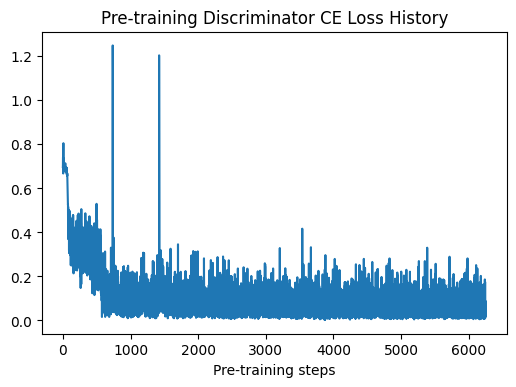

In [18]:
x = range(len(pretrain_disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_disc_token_loss_history)
plt.title('Pre-training Discriminator CE Loss History')
plt.xlabel('Pre-training steps')

In [20]:
loss_save_dir = './experiment_results/long_seqs_no_gm/init_pretrained/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)
    
with open(os.path.join(loss_save_dir, 'pretrain_disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(pretrain_disc_token_loss_history, f)

### Save Pretrained D

In [21]:
if not os.path.exists('./experiment_results/long_seqs_no_gm/init_pretrained/pretrained_disc_weights'):
    os.makedirs('./experiment_results/long_seqs_no_gm/init_pretrained/pretrained_disc_weights')
    
D_save_path = './experiment_results/long_seqs_no_gm/init_pretrained/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [23]:
reload_pretrained_disc = build_D(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)

In [24]:
reload_pretrained_disc.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(None, 21, 1)]      0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 21, 1)        0           time_delta[0][0]                 
                                                                 event_type[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 21, 1, 5)     30          masking_2[1][0]                  
__________________________________________________________________________________________________
time_delta (InputLayer)         [(None, 21, 1)]      0                                      

## Debugging Sampling from distributions

In [25]:
def generate_batch_sequence_by_rollout(
        G, batch_size, T, end_token=0, init_token=1, max_time=1024, verbose=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    curr_state_et = np.zeros([batch_size, 1, 1])
    curr_state_et[:, 0, 0] = init_token

    curr_state_ts = np.zeros([batch_size, 1, 1])
    curr_state_ts[:, 0, 0] = 0.0
    
    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, alpha, mu, sigma = G([curr_state_et, curr_state_ts])
        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using [alpha, mu, sigma]
        gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
                probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,
                scale=sigma))

        sampled_ts = tf.clip_by_value(gm.sample(), clip_value_min=1, clip_value_max=max_time)
        sampled_ts = tf.reshape(sampled_ts, [batch_size, 1, 1])

        # stop genererating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_ts, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)
    return all_state_et, all_state_ts

In [63]:
# generate_batch_sequence_by_rollout(reload_pretrained_gen, 
#                                    BATCH_SIZE,
#                                    T,
#                                    end_token=0, 
#                                    init_token=1,
#                                    max_time=1024,
#                                    verbose=False
#                                   )

In [37]:
G = reload_pretrained_gen
batch_size = BATCH_SIZE
init_token = INIT_TOKEN = 1

In [38]:
# Begin from dummy init state (init_token=1, init_timestamp=0.0)
curr_state_et = np.zeros([batch_size, 1, 1])
curr_state_et[:, 0, 0] = init_token

curr_state_ts = np.zeros([batch_size, 1, 1])
curr_state_ts[:, 0, 0] = 0.0

all_state_et = curr_state_et
all_state_ts = curr_state_ts

G.reset_states()

In [39]:
token_prob, time_out = G([curr_state_et, curr_state_ts])

In [64]:
# time_out.stddev()

In [65]:
from tensorflow_probability import distributions as tfd
mu = time_out.mean()
sigma = time_out.stddev()
s = tfd.Sample(tfd.Normal(loc=mu, scale=sigma),sample_shape=1)

In [73]:
np.maximum(np.ceil(s.sample(1).numpy().squeeze()),1)

array([1., 2., 3., 3., 1., 3., 2., 2., 2., 2., 1., 2., 2., 3., 3., 2., 2.,
       3., 2., 2., 3., 2., 1., 2., 2., 1., 3., 2., 1., 4., 1., 1., 1., 3.,
       1., 3., 2., 4., 2., 3., 1., 4., 2., 1., 1., 1., 1., 2., 1., 2., 2.,
       1., 2., 2., 3., 2., 1., 1., 1., 2., 1., 3., 4., 1.])